In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import torchvision

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Set seed
np.random.seed(1)
torch.manual_seed(1)

# Load Boston Housing dataset
wine_quality = np.genfromtxt('data/winequality-red.csv', delimiter=";")[1:,:]
target = wine_quality[:,-1].reshape(-1,1)
data = wine_quality[:,:-1]

# Split into training, validation and test set
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=150, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=150, random_state=1)

# Convert arrays to Torch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).view(-1,1)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val).view(-1,1)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).view(-1,1)

# Normalise the training dataset
X_train_mean = X_train.mean(0)
X_train_std = X_train.std(0)
X_train_norm = X_train.add(-1, X_train_mean) / X_train_std
y_train_mean = torch.mean(y_train)
y_train_std = torch.std(y_train)
y_train_norm = y_train.add(-1, y_train_mean) / y_train_std

# Define the data-loader
train_data = torch.utils.data.TensorDataset(X_train_norm, y_train_norm)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0)
val_data = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=150)
test_data = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=150)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                      nn.Linear(11, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50,1, bias=True)
                    ).to(device)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [4]:
class evaluation(object):
    def __init__(self, test_data, n_samples, X_mean=None, X_std=None, y_mean=None, y_std=None):
        self.test_data = test_data
        self.X_mean = X_mean
        self.X_std = X_std
        self.y_mean = y_mean
        self.y_std = y_std
        self.n = 0
        self.avg_prediction = 0.
        self.sum_pp = 0.
        self.sumsqr_pp = 0.
        self.preds = torch.zeros(len(test_data.dataset),n_samples)

    def fn(self, model):

        with torch.autograd.no_grad():
            self.n += 1
            for x, y in iter(self.test_data):
                x = x.view(x.size(0), -1)

                if (self.X_mean is not None) & (self.X_std is not None):
                    x = (x - self.X_mean).float() / self.X_std

                standard_pred = model(x)

                if (self.y_mean is not None) & (self.y_std is not None):
                    standard_pred = standard_pred * self.y_std + self.y_mean
                
                self.preds[:,self.n-1] = standard_pred.view(-1,)
                self.avg_prediction = self.avg_prediction * (self.n - 1.) / self.n + standard_pred.view(-1,1) / self.n
                self.sum_pp += standard_pred
                self.sumsqr_pp += standard_pred * standard_pred
                std_pred = torch.sqrt((self.sumsqr_pp - (self.sum_pp * self.sum_pp) / self.n) / (self.n - 1))



                norm = torch.distributions.normal.Normal(y, std_pred)
                test_ll = norm.log_prob(self.avg_prediction).mean()



                error = nn.MSELoss(size_average=True)
                rmse = error(self.avg_prediction, y) ** 0.5

                return rmse, test_ll, self.preds[:,self.n-1]

In [5]:
def gelman_rubin(x, return_var=False):
    m, n = x.size()

    var_between = torch.sum((torch.mean(x, 1) - torch.mean(x)) ** 2) / (m - 1)
    x_bar = torch.mean(x, 1).view(-1,1)

    var_within = torch.sum((x - x_bar) ** 2) / (m * (n - 1))

    var = var_within * (n - 1) / n + var_between

    if return_var:
        return var

    V = var_within + var_between / n

    return torch.sqrt(V / var_within)

def ess(x):
    m, n = x.size()
    
    s_sq = gelman_rubin(x, return_var = True)
    
    neg_autocorr = False
    t = 1
    
    variogram = lambda t: (sum(sum((x[j][i] - x[j][i-t]) ** 2 for i in range(t,n)) for j in range(m)) / (m * (n - t)))
    
    rho = torch.ones(n)
    
    while not neg_autocorr and (t < n):
        rho[t] = 1. - variogram(t) / (2. * s_sq)
        
        if not t % 2:
            neg_autocorr = sum(rho[(t-1):(t+1)]) < 0
        t += 1
        
    return float(m * n)/ (1. + 2. * rho[1:t].sum())

## SGLD

In [7]:
import torch
import torchvision
import os

from torch import nn
import torch.nn.functional as F
import numpy as np

import sgld

import model



np.random.seed(1)
torch.manual_seed(1)



lambda_ = 1.
#lr = 8e-7
#lr = 6e-6
#3e-2
# lr = 9e-7
# lr = 3e-6
lr = 3e-5



batch_size = 32.
dataset_size= 1299

n_samples = 300
n_chains = 10




ll_sgld = np.zeros((n_chains, n_samples))
rmse_sgld = np.zeros((n_chains, n_samples))
predictions_sgld = np.zeros((n_chains,n_samples,150))




for i in range(n_chains):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = sgld.optim.sgld(network, lr, lambda_, batch_size, dataset_size)
    evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)
    
    t = 1
    n = 0
    for epoch in range(2500):

        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            network.zero_grad()
            output = network(x)
            loss = 0.5 * criterion(output, y)
            loss.backward()
            optim.step()



            running_loss += loss * batch_size / dataset_size


            if (t >= 300) & (t % 100 == 0) & (n < n_samples):
                rmse,ll,prediction = evaluate.fn(network)
                rmse_sgld[i,n] = rmse
                ll_sgld[i,n] = ll
                predictions_sgld[i,n,:] = prediction
                n += 1

            t += 1.
        print("chain {:d} - epoch {:d} - loss: {:.4f}".format(i, epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 0 - loss: 11.6344
chain 0 - epoch 1 - loss: 10.9318
chain 0 - epoch 2 - loss: 10.8546
chain 0 - epoch 3 - loss: 11.0581
chain 0 - epoch 4 - loss: 10.8693
chain 0 - epoch 5 - loss: 10.8336
chain 0 - epoch 6 - loss: 10.7731


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 7 - loss: 10.7111
chain 0 - epoch 8 - loss: 10.7014
chain 0 - epoch 9 - loss: 10.6089
chain 0 - epoch 10 - loss: 10.5891
chain 0 - epoch 11 - loss: 10.7523
chain 0 - epoch 12 - loss: 10.6916
chain 0 - epoch 13 - loss: 10.5431
chain 0 - epoch 14 - loss: 10.6162
chain 0 - epoch 15 - loss: 10.5587
chain 0 - epoch 16 - loss: 10.5616
chain 0 - epoch 17 - loss: 10.3891
chain 0 - epoch 18 - loss: 10.3940
chain 0 - epoch 19 - loss: 10.4611
chain 0 - epoch 20 - loss: 10.6736
chain 0 - epoch 21 - loss: 10.6378
chain 0 - epoch 22 - loss: 10.2769
chain 0 - epoch 23 - loss: 10.5599
chain 0 - epoch 24 - loss: 10.4643
chain 0 - epoch 25 - loss: 10.3710
chain 0 - epoch 26 - loss: 10.6882
chain 0 - epoch 27 - loss: 10.5890
chain 0 - epoch 28 - loss: 10.4991
chain 0 - epoch 29 - loss: 10.7608
chain 0 - epoch 30 - loss: 10.7146
chain 0 - epoch 31 - loss: 10.5941
chain 0 - epoch 32 - loss: 10.6991
chain 0 - epoch 33 - loss: 10.5966
chain 0 - epoch 34 - loss: 10.3596
chain 0 - epoch 35 - lo

chain 0 - epoch 239 - loss: 15.9747
chain 0 - epoch 240 - loss: 11.0441
chain 0 - epoch 241 - loss: 11.4698
chain 0 - epoch 242 - loss: 15.3623
chain 0 - epoch 243 - loss: 12.8366
chain 0 - epoch 244 - loss: 11.7789
chain 0 - epoch 245 - loss: 15.0255
chain 0 - epoch 246 - loss: 12.6745
chain 0 - epoch 247 - loss: 10.8700
chain 0 - epoch 248 - loss: 11.1300
chain 0 - epoch 249 - loss: 12.7756
chain 0 - epoch 250 - loss: 11.1335
chain 0 - epoch 251 - loss: 11.8036
chain 0 - epoch 252 - loss: 11.3477
chain 0 - epoch 253 - loss: 12.4116
chain 0 - epoch 254 - loss: 11.0677
chain 0 - epoch 255 - loss: 12.9229
chain 0 - epoch 256 - loss: 10.8349
chain 0 - epoch 257 - loss: 11.3127
chain 0 - epoch 258 - loss: 12.4307
chain 0 - epoch 259 - loss: 13.7602
chain 0 - epoch 260 - loss: 11.5796
chain 0 - epoch 261 - loss: 12.6670
chain 0 - epoch 262 - loss: 12.0225
chain 0 - epoch 263 - loss: 14.8357
chain 0 - epoch 264 - loss: 11.8301
chain 0 - epoch 265 - loss: 12.9610
chain 0 - epoch 266 - loss: 

chain 0 - epoch 471 - loss: 8.2839
chain 0 - epoch 472 - loss: 8.3443
chain 0 - epoch 473 - loss: 8.2738
chain 0 - epoch 474 - loss: 8.2034
chain 0 - epoch 475 - loss: 8.1852
chain 0 - epoch 476 - loss: 8.1660
chain 0 - epoch 477 - loss: 8.5680
chain 0 - epoch 478 - loss: 8.0048
chain 0 - epoch 479 - loss: 8.0565
chain 0 - epoch 480 - loss: 7.9187
chain 0 - epoch 481 - loss: 8.0071
chain 0 - epoch 482 - loss: 8.4437
chain 0 - epoch 483 - loss: 8.2460
chain 0 - epoch 484 - loss: 8.4781
chain 0 - epoch 485 - loss: 8.4211
chain 0 - epoch 486 - loss: 8.4444
chain 0 - epoch 487 - loss: 8.8195
chain 0 - epoch 488 - loss: 8.1760
chain 0 - epoch 489 - loss: 8.2159
chain 0 - epoch 490 - loss: 8.3722
chain 0 - epoch 491 - loss: 7.9511
chain 0 - epoch 492 - loss: 8.2469
chain 0 - epoch 493 - loss: 8.3315
chain 0 - epoch 494 - loss: 8.3938
chain 0 - epoch 495 - loss: 8.5052
chain 0 - epoch 496 - loss: 8.4892
chain 0 - epoch 497 - loss: 8.2296
chain 0 - epoch 498 - loss: 8.7158
chain 0 - epoch 499 

chain 0 - epoch 705 - loss: 8.3234
chain 0 - epoch 706 - loss: 8.6166
chain 0 - epoch 707 - loss: 8.2854
chain 0 - epoch 708 - loss: 8.2960
chain 0 - epoch 709 - loss: 8.3430
chain 0 - epoch 710 - loss: 8.6291
chain 0 - epoch 711 - loss: 7.8819
chain 0 - epoch 712 - loss: 8.3096
chain 0 - epoch 713 - loss: 8.5341
chain 0 - epoch 714 - loss: 8.2848
chain 0 - epoch 715 - loss: 8.2803
chain 0 - epoch 716 - loss: 8.3674
chain 0 - epoch 717 - loss: 8.1228
chain 0 - epoch 718 - loss: 8.1702
chain 0 - epoch 719 - loss: 8.0970
chain 0 - epoch 720 - loss: 8.7048
chain 0 - epoch 721 - loss: 8.6012
chain 0 - epoch 722 - loss: 8.9757
chain 0 - epoch 723 - loss: 8.1645
chain 0 - epoch 724 - loss: 8.0148
chain 0 - epoch 725 - loss: 8.2433
chain 0 - epoch 726 - loss: 8.1621
chain 0 - epoch 727 - loss: 8.0986
chain 0 - epoch 728 - loss: 8.9284
chain 0 - epoch 729 - loss: 8.5527
chain 0 - epoch 730 - loss: 8.5615
chain 0 - epoch 731 - loss: 8.2917
chain 0 - epoch 732 - loss: 7.8075
chain 0 - epoch 733 

chain 0 - epoch 940 - loss: 7.0223
chain 0 - epoch 941 - loss: 6.9056
chain 0 - epoch 942 - loss: 6.9830
chain 0 - epoch 943 - loss: 7.1450
chain 0 - epoch 944 - loss: 7.2663
chain 0 - epoch 945 - loss: 7.2097
chain 0 - epoch 946 - loss: 7.1309
chain 0 - epoch 947 - loss: 7.3710
chain 0 - epoch 948 - loss: 7.4060
chain 0 - epoch 949 - loss: 7.5711
chain 0 - epoch 950 - loss: 7.5977
chain 0 - epoch 951 - loss: 7.4313
chain 0 - epoch 952 - loss: 7.4306
chain 0 - epoch 953 - loss: 7.4077
chain 0 - epoch 954 - loss: 7.4027
chain 0 - epoch 955 - loss: 7.4411
chain 0 - epoch 956 - loss: 7.5264
chain 0 - epoch 957 - loss: 7.4066
chain 0 - epoch 958 - loss: 7.5661
chain 0 - epoch 959 - loss: 7.5524
chain 0 - epoch 960 - loss: 7.4236
chain 0 - epoch 961 - loss: 7.7455
chain 0 - epoch 962 - loss: 7.5220
chain 0 - epoch 963 - loss: 7.5517
chain 0 - epoch 964 - loss: 7.5410
chain 0 - epoch 965 - loss: 7.6114
chain 0 - epoch 966 - loss: 7.3876
chain 0 - epoch 967 - loss: 7.4314
chain 0 - epoch 968 

chain 0 - epoch 1172 - loss: 7.2201
chain 0 - epoch 1173 - loss: 7.3606
chain 0 - epoch 1174 - loss: 7.3202
chain 0 - epoch 1175 - loss: 7.2960
chain 0 - epoch 1176 - loss: 7.3335
chain 0 - epoch 1177 - loss: 7.3103
chain 0 - epoch 1178 - loss: 7.3859
chain 0 - epoch 1179 - loss: 7.2979
chain 0 - epoch 1180 - loss: 7.3771
chain 0 - epoch 1181 - loss: 7.3336
chain 0 - epoch 1182 - loss: 7.3018
chain 0 - epoch 1183 - loss: 7.2809
chain 0 - epoch 1184 - loss: 7.2349
chain 0 - epoch 1185 - loss: 7.3725
chain 0 - epoch 1186 - loss: 7.3360
chain 0 - epoch 1187 - loss: 7.4618
chain 0 - epoch 1188 - loss: 7.2779
chain 0 - epoch 1189 - loss: 7.2751
chain 0 - epoch 1190 - loss: 7.3046
chain 0 - epoch 1191 - loss: 7.1995
chain 0 - epoch 1192 - loss: 7.1515
chain 0 - epoch 1193 - loss: 7.1455
chain 0 - epoch 1194 - loss: 7.2630
chain 0 - epoch 1195 - loss: 7.2799
chain 0 - epoch 1196 - loss: 7.2500
chain 0 - epoch 1197 - loss: 7.2702
chain 0 - epoch 1198 - loss: 7.1657
chain 0 - epoch 1199 - loss:

chain 0 - epoch 1403 - loss: 7.1545
chain 0 - epoch 1404 - loss: 7.2071
chain 0 - epoch 1405 - loss: 7.0859
chain 0 - epoch 1406 - loss: 6.9301
chain 0 - epoch 1407 - loss: 6.9153
chain 0 - epoch 1408 - loss: 6.9419
chain 0 - epoch 1409 - loss: 7.0099
chain 0 - epoch 1410 - loss: 6.9817
chain 0 - epoch 1411 - loss: 7.0914
chain 0 - epoch 1412 - loss: 7.0133
chain 0 - epoch 1413 - loss: 7.0063
chain 0 - epoch 1414 - loss: 7.0112
chain 0 - epoch 1415 - loss: 7.0814
chain 0 - epoch 1416 - loss: 7.1768
chain 0 - epoch 1417 - loss: 7.1222
chain 0 - epoch 1418 - loss: 7.0825
chain 0 - epoch 1419 - loss: 7.1948
chain 0 - epoch 1420 - loss: 7.0980
chain 0 - epoch 1421 - loss: 7.0949
chain 0 - epoch 1422 - loss: 7.1763
chain 0 - epoch 1423 - loss: 7.1590
chain 0 - epoch 1424 - loss: 7.1876
chain 0 - epoch 1425 - loss: 7.2069
chain 0 - epoch 1426 - loss: 7.1992
chain 0 - epoch 1427 - loss: 7.1293
chain 0 - epoch 1428 - loss: 7.1682
chain 0 - epoch 1429 - loss: 7.2149
chain 0 - epoch 1430 - loss:

chain 0 - epoch 1631 - loss: 6.9684
chain 0 - epoch 1632 - loss: 6.9130
chain 0 - epoch 1633 - loss: 6.8775
chain 0 - epoch 1634 - loss: 6.9496
chain 0 - epoch 1635 - loss: 6.7764
chain 0 - epoch 1636 - loss: 6.7667
chain 0 - epoch 1637 - loss: 6.8495
chain 0 - epoch 1638 - loss: 6.8649
chain 0 - epoch 1639 - loss: 6.9173
chain 0 - epoch 1640 - loss: 6.8129
chain 0 - epoch 1641 - loss: 6.7036
chain 0 - epoch 1642 - loss: 6.8460
chain 0 - epoch 1643 - loss: 6.7872
chain 0 - epoch 1644 - loss: 6.7610
chain 0 - epoch 1645 - loss: 6.7684
chain 0 - epoch 1646 - loss: 6.8217
chain 0 - epoch 1647 - loss: 6.8286
chain 0 - epoch 1648 - loss: 6.8418
chain 0 - epoch 1649 - loss: 6.8283
chain 0 - epoch 1650 - loss: 6.8786
chain 0 - epoch 1651 - loss: 6.9129
chain 0 - epoch 1652 - loss: 6.8353
chain 0 - epoch 1653 - loss: 6.7637
chain 0 - epoch 1654 - loss: 6.7918
chain 0 - epoch 1655 - loss: 6.6951
chain 0 - epoch 1656 - loss: 6.6977
chain 0 - epoch 1657 - loss: 6.7850
chain 0 - epoch 1658 - loss:

chain 0 - epoch 1861 - loss: 7.0102
chain 0 - epoch 1862 - loss: 6.9580
chain 0 - epoch 1863 - loss: 7.0061
chain 0 - epoch 1864 - loss: 6.9936
chain 0 - epoch 1865 - loss: 7.0029
chain 0 - epoch 1866 - loss: 7.0451
chain 0 - epoch 1867 - loss: 7.0497
chain 0 - epoch 1868 - loss: 6.9367
chain 0 - epoch 1869 - loss: 6.9904
chain 0 - epoch 1870 - loss: 7.0626
chain 0 - epoch 1871 - loss: 6.9958
chain 0 - epoch 1872 - loss: 7.1296
chain 0 - epoch 1873 - loss: 7.0245
chain 0 - epoch 1874 - loss: 7.0716
chain 0 - epoch 1875 - loss: 7.0487
chain 0 - epoch 1876 - loss: 7.0798
chain 0 - epoch 1877 - loss: 7.0998
chain 0 - epoch 1878 - loss: 6.9976
chain 0 - epoch 1879 - loss: 6.9772
chain 0 - epoch 1880 - loss: 6.9846
chain 0 - epoch 1881 - loss: 7.0079
chain 0 - epoch 1882 - loss: 7.0051
chain 0 - epoch 1883 - loss: 6.9597
chain 0 - epoch 1884 - loss: 6.9952
chain 0 - epoch 1885 - loss: 6.9838
chain 0 - epoch 1886 - loss: 6.9967
chain 0 - epoch 1887 - loss: 7.0751
chain 0 - epoch 1888 - loss:

chain 0 - epoch 2089 - loss: 6.8093
chain 0 - epoch 2090 - loss: 6.8144
chain 0 - epoch 2091 - loss: 6.8504
chain 0 - epoch 2092 - loss: 6.8807
chain 0 - epoch 2093 - loss: 6.9025
chain 0 - epoch 2094 - loss: 6.8824
chain 0 - epoch 2095 - loss: 6.8827
chain 0 - epoch 2096 - loss: 6.8912
chain 0 - epoch 2097 - loss: 6.8249
chain 0 - epoch 2098 - loss: 6.8443
chain 0 - epoch 2099 - loss: 6.8989
chain 0 - epoch 2100 - loss: 6.9205
chain 0 - epoch 2101 - loss: 6.8703
chain 0 - epoch 2102 - loss: 6.8864
chain 0 - epoch 2103 - loss: 6.8059
chain 0 - epoch 2104 - loss: 6.8882
chain 0 - epoch 2105 - loss: 6.9378
chain 0 - epoch 2106 - loss: 6.9716
chain 0 - epoch 2107 - loss: 6.9128
chain 0 - epoch 2108 - loss: 6.9173
chain 0 - epoch 2109 - loss: 6.9182
chain 0 - epoch 2110 - loss: 6.8656
chain 0 - epoch 2111 - loss: 6.8580
chain 0 - epoch 2112 - loss: 6.8171
chain 0 - epoch 2113 - loss: 6.8574
chain 0 - epoch 2114 - loss: 6.8211
chain 0 - epoch 2115 - loss: 6.8712
chain 0 - epoch 2116 - loss:

chain 0 - epoch 2319 - loss: 6.6724
chain 0 - epoch 2320 - loss: 6.6796
chain 0 - epoch 2321 - loss: 6.7733
chain 0 - epoch 2322 - loss: 6.7823
chain 0 - epoch 2323 - loss: 6.7228
chain 0 - epoch 2324 - loss: 6.6702
chain 0 - epoch 2325 - loss: 6.7134
chain 0 - epoch 2326 - loss: 6.7081
chain 0 - epoch 2327 - loss: 6.7216
chain 0 - epoch 2328 - loss: 6.7461
chain 0 - epoch 2329 - loss: 6.7186
chain 0 - epoch 2330 - loss: 6.7400
chain 0 - epoch 2331 - loss: 6.7007
chain 0 - epoch 2332 - loss: 6.7213
chain 0 - epoch 2333 - loss: 6.7635
chain 0 - epoch 2334 - loss: 6.6807
chain 0 - epoch 2335 - loss: 6.7177
chain 0 - epoch 2336 - loss: 6.6374
chain 0 - epoch 2337 - loss: 6.7843
chain 0 - epoch 2338 - loss: 6.7650
chain 0 - epoch 2339 - loss: 6.7584
chain 0 - epoch 2340 - loss: 6.7846
chain 0 - epoch 2341 - loss: 6.8253
chain 0 - epoch 2342 - loss: 6.8496
chain 0 - epoch 2343 - loss: 6.8157
chain 0 - epoch 2344 - loss: 6.8132
chain 0 - epoch 2345 - loss: 6.8455
chain 0 - epoch 2346 - loss:

chain 1 - epoch 51 - loss: 10.4394
chain 1 - epoch 52 - loss: 10.4867
chain 1 - epoch 53 - loss: 10.6441
chain 1 - epoch 54 - loss: 10.4566
chain 1 - epoch 55 - loss: 10.5735
chain 1 - epoch 56 - loss: 10.6195
chain 1 - epoch 57 - loss: 10.8102
chain 1 - epoch 58 - loss: 10.5042
chain 1 - epoch 59 - loss: 10.5911
chain 1 - epoch 60 - loss: 10.6708
chain 1 - epoch 61 - loss: 10.5306
chain 1 - epoch 62 - loss: 10.8114
chain 1 - epoch 63 - loss: 11.0294
chain 1 - epoch 64 - loss: 10.5620
chain 1 - epoch 65 - loss: 10.4734
chain 1 - epoch 66 - loss: 11.1647
chain 1 - epoch 67 - loss: 11.1405
chain 1 - epoch 68 - loss: 11.1620
chain 1 - epoch 69 - loss: 11.3451
chain 1 - epoch 70 - loss: 10.6600
chain 1 - epoch 71 - loss: 10.8775
chain 1 - epoch 72 - loss: 10.3558
chain 1 - epoch 73 - loss: 10.7406
chain 1 - epoch 74 - loss: 10.9221
chain 1 - epoch 75 - loss: 11.0310
chain 1 - epoch 76 - loss: 10.8938
chain 1 - epoch 77 - loss: 10.9442
chain 1 - epoch 78 - loss: 10.9944
chain 1 - epoch 79 -

chain 1 - epoch 282 - loss: 13.9448
chain 1 - epoch 283 - loss: 9.9775
chain 1 - epoch 284 - loss: 9.4242
chain 1 - epoch 285 - loss: 15.6992
chain 1 - epoch 286 - loss: 12.5664
chain 1 - epoch 287 - loss: 10.1807
chain 1 - epoch 288 - loss: 10.5936
chain 1 - epoch 289 - loss: 9.9076
chain 1 - epoch 290 - loss: 17.4714
chain 1 - epoch 291 - loss: 10.6999
chain 1 - epoch 292 - loss: 12.3420
chain 1 - epoch 293 - loss: 10.4748
chain 1 - epoch 294 - loss: 10.0629
chain 1 - epoch 295 - loss: 24.0880
chain 1 - epoch 296 - loss: 11.5985
chain 1 - epoch 297 - loss: 13.5027
chain 1 - epoch 298 - loss: 12.3586
chain 1 - epoch 299 - loss: 14.3191
chain 1 - epoch 300 - loss: 11.3246
chain 1 - epoch 301 - loss: 11.7811
chain 1 - epoch 302 - loss: 10.4948
chain 1 - epoch 303 - loss: 17.6820
chain 1 - epoch 304 - loss: 10.4768
chain 1 - epoch 305 - loss: 9.7296
chain 1 - epoch 306 - loss: 14.5906
chain 1 - epoch 307 - loss: 12.3204
chain 1 - epoch 308 - loss: 12.3582
chain 1 - epoch 309 - loss: 11.3

chain 1 - epoch 515 - loss: 8.9983
chain 1 - epoch 516 - loss: 8.3325
chain 1 - epoch 517 - loss: 8.5507
chain 1 - epoch 518 - loss: 8.8604
chain 1 - epoch 519 - loss: 8.9351
chain 1 - epoch 520 - loss: 8.8707
chain 1 - epoch 521 - loss: 8.4470
chain 1 - epoch 522 - loss: 8.2871
chain 1 - epoch 523 - loss: 8.8782
chain 1 - epoch 524 - loss: 9.5315
chain 1 - epoch 525 - loss: 8.3476
chain 1 - epoch 526 - loss: 8.8025
chain 1 - epoch 527 - loss: 9.2928
chain 1 - epoch 528 - loss: 9.6261
chain 1 - epoch 529 - loss: 9.2990
chain 1 - epoch 530 - loss: 10.7340
chain 1 - epoch 531 - loss: 10.1883
chain 1 - epoch 532 - loss: 8.5577
chain 1 - epoch 533 - loss: 9.2888
chain 1 - epoch 534 - loss: 8.4274
chain 1 - epoch 535 - loss: 10.2387
chain 1 - epoch 536 - loss: 10.3511
chain 1 - epoch 537 - loss: 8.8352
chain 1 - epoch 538 - loss: 8.9974
chain 1 - epoch 539 - loss: 13.5663
chain 1 - epoch 540 - loss: 9.3907
chain 1 - epoch 541 - loss: 10.4459
chain 1 - epoch 542 - loss: 8.6012
chain 1 - epoc

chain 1 - epoch 751 - loss: 7.3345
chain 1 - epoch 752 - loss: 7.3964
chain 1 - epoch 753 - loss: 7.3749
chain 1 - epoch 754 - loss: 7.5061
chain 1 - epoch 755 - loss: 7.2820
chain 1 - epoch 756 - loss: 7.4367
chain 1 - epoch 757 - loss: 7.3750
chain 1 - epoch 758 - loss: 7.3072
chain 1 - epoch 759 - loss: 7.2384
chain 1 - epoch 760 - loss: 7.3648
chain 1 - epoch 761 - loss: 7.3368
chain 1 - epoch 762 - loss: 7.3036
chain 1 - epoch 763 - loss: 7.1981
chain 1 - epoch 764 - loss: 7.4089
chain 1 - epoch 765 - loss: 7.2588
chain 1 - epoch 766 - loss: 7.2738
chain 1 - epoch 767 - loss: 7.4112
chain 1 - epoch 768 - loss: 7.4140
chain 1 - epoch 769 - loss: 7.4699
chain 1 - epoch 770 - loss: 7.3942
chain 1 - epoch 771 - loss: 7.6787
chain 1 - epoch 772 - loss: 7.4819
chain 1 - epoch 773 - loss: 7.6993
chain 1 - epoch 774 - loss: 7.4838
chain 1 - epoch 775 - loss: 7.4829
chain 1 - epoch 776 - loss: 7.4378
chain 1 - epoch 777 - loss: 7.5219
chain 1 - epoch 778 - loss: 7.6101
chain 1 - epoch 779 

chain 1 - epoch 987 - loss: 7.5483
chain 1 - epoch 988 - loss: 7.6211
chain 1 - epoch 989 - loss: 7.4934
chain 1 - epoch 990 - loss: 7.4833
chain 1 - epoch 991 - loss: 7.5059
chain 1 - epoch 992 - loss: 7.4755
chain 1 - epoch 993 - loss: 7.2809
chain 1 - epoch 994 - loss: 7.2651
chain 1 - epoch 995 - loss: 7.2374
chain 1 - epoch 996 - loss: 7.1504
chain 1 - epoch 997 - loss: 7.3382
chain 1 - epoch 998 - loss: 7.4686
chain 1 - epoch 999 - loss: 7.3712
chain 1 - epoch 1000 - loss: 7.4688
chain 1 - epoch 1001 - loss: 7.2617
chain 1 - epoch 1002 - loss: 7.7463
chain 1 - epoch 1003 - loss: 7.4870
chain 1 - epoch 1004 - loss: 7.3603
chain 1 - epoch 1005 - loss: 7.3201
chain 1 - epoch 1006 - loss: 7.0652
chain 1 - epoch 1007 - loss: 7.0615
chain 1 - epoch 1008 - loss: 7.2234
chain 1 - epoch 1009 - loss: 7.3075
chain 1 - epoch 1010 - loss: 7.2422
chain 1 - epoch 1011 - loss: 7.3282
chain 1 - epoch 1012 - loss: 7.2314
chain 1 - epoch 1013 - loss: 7.3347
chain 1 - epoch 1014 - loss: 7.2166
chain

chain 1 - epoch 1215 - loss: 7.0603
chain 1 - epoch 1216 - loss: 7.0835
chain 1 - epoch 1217 - loss: 7.0919
chain 1 - epoch 1218 - loss: 7.1604
chain 1 - epoch 1219 - loss: 7.1030
chain 1 - epoch 1220 - loss: 7.1846
chain 1 - epoch 1221 - loss: 7.2299
chain 1 - epoch 1222 - loss: 7.2231
chain 1 - epoch 1223 - loss: 7.2951
chain 1 - epoch 1224 - loss: 7.2603
chain 1 - epoch 1225 - loss: 7.3586
chain 1 - epoch 1226 - loss: 7.0316
chain 1 - epoch 1227 - loss: 7.0951
chain 1 - epoch 1228 - loss: 7.2524
chain 1 - epoch 1229 - loss: 7.1539
chain 1 - epoch 1230 - loss: 7.2439
chain 1 - epoch 1231 - loss: 7.2589
chain 1 - epoch 1232 - loss: 7.1220
chain 1 - epoch 1233 - loss: 7.1839
chain 1 - epoch 1234 - loss: 7.3050
chain 1 - epoch 1235 - loss: 7.1359
chain 1 - epoch 1236 - loss: 7.1287
chain 1 - epoch 1237 - loss: 7.2459
chain 1 - epoch 1238 - loss: 7.2601
chain 1 - epoch 1239 - loss: 7.3727
chain 1 - epoch 1240 - loss: 7.2941
chain 1 - epoch 1241 - loss: 7.3534
chain 1 - epoch 1242 - loss:

chain 1 - epoch 1444 - loss: 7.2431
chain 1 - epoch 1445 - loss: 7.2605
chain 1 - epoch 1446 - loss: 7.2874
chain 1 - epoch 1447 - loss: 7.1767
chain 1 - epoch 1448 - loss: 7.1015
chain 1 - epoch 1449 - loss: 7.3242
chain 1 - epoch 1450 - loss: 7.2174
chain 1 - epoch 1451 - loss: 7.0921
chain 1 - epoch 1452 - loss: 7.2371
chain 1 - epoch 1453 - loss: 7.2090
chain 1 - epoch 1454 - loss: 7.2479
chain 1 - epoch 1455 - loss: 7.2630
chain 1 - epoch 1456 - loss: 7.0868
chain 1 - epoch 1457 - loss: 7.1535
chain 1 - epoch 1458 - loss: 7.0807
chain 1 - epoch 1459 - loss: 7.2373
chain 1 - epoch 1460 - loss: 7.2149
chain 1 - epoch 1461 - loss: 7.0617
chain 1 - epoch 1462 - loss: 7.1355
chain 1 - epoch 1463 - loss: 7.0424
chain 1 - epoch 1464 - loss: 7.0023
chain 1 - epoch 1465 - loss: 7.0193
chain 1 - epoch 1466 - loss: 7.0360
chain 1 - epoch 1467 - loss: 7.1065
chain 1 - epoch 1468 - loss: 7.0776
chain 1 - epoch 1469 - loss: 7.0303
chain 1 - epoch 1470 - loss: 6.9466
chain 1 - epoch 1471 - loss:

chain 1 - epoch 1672 - loss: 7.0207
chain 1 - epoch 1673 - loss: 7.1035
chain 1 - epoch 1674 - loss: 7.2974
chain 1 - epoch 1675 - loss: 7.2442
chain 1 - epoch 1676 - loss: 7.1405
chain 1 - epoch 1677 - loss: 7.3816
chain 1 - epoch 1678 - loss: 7.1133
chain 1 - epoch 1679 - loss: 7.1686
chain 1 - epoch 1680 - loss: 7.2087
chain 1 - epoch 1681 - loss: 7.2053
chain 1 - epoch 1682 - loss: 7.1430
chain 1 - epoch 1683 - loss: 7.1567
chain 1 - epoch 1684 - loss: 7.1727
chain 1 - epoch 1685 - loss: 7.1485
chain 1 - epoch 1686 - loss: 7.0592
chain 1 - epoch 1687 - loss: 7.0191
chain 1 - epoch 1688 - loss: 7.1621
chain 1 - epoch 1689 - loss: 7.0251
chain 1 - epoch 1690 - loss: 6.9966
chain 1 - epoch 1691 - loss: 7.0663
chain 1 - epoch 1692 - loss: 7.0796
chain 1 - epoch 1693 - loss: 7.1213
chain 1 - epoch 1694 - loss: 7.0475
chain 1 - epoch 1695 - loss: 7.1231
chain 1 - epoch 1696 - loss: 7.1401
chain 1 - epoch 1697 - loss: 7.1150
chain 1 - epoch 1698 - loss: 7.1531
chain 1 - epoch 1699 - loss:

chain 1 - epoch 1902 - loss: 7.1066
chain 1 - epoch 1903 - loss: 7.1267
chain 1 - epoch 1904 - loss: 7.1481
chain 1 - epoch 1905 - loss: 7.0867
chain 1 - epoch 1906 - loss: 7.1897
chain 1 - epoch 1907 - loss: 7.1400
chain 1 - epoch 1908 - loss: 7.1523
chain 1 - epoch 1909 - loss: 7.1431
chain 1 - epoch 1910 - loss: 7.1207
chain 1 - epoch 1911 - loss: 7.1168
chain 1 - epoch 1912 - loss: 7.1227
chain 1 - epoch 1913 - loss: 6.9779
chain 1 - epoch 1914 - loss: 7.0834
chain 1 - epoch 1915 - loss: 7.0262
chain 1 - epoch 1916 - loss: 7.0677
chain 1 - epoch 1917 - loss: 7.1333
chain 1 - epoch 1918 - loss: 7.0933
chain 1 - epoch 1919 - loss: 6.9846
chain 1 - epoch 1920 - loss: 7.0148
chain 1 - epoch 1921 - loss: 7.0054
chain 1 - epoch 1922 - loss: 7.1021
chain 1 - epoch 1923 - loss: 7.1258
chain 1 - epoch 1924 - loss: 7.0999
chain 1 - epoch 1925 - loss: 6.9711
chain 1 - epoch 1926 - loss: 7.0464
chain 1 - epoch 1927 - loss: 7.0015
chain 1 - epoch 1928 - loss: 7.0407
chain 1 - epoch 1929 - loss:

chain 1 - epoch 2131 - loss: 7.0976
chain 1 - epoch 2132 - loss: 7.0756
chain 1 - epoch 2133 - loss: 7.1597
chain 1 - epoch 2134 - loss: 7.1386
chain 1 - epoch 2135 - loss: 7.1994
chain 1 - epoch 2136 - loss: 7.1863
chain 1 - epoch 2137 - loss: 7.1978
chain 1 - epoch 2138 - loss: 7.1705
chain 1 - epoch 2139 - loss: 7.2187
chain 1 - epoch 2140 - loss: 7.2405
chain 1 - epoch 2141 - loss: 7.2207
chain 1 - epoch 2142 - loss: 7.2399
chain 1 - epoch 2143 - loss: 7.1726
chain 1 - epoch 2144 - loss: 7.2046
chain 1 - epoch 2145 - loss: 7.1896
chain 1 - epoch 2146 - loss: 7.1798
chain 1 - epoch 2147 - loss: 7.2474
chain 1 - epoch 2148 - loss: 7.1879
chain 1 - epoch 2149 - loss: 7.1340
chain 1 - epoch 2150 - loss: 7.1715
chain 1 - epoch 2151 - loss: 7.0926
chain 1 - epoch 2152 - loss: 7.1431
chain 1 - epoch 2153 - loss: 7.1452
chain 1 - epoch 2154 - loss: 7.1565
chain 1 - epoch 2155 - loss: 7.1077
chain 1 - epoch 2156 - loss: 7.1017
chain 1 - epoch 2157 - loss: 7.0736
chain 1 - epoch 2158 - loss:

chain 1 - epoch 2360 - loss: 7.1571
chain 1 - epoch 2361 - loss: 7.1224
chain 1 - epoch 2362 - loss: 7.2010
chain 1 - epoch 2363 - loss: 7.0822
chain 1 - epoch 2364 - loss: 7.0902
chain 1 - epoch 2365 - loss: 7.0717
chain 1 - epoch 2366 - loss: 7.0375
chain 1 - epoch 2367 - loss: 7.0814
chain 1 - epoch 2368 - loss: 7.0893
chain 1 - epoch 2369 - loss: 7.0917
chain 1 - epoch 2370 - loss: 7.1236
chain 1 - epoch 2371 - loss: 7.0905
chain 1 - epoch 2372 - loss: 7.1495
chain 1 - epoch 2373 - loss: 7.1588
chain 1 - epoch 2374 - loss: 7.1531
chain 1 - epoch 2375 - loss: 7.1780
chain 1 - epoch 2376 - loss: 7.1805
chain 1 - epoch 2377 - loss: 7.1885
chain 1 - epoch 2378 - loss: 7.2082
chain 1 - epoch 2379 - loss: 7.1756
chain 1 - epoch 2380 - loss: 7.1557
chain 1 - epoch 2381 - loss: 7.2576
chain 1 - epoch 2382 - loss: 7.1181
chain 1 - epoch 2383 - loss: 7.1915
chain 1 - epoch 2384 - loss: 7.2446
chain 1 - epoch 2385 - loss: 7.2025
chain 1 - epoch 2386 - loss: 7.2507
chain 1 - epoch 2387 - loss:

chain 2 - epoch 92 - loss: 10.5598
chain 2 - epoch 93 - loss: 11.1980
chain 2 - epoch 94 - loss: 11.2804
chain 2 - epoch 95 - loss: 10.4374
chain 2 - epoch 96 - loss: 10.5307
chain 2 - epoch 97 - loss: 10.5141
chain 2 - epoch 98 - loss: 10.2718
chain 2 - epoch 99 - loss: 10.4300
chain 2 - epoch 100 - loss: 10.4920
chain 2 - epoch 101 - loss: 10.8327
chain 2 - epoch 102 - loss: 10.5791
chain 2 - epoch 103 - loss: 10.6462
chain 2 - epoch 104 - loss: 10.8740
chain 2 - epoch 105 - loss: 10.5922
chain 2 - epoch 106 - loss: 10.6938
chain 2 - epoch 107 - loss: 10.6106
chain 2 - epoch 108 - loss: 10.5566
chain 2 - epoch 109 - loss: 10.4191
chain 2 - epoch 110 - loss: 10.5748
chain 2 - epoch 111 - loss: 10.6688
chain 2 - epoch 112 - loss: 10.2478
chain 2 - epoch 113 - loss: 10.4273
chain 2 - epoch 114 - loss: 10.5041
chain 2 - epoch 115 - loss: 10.9538
chain 2 - epoch 116 - loss: 10.6977
chain 2 - epoch 117 - loss: 10.7195
chain 2 - epoch 118 - loss: 10.6932
chain 2 - epoch 119 - loss: 11.0050


chain 2 - epoch 323 - loss: 10.7484
chain 2 - epoch 324 - loss: 11.7069
chain 2 - epoch 325 - loss: 10.4394
chain 2 - epoch 326 - loss: 10.4275
chain 2 - epoch 327 - loss: 15.5844
chain 2 - epoch 328 - loss: 10.8514
chain 2 - epoch 329 - loss: 10.9756
chain 2 - epoch 330 - loss: 12.9696
chain 2 - epoch 331 - loss: 12.2553
chain 2 - epoch 332 - loss: 11.6550
chain 2 - epoch 333 - loss: 12.4018
chain 2 - epoch 334 - loss: 11.9972
chain 2 - epoch 335 - loss: 12.6195
chain 2 - epoch 336 - loss: 10.6329
chain 2 - epoch 337 - loss: 12.1815
chain 2 - epoch 338 - loss: 11.2562
chain 2 - epoch 339 - loss: 16.1337
chain 2 - epoch 340 - loss: 13.3108
chain 2 - epoch 341 - loss: 14.2810
chain 2 - epoch 342 - loss: 12.8306
chain 2 - epoch 343 - loss: 11.7318
chain 2 - epoch 344 - loss: 11.6354
chain 2 - epoch 345 - loss: 12.6120
chain 2 - epoch 346 - loss: 11.4787
chain 2 - epoch 347 - loss: 12.5351
chain 2 - epoch 348 - loss: 12.3800
chain 2 - epoch 349 - loss: 12.0991
chain 2 - epoch 350 - loss: 

chain 2 - epoch 556 - loss: 8.2765
chain 2 - epoch 557 - loss: 7.8249
chain 2 - epoch 558 - loss: 8.1705
chain 2 - epoch 559 - loss: 8.1531
chain 2 - epoch 560 - loss: 8.0026
chain 2 - epoch 561 - loss: 7.9935
chain 2 - epoch 562 - loss: 7.8513
chain 2 - epoch 563 - loss: 8.2980
chain 2 - epoch 564 - loss: 9.7090
chain 2 - epoch 565 - loss: 8.2683
chain 2 - epoch 566 - loss: 8.6506
chain 2 - epoch 567 - loss: 8.8532
chain 2 - epoch 568 - loss: 8.8462
chain 2 - epoch 569 - loss: 8.0418
chain 2 - epoch 570 - loss: 8.0675
chain 2 - epoch 571 - loss: 8.1395
chain 2 - epoch 572 - loss: 8.0070
chain 2 - epoch 573 - loss: 8.2247
chain 2 - epoch 574 - loss: 7.8142
chain 2 - epoch 575 - loss: 8.0796
chain 2 - epoch 576 - loss: 7.8016
chain 2 - epoch 577 - loss: 8.0006
chain 2 - epoch 578 - loss: 8.8728
chain 2 - epoch 579 - loss: 8.6595
chain 2 - epoch 580 - loss: 9.2713
chain 2 - epoch 581 - loss: 8.9484
chain 2 - epoch 582 - loss: 8.4021
chain 2 - epoch 583 - loss: 8.3333
chain 2 - epoch 584 

chain 2 - epoch 790 - loss: 7.4408
chain 2 - epoch 791 - loss: 7.4527
chain 2 - epoch 792 - loss: 7.3419
chain 2 - epoch 793 - loss: 7.4458
chain 2 - epoch 794 - loss: 7.4442
chain 2 - epoch 795 - loss: 7.3302
chain 2 - epoch 796 - loss: 7.3809
chain 2 - epoch 797 - loss: 7.6506
chain 2 - epoch 798 - loss: 7.5670
chain 2 - epoch 799 - loss: 7.3247
chain 2 - epoch 800 - loss: 7.6941
chain 2 - epoch 801 - loss: 7.3665
chain 2 - epoch 802 - loss: 7.3373
chain 2 - epoch 803 - loss: 7.2771
chain 2 - epoch 804 - loss: 7.1105
chain 2 - epoch 805 - loss: 7.3763
chain 2 - epoch 806 - loss: 7.2569
chain 2 - epoch 807 - loss: 7.0667
chain 2 - epoch 808 - loss: 7.1114
chain 2 - epoch 809 - loss: 7.1702
chain 2 - epoch 810 - loss: 7.2028
chain 2 - epoch 811 - loss: 7.2070
chain 2 - epoch 812 - loss: 7.2384
chain 2 - epoch 813 - loss: 7.1539
chain 2 - epoch 814 - loss: 7.2439
chain 2 - epoch 815 - loss: 6.9873
chain 2 - epoch 816 - loss: 7.2112
chain 2 - epoch 817 - loss: 7.4289
chain 2 - epoch 818 

chain 2 - epoch 1025 - loss: 7.2687
chain 2 - epoch 1026 - loss: 7.1833
chain 2 - epoch 1027 - loss: 7.1690
chain 2 - epoch 1028 - loss: 7.2722
chain 2 - epoch 1029 - loss: 7.1820
chain 2 - epoch 1030 - loss: 7.2686
chain 2 - epoch 1031 - loss: 7.3005
chain 2 - epoch 1032 - loss: 7.3764
chain 2 - epoch 1033 - loss: 7.2558
chain 2 - epoch 1034 - loss: 7.1581
chain 2 - epoch 1035 - loss: 7.0665
chain 2 - epoch 1036 - loss: 7.0384
chain 2 - epoch 1037 - loss: 7.1245
chain 2 - epoch 1038 - loss: 7.1451
chain 2 - epoch 1039 - loss: 7.1202
chain 2 - epoch 1040 - loss: 7.0849
chain 2 - epoch 1041 - loss: 7.0084
chain 2 - epoch 1042 - loss: 7.1722
chain 2 - epoch 1043 - loss: 7.1709
chain 2 - epoch 1044 - loss: 7.2313
chain 2 - epoch 1045 - loss: 7.3743
chain 2 - epoch 1046 - loss: 7.2904
chain 2 - epoch 1047 - loss: 7.2415
chain 2 - epoch 1048 - loss: 7.3943
chain 2 - epoch 1049 - loss: 7.3296
chain 2 - epoch 1050 - loss: 7.3164
chain 2 - epoch 1051 - loss: 7.1908
chain 2 - epoch 1052 - loss:

chain 2 - epoch 1253 - loss: 7.1097
chain 2 - epoch 1254 - loss: 7.1771
chain 2 - epoch 1255 - loss: 7.0927
chain 2 - epoch 1256 - loss: 7.0449
chain 2 - epoch 1257 - loss: 7.0819
chain 2 - epoch 1258 - loss: 6.9408
chain 2 - epoch 1259 - loss: 7.1185
chain 2 - epoch 1260 - loss: 7.1474
chain 2 - epoch 1261 - loss: 7.0399
chain 2 - epoch 1262 - loss: 6.9308
chain 2 - epoch 1263 - loss: 6.8951
chain 2 - epoch 1264 - loss: 6.9788
chain 2 - epoch 1265 - loss: 6.9227
chain 2 - epoch 1266 - loss: 6.9117
chain 2 - epoch 1267 - loss: 6.9550
chain 2 - epoch 1268 - loss: 6.9261
chain 2 - epoch 1269 - loss: 7.0351
chain 2 - epoch 1270 - loss: 7.1381
chain 2 - epoch 1271 - loss: 7.2040
chain 2 - epoch 1272 - loss: 7.1891
chain 2 - epoch 1273 - loss: 7.2608
chain 2 - epoch 1274 - loss: 7.1716
chain 2 - epoch 1275 - loss: 7.1162
chain 2 - epoch 1276 - loss: 7.1058
chain 2 - epoch 1277 - loss: 7.0718
chain 2 - epoch 1278 - loss: 7.0266
chain 2 - epoch 1279 - loss: 6.9077
chain 2 - epoch 1280 - loss:

chain 2 - epoch 1481 - loss: 6.5047
chain 2 - epoch 1482 - loss: 6.5160
chain 2 - epoch 1483 - loss: 6.6177
chain 2 - epoch 1484 - loss: 6.5926
chain 2 - epoch 1485 - loss: 6.7166
chain 2 - epoch 1486 - loss: 6.6980
chain 2 - epoch 1487 - loss: 6.6678
chain 2 - epoch 1488 - loss: 6.6308
chain 2 - epoch 1489 - loss: 6.6136
chain 2 - epoch 1490 - loss: 6.5493
chain 2 - epoch 1491 - loss: 6.5944
chain 2 - epoch 1492 - loss: 6.4847
chain 2 - epoch 1493 - loss: 6.6683
chain 2 - epoch 1494 - loss: 6.6235
chain 2 - epoch 1495 - loss: 6.6247
chain 2 - epoch 1496 - loss: 6.5247
chain 2 - epoch 1497 - loss: 6.7002
chain 2 - epoch 1498 - loss: 6.6099
chain 2 - epoch 1499 - loss: 6.5603
chain 2 - epoch 1500 - loss: 6.5997
chain 2 - epoch 1501 - loss: 6.5200
chain 2 - epoch 1502 - loss: 6.5969
chain 2 - epoch 1503 - loss: 6.5753
chain 2 - epoch 1504 - loss: 6.5241
chain 2 - epoch 1505 - loss: 6.6477
chain 2 - epoch 1506 - loss: 6.5913
chain 2 - epoch 1507 - loss: 6.5629
chain 2 - epoch 1508 - loss:

chain 2 - epoch 1709 - loss: 7.0048
chain 2 - epoch 1710 - loss: 7.0064
chain 2 - epoch 1711 - loss: 7.0789
chain 2 - epoch 1712 - loss: 6.8841
chain 2 - epoch 1713 - loss: 6.8267
chain 2 - epoch 1714 - loss: 6.9203
chain 2 - epoch 1715 - loss: 6.7883
chain 2 - epoch 1716 - loss: 6.8223
chain 2 - epoch 1717 - loss: 6.8315
chain 2 - epoch 1718 - loss: 6.8068
chain 2 - epoch 1719 - loss: 6.8301
chain 2 - epoch 1720 - loss: 6.8506
chain 2 - epoch 1721 - loss: 6.7517
chain 2 - epoch 1722 - loss: 6.9656
chain 2 - epoch 1723 - loss: 6.7976
chain 2 - epoch 1724 - loss: 6.7723
chain 2 - epoch 1725 - loss: 6.8721
chain 2 - epoch 1726 - loss: 6.9038
chain 2 - epoch 1727 - loss: 6.8363
chain 2 - epoch 1728 - loss: 6.8057
chain 2 - epoch 1729 - loss: 6.8867
chain 2 - epoch 1730 - loss: 6.6968
chain 2 - epoch 1731 - loss: 6.7762
chain 2 - epoch 1732 - loss: 6.8358
chain 2 - epoch 1733 - loss: 6.7589
chain 2 - epoch 1734 - loss: 6.8244
chain 2 - epoch 1735 - loss: 6.8858
chain 2 - epoch 1736 - loss:

chain 2 - epoch 1938 - loss: 6.7861
chain 2 - epoch 1939 - loss: 6.8367
chain 2 - epoch 1940 - loss: 6.8345
chain 2 - epoch 1941 - loss: 6.8647
chain 2 - epoch 1942 - loss: 6.8460
chain 2 - epoch 1943 - loss: 6.7381
chain 2 - epoch 1944 - loss: 6.8234
chain 2 - epoch 1945 - loss: 6.8289
chain 2 - epoch 1946 - loss: 6.7868
chain 2 - epoch 1947 - loss: 6.9198
chain 2 - epoch 1948 - loss: 6.8286
chain 2 - epoch 1949 - loss: 6.7835
chain 2 - epoch 1950 - loss: 6.9099
chain 2 - epoch 1951 - loss: 6.9609
chain 2 - epoch 1952 - loss: 7.0272
chain 2 - epoch 1953 - loss: 6.9370
chain 2 - epoch 1954 - loss: 7.0256
chain 2 - epoch 1955 - loss: 7.0280
chain 2 - epoch 1956 - loss: 7.0584
chain 2 - epoch 1957 - loss: 7.0292
chain 2 - epoch 1958 - loss: 6.9284
chain 2 - epoch 1959 - loss: 6.9367
chain 2 - epoch 1960 - loss: 6.8699
chain 2 - epoch 1961 - loss: 6.8913
chain 2 - epoch 1962 - loss: 6.9387
chain 2 - epoch 1963 - loss: 6.9924
chain 2 - epoch 1964 - loss: 6.9305
chain 2 - epoch 1965 - loss:

chain 2 - epoch 2168 - loss: 6.6047
chain 2 - epoch 2169 - loss: 6.6249
chain 2 - epoch 2170 - loss: 6.6510
chain 2 - epoch 2171 - loss: 6.6162
chain 2 - epoch 2172 - loss: 6.6077
chain 2 - epoch 2173 - loss: 6.5274
chain 2 - epoch 2174 - loss: 6.5164
chain 2 - epoch 2175 - loss: 6.5706
chain 2 - epoch 2176 - loss: 6.6247
chain 2 - epoch 2177 - loss: 6.5836
chain 2 - epoch 2178 - loss: 6.6196
chain 2 - epoch 2179 - loss: 6.7061
chain 2 - epoch 2180 - loss: 6.6724
chain 2 - epoch 2181 - loss: 6.6440
chain 2 - epoch 2182 - loss: 6.6587
chain 2 - epoch 2183 - loss: 6.6561
chain 2 - epoch 2184 - loss: 6.7518
chain 2 - epoch 2185 - loss: 6.7336
chain 2 - epoch 2186 - loss: 6.6133
chain 2 - epoch 2187 - loss: 6.6702
chain 2 - epoch 2188 - loss: 6.7128
chain 2 - epoch 2189 - loss: 6.5901
chain 2 - epoch 2190 - loss: 6.6935
chain 2 - epoch 2191 - loss: 6.7431
chain 2 - epoch 2192 - loss: 6.7097
chain 2 - epoch 2193 - loss: 6.7378
chain 2 - epoch 2194 - loss: 6.8459
chain 2 - epoch 2195 - loss:

chain 2 - epoch 2398 - loss: 6.7470
chain 2 - epoch 2399 - loss: 6.7674
chain 2 - epoch 2400 - loss: 6.7233
chain 2 - epoch 2401 - loss: 6.8238
chain 2 - epoch 2402 - loss: 6.7740
chain 2 - epoch 2403 - loss: 6.7761
chain 2 - epoch 2404 - loss: 6.7539
chain 2 - epoch 2405 - loss: 6.7723
chain 2 - epoch 2406 - loss: 6.7858
chain 2 - epoch 2407 - loss: 6.8774
chain 2 - epoch 2408 - loss: 6.8187
chain 2 - epoch 2409 - loss: 6.7533
chain 2 - epoch 2410 - loss: 6.7960
chain 2 - epoch 2411 - loss: 6.7369
chain 2 - epoch 2412 - loss: 6.7546
chain 2 - epoch 2413 - loss: 6.6787
chain 2 - epoch 2414 - loss: 6.7428
chain 2 - epoch 2415 - loss: 6.7766
chain 2 - epoch 2416 - loss: 6.7377
chain 2 - epoch 2417 - loss: 6.7111
chain 2 - epoch 2418 - loss: 6.7200
chain 2 - epoch 2419 - loss: 6.7624
chain 2 - epoch 2420 - loss: 6.7456
chain 2 - epoch 2421 - loss: 6.8411
chain 2 - epoch 2422 - loss: 6.7501
chain 2 - epoch 2423 - loss: 6.7554
chain 2 - epoch 2424 - loss: 6.7255
chain 2 - epoch 2425 - loss:

chain 3 - epoch 130 - loss: 10.2112
chain 3 - epoch 131 - loss: 10.1127
chain 3 - epoch 132 - loss: 10.0196
chain 3 - epoch 133 - loss: 10.2236
chain 3 - epoch 134 - loss: 9.7508
chain 3 - epoch 135 - loss: 9.6899
chain 3 - epoch 136 - loss: 9.4355
chain 3 - epoch 137 - loss: 9.7991
chain 3 - epoch 138 - loss: 9.9465
chain 3 - epoch 139 - loss: 9.7165
chain 3 - epoch 140 - loss: 10.0693
chain 3 - epoch 141 - loss: 9.9072
chain 3 - epoch 142 - loss: 9.9317
chain 3 - epoch 143 - loss: 10.1447
chain 3 - epoch 144 - loss: 9.8987
chain 3 - epoch 145 - loss: 10.7271
chain 3 - epoch 146 - loss: 10.4821
chain 3 - epoch 147 - loss: 10.5609
chain 3 - epoch 148 - loss: 10.4098
chain 3 - epoch 149 - loss: 9.8365
chain 3 - epoch 150 - loss: 9.6743
chain 3 - epoch 151 - loss: 9.8659
chain 3 - epoch 152 - loss: 9.9389
chain 3 - epoch 153 - loss: 10.2257
chain 3 - epoch 154 - loss: 9.9777
chain 3 - epoch 155 - loss: 10.3305
chain 3 - epoch 156 - loss: 10.6423
chain 3 - epoch 157 - loss: 9.9777
chain 3

chain 3 - epoch 359 - loss: 11.9152
chain 3 - epoch 360 - loss: 11.7279
chain 3 - epoch 361 - loss: 14.8110
chain 3 - epoch 362 - loss: 11.7052
chain 3 - epoch 363 - loss: 11.3313
chain 3 - epoch 364 - loss: 15.5763
chain 3 - epoch 365 - loss: 11.3671
chain 3 - epoch 366 - loss: 8.7584
chain 3 - epoch 367 - loss: 8.6031
chain 3 - epoch 368 - loss: 8.7668
chain 3 - epoch 369 - loss: 8.6571
chain 3 - epoch 370 - loss: 8.6923
chain 3 - epoch 371 - loss: 8.6480
chain 3 - epoch 372 - loss: 8.6464
chain 3 - epoch 373 - loss: 8.5416
chain 3 - epoch 374 - loss: 8.4055
chain 3 - epoch 375 - loss: 8.3409
chain 3 - epoch 376 - loss: 8.6187
chain 3 - epoch 377 - loss: 8.3655
chain 3 - epoch 378 - loss: 8.5262
chain 3 - epoch 379 - loss: 8.3353
chain 3 - epoch 380 - loss: 8.2356
chain 3 - epoch 381 - loss: 8.5281
chain 3 - epoch 382 - loss: 8.4282
chain 3 - epoch 383 - loss: 8.3052
chain 3 - epoch 384 - loss: 8.2566
chain 3 - epoch 385 - loss: 8.3773
chain 3 - epoch 386 - loss: 8.5996
chain 3 - epo

chain 3 - epoch 595 - loss: 8.1539
chain 3 - epoch 596 - loss: 8.4452
chain 3 - epoch 597 - loss: 8.4574
chain 3 - epoch 598 - loss: 8.0445
chain 3 - epoch 599 - loss: 8.2147
chain 3 - epoch 600 - loss: 8.5342
chain 3 - epoch 601 - loss: 8.4655
chain 3 - epoch 602 - loss: 7.9741
chain 3 - epoch 603 - loss: 7.8606
chain 3 - epoch 604 - loss: 7.9071
chain 3 - epoch 605 - loss: 8.4499
chain 3 - epoch 606 - loss: 8.1175
chain 3 - epoch 607 - loss: 7.9317
chain 3 - epoch 608 - loss: 7.6562
chain 3 - epoch 609 - loss: 8.2567
chain 3 - epoch 610 - loss: 7.9088
chain 3 - epoch 611 - loss: 7.8967
chain 3 - epoch 612 - loss: 7.8089
chain 3 - epoch 613 - loss: 7.9703
chain 3 - epoch 614 - loss: 7.6435
chain 3 - epoch 615 - loss: 8.1673
chain 3 - epoch 616 - loss: 8.2231
chain 3 - epoch 617 - loss: 8.1358
chain 3 - epoch 618 - loss: 8.0683
chain 3 - epoch 619 - loss: 8.5546
chain 3 - epoch 620 - loss: 8.3927
chain 3 - epoch 621 - loss: 7.9761
chain 3 - epoch 622 - loss: 7.8990
chain 3 - epoch 623 

chain 3 - epoch 831 - loss: 7.1029
chain 3 - epoch 832 - loss: 7.1029
chain 3 - epoch 833 - loss: 7.1027
chain 3 - epoch 834 - loss: 7.2301
chain 3 - epoch 835 - loss: 7.1334
chain 3 - epoch 836 - loss: 7.4437
chain 3 - epoch 837 - loss: 7.4258
chain 3 - epoch 838 - loss: 7.2311
chain 3 - epoch 839 - loss: 7.3724
chain 3 - epoch 840 - loss: 7.2368
chain 3 - epoch 841 - loss: 7.0693
chain 3 - epoch 842 - loss: 7.1895
chain 3 - epoch 843 - loss: 7.3023
chain 3 - epoch 844 - loss: 7.2309
chain 3 - epoch 845 - loss: 7.3220
chain 3 - epoch 846 - loss: 7.2975
chain 3 - epoch 847 - loss: 7.4006
chain 3 - epoch 848 - loss: 7.4087
chain 3 - epoch 849 - loss: 7.2743
chain 3 - epoch 850 - loss: 7.3512
chain 3 - epoch 851 - loss: 7.4633
chain 3 - epoch 852 - loss: 7.2711
chain 3 - epoch 853 - loss: 7.5277
chain 3 - epoch 854 - loss: 7.3658
chain 3 - epoch 855 - loss: 7.2458
chain 3 - epoch 856 - loss: 7.3280
chain 3 - epoch 857 - loss: 7.0512
chain 3 - epoch 858 - loss: 7.2144
chain 3 - epoch 859 

chain 3 - epoch 1064 - loss: 7.2583
chain 3 - epoch 1065 - loss: 7.2575
chain 3 - epoch 1066 - loss: 7.4980
chain 3 - epoch 1067 - loss: 7.3588
chain 3 - epoch 1068 - loss: 7.0820
chain 3 - epoch 1069 - loss: 7.2488
chain 3 - epoch 1070 - loss: 7.0190
chain 3 - epoch 1071 - loss: 7.1205
chain 3 - epoch 1072 - loss: 7.3080
chain 3 - epoch 1073 - loss: 7.2070
chain 3 - epoch 1074 - loss: 7.3958
chain 3 - epoch 1075 - loss: 7.2034
chain 3 - epoch 1076 - loss: 7.3197
chain 3 - epoch 1077 - loss: 7.3125
chain 3 - epoch 1078 - loss: 7.1566
chain 3 - epoch 1079 - loss: 7.2329
chain 3 - epoch 1080 - loss: 7.2976
chain 3 - epoch 1081 - loss: 7.1907
chain 3 - epoch 1082 - loss: 7.3250
chain 3 - epoch 1083 - loss: 7.4293
chain 3 - epoch 1084 - loss: 7.6964
chain 3 - epoch 1085 - loss: 7.5828
chain 3 - epoch 1086 - loss: 7.5435
chain 3 - epoch 1087 - loss: 7.7269
chain 3 - epoch 1088 - loss: 7.5506
chain 3 - epoch 1089 - loss: 7.6180
chain 3 - epoch 1090 - loss: 7.4209
chain 3 - epoch 1091 - loss:

chain 3 - epoch 1292 - loss: 6.9546
chain 3 - epoch 1293 - loss: 7.0795
chain 3 - epoch 1294 - loss: 6.9911
chain 3 - epoch 1295 - loss: 7.0028
chain 3 - epoch 1296 - loss: 7.0867
chain 3 - epoch 1297 - loss: 7.0651
chain 3 - epoch 1298 - loss: 7.2304
chain 3 - epoch 1299 - loss: 7.0266
chain 3 - epoch 1300 - loss: 7.0366
chain 3 - epoch 1301 - loss: 7.2126
chain 3 - epoch 1302 - loss: 7.2179
chain 3 - epoch 1303 - loss: 7.2287
chain 3 - epoch 1304 - loss: 7.1728
chain 3 - epoch 1305 - loss: 7.1984
chain 3 - epoch 1306 - loss: 7.1856
chain 3 - epoch 1307 - loss: 7.4372
chain 3 - epoch 1308 - loss: 7.1578
chain 3 - epoch 1309 - loss: 7.1640
chain 3 - epoch 1310 - loss: 7.0056
chain 3 - epoch 1311 - loss: 7.0725
chain 3 - epoch 1312 - loss: 6.9239
chain 3 - epoch 1313 - loss: 6.9708
chain 3 - epoch 1314 - loss: 6.9943
chain 3 - epoch 1315 - loss: 7.0272
chain 3 - epoch 1316 - loss: 7.2450
chain 3 - epoch 1317 - loss: 7.1065
chain 3 - epoch 1318 - loss: 7.1055
chain 3 - epoch 1319 - loss:

chain 3 - epoch 1520 - loss: 6.6321
chain 3 - epoch 1521 - loss: 6.6244
chain 3 - epoch 1522 - loss: 6.7587
chain 3 - epoch 1523 - loss: 6.7756
chain 3 - epoch 1524 - loss: 6.7979
chain 3 - epoch 1525 - loss: 6.8380
chain 3 - epoch 1526 - loss: 6.7925
chain 3 - epoch 1527 - loss: 6.8144
chain 3 - epoch 1528 - loss: 6.7488
chain 3 - epoch 1529 - loss: 6.8600
chain 3 - epoch 1530 - loss: 6.9145
chain 3 - epoch 1531 - loss: 6.8227
chain 3 - epoch 1532 - loss: 6.8674
chain 3 - epoch 1533 - loss: 6.8433
chain 3 - epoch 1534 - loss: 6.8385
chain 3 - epoch 1535 - loss: 6.8251
chain 3 - epoch 1536 - loss: 6.8323
chain 3 - epoch 1537 - loss: 6.9159
chain 3 - epoch 1538 - loss: 7.0023
chain 3 - epoch 1539 - loss: 7.0259
chain 3 - epoch 1540 - loss: 6.8911
chain 3 - epoch 1541 - loss: 6.8855
chain 3 - epoch 1542 - loss: 6.8855
chain 3 - epoch 1543 - loss: 6.9267
chain 3 - epoch 1544 - loss: 6.8705
chain 3 - epoch 1545 - loss: 6.8646
chain 3 - epoch 1546 - loss: 6.8524
chain 3 - epoch 1547 - loss:

chain 3 - epoch 1748 - loss: 6.7851
chain 3 - epoch 1749 - loss: 6.8150
chain 3 - epoch 1750 - loss: 6.8771
chain 3 - epoch 1751 - loss: 6.8479
chain 3 - epoch 1752 - loss: 6.8211
chain 3 - epoch 1753 - loss: 6.8611
chain 3 - epoch 1754 - loss: 6.9700
chain 3 - epoch 1755 - loss: 7.0737
chain 3 - epoch 1756 - loss: 7.0555
chain 3 - epoch 1757 - loss: 7.0035
chain 3 - epoch 1758 - loss: 6.8941
chain 3 - epoch 1759 - loss: 7.0016
chain 3 - epoch 1760 - loss: 7.0166
chain 3 - epoch 1761 - loss: 7.0337
chain 3 - epoch 1762 - loss: 6.9323
chain 3 - epoch 1763 - loss: 6.9330
chain 3 - epoch 1764 - loss: 6.9549
chain 3 - epoch 1765 - loss: 6.9185
chain 3 - epoch 1766 - loss: 6.8962
chain 3 - epoch 1767 - loss: 7.0256
chain 3 - epoch 1768 - loss: 7.0636
chain 3 - epoch 1769 - loss: 7.1051
chain 3 - epoch 1770 - loss: 7.1008
chain 3 - epoch 1771 - loss: 6.9672
chain 3 - epoch 1772 - loss: 7.1070
chain 3 - epoch 1773 - loss: 7.0747
chain 3 - epoch 1774 - loss: 7.0841
chain 3 - epoch 1775 - loss:

chain 3 - epoch 1976 - loss: 6.9308
chain 3 - epoch 1977 - loss: 6.9395
chain 3 - epoch 1978 - loss: 6.8331
chain 3 - epoch 1979 - loss: 6.9030
chain 3 - epoch 1980 - loss: 6.9166
chain 3 - epoch 1981 - loss: 6.8761
chain 3 - epoch 1982 - loss: 6.9428
chain 3 - epoch 1983 - loss: 6.8774
chain 3 - epoch 1984 - loss: 6.8619
chain 3 - epoch 1985 - loss: 6.8713
chain 3 - epoch 1986 - loss: 6.8755
chain 3 - epoch 1987 - loss: 6.8900
chain 3 - epoch 1988 - loss: 6.8901
chain 3 - epoch 1989 - loss: 6.9526
chain 3 - epoch 1990 - loss: 7.0411
chain 3 - epoch 1991 - loss: 6.9901
chain 3 - epoch 1992 - loss: 7.0706
chain 3 - epoch 1993 - loss: 7.0137
chain 3 - epoch 1994 - loss: 6.9732
chain 3 - epoch 1995 - loss: 6.9553
chain 3 - epoch 1996 - loss: 7.0189
chain 3 - epoch 1997 - loss: 6.9444
chain 3 - epoch 1998 - loss: 6.9088
chain 3 - epoch 1999 - loss: 6.9415
chain 3 - epoch 2000 - loss: 6.9620
chain 3 - epoch 2001 - loss: 6.9239
chain 3 - epoch 2002 - loss: 6.9850
chain 3 - epoch 2003 - loss:

chain 3 - epoch 2204 - loss: 6.7857
chain 3 - epoch 2205 - loss: 6.8379
chain 3 - epoch 2206 - loss: 6.8067
chain 3 - epoch 2207 - loss: 6.8150
chain 3 - epoch 2208 - loss: 6.8106
chain 3 - epoch 2209 - loss: 6.8077
chain 3 - epoch 2210 - loss: 6.7390
chain 3 - epoch 2211 - loss: 6.7929
chain 3 - epoch 2212 - loss: 6.8192
chain 3 - epoch 2213 - loss: 6.8468
chain 3 - epoch 2214 - loss: 6.8549
chain 3 - epoch 2215 - loss: 6.8564
chain 3 - epoch 2216 - loss: 6.9164
chain 3 - epoch 2217 - loss: 6.9317
chain 3 - epoch 2218 - loss: 6.8600
chain 3 - epoch 2219 - loss: 6.8254
chain 3 - epoch 2220 - loss: 6.8272
chain 3 - epoch 2221 - loss: 6.8439
chain 3 - epoch 2222 - loss: 6.8799
chain 3 - epoch 2223 - loss: 6.9061
chain 3 - epoch 2224 - loss: 6.8776
chain 3 - epoch 2225 - loss: 6.8766
chain 3 - epoch 2226 - loss: 6.8938
chain 3 - epoch 2227 - loss: 6.8986
chain 3 - epoch 2228 - loss: 6.8294
chain 3 - epoch 2229 - loss: 6.7981
chain 3 - epoch 2230 - loss: 6.7668
chain 3 - epoch 2231 - loss:

chain 3 - epoch 2433 - loss: 6.8771
chain 3 - epoch 2434 - loss: 6.8136
chain 3 - epoch 2435 - loss: 6.8390
chain 3 - epoch 2436 - loss: 6.9899
chain 3 - epoch 2437 - loss: 7.0583
chain 3 - epoch 2438 - loss: 7.0998
chain 3 - epoch 2439 - loss: 7.0398
chain 3 - epoch 2440 - loss: 7.0622
chain 3 - epoch 2441 - loss: 7.0508
chain 3 - epoch 2442 - loss: 7.0944
chain 3 - epoch 2443 - loss: 7.0533
chain 3 - epoch 2444 - loss: 7.0083
chain 3 - epoch 2445 - loss: 7.0111
chain 3 - epoch 2446 - loss: 6.9215
chain 3 - epoch 2447 - loss: 6.8811
chain 3 - epoch 2448 - loss: 6.9343
chain 3 - epoch 2449 - loss: 6.8612
chain 3 - epoch 2450 - loss: 6.8381
chain 3 - epoch 2451 - loss: 6.9790
chain 3 - epoch 2452 - loss: 7.0101
chain 3 - epoch 2453 - loss: 6.8930
chain 3 - epoch 2454 - loss: 6.9413
chain 3 - epoch 2455 - loss: 6.9438
chain 3 - epoch 2456 - loss: 6.9413
chain 3 - epoch 2457 - loss: 6.9348
chain 3 - epoch 2458 - loss: 6.9259
chain 3 - epoch 2459 - loss: 6.8687
chain 3 - epoch 2460 - loss:

chain 4 - epoch 164 - loss: 11.1337
chain 4 - epoch 165 - loss: 10.2701
chain 4 - epoch 166 - loss: 12.6961
chain 4 - epoch 167 - loss: 10.7996
chain 4 - epoch 168 - loss: 10.6858
chain 4 - epoch 169 - loss: 10.5376
chain 4 - epoch 170 - loss: 11.2752
chain 4 - epoch 171 - loss: 10.8629
chain 4 - epoch 172 - loss: 10.2446
chain 4 - epoch 173 - loss: 11.3326
chain 4 - epoch 174 - loss: 12.1383
chain 4 - epoch 175 - loss: 12.8892
chain 4 - epoch 176 - loss: 11.0574
chain 4 - epoch 177 - loss: 11.0005
chain 4 - epoch 178 - loss: 10.8372
chain 4 - epoch 179 - loss: 10.6856
chain 4 - epoch 180 - loss: 10.4346
chain 4 - epoch 181 - loss: 9.9543
chain 4 - epoch 182 - loss: 10.6242
chain 4 - epoch 183 - loss: 10.4742
chain 4 - epoch 184 - loss: 9.8157
chain 4 - epoch 185 - loss: 10.4437
chain 4 - epoch 186 - loss: 10.9123
chain 4 - epoch 187 - loss: 11.6817
chain 4 - epoch 188 - loss: 10.7759
chain 4 - epoch 189 - loss: 11.2193
chain 4 - epoch 190 - loss: 11.8669
chain 4 - epoch 191 - loss: 11

chain 4 - epoch 395 - loss: 8.4868
chain 4 - epoch 396 - loss: 8.5250
chain 4 - epoch 397 - loss: 8.7413
chain 4 - epoch 398 - loss: 8.2523
chain 4 - epoch 399 - loss: 8.2697
chain 4 - epoch 400 - loss: 8.2063
chain 4 - epoch 401 - loss: 8.4217
chain 4 - epoch 402 - loss: 8.3916
chain 4 - epoch 403 - loss: 8.2659
chain 4 - epoch 404 - loss: 8.4445
chain 4 - epoch 405 - loss: 8.6514
chain 4 - epoch 406 - loss: 8.8629
chain 4 - epoch 407 - loss: 8.9973
chain 4 - epoch 408 - loss: 8.7834
chain 4 - epoch 409 - loss: 8.6637
chain 4 - epoch 410 - loss: 8.4677
chain 4 - epoch 411 - loss: 8.5978
chain 4 - epoch 412 - loss: 8.6203
chain 4 - epoch 413 - loss: 8.6316
chain 4 - epoch 414 - loss: 8.5351
chain 4 - epoch 415 - loss: 8.3558
chain 4 - epoch 416 - loss: 9.2924
chain 4 - epoch 417 - loss: 9.0438
chain 4 - epoch 418 - loss: 8.8894
chain 4 - epoch 419 - loss: 8.8412
chain 4 - epoch 420 - loss: 8.8571
chain 4 - epoch 421 - loss: 8.6942
chain 4 - epoch 422 - loss: 8.8155
chain 4 - epoch 423 

chain 4 - epoch 629 - loss: 8.3120
chain 4 - epoch 630 - loss: 8.2162
chain 4 - epoch 631 - loss: 9.5082
chain 4 - epoch 632 - loss: 8.3165
chain 4 - epoch 633 - loss: 14.1799
chain 4 - epoch 634 - loss: 10.9389
chain 4 - epoch 635 - loss: 7.9699
chain 4 - epoch 636 - loss: 9.9321
chain 4 - epoch 637 - loss: 8.9233
chain 4 - epoch 638 - loss: 8.9293
chain 4 - epoch 639 - loss: 9.0063
chain 4 - epoch 640 - loss: 8.7402
chain 4 - epoch 641 - loss: 16.4827
chain 4 - epoch 642 - loss: 10.3557
chain 4 - epoch 643 - loss: 11.0449
chain 4 - epoch 644 - loss: 9.4671
chain 4 - epoch 645 - loss: 10.1990
chain 4 - epoch 646 - loss: 11.5731
chain 4 - epoch 647 - loss: 10.1601
chain 4 - epoch 648 - loss: 9.4137
chain 4 - epoch 649 - loss: 9.0774
chain 4 - epoch 650 - loss: 8.4904
chain 4 - epoch 651 - loss: 9.3898
chain 4 - epoch 652 - loss: 9.2634
chain 4 - epoch 653 - loss: 8.3762
chain 4 - epoch 654 - loss: 8.9125
chain 4 - epoch 655 - loss: 9.6415
chain 4 - epoch 656 - loss: 9.7631
chain 4 - ep

chain 4 - epoch 864 - loss: 7.2298
chain 4 - epoch 865 - loss: 7.0896
chain 4 - epoch 866 - loss: 6.9979
chain 4 - epoch 867 - loss: 7.1786
chain 4 - epoch 868 - loss: 6.9824
chain 4 - epoch 869 - loss: 7.1277
chain 4 - epoch 870 - loss: 7.0721
chain 4 - epoch 871 - loss: 7.1704
chain 4 - epoch 872 - loss: 7.1653
chain 4 - epoch 873 - loss: 7.2210
chain 4 - epoch 874 - loss: 7.2220
chain 4 - epoch 875 - loss: 7.1647
chain 4 - epoch 876 - loss: 6.9070
chain 4 - epoch 877 - loss: 6.9612
chain 4 - epoch 878 - loss: 6.9980
chain 4 - epoch 879 - loss: 6.9631
chain 4 - epoch 880 - loss: 7.0217
chain 4 - epoch 881 - loss: 7.0143
chain 4 - epoch 882 - loss: 6.9860
chain 4 - epoch 883 - loss: 7.1602
chain 4 - epoch 884 - loss: 7.0566
chain 4 - epoch 885 - loss: 7.1470
chain 4 - epoch 886 - loss: 7.0152
chain 4 - epoch 887 - loss: 6.9768
chain 4 - epoch 888 - loss: 7.0568
chain 4 - epoch 889 - loss: 6.9539
chain 4 - epoch 890 - loss: 7.2665
chain 4 - epoch 891 - loss: 7.1109
chain 4 - epoch 892 

chain 4 - epoch 1097 - loss: 6.8075
chain 4 - epoch 1098 - loss: 6.5865
chain 4 - epoch 1099 - loss: 6.7197
chain 4 - epoch 1100 - loss: 6.6919
chain 4 - epoch 1101 - loss: 6.7646
chain 4 - epoch 1102 - loss: 6.8076
chain 4 - epoch 1103 - loss: 6.8467
chain 4 - epoch 1104 - loss: 6.8306
chain 4 - epoch 1105 - loss: 6.9209
chain 4 - epoch 1106 - loss: 6.8895
chain 4 - epoch 1107 - loss: 6.9980
chain 4 - epoch 1108 - loss: 6.7687
chain 4 - epoch 1109 - loss: 6.9363
chain 4 - epoch 1110 - loss: 7.0283
chain 4 - epoch 1111 - loss: 6.8419
chain 4 - epoch 1112 - loss: 6.9385
chain 4 - epoch 1113 - loss: 7.0590
chain 4 - epoch 1114 - loss: 6.9981
chain 4 - epoch 1115 - loss: 7.0090
chain 4 - epoch 1116 - loss: 6.9686
chain 4 - epoch 1117 - loss: 6.9598
chain 4 - epoch 1118 - loss: 7.0917
chain 4 - epoch 1119 - loss: 6.8067
chain 4 - epoch 1120 - loss: 6.9586
chain 4 - epoch 1121 - loss: 6.9998
chain 4 - epoch 1122 - loss: 6.7785
chain 4 - epoch 1123 - loss: 6.8531
chain 4 - epoch 1124 - loss:

chain 4 - epoch 1327 - loss: 7.0575
chain 4 - epoch 1328 - loss: 7.0669
chain 4 - epoch 1329 - loss: 7.0936
chain 4 - epoch 1330 - loss: 7.2221
chain 4 - epoch 1331 - loss: 7.1243
chain 4 - epoch 1332 - loss: 7.0660
chain 4 - epoch 1333 - loss: 6.9457
chain 4 - epoch 1334 - loss: 6.9780
chain 4 - epoch 1335 - loss: 7.1982
chain 4 - epoch 1336 - loss: 7.1892
chain 4 - epoch 1337 - loss: 7.1479
chain 4 - epoch 1338 - loss: 7.0084
chain 4 - epoch 1339 - loss: 7.0243
chain 4 - epoch 1340 - loss: 7.0686
chain 4 - epoch 1341 - loss: 7.0059
chain 4 - epoch 1342 - loss: 6.9229
chain 4 - epoch 1343 - loss: 6.8543
chain 4 - epoch 1344 - loss: 6.9625
chain 4 - epoch 1345 - loss: 6.9500
chain 4 - epoch 1346 - loss: 6.9184
chain 4 - epoch 1347 - loss: 6.9215
chain 4 - epoch 1348 - loss: 6.7577
chain 4 - epoch 1349 - loss: 6.8510
chain 4 - epoch 1350 - loss: 6.8595
chain 4 - epoch 1351 - loss: 6.9399
chain 4 - epoch 1352 - loss: 6.8333
chain 4 - epoch 1353 - loss: 6.7801
chain 4 - epoch 1354 - loss:

chain 4 - epoch 1556 - loss: 6.9193
chain 4 - epoch 1557 - loss: 6.9301
chain 4 - epoch 1558 - loss: 6.9131
chain 4 - epoch 1559 - loss: 6.9789
chain 4 - epoch 1560 - loss: 6.9240
chain 4 - epoch 1561 - loss: 6.8009
chain 4 - epoch 1562 - loss: 6.7439
chain 4 - epoch 1563 - loss: 6.8236
chain 4 - epoch 1564 - loss: 6.7897
chain 4 - epoch 1565 - loss: 6.7036
chain 4 - epoch 1566 - loss: 6.7962
chain 4 - epoch 1567 - loss: 6.8120
chain 4 - epoch 1568 - loss: 6.7981
chain 4 - epoch 1569 - loss: 6.7337
chain 4 - epoch 1570 - loss: 6.8914
chain 4 - epoch 1571 - loss: 6.8290
chain 4 - epoch 1572 - loss: 6.7659
chain 4 - epoch 1573 - loss: 6.7668
chain 4 - epoch 1574 - loss: 6.7927
chain 4 - epoch 1575 - loss: 6.8709
chain 4 - epoch 1576 - loss: 6.8863
chain 4 - epoch 1577 - loss: 6.8918
chain 4 - epoch 1578 - loss: 6.7947
chain 4 - epoch 1579 - loss: 6.8201
chain 4 - epoch 1580 - loss: 6.8787
chain 4 - epoch 1581 - loss: 6.8848
chain 4 - epoch 1582 - loss: 6.8155
chain 4 - epoch 1583 - loss:

chain 4 - epoch 1785 - loss: 6.7537
chain 4 - epoch 1786 - loss: 6.8294
chain 4 - epoch 1787 - loss: 6.8434
chain 4 - epoch 1788 - loss: 6.7361
chain 4 - epoch 1789 - loss: 6.8295
chain 4 - epoch 1790 - loss: 6.8715
chain 4 - epoch 1791 - loss: 6.8320
chain 4 - epoch 1792 - loss: 6.8470
chain 4 - epoch 1793 - loss: 6.9477
chain 4 - epoch 1794 - loss: 6.8043
chain 4 - epoch 1795 - loss: 6.8209
chain 4 - epoch 1796 - loss: 6.7674
chain 4 - epoch 1797 - loss: 6.8958
chain 4 - epoch 1798 - loss: 6.9138
chain 4 - epoch 1799 - loss: 6.8452
chain 4 - epoch 1800 - loss: 6.9362
chain 4 - epoch 1801 - loss: 6.9150
chain 4 - epoch 1802 - loss: 6.8263
chain 4 - epoch 1803 - loss: 6.7739
chain 4 - epoch 1804 - loss: 6.7568
chain 4 - epoch 1805 - loss: 6.7973
chain 4 - epoch 1806 - loss: 6.6951
chain 4 - epoch 1807 - loss: 6.8080
chain 4 - epoch 1808 - loss: 6.7340
chain 4 - epoch 1809 - loss: 6.7570
chain 4 - epoch 1810 - loss: 6.7111
chain 4 - epoch 1811 - loss: 6.6969
chain 4 - epoch 1812 - loss:

chain 4 - epoch 2013 - loss: 6.5659
chain 4 - epoch 2014 - loss: 6.6473
chain 4 - epoch 2015 - loss: 6.7408
chain 4 - epoch 2016 - loss: 6.7021
chain 4 - epoch 2017 - loss: 6.7600
chain 4 - epoch 2018 - loss: 6.7147
chain 4 - epoch 2019 - loss: 6.7663
chain 4 - epoch 2020 - loss: 6.6894
chain 4 - epoch 2021 - loss: 6.6528
chain 4 - epoch 2022 - loss: 6.5788
chain 4 - epoch 2023 - loss: 6.5989
chain 4 - epoch 2024 - loss: 6.7636
chain 4 - epoch 2025 - loss: 6.6114
chain 4 - epoch 2026 - loss: 6.6216
chain 4 - epoch 2027 - loss: 6.7228
chain 4 - epoch 2028 - loss: 6.6714
chain 4 - epoch 2029 - loss: 6.6584
chain 4 - epoch 2030 - loss: 6.7360
chain 4 - epoch 2031 - loss: 6.7803
chain 4 - epoch 2032 - loss: 6.6802
chain 4 - epoch 2033 - loss: 6.6330
chain 4 - epoch 2034 - loss: 6.5982
chain 4 - epoch 2035 - loss: 6.6698
chain 4 - epoch 2036 - loss: 6.6347
chain 4 - epoch 2037 - loss: 6.5890
chain 4 - epoch 2038 - loss: 6.6090
chain 4 - epoch 2039 - loss: 6.6509
chain 4 - epoch 2040 - loss:

chain 4 - epoch 2242 - loss: 6.8117
chain 4 - epoch 2243 - loss: 6.7282
chain 4 - epoch 2244 - loss: 6.7672
chain 4 - epoch 2245 - loss: 6.8700
chain 4 - epoch 2246 - loss: 6.7571
chain 4 - epoch 2247 - loss: 6.6828
chain 4 - epoch 2248 - loss: 6.7009
chain 4 - epoch 2249 - loss: 6.6865
chain 4 - epoch 2250 - loss: 6.6133
chain 4 - epoch 2251 - loss: 6.7425
chain 4 - epoch 2252 - loss: 6.7148
chain 4 - epoch 2253 - loss: 6.7669
chain 4 - epoch 2254 - loss: 6.7893
chain 4 - epoch 2255 - loss: 6.7609
chain 4 - epoch 2256 - loss: 6.6882
chain 4 - epoch 2257 - loss: 6.8830
chain 4 - epoch 2258 - loss: 6.7977
chain 4 - epoch 2259 - loss: 6.8292
chain 4 - epoch 2260 - loss: 6.8357
chain 4 - epoch 2261 - loss: 6.8733
chain 4 - epoch 2262 - loss: 6.7909
chain 4 - epoch 2263 - loss: 6.7618
chain 4 - epoch 2264 - loss: 6.8052
chain 4 - epoch 2265 - loss: 6.7954
chain 4 - epoch 2266 - loss: 6.8774
chain 4 - epoch 2267 - loss: 6.7459
chain 4 - epoch 2268 - loss: 6.9140
chain 4 - epoch 2269 - loss:

chain 4 - epoch 2470 - loss: 6.8817
chain 4 - epoch 2471 - loss: 6.8125
chain 4 - epoch 2472 - loss: 6.8208
chain 4 - epoch 2473 - loss: 6.8213
chain 4 - epoch 2474 - loss: 6.8503
chain 4 - epoch 2475 - loss: 6.8165
chain 4 - epoch 2476 - loss: 6.7989
chain 4 - epoch 2477 - loss: 6.7698
chain 4 - epoch 2478 - loss: 6.7872
chain 4 - epoch 2479 - loss: 6.8004
chain 4 - epoch 2480 - loss: 6.8931
chain 4 - epoch 2481 - loss: 6.8997
chain 4 - epoch 2482 - loss: 6.9464
chain 4 - epoch 2483 - loss: 6.8724
chain 4 - epoch 2484 - loss: 6.9047
chain 4 - epoch 2485 - loss: 6.8626
chain 4 - epoch 2486 - loss: 6.8730
chain 4 - epoch 2487 - loss: 6.8189
chain 4 - epoch 2488 - loss: 6.7754
chain 4 - epoch 2489 - loss: 6.7627
chain 4 - epoch 2490 - loss: 6.8167
chain 4 - epoch 2491 - loss: 6.7871
chain 4 - epoch 2492 - loss: 6.7620
chain 4 - epoch 2493 - loss: 6.7335
chain 4 - epoch 2494 - loss: 6.7606
chain 4 - epoch 2495 - loss: 6.7465
chain 4 - epoch 2496 - loss: 6.7824
chain 4 - epoch 2497 - loss:

chain 5 - epoch 201 - loss: 10.4200
chain 5 - epoch 202 - loss: 10.3746
chain 5 - epoch 203 - loss: 12.3566
chain 5 - epoch 204 - loss: 10.0463
chain 5 - epoch 205 - loss: 11.6601
chain 5 - epoch 206 - loss: 11.2022
chain 5 - epoch 207 - loss: 12.0582
chain 5 - epoch 208 - loss: 11.9377
chain 5 - epoch 209 - loss: 9.8066
chain 5 - epoch 210 - loss: 9.9236
chain 5 - epoch 211 - loss: 10.7431
chain 5 - epoch 212 - loss: 10.8615
chain 5 - epoch 213 - loss: 15.6090
chain 5 - epoch 214 - loss: 10.7233
chain 5 - epoch 215 - loss: 14.1815
chain 5 - epoch 216 - loss: 11.2512
chain 5 - epoch 217 - loss: 10.4913
chain 5 - epoch 218 - loss: 11.1047
chain 5 - epoch 219 - loss: 11.5245
chain 5 - epoch 220 - loss: 13.9502
chain 5 - epoch 221 - loss: 10.9136
chain 5 - epoch 222 - loss: 10.3213
chain 5 - epoch 223 - loss: 10.2459
chain 5 - epoch 224 - loss: 10.3874
chain 5 - epoch 225 - loss: 10.1633
chain 5 - epoch 226 - loss: 10.6390
chain 5 - epoch 227 - loss: 12.1773
chain 5 - epoch 228 - loss: 10

chain 5 - epoch 431 - loss: 8.4853
chain 5 - epoch 432 - loss: 8.2930
chain 5 - epoch 433 - loss: 8.6967
chain 5 - epoch 434 - loss: 8.7431
chain 5 - epoch 435 - loss: 8.8186
chain 5 - epoch 436 - loss: 9.0467
chain 5 - epoch 437 - loss: 8.7583
chain 5 - epoch 438 - loss: 8.7967
chain 5 - epoch 439 - loss: 8.5868
chain 5 - epoch 440 - loss: 8.9023
chain 5 - epoch 441 - loss: 8.5463
chain 5 - epoch 442 - loss: 8.5030
chain 5 - epoch 443 - loss: 8.5121
chain 5 - epoch 444 - loss: 8.4684
chain 5 - epoch 445 - loss: 8.7084
chain 5 - epoch 446 - loss: 8.3586
chain 5 - epoch 447 - loss: 8.9463
chain 5 - epoch 448 - loss: 8.7583
chain 5 - epoch 449 - loss: 8.8429
chain 5 - epoch 450 - loss: 8.6683
chain 5 - epoch 451 - loss: 8.7059
chain 5 - epoch 452 - loss: 8.5336
chain 5 - epoch 453 - loss: 8.7294
chain 5 - epoch 454 - loss: 8.6261
chain 5 - epoch 455 - loss: 8.9709
chain 5 - epoch 456 - loss: 8.7540
chain 5 - epoch 457 - loss: 8.9383
chain 5 - epoch 458 - loss: 8.7146
chain 5 - epoch 459 

chain 5 - epoch 666 - loss: 8.2198
chain 5 - epoch 667 - loss: 8.0433
chain 5 - epoch 668 - loss: 10.4312
chain 5 - epoch 669 - loss: 8.6818
chain 5 - epoch 670 - loss: 8.3553
chain 5 - epoch 671 - loss: 8.2967
chain 5 - epoch 672 - loss: 10.8187
chain 5 - epoch 673 - loss: 16.3654
chain 5 - epoch 674 - loss: 8.3210
chain 5 - epoch 675 - loss: 8.2670
chain 5 - epoch 676 - loss: 8.7554
chain 5 - epoch 677 - loss: 8.8984
chain 5 - epoch 678 - loss: 8.7995
chain 5 - epoch 679 - loss: 8.4918
chain 5 - epoch 680 - loss: 9.5684
chain 5 - epoch 681 - loss: 9.1799
chain 5 - epoch 682 - loss: 9.5689
chain 5 - epoch 683 - loss: 15.5285
chain 5 - epoch 684 - loss: 10.0427
chain 5 - epoch 685 - loss: 9.2630
chain 5 - epoch 686 - loss: 8.7978
chain 5 - epoch 687 - loss: 13.7532
chain 5 - epoch 688 - loss: 10.5863
chain 5 - epoch 689 - loss: 8.4527
chain 5 - epoch 690 - loss: 11.1813
chain 5 - epoch 691 - loss: 8.9811
chain 5 - epoch 692 - loss: 24.5129
chain 5 - epoch 693 - loss: 8.5609
chain 5 - e

chain 5 - epoch 901 - loss: 7.0663
chain 5 - epoch 902 - loss: 7.0496
chain 5 - epoch 903 - loss: 6.9110
chain 5 - epoch 904 - loss: 6.8390
chain 5 - epoch 905 - loss: 7.0675
chain 5 - epoch 906 - loss: 7.0420
chain 5 - epoch 907 - loss: 7.0022
chain 5 - epoch 908 - loss: 7.0935
chain 5 - epoch 909 - loss: 7.0349
chain 5 - epoch 910 - loss: 6.9760
chain 5 - epoch 911 - loss: 7.0445
chain 5 - epoch 912 - loss: 7.1971
chain 5 - epoch 913 - loss: 7.2273
chain 5 - epoch 914 - loss: 7.0243
chain 5 - epoch 915 - loss: 6.9849
chain 5 - epoch 916 - loss: 7.0208
chain 5 - epoch 917 - loss: 6.9860
chain 5 - epoch 918 - loss: 7.1319
chain 5 - epoch 919 - loss: 7.2909
chain 5 - epoch 920 - loss: 7.3201
chain 5 - epoch 921 - loss: 7.3537
chain 5 - epoch 922 - loss: 7.2961
chain 5 - epoch 923 - loss: 7.2153
chain 5 - epoch 924 - loss: 7.3463
chain 5 - epoch 925 - loss: 7.3425
chain 5 - epoch 926 - loss: 7.4261
chain 5 - epoch 927 - loss: 7.2638
chain 5 - epoch 928 - loss: 7.2070
chain 5 - epoch 929 

chain 5 - epoch 1132 - loss: 6.7365
chain 5 - epoch 1133 - loss: 6.6997
chain 5 - epoch 1134 - loss: 6.7522
chain 5 - epoch 1135 - loss: 6.8897
chain 5 - epoch 1136 - loss: 6.7959
chain 5 - epoch 1137 - loss: 6.8551
chain 5 - epoch 1138 - loss: 6.9862
chain 5 - epoch 1139 - loss: 6.6748
chain 5 - epoch 1140 - loss: 6.7872
chain 5 - epoch 1141 - loss: 6.8070
chain 5 - epoch 1142 - loss: 6.8619
chain 5 - epoch 1143 - loss: 6.8336
chain 5 - epoch 1144 - loss: 6.7819
chain 5 - epoch 1145 - loss: 6.8425
chain 5 - epoch 1146 - loss: 6.9869
chain 5 - epoch 1147 - loss: 6.9314
chain 5 - epoch 1148 - loss: 6.9234
chain 5 - epoch 1149 - loss: 6.9014
chain 5 - epoch 1150 - loss: 6.8869
chain 5 - epoch 1151 - loss: 6.7653
chain 5 - epoch 1152 - loss: 6.7266
chain 5 - epoch 1153 - loss: 6.7733
chain 5 - epoch 1154 - loss: 6.7872
chain 5 - epoch 1155 - loss: 6.8805
chain 5 - epoch 1156 - loss: 6.9493
chain 5 - epoch 1157 - loss: 6.8249
chain 5 - epoch 1158 - loss: 6.8912
chain 5 - epoch 1159 - loss:

chain 5 - epoch 1363 - loss: 6.8465
chain 5 - epoch 1364 - loss: 7.0183
chain 5 - epoch 1365 - loss: 6.9265
chain 5 - epoch 1366 - loss: 6.8950
chain 5 - epoch 1367 - loss: 6.9064
chain 5 - epoch 1368 - loss: 6.7932
chain 5 - epoch 1369 - loss: 6.9306
chain 5 - epoch 1370 - loss: 6.9798
chain 5 - epoch 1371 - loss: 6.9708
chain 5 - epoch 1372 - loss: 6.9628
chain 5 - epoch 1373 - loss: 6.9988
chain 5 - epoch 1374 - loss: 6.9189
chain 5 - epoch 1375 - loss: 7.0259
chain 5 - epoch 1376 - loss: 6.9833
chain 5 - epoch 1377 - loss: 7.0215
chain 5 - epoch 1378 - loss: 6.9122
chain 5 - epoch 1379 - loss: 6.8892
chain 5 - epoch 1380 - loss: 6.8919
chain 5 - epoch 1381 - loss: 6.7969
chain 5 - epoch 1382 - loss: 6.9355
chain 5 - epoch 1383 - loss: 6.8810
chain 5 - epoch 1384 - loss: 6.8303
chain 5 - epoch 1385 - loss: 6.9053
chain 5 - epoch 1386 - loss: 7.0554
chain 5 - epoch 1387 - loss: 6.9221
chain 5 - epoch 1388 - loss: 6.9533
chain 5 - epoch 1389 - loss: 6.9264
chain 5 - epoch 1390 - loss:

chain 5 - epoch 1591 - loss: 6.8431
chain 5 - epoch 1592 - loss: 6.9285
chain 5 - epoch 1593 - loss: 6.9408
chain 5 - epoch 1594 - loss: 7.0142
chain 5 - epoch 1595 - loss: 6.8970
chain 5 - epoch 1596 - loss: 6.8497
chain 5 - epoch 1597 - loss: 6.8075
chain 5 - epoch 1598 - loss: 6.8027
chain 5 - epoch 1599 - loss: 6.6683
chain 5 - epoch 1600 - loss: 6.8237
chain 5 - epoch 1601 - loss: 6.6627
chain 5 - epoch 1602 - loss: 6.7786
chain 5 - epoch 1603 - loss: 6.7399
chain 5 - epoch 1604 - loss: 6.8117
chain 5 - epoch 1605 - loss: 6.7634
chain 5 - epoch 1606 - loss: 6.7994
chain 5 - epoch 1607 - loss: 6.7024
chain 5 - epoch 1608 - loss: 6.7141
chain 5 - epoch 1609 - loss: 6.6522
chain 5 - epoch 1610 - loss: 6.6893
chain 5 - epoch 1611 - loss: 6.6860
chain 5 - epoch 1612 - loss: 6.6308
chain 5 - epoch 1613 - loss: 6.7419
chain 5 - epoch 1614 - loss: 6.6469
chain 5 - epoch 1615 - loss: 6.6607
chain 5 - epoch 1616 - loss: 6.8476
chain 5 - epoch 1617 - loss: 6.8646
chain 5 - epoch 1618 - loss:

chain 5 - epoch 1820 - loss: 7.0519
chain 5 - epoch 1821 - loss: 7.0285
chain 5 - epoch 1822 - loss: 7.0226
chain 5 - epoch 1823 - loss: 6.9033
chain 5 - epoch 1824 - loss: 6.8988
chain 5 - epoch 1825 - loss: 7.0008
chain 5 - epoch 1826 - loss: 6.9323
chain 5 - epoch 1827 - loss: 6.9714
chain 5 - epoch 1828 - loss: 6.9341
chain 5 - epoch 1829 - loss: 6.9887
chain 5 - epoch 1830 - loss: 6.9126
chain 5 - epoch 1831 - loss: 6.8769
chain 5 - epoch 1832 - loss: 7.0609
chain 5 - epoch 1833 - loss: 7.0130
chain 5 - epoch 1834 - loss: 6.9181
chain 5 - epoch 1835 - loss: 6.9082
chain 5 - epoch 1836 - loss: 6.9077
chain 5 - epoch 1837 - loss: 6.9686
chain 5 - epoch 1838 - loss: 6.9675
chain 5 - epoch 1839 - loss: 6.8443
chain 5 - epoch 1840 - loss: 6.8882
chain 5 - epoch 1841 - loss: 6.9618
chain 5 - epoch 1842 - loss: 6.9734
chain 5 - epoch 1843 - loss: 7.0173
chain 5 - epoch 1844 - loss: 7.0291
chain 5 - epoch 1845 - loss: 7.0173
chain 5 - epoch 1846 - loss: 6.9156
chain 5 - epoch 1847 - loss:

chain 5 - epoch 2050 - loss: 7.0583
chain 5 - epoch 2051 - loss: 7.0983
chain 5 - epoch 2052 - loss: 7.0318
chain 5 - epoch 2053 - loss: 7.1315
chain 5 - epoch 2054 - loss: 7.1032
chain 5 - epoch 2055 - loss: 7.1855
chain 5 - epoch 2056 - loss: 7.1335
chain 5 - epoch 2057 - loss: 7.2259
chain 5 - epoch 2058 - loss: 7.2591
chain 5 - epoch 2059 - loss: 7.2339
chain 5 - epoch 2060 - loss: 7.1953
chain 5 - epoch 2061 - loss: 7.2087
chain 5 - epoch 2062 - loss: 7.1943
chain 5 - epoch 2063 - loss: 7.3038
chain 5 - epoch 2064 - loss: 7.2975
chain 5 - epoch 2065 - loss: 7.3913
chain 5 - epoch 2066 - loss: 7.2025
chain 5 - epoch 2067 - loss: 7.1856
chain 5 - epoch 2068 - loss: 7.1440
chain 5 - epoch 2069 - loss: 7.1158
chain 5 - epoch 2070 - loss: 7.0965
chain 5 - epoch 2071 - loss: 7.1492
chain 5 - epoch 2072 - loss: 7.1574
chain 5 - epoch 2073 - loss: 7.1103
chain 5 - epoch 2074 - loss: 7.1844
chain 5 - epoch 2075 - loss: 7.1887
chain 5 - epoch 2076 - loss: 7.1622
chain 5 - epoch 2077 - loss:

chain 5 - epoch 2279 - loss: 7.0652
chain 5 - epoch 2280 - loss: 7.0972
chain 5 - epoch 2281 - loss: 7.0715
chain 5 - epoch 2282 - loss: 7.0624
chain 5 - epoch 2283 - loss: 7.0770
chain 5 - epoch 2284 - loss: 7.0779
chain 5 - epoch 2285 - loss: 7.0601
chain 5 - epoch 2286 - loss: 7.1154
chain 5 - epoch 2287 - loss: 7.0888
chain 5 - epoch 2288 - loss: 7.1392
chain 5 - epoch 2289 - loss: 7.1822
chain 5 - epoch 2290 - loss: 7.1859
chain 5 - epoch 2291 - loss: 7.1634
chain 5 - epoch 2292 - loss: 7.1212
chain 5 - epoch 2293 - loss: 7.1354
chain 5 - epoch 2294 - loss: 7.1750
chain 5 - epoch 2295 - loss: 7.1570
chain 5 - epoch 2296 - loss: 7.1555
chain 5 - epoch 2297 - loss: 7.2267
chain 5 - epoch 2298 - loss: 7.2427
chain 5 - epoch 2299 - loss: 7.2092
chain 5 - epoch 2300 - loss: 7.1718
chain 5 - epoch 2301 - loss: 7.2159
chain 5 - epoch 2302 - loss: 7.2061
chain 5 - epoch 2303 - loss: 7.1830
chain 5 - epoch 2304 - loss: 7.1113
chain 5 - epoch 2305 - loss: 7.1794
chain 5 - epoch 2306 - loss:

chain 6 - epoch 7 - loss: 10.5012
chain 6 - epoch 8 - loss: 10.2915
chain 6 - epoch 9 - loss: 10.1892
chain 6 - epoch 10 - loss: 10.1707
chain 6 - epoch 11 - loss: 10.3989
chain 6 - epoch 12 - loss: 10.2018
chain 6 - epoch 13 - loss: 10.2162
chain 6 - epoch 14 - loss: 10.0874
chain 6 - epoch 15 - loss: 10.1474
chain 6 - epoch 16 - loss: 10.1399
chain 6 - epoch 17 - loss: 10.3425
chain 6 - epoch 18 - loss: 10.2211
chain 6 - epoch 19 - loss: 10.0091
chain 6 - epoch 20 - loss: 10.1097
chain 6 - epoch 21 - loss: 10.3253
chain 6 - epoch 22 - loss: 10.1262
chain 6 - epoch 23 - loss: 10.3259
chain 6 - epoch 24 - loss: 10.3549
chain 6 - epoch 25 - loss: 10.3000
chain 6 - epoch 26 - loss: 10.1533
chain 6 - epoch 27 - loss: 10.0930
chain 6 - epoch 28 - loss: 10.2446
chain 6 - epoch 29 - loss: 10.2477
chain 6 - epoch 30 - loss: 10.4172
chain 6 - epoch 31 - loss: 10.2380
chain 6 - epoch 32 - loss: 10.0956
chain 6 - epoch 33 - loss: 10.0970
chain 6 - epoch 34 - loss: 10.1044
chain 6 - epoch 35 - lo

chain 6 - epoch 241 - loss: 10.5412
chain 6 - epoch 242 - loss: 10.9798
chain 6 - epoch 243 - loss: 10.4492
chain 6 - epoch 244 - loss: 11.1556
chain 6 - epoch 245 - loss: 10.1212
chain 6 - epoch 246 - loss: 9.7810
chain 6 - epoch 247 - loss: 12.0297
chain 6 - epoch 248 - loss: 9.9878
chain 6 - epoch 249 - loss: 15.5978
chain 6 - epoch 250 - loss: 11.5429
chain 6 - epoch 251 - loss: 11.1197
chain 6 - epoch 252 - loss: 10.4565
chain 6 - epoch 253 - loss: 10.6110
chain 6 - epoch 254 - loss: 10.8797
chain 6 - epoch 255 - loss: 9.7445
chain 6 - epoch 256 - loss: 14.0565
chain 6 - epoch 257 - loss: 10.8271
chain 6 - epoch 258 - loss: 11.8524
chain 6 - epoch 259 - loss: 10.1351
chain 6 - epoch 260 - loss: 11.5608
chain 6 - epoch 261 - loss: 11.5540
chain 6 - epoch 262 - loss: 9.7010
chain 6 - epoch 263 - loss: 14.2322
chain 6 - epoch 264 - loss: 10.1127
chain 6 - epoch 265 - loss: 13.0675
chain 6 - epoch 266 - loss: 10.1879
chain 6 - epoch 267 - loss: 10.6730
chain 6 - epoch 268 - loss: 13.0

chain 6 - epoch 472 - loss: 8.4870
chain 6 - epoch 473 - loss: 8.2482
chain 6 - epoch 474 - loss: 8.5425
chain 6 - epoch 475 - loss: 8.3441
chain 6 - epoch 476 - loss: 8.8312
chain 6 - epoch 477 - loss: 8.2673
chain 6 - epoch 478 - loss: 8.6669
chain 6 - epoch 479 - loss: 8.5188
chain 6 - epoch 480 - loss: 8.1136
chain 6 - epoch 481 - loss: 8.5732
chain 6 - epoch 482 - loss: 8.7284
chain 6 - epoch 483 - loss: 8.5681
chain 6 - epoch 484 - loss: 8.2733
chain 6 - epoch 485 - loss: 8.1003
chain 6 - epoch 486 - loss: 8.6005
chain 6 - epoch 487 - loss: 8.2860
chain 6 - epoch 488 - loss: 8.7365
chain 6 - epoch 489 - loss: 8.3735
chain 6 - epoch 490 - loss: 8.7701
chain 6 - epoch 491 - loss: 8.0780
chain 6 - epoch 492 - loss: 7.9913
chain 6 - epoch 493 - loss: 8.1287
chain 6 - epoch 494 - loss: 7.7036
chain 6 - epoch 495 - loss: 8.1299
chain 6 - epoch 496 - loss: 8.2388
chain 6 - epoch 497 - loss: 7.8132
chain 6 - epoch 498 - loss: 8.0443
chain 6 - epoch 499 - loss: 8.0330
chain 6 - epoch 500 

chain 6 - epoch 706 - loss: 9.2407
chain 6 - epoch 707 - loss: 9.9583
chain 6 - epoch 708 - loss: 10.1280
chain 6 - epoch 709 - loss: 9.8863
chain 6 - epoch 710 - loss: 8.7113
chain 6 - epoch 711 - loss: 8.2659
chain 6 - epoch 712 - loss: 8.4590
chain 6 - epoch 713 - loss: 10.2305
chain 6 - epoch 714 - loss: 11.5625
chain 6 - epoch 715 - loss: 10.7926
chain 6 - epoch 716 - loss: 8.7851
chain 6 - epoch 717 - loss: 12.2608
chain 6 - epoch 718 - loss: 9.3947
chain 6 - epoch 719 - loss: 12.1767
chain 6 - epoch 720 - loss: 9.0747
chain 6 - epoch 721 - loss: 8.4635
chain 6 - epoch 722 - loss: 9.3961
chain 6 - epoch 723 - loss: 9.1597
chain 6 - epoch 724 - loss: 14.3572
chain 6 - epoch 725 - loss: 8.2531
chain 6 - epoch 726 - loss: 8.4301
chain 6 - epoch 727 - loss: 8.7897
chain 6 - epoch 728 - loss: 9.0270
chain 6 - epoch 729 - loss: 8.0816
chain 6 - epoch 730 - loss: 10.1300
chain 6 - epoch 731 - loss: 8.3233
chain 6 - epoch 732 - loss: 6.7525
chain 6 - epoch 733 - loss: 6.9873
chain 6 - ep

chain 6 - epoch 942 - loss: 7.3104
chain 6 - epoch 943 - loss: 7.2765
chain 6 - epoch 944 - loss: 7.2598
chain 6 - epoch 945 - loss: 7.2209
chain 6 - epoch 946 - loss: 7.0256
chain 6 - epoch 947 - loss: 7.1623
chain 6 - epoch 948 - loss: 7.0863
chain 6 - epoch 949 - loss: 7.1506
chain 6 - epoch 950 - loss: 7.1368
chain 6 - epoch 951 - loss: 7.1210
chain 6 - epoch 952 - loss: 7.0831
chain 6 - epoch 953 - loss: 7.0828
chain 6 - epoch 954 - loss: 7.1655
chain 6 - epoch 955 - loss: 7.1856
chain 6 - epoch 956 - loss: 6.9562
chain 6 - epoch 957 - loss: 6.9517
chain 6 - epoch 958 - loss: 7.0221
chain 6 - epoch 959 - loss: 7.0772
chain 6 - epoch 960 - loss: 7.0117
chain 6 - epoch 961 - loss: 7.0085
chain 6 - epoch 962 - loss: 7.1259
chain 6 - epoch 963 - loss: 6.9736
chain 6 - epoch 964 - loss: 7.1287
chain 6 - epoch 965 - loss: 7.1288
chain 6 - epoch 966 - loss: 7.0159
chain 6 - epoch 967 - loss: 6.9287
chain 6 - epoch 968 - loss: 6.9497
chain 6 - epoch 969 - loss: 6.9237
chain 6 - epoch 970 

chain 6 - epoch 1172 - loss: 7.3084
chain 6 - epoch 1173 - loss: 7.3177
chain 6 - epoch 1174 - loss: 7.2996
chain 6 - epoch 1175 - loss: 7.3618
chain 6 - epoch 1176 - loss: 7.2680
chain 6 - epoch 1177 - loss: 7.3878
chain 6 - epoch 1178 - loss: 7.3502
chain 6 - epoch 1179 - loss: 7.2745
chain 6 - epoch 1180 - loss: 7.2213
chain 6 - epoch 1181 - loss: 7.2871
chain 6 - epoch 1182 - loss: 7.1696
chain 6 - epoch 1183 - loss: 7.1629
chain 6 - epoch 1184 - loss: 7.2504
chain 6 - epoch 1185 - loss: 7.3130
chain 6 - epoch 1186 - loss: 7.2272
chain 6 - epoch 1187 - loss: 7.1689
chain 6 - epoch 1188 - loss: 7.1829
chain 6 - epoch 1189 - loss: 7.1108
chain 6 - epoch 1190 - loss: 7.2437
chain 6 - epoch 1191 - loss: 7.2124
chain 6 - epoch 1192 - loss: 7.1809
chain 6 - epoch 1193 - loss: 7.4282
chain 6 - epoch 1194 - loss: 7.3069
chain 6 - epoch 1195 - loss: 7.4078
chain 6 - epoch 1196 - loss: 7.3347
chain 6 - epoch 1197 - loss: 7.2189
chain 6 - epoch 1198 - loss: 7.3423
chain 6 - epoch 1199 - loss:

chain 6 - epoch 1400 - loss: 7.0537
chain 6 - epoch 1401 - loss: 7.0743
chain 6 - epoch 1402 - loss: 7.0455
chain 6 - epoch 1403 - loss: 7.0594
chain 6 - epoch 1404 - loss: 7.1350
chain 6 - epoch 1405 - loss: 7.0711
chain 6 - epoch 1406 - loss: 7.1483
chain 6 - epoch 1407 - loss: 7.1373
chain 6 - epoch 1408 - loss: 7.0189
chain 6 - epoch 1409 - loss: 7.0858
chain 6 - epoch 1410 - loss: 6.9881
chain 6 - epoch 1411 - loss: 6.9971
chain 6 - epoch 1412 - loss: 6.9809
chain 6 - epoch 1413 - loss: 7.1280
chain 6 - epoch 1414 - loss: 7.0412
chain 6 - epoch 1415 - loss: 6.9575
chain 6 - epoch 1416 - loss: 6.9501
chain 6 - epoch 1417 - loss: 6.9474
chain 6 - epoch 1418 - loss: 6.8468
chain 6 - epoch 1419 - loss: 6.9474
chain 6 - epoch 1420 - loss: 6.9272
chain 6 - epoch 1421 - loss: 6.8861
chain 6 - epoch 1422 - loss: 6.9757
chain 6 - epoch 1423 - loss: 7.0685
chain 6 - epoch 1424 - loss: 7.0494
chain 6 - epoch 1425 - loss: 6.9256
chain 6 - epoch 1426 - loss: 6.9521
chain 6 - epoch 1427 - loss:

chain 6 - epoch 1629 - loss: 7.0093
chain 6 - epoch 1630 - loss: 6.9390
chain 6 - epoch 1631 - loss: 6.9935
chain 6 - epoch 1632 - loss: 7.0586
chain 6 - epoch 1633 - loss: 6.9951
chain 6 - epoch 1634 - loss: 6.8887
chain 6 - epoch 1635 - loss: 7.0072
chain 6 - epoch 1636 - loss: 6.9911
chain 6 - epoch 1637 - loss: 7.0212
chain 6 - epoch 1638 - loss: 6.9178
chain 6 - epoch 1639 - loss: 6.8637
chain 6 - epoch 1640 - loss: 6.9639
chain 6 - epoch 1641 - loss: 6.7767
chain 6 - epoch 1642 - loss: 6.8434
chain 6 - epoch 1643 - loss: 6.8400
chain 6 - epoch 1644 - loss: 6.7834
chain 6 - epoch 1645 - loss: 6.7268
chain 6 - epoch 1646 - loss: 6.7190
chain 6 - epoch 1647 - loss: 6.7623
chain 6 - epoch 1648 - loss: 6.7454
chain 6 - epoch 1649 - loss: 6.6526
chain 6 - epoch 1650 - loss: 6.7437
chain 6 - epoch 1651 - loss: 6.7039
chain 6 - epoch 1652 - loss: 6.6173
chain 6 - epoch 1653 - loss: 6.7521
chain 6 - epoch 1654 - loss: 6.6494
chain 6 - epoch 1655 - loss: 6.6455
chain 6 - epoch 1656 - loss:

chain 6 - epoch 1858 - loss: 6.6220
chain 6 - epoch 1859 - loss: 6.6156
chain 6 - epoch 1860 - loss: 6.6365
chain 6 - epoch 1861 - loss: 6.6434
chain 6 - epoch 1862 - loss: 6.6740
chain 6 - epoch 1863 - loss: 6.6023
chain 6 - epoch 1864 - loss: 6.7303
chain 6 - epoch 1865 - loss: 6.7379
chain 6 - epoch 1866 - loss: 6.6960
chain 6 - epoch 1867 - loss: 6.7525
chain 6 - epoch 1868 - loss: 6.7981
chain 6 - epoch 1869 - loss: 6.7307
chain 6 - epoch 1870 - loss: 6.7568
chain 6 - epoch 1871 - loss: 6.8060
chain 6 - epoch 1872 - loss: 6.7128
chain 6 - epoch 1873 - loss: 6.6290
chain 6 - epoch 1874 - loss: 6.7149
chain 6 - epoch 1875 - loss: 6.6258
chain 6 - epoch 1876 - loss: 6.6077
chain 6 - epoch 1877 - loss: 6.6393
chain 6 - epoch 1878 - loss: 6.6365
chain 6 - epoch 1879 - loss: 6.6462
chain 6 - epoch 1880 - loss: 6.6499
chain 6 - epoch 1881 - loss: 6.6242
chain 6 - epoch 1882 - loss: 6.5108
chain 6 - epoch 1883 - loss: 6.5177
chain 6 - epoch 1884 - loss: 6.5609
chain 6 - epoch 1885 - loss:

chain 6 - epoch 2086 - loss: 6.5254
chain 6 - epoch 2087 - loss: 6.5034
chain 6 - epoch 2088 - loss: 6.4572
chain 6 - epoch 2089 - loss: 6.4514
chain 6 - epoch 2090 - loss: 6.4454
chain 6 - epoch 2091 - loss: 6.5191
chain 6 - epoch 2092 - loss: 6.5012
chain 6 - epoch 2093 - loss: 6.5099
chain 6 - epoch 2094 - loss: 6.5165
chain 6 - epoch 2095 - loss: 6.5192
chain 6 - epoch 2096 - loss: 6.4985
chain 6 - epoch 2097 - loss: 6.5093
chain 6 - epoch 2098 - loss: 6.5458
chain 6 - epoch 2099 - loss: 6.5535
chain 6 - epoch 2100 - loss: 6.5533
chain 6 - epoch 2101 - loss: 6.6187
chain 6 - epoch 2102 - loss: 6.6096
chain 6 - epoch 2103 - loss: 6.5228
chain 6 - epoch 2104 - loss: 6.4915
chain 6 - epoch 2105 - loss: 6.5592
chain 6 - epoch 2106 - loss: 6.5768
chain 6 - epoch 2107 - loss: 6.5465
chain 6 - epoch 2108 - loss: 6.4878
chain 6 - epoch 2109 - loss: 6.4797
chain 6 - epoch 2110 - loss: 6.5349
chain 6 - epoch 2111 - loss: 6.5384
chain 6 - epoch 2112 - loss: 6.5158
chain 6 - epoch 2113 - loss:

chain 6 - epoch 2315 - loss: 6.5622
chain 6 - epoch 2316 - loss: 6.5632
chain 6 - epoch 2317 - loss: 6.5569
chain 6 - epoch 2318 - loss: 6.5321
chain 6 - epoch 2319 - loss: 6.5488
chain 6 - epoch 2320 - loss: 6.5239
chain 6 - epoch 2321 - loss: 6.5592
chain 6 - epoch 2322 - loss: 6.5366
chain 6 - epoch 2323 - loss: 6.5241
chain 6 - epoch 2324 - loss: 6.5517
chain 6 - epoch 2325 - loss: 6.5689
chain 6 - epoch 2326 - loss: 6.5763
chain 6 - epoch 2327 - loss: 6.5300
chain 6 - epoch 2328 - loss: 6.4878
chain 6 - epoch 2329 - loss: 6.5173
chain 6 - epoch 2330 - loss: 6.4859
chain 6 - epoch 2331 - loss: 6.4823
chain 6 - epoch 2332 - loss: 6.5256
chain 6 - epoch 2333 - loss: 6.5161
chain 6 - epoch 2334 - loss: 6.5322
chain 6 - epoch 2335 - loss: 6.5199
chain 6 - epoch 2336 - loss: 6.4624
chain 6 - epoch 2337 - loss: 6.5351
chain 6 - epoch 2338 - loss: 6.5799
chain 6 - epoch 2339 - loss: 6.5487
chain 6 - epoch 2340 - loss: 6.5709
chain 6 - epoch 2341 - loss: 6.5699
chain 6 - epoch 2342 - loss:

chain 7 - epoch 46 - loss: 10.8840
chain 7 - epoch 47 - loss: 10.7308
chain 7 - epoch 48 - loss: 10.5119
chain 7 - epoch 49 - loss: 10.4502
chain 7 - epoch 50 - loss: 10.6785
chain 7 - epoch 51 - loss: 10.6475
chain 7 - epoch 52 - loss: 10.5945
chain 7 - epoch 53 - loss: 10.3041
chain 7 - epoch 54 - loss: 10.5939
chain 7 - epoch 55 - loss: 10.4632
chain 7 - epoch 56 - loss: 10.4625
chain 7 - epoch 57 - loss: 10.5870
chain 7 - epoch 58 - loss: 10.8789
chain 7 - epoch 59 - loss: 11.0044
chain 7 - epoch 60 - loss: 10.8457
chain 7 - epoch 61 - loss: 10.8870
chain 7 - epoch 62 - loss: 10.8084
chain 7 - epoch 63 - loss: 10.6137
chain 7 - epoch 64 - loss: 10.6752
chain 7 - epoch 65 - loss: 10.4206
chain 7 - epoch 66 - loss: 10.7554
chain 7 - epoch 67 - loss: 11.2960
chain 7 - epoch 68 - loss: 10.9951
chain 7 - epoch 69 - loss: 10.6893
chain 7 - epoch 70 - loss: 10.8534
chain 7 - epoch 71 - loss: 10.6348
chain 7 - epoch 72 - loss: 11.0808
chain 7 - epoch 73 - loss: 11.2772
chain 7 - epoch 74 -

chain 7 - epoch 276 - loss: 15.3303
chain 7 - epoch 277 - loss: 11.0797
chain 7 - epoch 278 - loss: 12.4938
chain 7 - epoch 279 - loss: 9.8151
chain 7 - epoch 280 - loss: 10.4173
chain 7 - epoch 281 - loss: 11.0971
chain 7 - epoch 282 - loss: 11.8234
chain 7 - epoch 283 - loss: 10.6071
chain 7 - epoch 284 - loss: 10.5561
chain 7 - epoch 285 - loss: 11.6880
chain 7 - epoch 286 - loss: 11.3409
chain 7 - epoch 287 - loss: 13.1325
chain 7 - epoch 288 - loss: 13.1584
chain 7 - epoch 289 - loss: 12.3049
chain 7 - epoch 290 - loss: 17.0368
chain 7 - epoch 291 - loss: 13.8460
chain 7 - epoch 292 - loss: 10.2522
chain 7 - epoch 293 - loss: 10.5777
chain 7 - epoch 294 - loss: 9.9439
chain 7 - epoch 295 - loss: 10.5585
chain 7 - epoch 296 - loss: 10.9798
chain 7 - epoch 297 - loss: 13.0170
chain 7 - epoch 298 - loss: 10.2846
chain 7 - epoch 299 - loss: 13.7586
chain 7 - epoch 300 - loss: 13.3203
chain 7 - epoch 301 - loss: 12.9276
chain 7 - epoch 302 - loss: 10.8825
chain 7 - epoch 303 - loss: 11

chain 7 - epoch 509 - loss: 9.4786
chain 7 - epoch 510 - loss: 8.8887
chain 7 - epoch 511 - loss: 9.0700
chain 7 - epoch 512 - loss: 8.2259
chain 7 - epoch 513 - loss: 8.3488
chain 7 - epoch 514 - loss: 8.3873
chain 7 - epoch 515 - loss: 8.4908
chain 7 - epoch 516 - loss: 8.3901
chain 7 - epoch 517 - loss: 8.0569
chain 7 - epoch 518 - loss: 8.1308
chain 7 - epoch 519 - loss: 8.3632
chain 7 - epoch 520 - loss: 8.0928
chain 7 - epoch 521 - loss: 8.0912
chain 7 - epoch 522 - loss: 7.8872
chain 7 - epoch 523 - loss: 8.1809
chain 7 - epoch 524 - loss: 8.6256
chain 7 - epoch 525 - loss: 8.1933
chain 7 - epoch 526 - loss: 8.2053
chain 7 - epoch 527 - loss: 8.5351
chain 7 - epoch 528 - loss: 8.6638
chain 7 - epoch 529 - loss: 8.3188
chain 7 - epoch 530 - loss: 8.1825
chain 7 - epoch 531 - loss: 8.2664
chain 7 - epoch 532 - loss: 8.2241
chain 7 - epoch 533 - loss: 8.0402
chain 7 - epoch 534 - loss: 8.4447
chain 7 - epoch 535 - loss: 9.2123
chain 7 - epoch 536 - loss: 8.1920
chain 7 - epoch 537 

chain 7 - epoch 744 - loss: 7.6022
chain 7 - epoch 745 - loss: 7.4966
chain 7 - epoch 746 - loss: 7.3517
chain 7 - epoch 747 - loss: 7.6352
chain 7 - epoch 748 - loss: 7.6712
chain 7 - epoch 749 - loss: 7.4002
chain 7 - epoch 750 - loss: 7.3243
chain 7 - epoch 751 - loss: 7.4959
chain 7 - epoch 752 - loss: 7.5793
chain 7 - epoch 753 - loss: 7.6532
chain 7 - epoch 754 - loss: 7.5058
chain 7 - epoch 755 - loss: 7.5547
chain 7 - epoch 756 - loss: 7.5762
chain 7 - epoch 757 - loss: 7.6075
chain 7 - epoch 758 - loss: 7.6282
chain 7 - epoch 759 - loss: 7.4676
chain 7 - epoch 760 - loss: 7.5964
chain 7 - epoch 761 - loss: 7.6325
chain 7 - epoch 762 - loss: 7.6565
chain 7 - epoch 763 - loss: 7.4020
chain 7 - epoch 764 - loss: 7.7915
chain 7 - epoch 765 - loss: 7.6497
chain 7 - epoch 766 - loss: 7.6022
chain 7 - epoch 767 - loss: 7.5904
chain 7 - epoch 768 - loss: 7.5725
chain 7 - epoch 769 - loss: 7.5739
chain 7 - epoch 770 - loss: 7.4604
chain 7 - epoch 771 - loss: 7.5447
chain 7 - epoch 772 

chain 7 - epoch 980 - loss: 7.9399
chain 7 - epoch 981 - loss: 7.7260
chain 7 - epoch 982 - loss: 7.8490
chain 7 - epoch 983 - loss: 7.9389
chain 7 - epoch 984 - loss: 7.7361
chain 7 - epoch 985 - loss: 7.8728
chain 7 - epoch 986 - loss: 7.7961
chain 7 - epoch 987 - loss: 7.7805
chain 7 - epoch 988 - loss: 7.6104
chain 7 - epoch 989 - loss: 7.4555
chain 7 - epoch 990 - loss: 7.4488
chain 7 - epoch 991 - loss: 7.5836
chain 7 - epoch 992 - loss: 7.4159
chain 7 - epoch 993 - loss: 7.6064
chain 7 - epoch 994 - loss: 7.3670
chain 7 - epoch 995 - loss: 7.4922
chain 7 - epoch 996 - loss: 7.3509
chain 7 - epoch 997 - loss: 7.2069
chain 7 - epoch 998 - loss: 7.3081
chain 7 - epoch 999 - loss: 7.3769
chain 7 - epoch 1000 - loss: 7.4930
chain 7 - epoch 1001 - loss: 7.6990
chain 7 - epoch 1002 - loss: 7.4130
chain 7 - epoch 1003 - loss: 7.3494
chain 7 - epoch 1004 - loss: 7.3273
chain 7 - epoch 1005 - loss: 7.4344
chain 7 - epoch 1006 - loss: 7.3325
chain 7 - epoch 1007 - loss: 7.6039
chain 7 - ep

chain 7 - epoch 1209 - loss: 6.9710
chain 7 - epoch 1210 - loss: 6.9355
chain 7 - epoch 1211 - loss: 7.1183
chain 7 - epoch 1212 - loss: 7.0394
chain 7 - epoch 1213 - loss: 7.0011
chain 7 - epoch 1214 - loss: 6.9299
chain 7 - epoch 1215 - loss: 6.9541
chain 7 - epoch 1216 - loss: 6.8767
chain 7 - epoch 1217 - loss: 6.9979
chain 7 - epoch 1218 - loss: 7.2557
chain 7 - epoch 1219 - loss: 7.0561
chain 7 - epoch 1220 - loss: 7.0039
chain 7 - epoch 1221 - loss: 7.2068
chain 7 - epoch 1222 - loss: 6.8299
chain 7 - epoch 1223 - loss: 6.9302
chain 7 - epoch 1224 - loss: 6.8932
chain 7 - epoch 1225 - loss: 6.9648
chain 7 - epoch 1226 - loss: 7.1623
chain 7 - epoch 1227 - loss: 6.9939
chain 7 - epoch 1228 - loss: 6.9863
chain 7 - epoch 1229 - loss: 7.0127
chain 7 - epoch 1230 - loss: 7.1730
chain 7 - epoch 1231 - loss: 7.1006
chain 7 - epoch 1232 - loss: 7.2783
chain 7 - epoch 1233 - loss: 7.2966
chain 7 - epoch 1234 - loss: 7.1328
chain 7 - epoch 1235 - loss: 7.2635
chain 7 - epoch 1236 - loss:

chain 7 - epoch 1438 - loss: 6.9956
chain 7 - epoch 1439 - loss: 7.0193
chain 7 - epoch 1440 - loss: 7.0493
chain 7 - epoch 1441 - loss: 7.0378
chain 7 - epoch 1442 - loss: 6.9827
chain 7 - epoch 1443 - loss: 6.9161
chain 7 - epoch 1444 - loss: 6.8771
chain 7 - epoch 1445 - loss: 6.8342
chain 7 - epoch 1446 - loss: 7.0270
chain 7 - epoch 1447 - loss: 6.9185
chain 7 - epoch 1448 - loss: 6.9394
chain 7 - epoch 1449 - loss: 6.8555
chain 7 - epoch 1450 - loss: 6.8349
chain 7 - epoch 1451 - loss: 6.9081
chain 7 - epoch 1452 - loss: 7.0169
chain 7 - epoch 1453 - loss: 7.0605
chain 7 - epoch 1454 - loss: 7.1203
chain 7 - epoch 1455 - loss: 7.0041
chain 7 - epoch 1456 - loss: 6.9954
chain 7 - epoch 1457 - loss: 6.9567
chain 7 - epoch 1458 - loss: 6.9733
chain 7 - epoch 1459 - loss: 6.9412
chain 7 - epoch 1460 - loss: 6.9869
chain 7 - epoch 1461 - loss: 6.8401
chain 7 - epoch 1462 - loss: 6.9139
chain 7 - epoch 1463 - loss: 6.8927
chain 7 - epoch 1464 - loss: 6.8478
chain 7 - epoch 1465 - loss:

chain 7 - epoch 1667 - loss: 6.7836
chain 7 - epoch 1668 - loss: 6.8523
chain 7 - epoch 1669 - loss: 6.7775
chain 7 - epoch 1670 - loss: 6.7794
chain 7 - epoch 1671 - loss: 6.8597
chain 7 - epoch 1672 - loss: 6.7883
chain 7 - epoch 1673 - loss: 6.7871
chain 7 - epoch 1674 - loss: 6.7977
chain 7 - epoch 1675 - loss: 6.8052
chain 7 - epoch 1676 - loss: 6.8242
chain 7 - epoch 1677 - loss: 6.9066
chain 7 - epoch 1678 - loss: 6.8899
chain 7 - epoch 1679 - loss: 6.8863
chain 7 - epoch 1680 - loss: 6.8718
chain 7 - epoch 1681 - loss: 6.9125
chain 7 - epoch 1682 - loss: 6.7865
chain 7 - epoch 1683 - loss: 6.8727
chain 7 - epoch 1684 - loss: 6.9101
chain 7 - epoch 1685 - loss: 6.9186
chain 7 - epoch 1686 - loss: 6.8967
chain 7 - epoch 1687 - loss: 6.8698
chain 7 - epoch 1688 - loss: 7.0530
chain 7 - epoch 1689 - loss: 6.9990
chain 7 - epoch 1690 - loss: 6.9189
chain 7 - epoch 1691 - loss: 6.9888
chain 7 - epoch 1692 - loss: 7.0151
chain 7 - epoch 1693 - loss: 6.8953
chain 7 - epoch 1694 - loss:

chain 7 - epoch 1897 - loss: 7.3286
chain 7 - epoch 1898 - loss: 7.1808
chain 7 - epoch 1899 - loss: 7.2223
chain 7 - epoch 1900 - loss: 7.1419
chain 7 - epoch 1901 - loss: 7.2097
chain 7 - epoch 1902 - loss: 7.1468
chain 7 - epoch 1903 - loss: 7.0896
chain 7 - epoch 1904 - loss: 7.1544
chain 7 - epoch 1905 - loss: 7.0836
chain 7 - epoch 1906 - loss: 7.1138
chain 7 - epoch 1907 - loss: 6.9694
chain 7 - epoch 1908 - loss: 6.9907
chain 7 - epoch 1909 - loss: 6.9812
chain 7 - epoch 1910 - loss: 7.1023
chain 7 - epoch 1911 - loss: 6.9700
chain 7 - epoch 1912 - loss: 7.0658
chain 7 - epoch 1913 - loss: 7.0358
chain 7 - epoch 1914 - loss: 7.0864
chain 7 - epoch 1915 - loss: 7.0189
chain 7 - epoch 1916 - loss: 7.0343
chain 7 - epoch 1917 - loss: 7.0763
chain 7 - epoch 1918 - loss: 7.0155
chain 7 - epoch 1919 - loss: 7.0625
chain 7 - epoch 1920 - loss: 7.0290
chain 7 - epoch 1921 - loss: 6.9506
chain 7 - epoch 1922 - loss: 6.9738
chain 7 - epoch 1923 - loss: 6.9322
chain 7 - epoch 1924 - loss:

chain 7 - epoch 2126 - loss: 7.0530
chain 7 - epoch 2127 - loss: 7.0597
chain 7 - epoch 2128 - loss: 6.9743
chain 7 - epoch 2129 - loss: 6.9353
chain 7 - epoch 2130 - loss: 6.8835
chain 7 - epoch 2131 - loss: 6.8843
chain 7 - epoch 2132 - loss: 6.9039
chain 7 - epoch 2133 - loss: 6.9467
chain 7 - epoch 2134 - loss: 6.9943
chain 7 - epoch 2135 - loss: 6.8590
chain 7 - epoch 2136 - loss: 6.9017
chain 7 - epoch 2137 - loss: 6.8909
chain 7 - epoch 2138 - loss: 6.8164
chain 7 - epoch 2139 - loss: 6.8800
chain 7 - epoch 2140 - loss: 6.8887
chain 7 - epoch 2141 - loss: 6.9044
chain 7 - epoch 2142 - loss: 7.0022
chain 7 - epoch 2143 - loss: 6.9492
chain 7 - epoch 2144 - loss: 6.9691
chain 7 - epoch 2145 - loss: 7.0345
chain 7 - epoch 2146 - loss: 6.9880
chain 7 - epoch 2147 - loss: 7.0011
chain 7 - epoch 2148 - loss: 6.9499
chain 7 - epoch 2149 - loss: 7.0525
chain 7 - epoch 2150 - loss: 6.9142
chain 7 - epoch 2151 - loss: 6.9922
chain 7 - epoch 2152 - loss: 7.0250
chain 7 - epoch 2153 - loss:

chain 7 - epoch 2355 - loss: 6.8507
chain 7 - epoch 2356 - loss: 6.8603
chain 7 - epoch 2357 - loss: 6.8759
chain 7 - epoch 2358 - loss: 6.8579
chain 7 - epoch 2359 - loss: 6.8279
chain 7 - epoch 2360 - loss: 6.8330
chain 7 - epoch 2361 - loss: 6.8426
chain 7 - epoch 2362 - loss: 6.8454
chain 7 - epoch 2363 - loss: 6.8754
chain 7 - epoch 2364 - loss: 6.8839
chain 7 - epoch 2365 - loss: 6.8532
chain 7 - epoch 2366 - loss: 6.8498
chain 7 - epoch 2367 - loss: 6.8017
chain 7 - epoch 2368 - loss: 6.8407
chain 7 - epoch 2369 - loss: 6.8224
chain 7 - epoch 2370 - loss: 6.8408
chain 7 - epoch 2371 - loss: 6.9665
chain 7 - epoch 2372 - loss: 6.9018
chain 7 - epoch 2373 - loss: 6.8951
chain 7 - epoch 2374 - loss: 6.8238
chain 7 - epoch 2375 - loss: 6.8262
chain 7 - epoch 2376 - loss: 6.8674
chain 7 - epoch 2377 - loss: 6.8263
chain 7 - epoch 2378 - loss: 6.8198
chain 7 - epoch 2379 - loss: 6.8702
chain 7 - epoch 2380 - loss: 6.8922
chain 7 - epoch 2381 - loss: 6.9652
chain 7 - epoch 2382 - loss:

chain 8 - epoch 86 - loss: 10.2313
chain 8 - epoch 87 - loss: 9.9466
chain 8 - epoch 88 - loss: 10.0797
chain 8 - epoch 89 - loss: 9.9942
chain 8 - epoch 90 - loss: 10.2503
chain 8 - epoch 91 - loss: 9.9395
chain 8 - epoch 92 - loss: 10.3038
chain 8 - epoch 93 - loss: 10.4422
chain 8 - epoch 94 - loss: 10.4477
chain 8 - epoch 95 - loss: 10.5133
chain 8 - epoch 96 - loss: 10.7143
chain 8 - epoch 97 - loss: 10.5866
chain 8 - epoch 98 - loss: 10.4608
chain 8 - epoch 99 - loss: 10.6073
chain 8 - epoch 100 - loss: 10.7946
chain 8 - epoch 101 - loss: 11.0488
chain 8 - epoch 102 - loss: 10.9708
chain 8 - epoch 103 - loss: 11.2426
chain 8 - epoch 104 - loss: 10.8124
chain 8 - epoch 105 - loss: 10.7371
chain 8 - epoch 106 - loss: 10.7079
chain 8 - epoch 107 - loss: 10.8102
chain 8 - epoch 108 - loss: 10.8541
chain 8 - epoch 109 - loss: 10.8022
chain 8 - epoch 110 - loss: 10.8851
chain 8 - epoch 111 - loss: 10.7925
chain 8 - epoch 112 - loss: 11.0150
chain 8 - epoch 113 - loss: 10.2343
chain 8 -

chain 8 - epoch 316 - loss: 9.9723
chain 8 - epoch 317 - loss: 12.3109
chain 8 - epoch 318 - loss: 10.8839
chain 8 - epoch 319 - loss: 11.3553
chain 8 - epoch 320 - loss: 11.3890
chain 8 - epoch 321 - loss: 10.6774
chain 8 - epoch 322 - loss: 12.2590
chain 8 - epoch 323 - loss: 10.6800
chain 8 - epoch 324 - loss: 12.9420
chain 8 - epoch 325 - loss: 12.6954
chain 8 - epoch 326 - loss: 11.4107
chain 8 - epoch 327 - loss: 11.2833
chain 8 - epoch 328 - loss: 12.8987
chain 8 - epoch 329 - loss: 13.6754
chain 8 - epoch 330 - loss: 11.1499
chain 8 - epoch 331 - loss: 11.1726
chain 8 - epoch 332 - loss: 13.2052
chain 8 - epoch 333 - loss: 10.6338
chain 8 - epoch 334 - loss: 13.0899
chain 8 - epoch 335 - loss: 11.0435
chain 8 - epoch 336 - loss: 11.5876
chain 8 - epoch 337 - loss: 11.9420
chain 8 - epoch 338 - loss: 12.3010
chain 8 - epoch 339 - loss: 12.2717
chain 8 - epoch 340 - loss: 11.4014
chain 8 - epoch 341 - loss: 16.2274
chain 8 - epoch 342 - loss: 12.6397
chain 8 - epoch 343 - loss: 1

chain 8 - epoch 550 - loss: 8.2823
chain 8 - epoch 551 - loss: 8.4241
chain 8 - epoch 552 - loss: 8.4547
chain 8 - epoch 553 - loss: 8.5811
chain 8 - epoch 554 - loss: 8.3935
chain 8 - epoch 555 - loss: 8.0981
chain 8 - epoch 556 - loss: 8.4985
chain 8 - epoch 557 - loss: 8.5849
chain 8 - epoch 558 - loss: 8.4892
chain 8 - epoch 559 - loss: 8.6862
chain 8 - epoch 560 - loss: 9.1515
chain 8 - epoch 561 - loss: 9.6577
chain 8 - epoch 562 - loss: 8.5319
chain 8 - epoch 563 - loss: 9.4899
chain 8 - epoch 564 - loss: 8.3741
chain 8 - epoch 565 - loss: 8.8679
chain 8 - epoch 566 - loss: 8.9678
chain 8 - epoch 567 - loss: 8.5401
chain 8 - epoch 568 - loss: 9.3470
chain 8 - epoch 569 - loss: 8.1358
chain 8 - epoch 570 - loss: 8.2716
chain 8 - epoch 571 - loss: 7.8244
chain 8 - epoch 572 - loss: 7.6870
chain 8 - epoch 573 - loss: 9.7164
chain 8 - epoch 574 - loss: 9.0455
chain 8 - epoch 575 - loss: 8.2329
chain 8 - epoch 576 - loss: 8.8026
chain 8 - epoch 577 - loss: 8.7864
chain 8 - epoch 578 

chain 8 - epoch 785 - loss: 7.3052
chain 8 - epoch 786 - loss: 7.2754
chain 8 - epoch 787 - loss: 7.2775
chain 8 - epoch 788 - loss: 7.2860
chain 8 - epoch 789 - loss: 7.2080
chain 8 - epoch 790 - loss: 7.1659
chain 8 - epoch 791 - loss: 7.1490
chain 8 - epoch 792 - loss: 7.1370
chain 8 - epoch 793 - loss: 7.4107
chain 8 - epoch 794 - loss: 7.5174
chain 8 - epoch 795 - loss: 7.5299
chain 8 - epoch 796 - loss: 7.2892
chain 8 - epoch 797 - loss: 7.5601
chain 8 - epoch 798 - loss: 7.4093
chain 8 - epoch 799 - loss: 7.5527
chain 8 - epoch 800 - loss: 7.5943
chain 8 - epoch 801 - loss: 7.4098
chain 8 - epoch 802 - loss: 7.3273
chain 8 - epoch 803 - loss: 7.4178
chain 8 - epoch 804 - loss: 7.4339
chain 8 - epoch 805 - loss: 7.4604
chain 8 - epoch 806 - loss: 7.5226
chain 8 - epoch 807 - loss: 7.5144
chain 8 - epoch 808 - loss: 7.3257
chain 8 - epoch 809 - loss: 7.3785
chain 8 - epoch 810 - loss: 7.3851
chain 8 - epoch 811 - loss: 7.3905
chain 8 - epoch 812 - loss: 7.3773
chain 8 - epoch 813 

chain 8 - epoch 1019 - loss: 7.4109
chain 8 - epoch 1020 - loss: 7.5006
chain 8 - epoch 1021 - loss: 7.5286
chain 8 - epoch 1022 - loss: 7.5736
chain 8 - epoch 1023 - loss: 7.6311
chain 8 - epoch 1024 - loss: 7.7861
chain 8 - epoch 1025 - loss: 7.6008
chain 8 - epoch 1026 - loss: 7.5503
chain 8 - epoch 1027 - loss: 7.7888
chain 8 - epoch 1028 - loss: 7.7239
chain 8 - epoch 1029 - loss: 7.6409
chain 8 - epoch 1030 - loss: 7.4200
chain 8 - epoch 1031 - loss: 7.4524
chain 8 - epoch 1032 - loss: 7.3805
chain 8 - epoch 1033 - loss: 7.3885
chain 8 - epoch 1034 - loss: 7.3171
chain 8 - epoch 1035 - loss: 7.6604
chain 8 - epoch 1036 - loss: 7.3866
chain 8 - epoch 1037 - loss: 7.4604
chain 8 - epoch 1038 - loss: 7.4099
chain 8 - epoch 1039 - loss: 7.2905
chain 8 - epoch 1040 - loss: 7.3883
chain 8 - epoch 1041 - loss: 7.3992
chain 8 - epoch 1042 - loss: 7.2760
chain 8 - epoch 1043 - loss: 7.2351
chain 8 - epoch 1044 - loss: 7.0451
chain 8 - epoch 1045 - loss: 7.1940
chain 8 - epoch 1046 - loss:

chain 8 - epoch 1247 - loss: 7.1999
chain 8 - epoch 1248 - loss: 7.2022
chain 8 - epoch 1249 - loss: 7.0984
chain 8 - epoch 1250 - loss: 7.1997
chain 8 - epoch 1251 - loss: 7.1143
chain 8 - epoch 1252 - loss: 7.1402
chain 8 - epoch 1253 - loss: 7.1749
chain 8 - epoch 1254 - loss: 7.1667
chain 8 - epoch 1255 - loss: 7.1779
chain 8 - epoch 1256 - loss: 6.9721
chain 8 - epoch 1257 - loss: 6.9539
chain 8 - epoch 1258 - loss: 7.1019
chain 8 - epoch 1259 - loss: 6.9837
chain 8 - epoch 1260 - loss: 6.9602
chain 8 - epoch 1261 - loss: 6.8951
chain 8 - epoch 1262 - loss: 6.9240
chain 8 - epoch 1263 - loss: 7.0181
chain 8 - epoch 1264 - loss: 6.9636
chain 8 - epoch 1265 - loss: 6.9671
chain 8 - epoch 1266 - loss: 6.8591
chain 8 - epoch 1267 - loss: 6.9651
chain 8 - epoch 1268 - loss: 6.9861
chain 8 - epoch 1269 - loss: 7.1684
chain 8 - epoch 1270 - loss: 7.0320
chain 8 - epoch 1271 - loss: 7.0288
chain 8 - epoch 1272 - loss: 7.0439
chain 8 - epoch 1273 - loss: 6.9125
chain 8 - epoch 1274 - loss:

chain 8 - epoch 1477 - loss: 6.9846
chain 8 - epoch 1478 - loss: 6.9552
chain 8 - epoch 1479 - loss: 6.9904
chain 8 - epoch 1480 - loss: 6.9217
chain 8 - epoch 1481 - loss: 6.8946
chain 8 - epoch 1482 - loss: 6.9833
chain 8 - epoch 1483 - loss: 6.9542
chain 8 - epoch 1484 - loss: 6.9702
chain 8 - epoch 1485 - loss: 7.0059
chain 8 - epoch 1486 - loss: 6.8271
chain 8 - epoch 1487 - loss: 6.7744
chain 8 - epoch 1488 - loss: 6.7754
chain 8 - epoch 1489 - loss: 6.7790
chain 8 - epoch 1490 - loss: 6.8317
chain 8 - epoch 1491 - loss: 6.8213
chain 8 - epoch 1492 - loss: 6.7535
chain 8 - epoch 1493 - loss: 6.8052
chain 8 - epoch 1494 - loss: 6.8410
chain 8 - epoch 1495 - loss: 6.8786
chain 8 - epoch 1496 - loss: 6.9174
chain 8 - epoch 1497 - loss: 6.8883
chain 8 - epoch 1498 - loss: 6.8857
chain 8 - epoch 1499 - loss: 6.8809
chain 8 - epoch 1500 - loss: 6.7909
chain 8 - epoch 1501 - loss: 6.7408
chain 8 - epoch 1502 - loss: 6.8377
chain 8 - epoch 1503 - loss: 6.8649
chain 8 - epoch 1504 - loss:

chain 8 - epoch 1706 - loss: 6.7391
chain 8 - epoch 1707 - loss: 6.7610
chain 8 - epoch 1708 - loss: 6.7497
chain 8 - epoch 1709 - loss: 6.6956
chain 8 - epoch 1710 - loss: 6.7566
chain 8 - epoch 1711 - loss: 6.6700
chain 8 - epoch 1712 - loss: 6.6748
chain 8 - epoch 1713 - loss: 6.6031
chain 8 - epoch 1714 - loss: 6.6773
chain 8 - epoch 1715 - loss: 6.7151
chain 8 - epoch 1716 - loss: 6.6024
chain 8 - epoch 1717 - loss: 6.7404
chain 8 - epoch 1718 - loss: 6.6418
chain 8 - epoch 1719 - loss: 6.6467
chain 8 - epoch 1720 - loss: 6.6566
chain 8 - epoch 1721 - loss: 6.7656
chain 8 - epoch 1722 - loss: 6.7570
chain 8 - epoch 1723 - loss: 6.6555
chain 8 - epoch 1724 - loss: 6.6385
chain 8 - epoch 1725 - loss: 6.5989
chain 8 - epoch 1726 - loss: 6.6584
chain 8 - epoch 1727 - loss: 6.7022
chain 8 - epoch 1728 - loss: 6.7015
chain 8 - epoch 1729 - loss: 6.6481
chain 8 - epoch 1730 - loss: 6.6689
chain 8 - epoch 1731 - loss: 6.6464
chain 8 - epoch 1732 - loss: 6.7648
chain 8 - epoch 1733 - loss:

chain 8 - epoch 1934 - loss: 6.5795
chain 8 - epoch 1935 - loss: 6.6041
chain 8 - epoch 1936 - loss: 6.6244
chain 8 - epoch 1937 - loss: 6.5773
chain 8 - epoch 1938 - loss: 6.5658
chain 8 - epoch 1939 - loss: 6.5707
chain 8 - epoch 1940 - loss: 6.5217
chain 8 - epoch 1941 - loss: 6.5199
chain 8 - epoch 1942 - loss: 6.4345
chain 8 - epoch 1943 - loss: 6.4613
chain 8 - epoch 1944 - loss: 6.4452
chain 8 - epoch 1945 - loss: 6.5046
chain 8 - epoch 1946 - loss: 6.4825
chain 8 - epoch 1947 - loss: 6.4207
chain 8 - epoch 1948 - loss: 6.4948
chain 8 - epoch 1949 - loss: 6.5656
chain 8 - epoch 1950 - loss: 6.5219
chain 8 - epoch 1951 - loss: 6.4579
chain 8 - epoch 1952 - loss: 6.4870
chain 8 - epoch 1953 - loss: 6.5626
chain 8 - epoch 1954 - loss: 6.5600
chain 8 - epoch 1955 - loss: 6.5641
chain 8 - epoch 1956 - loss: 6.5018
chain 8 - epoch 1957 - loss: 6.6434
chain 8 - epoch 1958 - loss: 6.6597
chain 8 - epoch 1959 - loss: 6.7369
chain 8 - epoch 1960 - loss: 6.6583
chain 8 - epoch 1961 - loss:

chain 8 - epoch 2162 - loss: 6.4458
chain 8 - epoch 2163 - loss: 6.3640
chain 8 - epoch 2164 - loss: 6.4835
chain 8 - epoch 2165 - loss: 6.5354
chain 8 - epoch 2166 - loss: 6.4539
chain 8 - epoch 2167 - loss: 6.3875
chain 8 - epoch 2168 - loss: 6.4180
chain 8 - epoch 2169 - loss: 6.3655
chain 8 - epoch 2170 - loss: 6.5036
chain 8 - epoch 2171 - loss: 6.3691
chain 8 - epoch 2172 - loss: 6.2590
chain 8 - epoch 2173 - loss: 6.2655
chain 8 - epoch 2174 - loss: 6.3983
chain 8 - epoch 2175 - loss: 6.3840
chain 8 - epoch 2176 - loss: 6.3341
chain 8 - epoch 2177 - loss: 6.3023
chain 8 - epoch 2178 - loss: 6.2799
chain 8 - epoch 2179 - loss: 6.2871
chain 8 - epoch 2180 - loss: 6.3300
chain 8 - epoch 2181 - loss: 6.3775
chain 8 - epoch 2182 - loss: 6.3873
chain 8 - epoch 2183 - loss: 6.4230
chain 8 - epoch 2184 - loss: 6.3660
chain 8 - epoch 2185 - loss: 6.4113
chain 8 - epoch 2186 - loss: 6.4073
chain 8 - epoch 2187 - loss: 6.4119
chain 8 - epoch 2188 - loss: 6.3492
chain 8 - epoch 2189 - loss:

chain 8 - epoch 2391 - loss: 6.0817
chain 8 - epoch 2392 - loss: 6.1210
chain 8 - epoch 2393 - loss: 6.0674
chain 8 - epoch 2394 - loss: 6.0155
chain 8 - epoch 2395 - loss: 6.0577
chain 8 - epoch 2396 - loss: 6.1317
chain 8 - epoch 2397 - loss: 6.1003
chain 8 - epoch 2398 - loss: 6.0941
chain 8 - epoch 2399 - loss: 6.0478
chain 8 - epoch 2400 - loss: 6.1469
chain 8 - epoch 2401 - loss: 6.1141
chain 8 - epoch 2402 - loss: 6.1464
chain 8 - epoch 2403 - loss: 6.1274
chain 8 - epoch 2404 - loss: 6.1354
chain 8 - epoch 2405 - loss: 6.1503
chain 8 - epoch 2406 - loss: 6.1848
chain 8 - epoch 2407 - loss: 6.2027
chain 8 - epoch 2408 - loss: 6.2072
chain 8 - epoch 2409 - loss: 6.1382
chain 8 - epoch 2410 - loss: 6.1430
chain 8 - epoch 2411 - loss: 6.1767
chain 8 - epoch 2412 - loss: 6.1845
chain 8 - epoch 2413 - loss: 6.1794
chain 8 - epoch 2414 - loss: 6.2008
chain 8 - epoch 2415 - loss: 6.2029
chain 8 - epoch 2416 - loss: 6.2156
chain 8 - epoch 2417 - loss: 6.1846
chain 8 - epoch 2418 - loss:

chain 9 - epoch 122 - loss: 10.1936
chain 9 - epoch 123 - loss: 10.9324
chain 9 - epoch 124 - loss: 10.1448
chain 9 - epoch 125 - loss: 10.3344
chain 9 - epoch 126 - loss: 10.1985
chain 9 - epoch 127 - loss: 9.7355
chain 9 - epoch 128 - loss: 10.2683
chain 9 - epoch 129 - loss: 9.6224
chain 9 - epoch 130 - loss: 9.8427
chain 9 - epoch 131 - loss: 10.0194
chain 9 - epoch 132 - loss: 9.6339
chain 9 - epoch 133 - loss: 10.0677
chain 9 - epoch 134 - loss: 9.7258
chain 9 - epoch 135 - loss: 10.1140
chain 9 - epoch 136 - loss: 10.0504
chain 9 - epoch 137 - loss: 9.9376
chain 9 - epoch 138 - loss: 10.1841
chain 9 - epoch 139 - loss: 10.5237
chain 9 - epoch 140 - loss: 10.3059
chain 9 - epoch 141 - loss: 9.9892
chain 9 - epoch 142 - loss: 9.7898
chain 9 - epoch 143 - loss: 9.9199
chain 9 - epoch 144 - loss: 10.0319
chain 9 - epoch 145 - loss: 9.5278
chain 9 - epoch 146 - loss: 10.3581
chain 9 - epoch 147 - loss: 12.1616
chain 9 - epoch 148 - loss: 10.0547
chain 9 - epoch 149 - loss: 10.0426
ch

chain 9 - epoch 352 - loss: 10.0979
chain 9 - epoch 353 - loss: 10.4299
chain 9 - epoch 354 - loss: 11.2080
chain 9 - epoch 355 - loss: 10.0092
chain 9 - epoch 356 - loss: 10.1956
chain 9 - epoch 357 - loss: 11.9413
chain 9 - epoch 358 - loss: 14.2755
chain 9 - epoch 359 - loss: 10.4308
chain 9 - epoch 360 - loss: 11.5330
chain 9 - epoch 361 - loss: 11.1338
chain 9 - epoch 362 - loss: 10.9943
chain 9 - epoch 363 - loss: 12.9266
chain 9 - epoch 364 - loss: 11.9438
chain 9 - epoch 365 - loss: 14.3757
chain 9 - epoch 366 - loss: 8.5154
chain 9 - epoch 367 - loss: 8.5159
chain 9 - epoch 368 - loss: 8.4235
chain 9 - epoch 369 - loss: 8.3681
chain 9 - epoch 370 - loss: 8.4146
chain 9 - epoch 371 - loss: 8.2099
chain 9 - epoch 372 - loss: 8.3959
chain 9 - epoch 373 - loss: 8.2490
chain 9 - epoch 374 - loss: 8.2884
chain 9 - epoch 375 - loss: 8.2359
chain 9 - epoch 376 - loss: 8.4628
chain 9 - epoch 377 - loss: 8.2770
chain 9 - epoch 378 - loss: 8.1377
chain 9 - epoch 379 - loss: 8.0583
chain 

chain 9 - epoch 586 - loss: 8.8423
chain 9 - epoch 587 - loss: 9.0076
chain 9 - epoch 588 - loss: 8.6570
chain 9 - epoch 589 - loss: 8.2881
chain 9 - epoch 590 - loss: 8.1888
chain 9 - epoch 591 - loss: 8.5853
chain 9 - epoch 592 - loss: 8.5731
chain 9 - epoch 593 - loss: 8.3677
chain 9 - epoch 594 - loss: 9.0896
chain 9 - epoch 595 - loss: 8.6469
chain 9 - epoch 596 - loss: 8.5381
chain 9 - epoch 597 - loss: 7.9331
chain 9 - epoch 598 - loss: 7.7558
chain 9 - epoch 599 - loss: 7.6105
chain 9 - epoch 600 - loss: 7.4251
chain 9 - epoch 601 - loss: 7.5418
chain 9 - epoch 602 - loss: 7.9409
chain 9 - epoch 603 - loss: 7.8485
chain 9 - epoch 604 - loss: 8.0706
chain 9 - epoch 605 - loss: 7.9172
chain 9 - epoch 606 - loss: 8.0014
chain 9 - epoch 607 - loss: 8.1950
chain 9 - epoch 608 - loss: 8.3373
chain 9 - epoch 609 - loss: 7.9250
chain 9 - epoch 610 - loss: 8.4385
chain 9 - epoch 611 - loss: 8.7260
chain 9 - epoch 612 - loss: 8.5249
chain 9 - epoch 613 - loss: 8.4462
chain 9 - epoch 614 

chain 9 - epoch 821 - loss: 7.3523
chain 9 - epoch 822 - loss: 7.5837
chain 9 - epoch 823 - loss: 7.7501
chain 9 - epoch 824 - loss: 7.5610
chain 9 - epoch 825 - loss: 7.5397
chain 9 - epoch 826 - loss: 7.4644
chain 9 - epoch 827 - loss: 7.3237
chain 9 - epoch 828 - loss: 7.4527
chain 9 - epoch 829 - loss: 7.3942
chain 9 - epoch 830 - loss: 7.3307
chain 9 - epoch 831 - loss: 7.4403
chain 9 - epoch 832 - loss: 7.2737
chain 9 - epoch 833 - loss: 7.1919
chain 9 - epoch 834 - loss: 7.2805
chain 9 - epoch 835 - loss: 7.4893
chain 9 - epoch 836 - loss: 7.4133
chain 9 - epoch 837 - loss: 7.2666
chain 9 - epoch 838 - loss: 7.5200
chain 9 - epoch 839 - loss: 7.2935
chain 9 - epoch 840 - loss: 7.1616
chain 9 - epoch 841 - loss: 7.1924
chain 9 - epoch 842 - loss: 7.4836
chain 9 - epoch 843 - loss: 7.1944
chain 9 - epoch 844 - loss: 7.3788
chain 9 - epoch 845 - loss: 7.2848
chain 9 - epoch 846 - loss: 7.3755
chain 9 - epoch 847 - loss: 7.4937
chain 9 - epoch 848 - loss: 7.6080
chain 9 - epoch 849 

chain 9 - epoch 1056 - loss: 7.3226
chain 9 - epoch 1057 - loss: 7.4149
chain 9 - epoch 1058 - loss: 7.6779
chain 9 - epoch 1059 - loss: 7.7128
chain 9 - epoch 1060 - loss: 7.7801
chain 9 - epoch 1061 - loss: 7.6770
chain 9 - epoch 1062 - loss: 7.5381
chain 9 - epoch 1063 - loss: 7.5374
chain 9 - epoch 1064 - loss: 7.5751
chain 9 - epoch 1065 - loss: 7.5708
chain 9 - epoch 1066 - loss: 7.7512
chain 9 - epoch 1067 - loss: 7.5714
chain 9 - epoch 1068 - loss: 7.6576
chain 9 - epoch 1069 - loss: 7.6937
chain 9 - epoch 1070 - loss: 7.6904
chain 9 - epoch 1071 - loss: 7.6332
chain 9 - epoch 1072 - loss: 7.6469
chain 9 - epoch 1073 - loss: 7.5403
chain 9 - epoch 1074 - loss: 7.4569
chain 9 - epoch 1075 - loss: 7.7156
chain 9 - epoch 1076 - loss: 7.7334
chain 9 - epoch 1077 - loss: 7.5439
chain 9 - epoch 1078 - loss: 7.6647
chain 9 - epoch 1079 - loss: 7.8416
chain 9 - epoch 1080 - loss: 7.6483
chain 9 - epoch 1081 - loss: 7.6674
chain 9 - epoch 1082 - loss: 7.7226
chain 9 - epoch 1083 - loss:

chain 9 - epoch 1284 - loss: 6.9695
chain 9 - epoch 1285 - loss: 6.9810
chain 9 - epoch 1286 - loss: 7.0813
chain 9 - epoch 1287 - loss: 6.9283
chain 9 - epoch 1288 - loss: 6.9612
chain 9 - epoch 1289 - loss: 6.9000
chain 9 - epoch 1290 - loss: 6.9416
chain 9 - epoch 1291 - loss: 7.0509
chain 9 - epoch 1292 - loss: 7.0238
chain 9 - epoch 1293 - loss: 7.1196
chain 9 - epoch 1294 - loss: 7.1829
chain 9 - epoch 1295 - loss: 7.1295
chain 9 - epoch 1296 - loss: 7.0381
chain 9 - epoch 1297 - loss: 6.9432
chain 9 - epoch 1298 - loss: 6.9465
chain 9 - epoch 1299 - loss: 6.9304
chain 9 - epoch 1300 - loss: 6.9572
chain 9 - epoch 1301 - loss: 7.0220
chain 9 - epoch 1302 - loss: 6.9821
chain 9 - epoch 1303 - loss: 6.9403
chain 9 - epoch 1304 - loss: 7.0892
chain 9 - epoch 1305 - loss: 7.0243
chain 9 - epoch 1306 - loss: 7.1114
chain 9 - epoch 1307 - loss: 7.0398
chain 9 - epoch 1308 - loss: 7.0570
chain 9 - epoch 1309 - loss: 7.1078
chain 9 - epoch 1310 - loss: 7.0998
chain 9 - epoch 1311 - loss:

chain 9 - epoch 1513 - loss: 6.7546
chain 9 - epoch 1514 - loss: 6.8453
chain 9 - epoch 1515 - loss: 6.7411
chain 9 - epoch 1516 - loss: 6.7657
chain 9 - epoch 1517 - loss: 6.7485
chain 9 - epoch 1518 - loss: 6.8853
chain 9 - epoch 1519 - loss: 6.9117
chain 9 - epoch 1520 - loss: 6.8933
chain 9 - epoch 1521 - loss: 6.8022
chain 9 - epoch 1522 - loss: 6.7611
chain 9 - epoch 1523 - loss: 6.7601
chain 9 - epoch 1524 - loss: 6.7657
chain 9 - epoch 1525 - loss: 6.7572
chain 9 - epoch 1526 - loss: 6.7711
chain 9 - epoch 1527 - loss: 6.8383
chain 9 - epoch 1528 - loss: 6.8392
chain 9 - epoch 1529 - loss: 6.7412
chain 9 - epoch 1530 - loss: 6.7032
chain 9 - epoch 1531 - loss: 6.6169
chain 9 - epoch 1532 - loss: 6.6290
chain 9 - epoch 1533 - loss: 6.7811
chain 9 - epoch 1534 - loss: 6.7591
chain 9 - epoch 1535 - loss: 6.6994
chain 9 - epoch 1536 - loss: 6.6296
chain 9 - epoch 1537 - loss: 6.7307
chain 9 - epoch 1538 - loss: 6.6580
chain 9 - epoch 1539 - loss: 6.6834
chain 9 - epoch 1540 - loss:

chain 9 - epoch 1742 - loss: 6.8508
chain 9 - epoch 1743 - loss: 6.8033
chain 9 - epoch 1744 - loss: 6.9110
chain 9 - epoch 1745 - loss: 6.8337
chain 9 - epoch 1746 - loss: 6.8868
chain 9 - epoch 1747 - loss: 6.8872
chain 9 - epoch 1748 - loss: 6.8485
chain 9 - epoch 1749 - loss: 6.7861
chain 9 - epoch 1750 - loss: 6.9022
chain 9 - epoch 1751 - loss: 6.8452
chain 9 - epoch 1752 - loss: 6.8167
chain 9 - epoch 1753 - loss: 6.7836
chain 9 - epoch 1754 - loss: 6.9063
chain 9 - epoch 1755 - loss: 6.9344
chain 9 - epoch 1756 - loss: 6.7733
chain 9 - epoch 1757 - loss: 6.8623
chain 9 - epoch 1758 - loss: 6.9166
chain 9 - epoch 1759 - loss: 6.9281
chain 9 - epoch 1760 - loss: 7.0548
chain 9 - epoch 1761 - loss: 6.9789
chain 9 - epoch 1762 - loss: 6.9704
chain 9 - epoch 1763 - loss: 6.9411
chain 9 - epoch 1764 - loss: 6.8926
chain 9 - epoch 1765 - loss: 7.0470
chain 9 - epoch 1766 - loss: 7.0314
chain 9 - epoch 1767 - loss: 6.9272
chain 9 - epoch 1768 - loss: 6.9220
chain 9 - epoch 1769 - loss:

chain 9 - epoch 1971 - loss: 6.9986
chain 9 - epoch 1972 - loss: 7.0406
chain 9 - epoch 1973 - loss: 7.0871
chain 9 - epoch 1974 - loss: 6.9994
chain 9 - epoch 1975 - loss: 6.9769
chain 9 - epoch 1976 - loss: 6.9295
chain 9 - epoch 1977 - loss: 6.9018
chain 9 - epoch 1978 - loss: 6.8834
chain 9 - epoch 1979 - loss: 6.8619
chain 9 - epoch 1980 - loss: 6.8899
chain 9 - epoch 1981 - loss: 6.9928
chain 9 - epoch 1982 - loss: 6.9004
chain 9 - epoch 1983 - loss: 6.9393
chain 9 - epoch 1984 - loss: 6.9754
chain 9 - epoch 1985 - loss: 6.9576
chain 9 - epoch 1986 - loss: 6.9620
chain 9 - epoch 1987 - loss: 6.9689
chain 9 - epoch 1988 - loss: 6.8485
chain 9 - epoch 1989 - loss: 6.8791
chain 9 - epoch 1990 - loss: 6.9563
chain 9 - epoch 1991 - loss: 6.9619
chain 9 - epoch 1992 - loss: 6.9326
chain 9 - epoch 1993 - loss: 6.9368
chain 9 - epoch 1994 - loss: 6.8539
chain 9 - epoch 1995 - loss: 6.8180
chain 9 - epoch 1996 - loss: 6.8439
chain 9 - epoch 1997 - loss: 6.8472
chain 9 - epoch 1998 - loss:

chain 9 - epoch 2202 - loss: 6.9911
chain 9 - epoch 2203 - loss: 6.9690
chain 9 - epoch 2204 - loss: 6.8805
chain 9 - epoch 2205 - loss: 6.9256
chain 9 - epoch 2206 - loss: 6.8923
chain 9 - epoch 2207 - loss: 6.8528
chain 9 - epoch 2208 - loss: 6.8569
chain 9 - epoch 2209 - loss: 6.8331
chain 9 - epoch 2210 - loss: 6.8770
chain 9 - epoch 2211 - loss: 6.8567
chain 9 - epoch 2212 - loss: 6.8550
chain 9 - epoch 2213 - loss: 6.8484
chain 9 - epoch 2214 - loss: 6.8133
chain 9 - epoch 2215 - loss: 6.8612
chain 9 - epoch 2216 - loss: 6.7717
chain 9 - epoch 2217 - loss: 6.7410
chain 9 - epoch 2218 - loss: 6.8590
chain 9 - epoch 2219 - loss: 6.8390
chain 9 - epoch 2220 - loss: 6.7985
chain 9 - epoch 2221 - loss: 6.7605
chain 9 - epoch 2222 - loss: 6.7440
chain 9 - epoch 2223 - loss: 6.7741
chain 9 - epoch 2224 - loss: 6.8560
chain 9 - epoch 2225 - loss: 6.9058
chain 9 - epoch 2226 - loss: 6.7947
chain 9 - epoch 2227 - loss: 6.8507
chain 9 - epoch 2228 - loss: 6.8540
chain 9 - epoch 2229 - loss:

chain 9 - epoch 2432 - loss: 6.6940
chain 9 - epoch 2433 - loss: 6.6903
chain 9 - epoch 2434 - loss: 6.7207
chain 9 - epoch 2435 - loss: 6.7352
chain 9 - epoch 2436 - loss: 6.7258
chain 9 - epoch 2437 - loss: 6.7417
chain 9 - epoch 2438 - loss: 6.7069
chain 9 - epoch 2439 - loss: 6.6868
chain 9 - epoch 2440 - loss: 6.6901
chain 9 - epoch 2441 - loss: 6.6434
chain 9 - epoch 2442 - loss: 6.6376
chain 9 - epoch 2443 - loss: 6.6615
chain 9 - epoch 2444 - loss: 6.7025
chain 9 - epoch 2445 - loss: 6.6453
chain 9 - epoch 2446 - loss: 6.6572
chain 9 - epoch 2447 - loss: 6.6579
chain 9 - epoch 2448 - loss: 6.6418
chain 9 - epoch 2449 - loss: 6.6818
chain 9 - epoch 2450 - loss: 6.7268
chain 9 - epoch 2451 - loss: 6.7437
chain 9 - epoch 2452 - loss: 6.7912
chain 9 - epoch 2453 - loss: 6.6497
chain 9 - epoch 2454 - loss: 6.6139
chain 9 - epoch 2455 - loss: 6.6507
chain 9 - epoch 2456 - loss: 6.6242
chain 9 - epoch 2457 - loss: 6.7185
chain 9 - epoch 2458 - loss: 6.6714
chain 9 - epoch 2459 - loss:

In [10]:
np.save('ll_sgld_wine.npy', ll_sgld)
np.save('rmse_sgld_wine.npy', rmse_sgld)
np.save('predictions_sgld_wine.npy', predictions_sgld)

In [33]:
gelman_rubin(predictions)

tensor(1.0322)

In [ ]:
ess(predictions)

### avg. Test log-likelihood

In [8]:
# Compute avg- test log-likelihood and std. error 
ll_meanSGLD = np.mean(ll_sgld[:,-1])
ll_stdSGLD = np.std(ll_sgld[:,-1])
print(ll_meanSGLD, ll_stdSGLD)

-0.8398734986782074 0.028270287012206657


### avg. Test RMSE

In [9]:
rmse_meanSGLD = np.mean(rmse_sgld[:,-1])
rmse_stdSGLD = np.std(rmse_sgld[:,-1])
print(rmse_meanSGLD, rmse_stdSGLD)

0.5414117217063904 0.008714006006911112


## pSGLD

In [12]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld 

import model




np.random.seed(1)
torch.manual_seed(1)



lambda_ = 1.
#lr =7e-3
#lr = 1e-3
# lr = 7e-3
# lr = 5e-3
lr = 2e-2
alpha = 0.99


batch_size = 32
dataset_size= 1299

n_chains = 10
n_samples = 300


ll_psgld = np.zeros((n_chains, n_samples))
rmse_psgld = np.zeros((n_chains, n_samples))
predictions_psgld = np.zeros((n_chains,n_samples,150))

for i in range(n_chains):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = psgld.optim.psgld(network, lr, alpha, lambda_, batch_size, dataset_size)
    evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)
    
    t = 1
    n = 0
    for epoch in range(2500):

        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            network.zero_grad()
            output = network(x)
            loss = 0.5 * criterion(output, y)
            loss.backward()
            optim.step()

            running_loss += loss * batch_size / dataset_size


            if (t >= 300) & (t % 100 == 0) & (n < n_samples):
                rmse_psgld[i, n], ll_psgld[i, n], predictions_psgld[i,n,:] = evaluate.fn(network)
                n += 1

            t += 1.
        print("chain {:d} - epoch {:d} - loss: {:.4f}".format(i, epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 0 - loss: 1937.6156
chain 0 - epoch 1 - loss: 29.0713
chain 0 - epoch 2 - loss: 21.3377
chain 0 - epoch 3 - loss: 20.0392
chain 0 - epoch 4 - loss: 23.5194
chain 0 - epoch 5 - loss: 24.6219
chain 0 - epoch 6 - loss: 20.1028


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 7 - loss: 18.0218
chain 0 - epoch 8 - loss: 24.5349
chain 0 - epoch 9 - loss: 16.4348
chain 0 - epoch 10 - loss: 15.8073
chain 0 - epoch 11 - loss: 14.3699
chain 0 - epoch 12 - loss: 14.4650
chain 0 - epoch 13 - loss: 13.0233
chain 0 - epoch 14 - loss: 16.8069
chain 0 - epoch 15 - loss: 13.7586
chain 0 - epoch 16 - loss: 13.3979
chain 0 - epoch 17 - loss: 13.7501
chain 0 - epoch 18 - loss: 12.9360
chain 0 - epoch 19 - loss: 12.8205
chain 0 - epoch 20 - loss: 13.9071
chain 0 - epoch 21 - loss: 13.0759
chain 0 - epoch 22 - loss: 15.7328
chain 0 - epoch 23 - loss: 14.8534
chain 0 - epoch 24 - loss: 15.4081
chain 0 - epoch 25 - loss: 13.6778
chain 0 - epoch 26 - loss: 16.7991
chain 0 - epoch 27 - loss: 14.9724
chain 0 - epoch 28 - loss: 15.2872
chain 0 - epoch 29 - loss: 13.8378
chain 0 - epoch 30 - loss: 21.1774
chain 0 - epoch 31 - loss: 15.1459
chain 0 - epoch 32 - loss: 16.8634
chain 0 - epoch 33 - loss: 15.6785
chain 0 - epoch 34 - loss: 14.9110
chain 0 - epoch 35 - lo

chain 0 - epoch 239 - loss: 15.5608
chain 0 - epoch 240 - loss: 16.2847
chain 0 - epoch 241 - loss: 16.2167
chain 0 - epoch 242 - loss: 15.2100
chain 0 - epoch 243 - loss: 17.3627
chain 0 - epoch 244 - loss: 15.5690
chain 0 - epoch 245 - loss: 16.1416
chain 0 - epoch 246 - loss: 16.7575
chain 0 - epoch 247 - loss: 16.8457
chain 0 - epoch 248 - loss: 13.6777
chain 0 - epoch 249 - loss: 15.9027
chain 0 - epoch 250 - loss: 16.3034
chain 0 - epoch 251 - loss: 4790.1309
chain 0 - epoch 252 - loss: 265.0023
chain 0 - epoch 253 - loss: 97.1001
chain 0 - epoch 254 - loss: 63.5055
chain 0 - epoch 255 - loss: 49.6090
chain 0 - epoch 256 - loss: 30.4424
chain 0 - epoch 257 - loss: 21.0018
chain 0 - epoch 258 - loss: 16.4008
chain 0 - epoch 259 - loss: 16.6309
chain 0 - epoch 260 - loss: 15.4688
chain 0 - epoch 261 - loss: 13.8852
chain 0 - epoch 262 - loss: 14.1439
chain 0 - epoch 263 - loss: 14.0054
chain 0 - epoch 264 - loss: 12.7617
chain 0 - epoch 265 - loss: 13.8489
chain 0 - epoch 266 - los

chain 0 - epoch 467 - loss: 12.1757
chain 0 - epoch 468 - loss: 12.1948
chain 0 - epoch 469 - loss: 12.8831
chain 0 - epoch 470 - loss: 12.5384
chain 0 - epoch 471 - loss: 12.8295
chain 0 - epoch 472 - loss: 12.1796
chain 0 - epoch 473 - loss: 11.7737
chain 0 - epoch 474 - loss: 15.5755
chain 0 - epoch 475 - loss: 11.5616
chain 0 - epoch 476 - loss: 11.6534
chain 0 - epoch 477 - loss: 19.2340
chain 0 - epoch 478 - loss: 11.5693
chain 0 - epoch 479 - loss: 12.3395
chain 0 - epoch 480 - loss: 11.6118
chain 0 - epoch 481 - loss: 14.7461
chain 0 - epoch 482 - loss: 10.9776
chain 0 - epoch 483 - loss: 12.3838
chain 0 - epoch 484 - loss: 11.7018
chain 0 - epoch 485 - loss: 11.1927
chain 0 - epoch 486 - loss: 11.7639
chain 0 - epoch 487 - loss: 15.9663
chain 0 - epoch 488 - loss: 10.9091
chain 0 - epoch 489 - loss: 15.3446
chain 0 - epoch 490 - loss: 11.1381
chain 0 - epoch 491 - loss: 14.4496
chain 0 - epoch 492 - loss: 10.8980
chain 0 - epoch 493 - loss: 25.2017
chain 0 - epoch 494 - loss: 

chain 0 - epoch 696 - loss: 12.4280
chain 0 - epoch 697 - loss: 12.1882
chain 0 - epoch 698 - loss: 14.0396
chain 0 - epoch 699 - loss: 14.4957
chain 0 - epoch 700 - loss: 13.8112
chain 0 - epoch 701 - loss: 12.6020
chain 0 - epoch 702 - loss: 20.6035
chain 0 - epoch 703 - loss: 12.1762
chain 0 - epoch 704 - loss: 12.0511
chain 0 - epoch 705 - loss: 12.3120
chain 0 - epoch 706 - loss: 12.1225
chain 0 - epoch 707 - loss: 12.4918
chain 0 - epoch 708 - loss: 12.4343
chain 0 - epoch 709 - loss: 12.1245
chain 0 - epoch 710 - loss: 11.7775
chain 0 - epoch 711 - loss: 12.0836
chain 0 - epoch 712 - loss: 12.9850
chain 0 - epoch 713 - loss: 12.0105
chain 0 - epoch 714 - loss: 13.3031
chain 0 - epoch 715 - loss: 11.4450
chain 0 - epoch 716 - loss: 14.2370
chain 0 - epoch 717 - loss: 13.9503
chain 0 - epoch 718 - loss: 12.5395
chain 0 - epoch 719 - loss: 15.7624
chain 0 - epoch 720 - loss: 12.0369
chain 0 - epoch 721 - loss: 11.7518
chain 0 - epoch 722 - loss: 12.2830
chain 0 - epoch 723 - loss: 

chain 0 - epoch 924 - loss: 9.8904
chain 0 - epoch 925 - loss: 10.1277
chain 0 - epoch 926 - loss: 10.1495
chain 0 - epoch 927 - loss: 90.9231
chain 0 - epoch 928 - loss: 14.1269
chain 0 - epoch 929 - loss: 13.3186
chain 0 - epoch 930 - loss: 13.6880
chain 0 - epoch 931 - loss: 11.4430
chain 0 - epoch 932 - loss: 10.9832
chain 0 - epoch 933 - loss: 10.9651
chain 0 - epoch 934 - loss: 11.5247
chain 0 - epoch 935 - loss: 10.9432
chain 0 - epoch 936 - loss: 10.5110
chain 0 - epoch 937 - loss: 10.6016
chain 0 - epoch 938 - loss: 10.3909
chain 0 - epoch 939 - loss: 11.2052
chain 0 - epoch 940 - loss: 10.7731
chain 0 - epoch 941 - loss: 15.9765
chain 0 - epoch 942 - loss: 11.2821
chain 0 - epoch 943 - loss: 11.3102
chain 0 - epoch 944 - loss: 11.3967
chain 0 - epoch 945 - loss: 10.6212
chain 0 - epoch 946 - loss: 10.6908
chain 0 - epoch 947 - loss: 15.4017
chain 0 - epoch 948 - loss: 11.0595
chain 0 - epoch 949 - loss: 11.0728
chain 0 - epoch 950 - loss: 10.7124
chain 0 - epoch 951 - loss: 1

chain 0 - epoch 1149 - loss: 10.0944
chain 0 - epoch 1150 - loss: 10.2400
chain 0 - epoch 1151 - loss: 9.9812
chain 0 - epoch 1152 - loss: 11.6244
chain 0 - epoch 1153 - loss: 11.1282
chain 0 - epoch 1154 - loss: 9.9074
chain 0 - epoch 1155 - loss: 10.2951
chain 0 - epoch 1156 - loss: 9.7478
chain 0 - epoch 1157 - loss: 10.2633
chain 0 - epoch 1158 - loss: 10.1260
chain 0 - epoch 1159 - loss: 9.6014
chain 0 - epoch 1160 - loss: 9.9451
chain 0 - epoch 1161 - loss: 10.3427
chain 0 - epoch 1162 - loss: 9.8648
chain 0 - epoch 1163 - loss: 9.9696
chain 0 - epoch 1164 - loss: 10.0373
chain 0 - epoch 1165 - loss: 10.2564
chain 0 - epoch 1166 - loss: 10.0875
chain 0 - epoch 1167 - loss: 10.6067
chain 0 - epoch 1168 - loss: 10.3231
chain 0 - epoch 1169 - loss: 10.5616
chain 0 - epoch 1170 - loss: 10.1357
chain 0 - epoch 1171 - loss: 9.6417
chain 0 - epoch 1172 - loss: 10.2808
chain 0 - epoch 1173 - loss: 10.0661
chain 0 - epoch 1174 - loss: 9.7357
chain 0 - epoch 1175 - loss: 9.8343
chain 0 - e

chain 0 - epoch 1375 - loss: 10.7009
chain 0 - epoch 1376 - loss: 10.8799
chain 0 - epoch 1377 - loss: 10.7074
chain 0 - epoch 1378 - loss: 10.2420
chain 0 - epoch 1379 - loss: 9.9301
chain 0 - epoch 1380 - loss: 9.9370
chain 0 - epoch 1381 - loss: 9.5365
chain 0 - epoch 1382 - loss: 9.7299
chain 0 - epoch 1383 - loss: 10.3061
chain 0 - epoch 1384 - loss: 9.9908
chain 0 - epoch 1385 - loss: 9.9854
chain 0 - epoch 1386 - loss: 11.2687
chain 0 - epoch 1387 - loss: 10.3967
chain 0 - epoch 1388 - loss: 10.4517
chain 0 - epoch 1389 - loss: 11.3378
chain 0 - epoch 1390 - loss: 10.0027
chain 0 - epoch 1391 - loss: 9.7005
chain 0 - epoch 1392 - loss: 10.1525
chain 0 - epoch 1393 - loss: 10.1427
chain 0 - epoch 1394 - loss: 10.8411
chain 0 - epoch 1395 - loss: 9.9892
chain 0 - epoch 1396 - loss: 10.1459
chain 0 - epoch 1397 - loss: 9.7529
chain 0 - epoch 1398 - loss: 11.0180
chain 0 - epoch 1399 - loss: 9.8840
chain 0 - epoch 1400 - loss: 9.5650
chain 0 - epoch 1401 - loss: 9.5195
chain 0 - epo

chain 0 - epoch 1601 - loss: 9.6934
chain 0 - epoch 1602 - loss: 9.6733
chain 0 - epoch 1603 - loss: 9.4862
chain 0 - epoch 1604 - loss: 9.5673
chain 0 - epoch 1605 - loss: 9.6238
chain 0 - epoch 1606 - loss: 9.6596
chain 0 - epoch 1607 - loss: 12.7863
chain 0 - epoch 1608 - loss: 9.6662
chain 0 - epoch 1609 - loss: 10.1092
chain 0 - epoch 1610 - loss: 10.0115
chain 0 - epoch 1611 - loss: 9.8526
chain 0 - epoch 1612 - loss: 9.4774
chain 0 - epoch 1613 - loss: 9.6514
chain 0 - epoch 1614 - loss: 9.5858
chain 0 - epoch 1615 - loss: 9.7584
chain 0 - epoch 1616 - loss: 9.9110
chain 0 - epoch 1617 - loss: 9.4414
chain 0 - epoch 1618 - loss: 9.3917
chain 0 - epoch 1619 - loss: 9.8062
chain 0 - epoch 1620 - loss: 9.9314
chain 0 - epoch 1621 - loss: 9.6584
chain 0 - epoch 1622 - loss: 9.9023
chain 0 - epoch 1623 - loss: 9.8070
chain 0 - epoch 1624 - loss: 9.5096
chain 0 - epoch 1625 - loss: 9.6914
chain 0 - epoch 1626 - loss: 10.0642
chain 0 - epoch 1627 - loss: 9.4593
chain 0 - epoch 1628 - l

chain 0 - epoch 1827 - loss: 9.6404
chain 0 - epoch 1828 - loss: 9.6526
chain 0 - epoch 1829 - loss: 10.4848
chain 0 - epoch 1830 - loss: 9.8176
chain 0 - epoch 1831 - loss: 9.6212
chain 0 - epoch 1832 - loss: 9.6400
chain 0 - epoch 1833 - loss: 9.8332
chain 0 - epoch 1834 - loss: 9.8141
chain 0 - epoch 1835 - loss: 10.1451
chain 0 - epoch 1836 - loss: 9.9632
chain 0 - epoch 1837 - loss: 9.6590
chain 0 - epoch 1838 - loss: 9.9470
chain 0 - epoch 1839 - loss: 9.7858
chain 0 - epoch 1840 - loss: 9.6210
chain 0 - epoch 1841 - loss: 9.6335
chain 0 - epoch 1842 - loss: 10.0322
chain 0 - epoch 1843 - loss: 9.6499
chain 0 - epoch 1844 - loss: 9.8080
chain 0 - epoch 1845 - loss: 10.0197
chain 0 - epoch 1846 - loss: 10.1210
chain 0 - epoch 1847 - loss: 10.0997
chain 0 - epoch 1848 - loss: 9.8109
chain 0 - epoch 1849 - loss: 9.6583
chain 0 - epoch 1850 - loss: 9.5114
chain 0 - epoch 1851 - loss: 9.7233
chain 0 - epoch 1852 - loss: 9.4726
chain 0 - epoch 1853 - loss: 9.7934
chain 0 - epoch 1854 -

chain 0 - epoch 2055 - loss: 9.3793
chain 0 - epoch 2056 - loss: 9.3489
chain 0 - epoch 2057 - loss: 9.3556
chain 0 - epoch 2058 - loss: 9.3886
chain 0 - epoch 2059 - loss: 9.5813
chain 0 - epoch 2060 - loss: 9.3201
chain 0 - epoch 2061 - loss: 9.4165
chain 0 - epoch 2062 - loss: 9.4020
chain 0 - epoch 2063 - loss: 9.5028
chain 0 - epoch 2064 - loss: 9.5028
chain 0 - epoch 2065 - loss: 9.5041
chain 0 - epoch 2066 - loss: 9.7288
chain 0 - epoch 2067 - loss: 9.6714
chain 0 - epoch 2068 - loss: 9.4868
chain 0 - epoch 2069 - loss: 9.9203
chain 0 - epoch 2070 - loss: 9.6031
chain 0 - epoch 2071 - loss: 9.8686
chain 0 - epoch 2072 - loss: 9.5672
chain 0 - epoch 2073 - loss: 9.1670
chain 0 - epoch 2074 - loss: 9.4540
chain 0 - epoch 2075 - loss: 9.6577
chain 0 - epoch 2076 - loss: 9.5498
chain 0 - epoch 2077 - loss: 9.5956
chain 0 - epoch 2078 - loss: 9.4177
chain 0 - epoch 2079 - loss: 10.2524
chain 0 - epoch 2080 - loss: 9.2791
chain 0 - epoch 2081 - loss: 9.2462
chain 0 - epoch 2082 - loss

chain 0 - epoch 2284 - loss: 9.2378
chain 0 - epoch 2285 - loss: 9.4498
chain 0 - epoch 2286 - loss: 9.1404
chain 0 - epoch 2287 - loss: 9.0962
chain 0 - epoch 2288 - loss: 8.9915
chain 0 - epoch 2289 - loss: 9.3508
chain 0 - epoch 2290 - loss: 9.2716
chain 0 - epoch 2291 - loss: 9.5259
chain 0 - epoch 2292 - loss: 9.2168
chain 0 - epoch 2293 - loss: 9.1989
chain 0 - epoch 2294 - loss: 9.1555
chain 0 - epoch 2295 - loss: 9.5098
chain 0 - epoch 2296 - loss: 9.3659
chain 0 - epoch 2297 - loss: 9.0802
chain 0 - epoch 2298 - loss: 9.0990
chain 0 - epoch 2299 - loss: 8.9211
chain 0 - epoch 2300 - loss: 8.8874
chain 0 - epoch 2301 - loss: 9.1197
chain 0 - epoch 2302 - loss: 9.2689
chain 0 - epoch 2303 - loss: 9.0544
chain 0 - epoch 2304 - loss: 8.9295
chain 0 - epoch 2305 - loss: 9.1026
chain 0 - epoch 2306 - loss: 9.0587
chain 0 - epoch 2307 - loss: 9.0559
chain 0 - epoch 2308 - loss: 9.0976
chain 0 - epoch 2309 - loss: 8.9943
chain 0 - epoch 2310 - loss: 9.0849
chain 0 - epoch 2311 - loss:

chain 1 - epoch 13 - loss: 13.2711
chain 1 - epoch 14 - loss: 13.1666
chain 1 - epoch 15 - loss: 13.3246
chain 1 - epoch 16 - loss: 14.0893
chain 1 - epoch 17 - loss: 15.0472
chain 1 - epoch 18 - loss: 13.9735
chain 1 - epoch 19 - loss: 13.4608
chain 1 - epoch 20 - loss: 15.1093
chain 1 - epoch 21 - loss: 16.5515
chain 1 - epoch 22 - loss: 16.5630
chain 1 - epoch 23 - loss: 15.4034
chain 1 - epoch 24 - loss: 14.6085
chain 1 - epoch 25 - loss: 16.4094
chain 1 - epoch 26 - loss: 14.7603
chain 1 - epoch 27 - loss: 18.6965
chain 1 - epoch 28 - loss: 15.7937
chain 1 - epoch 29 - loss: 16.5676
chain 1 - epoch 30 - loss: 16.4679
chain 1 - epoch 31 - loss: 16.5226
chain 1 - epoch 32 - loss: 15.5078
chain 1 - epoch 33 - loss: 16.4259
chain 1 - epoch 34 - loss: 16.2071
chain 1 - epoch 35 - loss: 16.8352
chain 1 - epoch 36 - loss: 31.6911
chain 1 - epoch 37 - loss: 11.7344
chain 1 - epoch 38 - loss: 14.1609
chain 1 - epoch 39 - loss: 14.8744
chain 1 - epoch 40 - loss: 17.1433
chain 1 - epoch 41 -

chain 1 - epoch 243 - loss: 19.3174
chain 1 - epoch 244 - loss: 20.1617
chain 1 - epoch 245 - loss: 19.2267
chain 1 - epoch 246 - loss: 20.9898
chain 1 - epoch 247 - loss: 20.8683
chain 1 - epoch 248 - loss: 23.5018
chain 1 - epoch 249 - loss: 22.7934
chain 1 - epoch 250 - loss: 18.4520
chain 1 - epoch 251 - loss: 20.3315
chain 1 - epoch 252 - loss: 18.8152
chain 1 - epoch 253 - loss: 40.3217
chain 1 - epoch 254 - loss: 18.2357
chain 1 - epoch 255 - loss: 28.0223
chain 1 - epoch 256 - loss: 18.3768
chain 1 - epoch 257 - loss: 18.7914
chain 1 - epoch 258 - loss: 19.2822
chain 1 - epoch 259 - loss: 20.7260
chain 1 - epoch 260 - loss: 30.5157
chain 1 - epoch 261 - loss: 17.8859
chain 1 - epoch 262 - loss: 18.5662
chain 1 - epoch 263 - loss: 21.3073
chain 1 - epoch 264 - loss: 23.3948
chain 1 - epoch 265 - loss: 18.5177
chain 1 - epoch 266 - loss: 24.4699
chain 1 - epoch 267 - loss: 19.3485
chain 1 - epoch 268 - loss: 19.0151
chain 1 - epoch 269 - loss: 20.4718
chain 1 - epoch 270 - loss: 

chain 1 - epoch 472 - loss: 10.8418
chain 1 - epoch 473 - loss: 11.5232
chain 1 - epoch 474 - loss: 12.9149
chain 1 - epoch 475 - loss: 12.4672
chain 1 - epoch 476 - loss: 12.4556
chain 1 - epoch 477 - loss: 12.2618
chain 1 - epoch 478 - loss: 11.9377
chain 1 - epoch 479 - loss: 12.3367
chain 1 - epoch 480 - loss: 12.5426
chain 1 - epoch 481 - loss: 166.8341
chain 1 - epoch 482 - loss: 18.1004
chain 1 - epoch 483 - loss: 12.8847
chain 1 - epoch 484 - loss: 12.2736
chain 1 - epoch 485 - loss: 11.8358
chain 1 - epoch 486 - loss: 12.0471
chain 1 - epoch 487 - loss: 11.5203
chain 1 - epoch 488 - loss: 11.7015
chain 1 - epoch 489 - loss: 21.5045
chain 1 - epoch 490 - loss: 11.1560
chain 1 - epoch 491 - loss: 11.9553
chain 1 - epoch 492 - loss: 12.0148
chain 1 - epoch 493 - loss: 12.0210
chain 1 - epoch 494 - loss: 12.8247
chain 1 - epoch 495 - loss: 12.2876
chain 1 - epoch 496 - loss: 11.6716
chain 1 - epoch 497 - loss: 15.0940
chain 1 - epoch 498 - loss: 12.4929
chain 1 - epoch 499 - loss:

chain 1 - epoch 700 - loss: 56.7384
chain 1 - epoch 701 - loss: 58.3414
chain 1 - epoch 702 - loss: 17.2688
chain 1 - epoch 703 - loss: 56.3866
chain 1 - epoch 704 - loss: 41.6287
chain 1 - epoch 705 - loss: 16.5611
chain 1 - epoch 706 - loss: 41.7680
chain 1 - epoch 707 - loss: 39.4991
chain 1 - epoch 708 - loss: 36.3561
chain 1 - epoch 709 - loss: 34.1538
chain 1 - epoch 710 - loss: 32.7009
chain 1 - epoch 711 - loss: 31.8720
chain 1 - epoch 712 - loss: 26.2461
chain 1 - epoch 713 - loss: 29.0901
chain 1 - epoch 714 - loss: 29.5799
chain 1 - epoch 715 - loss: 22.6469
chain 1 - epoch 716 - loss: 33.8495
chain 1 - epoch 717 - loss: 30.3966
chain 1 - epoch 718 - loss: 14.0770
chain 1 - epoch 719 - loss: 27.5923
chain 1 - epoch 720 - loss: 32.4442
chain 1 - epoch 721 - loss: 17.7212
chain 1 - epoch 722 - loss: 18.2411
chain 1 - epoch 723 - loss: 18.5132
chain 1 - epoch 724 - loss: 642.5703
chain 1 - epoch 725 - loss: 15.4732
chain 1 - epoch 726 - loss: 17.1590
chain 1 - epoch 727 - loss:

chain 1 - epoch 929 - loss: 11.9251
chain 1 - epoch 930 - loss: 13.3052
chain 1 - epoch 931 - loss: 11.6248
chain 1 - epoch 932 - loss: 15.0083
chain 1 - epoch 933 - loss: 11.0306
chain 1 - epoch 934 - loss: 12.8964
chain 1 - epoch 935 - loss: 11.1374
chain 1 - epoch 936 - loss: 13.7841
chain 1 - epoch 937 - loss: 12.0993
chain 1 - epoch 938 - loss: 12.7714
chain 1 - epoch 939 - loss: 11.9430
chain 1 - epoch 940 - loss: 11.4123
chain 1 - epoch 941 - loss: 11.1412
chain 1 - epoch 942 - loss: 11.7401
chain 1 - epoch 943 - loss: 11.3089
chain 1 - epoch 944 - loss: 11.3720
chain 1 - epoch 945 - loss: 10.5058
chain 1 - epoch 946 - loss: 11.0354
chain 1 - epoch 947 - loss: 11.4106
chain 1 - epoch 948 - loss: 12.0565
chain 1 - epoch 949 - loss: 15.3242
chain 1 - epoch 950 - loss: 11.4769
chain 1 - epoch 951 - loss: 12.0718
chain 1 - epoch 952 - loss: 33.9475
chain 1 - epoch 953 - loss: 17.3044
chain 1 - epoch 954 - loss: 12.3969
chain 1 - epoch 955 - loss: 11.3722
chain 1 - epoch 956 - loss: 

chain 1 - epoch 1154 - loss: 17.9693
chain 1 - epoch 1155 - loss: 15.5731
chain 1 - epoch 1156 - loss: 14.0128
chain 1 - epoch 1157 - loss: 12.7961
chain 1 - epoch 1158 - loss: 12.8028
chain 1 - epoch 1159 - loss: 12.8268
chain 1 - epoch 1160 - loss: 12.9768
chain 1 - epoch 1161 - loss: 11.1840
chain 1 - epoch 1162 - loss: 10.6491
chain 1 - epoch 1163 - loss: 11.1470
chain 1 - epoch 1164 - loss: 10.4480
chain 1 - epoch 1165 - loss: 10.7418
chain 1 - epoch 1166 - loss: 12.2165
chain 1 - epoch 1167 - loss: 10.6805
chain 1 - epoch 1168 - loss: 10.6031
chain 1 - epoch 1169 - loss: 10.7057
chain 1 - epoch 1170 - loss: 10.1078
chain 1 - epoch 1171 - loss: 10.3093
chain 1 - epoch 1172 - loss: 10.4225
chain 1 - epoch 1173 - loss: 10.5643
chain 1 - epoch 1174 - loss: 10.5601
chain 1 - epoch 1175 - loss: 10.2983
chain 1 - epoch 1176 - loss: 10.6269
chain 1 - epoch 1177 - loss: 10.9891
chain 1 - epoch 1178 - loss: 10.4184
chain 1 - epoch 1179 - loss: 10.7862
chain 1 - epoch 1180 - loss: 10.2024
c

chain 1 - epoch 1378 - loss: 10.0310
chain 1 - epoch 1379 - loss: 10.3201
chain 1 - epoch 1380 - loss: 10.6078
chain 1 - epoch 1381 - loss: 10.6005
chain 1 - epoch 1382 - loss: 12.1135
chain 1 - epoch 1383 - loss: 10.4028
chain 1 - epoch 1384 - loss: 10.3233
chain 1 - epoch 1385 - loss: 10.6319
chain 1 - epoch 1386 - loss: 10.6095
chain 1 - epoch 1387 - loss: 10.4622
chain 1 - epoch 1388 - loss: 10.2149
chain 1 - epoch 1389 - loss: 10.0248
chain 1 - epoch 1390 - loss: 10.7815
chain 1 - epoch 1391 - loss: 10.2411
chain 1 - epoch 1392 - loss: 10.1919
chain 1 - epoch 1393 - loss: 9.9671
chain 1 - epoch 1394 - loss: 10.4347
chain 1 - epoch 1395 - loss: 10.4832
chain 1 - epoch 1396 - loss: 10.0100
chain 1 - epoch 1397 - loss: 10.0985
chain 1 - epoch 1398 - loss: 9.6842
chain 1 - epoch 1399 - loss: 9.8255
chain 1 - epoch 1400 - loss: 9.9443
chain 1 - epoch 1401 - loss: 10.0470
chain 1 - epoch 1402 - loss: 9.8805
chain 1 - epoch 1403 - loss: 10.0887
chain 1 - epoch 1404 - loss: 10.2869
chain 

chain 1 - epoch 1604 - loss: 10.2338
chain 1 - epoch 1605 - loss: 10.6897
chain 1 - epoch 1606 - loss: 10.1277
chain 1 - epoch 1607 - loss: 10.3329
chain 1 - epoch 1608 - loss: 9.8106
chain 1 - epoch 1609 - loss: 9.9983
chain 1 - epoch 1610 - loss: 10.0775
chain 1 - epoch 1611 - loss: 10.6347
chain 1 - epoch 1612 - loss: 9.8464
chain 1 - epoch 1613 - loss: 10.3555
chain 1 - epoch 1614 - loss: 9.8339
chain 1 - epoch 1615 - loss: 10.0247
chain 1 - epoch 1616 - loss: 222.9528
chain 1 - epoch 1617 - loss: 68.2517
chain 1 - epoch 1618 - loss: 32.4095
chain 1 - epoch 1619 - loss: 22.5632
chain 1 - epoch 1620 - loss: 16.7959
chain 1 - epoch 1621 - loss: 14.4788
chain 1 - epoch 1622 - loss: 13.2098
chain 1 - epoch 1623 - loss: 12.4635
chain 1 - epoch 1624 - loss: 11.8275
chain 1 - epoch 1625 - loss: 11.6964
chain 1 - epoch 1626 - loss: 11.2399
chain 1 - epoch 1627 - loss: 11.4373
chain 1 - epoch 1628 - loss: 10.9483
chain 1 - epoch 1629 - loss: 10.8285
chain 1 - epoch 1630 - loss: 10.6149
chai

chain 1 - epoch 1829 - loss: 9.6034
chain 1 - epoch 1830 - loss: 9.6317
chain 1 - epoch 1831 - loss: 9.4442
chain 1 - epoch 1832 - loss: 9.5211
chain 1 - epoch 1833 - loss: 9.7433
chain 1 - epoch 1834 - loss: 10.8559
chain 1 - epoch 1835 - loss: 9.9317
chain 1 - epoch 1836 - loss: 9.8948
chain 1 - epoch 1837 - loss: 9.9748
chain 1 - epoch 1838 - loss: 9.7923
chain 1 - epoch 1839 - loss: 9.8830
chain 1 - epoch 1840 - loss: 10.5238
chain 1 - epoch 1841 - loss: 10.2295
chain 1 - epoch 1842 - loss: 9.9911
chain 1 - epoch 1843 - loss: 10.0647
chain 1 - epoch 1844 - loss: 9.7613
chain 1 - epoch 1845 - loss: 9.8344
chain 1 - epoch 1846 - loss: 10.0952
chain 1 - epoch 1847 - loss: 9.8546
chain 1 - epoch 1848 - loss: 10.7503
chain 1 - epoch 1849 - loss: 10.2555
chain 1 - epoch 1850 - loss: 9.9341
chain 1 - epoch 1851 - loss: 10.2245
chain 1 - epoch 1852 - loss: 9.7815
chain 1 - epoch 1853 - loss: 9.6863
chain 1 - epoch 1854 - loss: 10.2460
chain 1 - epoch 1855 - loss: 9.9209
chain 1 - epoch 185

chain 1 - epoch 2056 - loss: 9.8520
chain 1 - epoch 2057 - loss: 10.2913
chain 1 - epoch 2058 - loss: 10.0962
chain 1 - epoch 2059 - loss: 9.8283
chain 1 - epoch 2060 - loss: 9.6675
chain 1 - epoch 2061 - loss: 9.6719
chain 1 - epoch 2062 - loss: 10.1804
chain 1 - epoch 2063 - loss: 9.8416
chain 1 - epoch 2064 - loss: 10.1335
chain 1 - epoch 2065 - loss: 9.9324
chain 1 - epoch 2066 - loss: 9.9392
chain 1 - epoch 2067 - loss: 9.8977
chain 1 - epoch 2068 - loss: 10.1033
chain 1 - epoch 2069 - loss: 9.9405
chain 1 - epoch 2070 - loss: 9.9104
chain 1 - epoch 2071 - loss: 10.1834
chain 1 - epoch 2072 - loss: 9.8820
chain 1 - epoch 2073 - loss: 9.9330
chain 1 - epoch 2074 - loss: 9.8824
chain 1 - epoch 2075 - loss: 9.7101
chain 1 - epoch 2076 - loss: 9.7130
chain 1 - epoch 2077 - loss: 9.8092
chain 1 - epoch 2078 - loss: 9.5815
chain 1 - epoch 2079 - loss: 10.0452
chain 1 - epoch 2080 - loss: 9.7548
chain 1 - epoch 2081 - loss: 9.8438
chain 1 - epoch 2082 - loss: 9.7389
chain 1 - epoch 2083 

chain 1 - epoch 2283 - loss: 9.2935
chain 1 - epoch 2284 - loss: 9.3100
chain 1 - epoch 2285 - loss: 9.2513
chain 1 - epoch 2286 - loss: 9.5360
chain 1 - epoch 2287 - loss: 9.4541
chain 1 - epoch 2288 - loss: 9.6525
chain 1 - epoch 2289 - loss: 10.2226
chain 1 - epoch 2290 - loss: 10.0094
chain 1 - epoch 2291 - loss: 9.7492
chain 1 - epoch 2292 - loss: 9.4350
chain 1 - epoch 2293 - loss: 9.1976
chain 1 - epoch 2294 - loss: 9.2523
chain 1 - epoch 2295 - loss: 9.3954
chain 1 - epoch 2296 - loss: 9.5350
chain 1 - epoch 2297 - loss: 9.7285
chain 1 - epoch 2298 - loss: 9.6218
chain 1 - epoch 2299 - loss: 9.6867
chain 1 - epoch 2300 - loss: 9.3447
chain 1 - epoch 2301 - loss: 9.4499
chain 1 - epoch 2302 - loss: 9.6672
chain 1 - epoch 2303 - loss: 9.5398
chain 1 - epoch 2304 - loss: 9.4515
chain 1 - epoch 2305 - loss: 9.5013
chain 1 - epoch 2306 - loss: 9.3776
chain 1 - epoch 2307 - loss: 9.1740
chain 1 - epoch 2308 - loss: 9.1139
chain 1 - epoch 2309 - loss: 9.2436
chain 1 - epoch 2310 - los

chain 2 - epoch 12 - loss: 12.3756
chain 2 - epoch 13 - loss: 12.9210
chain 2 - epoch 14 - loss: 16.0998
chain 2 - epoch 15 - loss: 13.9525
chain 2 - epoch 16 - loss: 14.9353
chain 2 - epoch 17 - loss: 16.4663
chain 2 - epoch 18 - loss: 14.2426
chain 2 - epoch 19 - loss: 16.3984
chain 2 - epoch 20 - loss: 14.8640
chain 2 - epoch 21 - loss: 16.6440
chain 2 - epoch 22 - loss: 19.0358
chain 2 - epoch 23 - loss: 17.2378
chain 2 - epoch 24 - loss: 14.3876
chain 2 - epoch 25 - loss: 16.6670
chain 2 - epoch 26 - loss: 15.0135
chain 2 - epoch 27 - loss: 17.3779
chain 2 - epoch 28 - loss: 16.3676
chain 2 - epoch 29 - loss: 15.1125
chain 2 - epoch 30 - loss: 16.5289
chain 2 - epoch 31 - loss: 16.4969
chain 2 - epoch 32 - loss: 17.6794
chain 2 - epoch 33 - loss: 14.8922
chain 2 - epoch 34 - loss: 14.5181
chain 2 - epoch 35 - loss: 16.5818
chain 2 - epoch 36 - loss: 17.4406
chain 2 - epoch 37 - loss: 16.3713
chain 2 - epoch 38 - loss: 16.1964
chain 2 - epoch 39 - loss: 17.1007
chain 2 - epoch 40 -

chain 2 - epoch 243 - loss: 15.6743
chain 2 - epoch 244 - loss: 15.8514
chain 2 - epoch 245 - loss: 56.8334
chain 2 - epoch 246 - loss: 116.1947
chain 2 - epoch 247 - loss: 64.6813
chain 2 - epoch 248 - loss: 13.8104
chain 2 - epoch 249 - loss: 11.5659
chain 2 - epoch 250 - loss: 12.5966
chain 2 - epoch 251 - loss: 14.5327
chain 2 - epoch 252 - loss: 11.8139
chain 2 - epoch 253 - loss: 14.5187
chain 2 - epoch 254 - loss: 17.3156
chain 2 - epoch 255 - loss: 15.0966
chain 2 - epoch 256 - loss: 15.9104
chain 2 - epoch 257 - loss: 17.2171
chain 2 - epoch 258 - loss: 18.8102
chain 2 - epoch 259 - loss: 16.9351
chain 2 - epoch 260 - loss: 13.8408
chain 2 - epoch 261 - loss: 25.9243
chain 2 - epoch 262 - loss: 14.5975
chain 2 - epoch 263 - loss: 15.6164
chain 2 - epoch 264 - loss: 15.1510
chain 2 - epoch 265 - loss: 22.1715
chain 2 - epoch 266 - loss: 15.0120
chain 2 - epoch 267 - loss: 17.8766
chain 2 - epoch 268 - loss: 41.0510
chain 2 - epoch 269 - loss: 13.9293
chain 2 - epoch 270 - loss:

chain 2 - epoch 472 - loss: 14.6386
chain 2 - epoch 473 - loss: 12.6389
chain 2 - epoch 474 - loss: 12.7688
chain 2 - epoch 475 - loss: 14.3701
chain 2 - epoch 476 - loss: 13.4367
chain 2 - epoch 477 - loss: 12.7416
chain 2 - epoch 478 - loss: 13.0088
chain 2 - epoch 479 - loss: 14.1978
chain 2 - epoch 480 - loss: 17.2496
chain 2 - epoch 481 - loss: 12.6401
chain 2 - epoch 482 - loss: 11.3553
chain 2 - epoch 483 - loss: 11.9661
chain 2 - epoch 484 - loss: 14.1234
chain 2 - epoch 485 - loss: 12.7857
chain 2 - epoch 486 - loss: 15.8675
chain 2 - epoch 487 - loss: 12.0593
chain 2 - epoch 488 - loss: 12.5469
chain 2 - epoch 489 - loss: 11.4646
chain 2 - epoch 490 - loss: 12.2237
chain 2 - epoch 491 - loss: 14.0434
chain 2 - epoch 492 - loss: 11.6151
chain 2 - epoch 493 - loss: 12.3423
chain 2 - epoch 494 - loss: 13.1341
chain 2 - epoch 495 - loss: 12.5293
chain 2 - epoch 496 - loss: 12.4938
chain 2 - epoch 497 - loss: 12.7213
chain 2 - epoch 498 - loss: 12.9034
chain 2 - epoch 499 - loss: 

chain 2 - epoch 701 - loss: 11.6179
chain 2 - epoch 702 - loss: 11.9971
chain 2 - epoch 703 - loss: 37.2151
chain 2 - epoch 704 - loss: 12.7822
chain 2 - epoch 705 - loss: 11.5024
chain 2 - epoch 706 - loss: 11.1311
chain 2 - epoch 707 - loss: 27.7378
chain 2 - epoch 708 - loss: 13.1903
chain 2 - epoch 709 - loss: 11.1296
chain 2 - epoch 710 - loss: 11.6648
chain 2 - epoch 711 - loss: 13.8955
chain 2 - epoch 712 - loss: 12.0723
chain 2 - epoch 713 - loss: 14.4232
chain 2 - epoch 714 - loss: 11.7049
chain 2 - epoch 715 - loss: 11.5686
chain 2 - epoch 716 - loss: 12.8609
chain 2 - epoch 717 - loss: 11.2688
chain 2 - epoch 718 - loss: 14.0654
chain 2 - epoch 719 - loss: 11.3966
chain 2 - epoch 720 - loss: 11.9082
chain 2 - epoch 721 - loss: 12.2645
chain 2 - epoch 722 - loss: 12.5755
chain 2 - epoch 723 - loss: 11.4433
chain 2 - epoch 724 - loss: 12.3997
chain 2 - epoch 725 - loss: 13.0917
chain 2 - epoch 726 - loss: 12.5480
chain 2 - epoch 727 - loss: 16.0670
chain 2 - epoch 728 - loss: 

chain 2 - epoch 929 - loss: 10.7356
chain 2 - epoch 930 - loss: 11.7119
chain 2 - epoch 931 - loss: 13.7313
chain 2 - epoch 932 - loss: 10.8278
chain 2 - epoch 933 - loss: 10.5625
chain 2 - epoch 934 - loss: 10.2468
chain 2 - epoch 935 - loss: 10.3195
chain 2 - epoch 936 - loss: 10.2852
chain 2 - epoch 937 - loss: 10.2673
chain 2 - epoch 938 - loss: 11.7881
chain 2 - epoch 939 - loss: 10.5365
chain 2 - epoch 940 - loss: 11.2670
chain 2 - epoch 941 - loss: 12.2122
chain 2 - epoch 942 - loss: 10.4935
chain 2 - epoch 943 - loss: 10.7335
chain 2 - epoch 944 - loss: 10.4860
chain 2 - epoch 945 - loss: 11.1292
chain 2 - epoch 946 - loss: 10.6250
chain 2 - epoch 947 - loss: 10.6096
chain 2 - epoch 948 - loss: 10.5198
chain 2 - epoch 949 - loss: 10.5825
chain 2 - epoch 950 - loss: 10.6884
chain 2 - epoch 951 - loss: 10.7885
chain 2 - epoch 952 - loss: 10.3444
chain 2 - epoch 953 - loss: 10.9161
chain 2 - epoch 954 - loss: 10.7683
chain 2 - epoch 955 - loss: 10.2894
chain 2 - epoch 956 - loss: 

chain 2 - epoch 1155 - loss: 9.7797
chain 2 - epoch 1156 - loss: 9.6909
chain 2 - epoch 1157 - loss: 10.0042
chain 2 - epoch 1158 - loss: 10.4337
chain 2 - epoch 1159 - loss: 10.2079
chain 2 - epoch 1160 - loss: 9.8936
chain 2 - epoch 1161 - loss: 10.2556
chain 2 - epoch 1162 - loss: 10.0314
chain 2 - epoch 1163 - loss: 9.9551
chain 2 - epoch 1164 - loss: 10.1336
chain 2 - epoch 1165 - loss: 10.1456
chain 2 - epoch 1166 - loss: 10.0306
chain 2 - epoch 1167 - loss: 10.5179
chain 2 - epoch 1168 - loss: 9.9511
chain 2 - epoch 1169 - loss: 10.0183
chain 2 - epoch 1170 - loss: 9.8875
chain 2 - epoch 1171 - loss: 9.9869
chain 2 - epoch 1172 - loss: 9.9263
chain 2 - epoch 1173 - loss: 13.6760
chain 2 - epoch 1174 - loss: 10.1705
chain 2 - epoch 1175 - loss: 10.4421
chain 2 - epoch 1176 - loss: 13.3886
chain 2 - epoch 1177 - loss: 9.6489
chain 2 - epoch 1178 - loss: 9.7484
chain 2 - epoch 1179 - loss: 9.4728
chain 2 - epoch 1180 - loss: 9.8397
chain 2 - epoch 1181 - loss: 9.8799
chain 2 - epoc

chain 2 - epoch 1380 - loss: 9.6140
chain 2 - epoch 1381 - loss: 9.7993
chain 2 - epoch 1382 - loss: 9.9651
chain 2 - epoch 1383 - loss: 10.3510
chain 2 - epoch 1384 - loss: 10.3835
chain 2 - epoch 1385 - loss: 9.7363
chain 2 - epoch 1386 - loss: 9.8988
chain 2 - epoch 1387 - loss: 10.2326
chain 2 - epoch 1388 - loss: 10.4738
chain 2 - epoch 1389 - loss: 10.3033
chain 2 - epoch 1390 - loss: 10.3858
chain 2 - epoch 1391 - loss: 10.4346
chain 2 - epoch 1392 - loss: 10.1623
chain 2 - epoch 1393 - loss: 9.9285
chain 2 - epoch 1394 - loss: 10.0837
chain 2 - epoch 1395 - loss: 10.1596
chain 2 - epoch 1396 - loss: 9.7776
chain 2 - epoch 1397 - loss: 9.6075
chain 2 - epoch 1398 - loss: 10.0098
chain 2 - epoch 1399 - loss: 9.6815
chain 2 - epoch 1400 - loss: 10.1235
chain 2 - epoch 1401 - loss: 10.4585
chain 2 - epoch 1402 - loss: 10.1954
chain 2 - epoch 1403 - loss: 9.8661
chain 2 - epoch 1404 - loss: 10.3713
chain 2 - epoch 1405 - loss: 10.9391
chain 2 - epoch 1406 - loss: 9.7133
chain 2 - ep

chain 2 - epoch 1606 - loss: 10.0898
chain 2 - epoch 1607 - loss: 10.0137
chain 2 - epoch 1608 - loss: 10.0171
chain 2 - epoch 1609 - loss: 9.9052
chain 2 - epoch 1610 - loss: 9.9167
chain 2 - epoch 1611 - loss: 9.6692
chain 2 - epoch 1612 - loss: 10.2794
chain 2 - epoch 1613 - loss: 10.4261
chain 2 - epoch 1614 - loss: 10.0746
chain 2 - epoch 1615 - loss: 10.3855
chain 2 - epoch 1616 - loss: 10.1626
chain 2 - epoch 1617 - loss: 10.1507
chain 2 - epoch 1618 - loss: 10.5032
chain 2 - epoch 1619 - loss: 9.8592
chain 2 - epoch 1620 - loss: 9.9118
chain 2 - epoch 1621 - loss: 10.6088
chain 2 - epoch 1622 - loss: 9.6958
chain 2 - epoch 1623 - loss: 9.6259
chain 2 - epoch 1624 - loss: 9.6903
chain 2 - epoch 1625 - loss: 9.8584
chain 2 - epoch 1626 - loss: 9.7472
chain 2 - epoch 1627 - loss: 9.6379
chain 2 - epoch 1628 - loss: 9.9758
chain 2 - epoch 1629 - loss: 9.6301
chain 2 - epoch 1630 - loss: 9.3409
chain 2 - epoch 1631 - loss: 9.8522
chain 2 - epoch 1632 - loss: 9.8855
chain 2 - epoch 1

chain 2 - epoch 1832 - loss: 9.5535
chain 2 - epoch 1833 - loss: 9.2922
chain 2 - epoch 1834 - loss: 9.7750
chain 2 - epoch 1835 - loss: 9.5241
chain 2 - epoch 1836 - loss: 9.5049
chain 2 - epoch 1837 - loss: 9.4328
chain 2 - epoch 1838 - loss: 9.4364
chain 2 - epoch 1839 - loss: 9.3612
chain 2 - epoch 1840 - loss: 13.5550
chain 2 - epoch 1841 - loss: 14.8867
chain 2 - epoch 1842 - loss: 10.4591
chain 2 - epoch 1843 - loss: 9.7868
chain 2 - epoch 1844 - loss: 9.4246
chain 2 - epoch 1845 - loss: 9.6453
chain 2 - epoch 1846 - loss: 9.6165
chain 2 - epoch 1847 - loss: 9.4396
chain 2 - epoch 1848 - loss: 9.4923
chain 2 - epoch 1849 - loss: 9.3587
chain 2 - epoch 1850 - loss: 9.3517
chain 2 - epoch 1851 - loss: 9.7104
chain 2 - epoch 1852 - loss: 9.5824
chain 2 - epoch 1853 - loss: 9.6301
chain 2 - epoch 1854 - loss: 10.0640
chain 2 - epoch 1855 - loss: 9.6336
chain 2 - epoch 1856 - loss: 9.9986
chain 2 - epoch 1857 - loss: 9.6579
chain 2 - epoch 1858 - loss: 9.6867
chain 2 - epoch 1859 - l

chain 2 - epoch 2059 - loss: 9.5824
chain 2 - epoch 2060 - loss: 9.6658
chain 2 - epoch 2061 - loss: 9.5270
chain 2 - epoch 2062 - loss: 9.9336
chain 2 - epoch 2063 - loss: 9.6447
chain 2 - epoch 2064 - loss: 9.8449
chain 2 - epoch 2065 - loss: 9.7436
chain 2 - epoch 2066 - loss: 9.5102
chain 2 - epoch 2067 - loss: 10.3028
chain 2 - epoch 2068 - loss: 9.6260
chain 2 - epoch 2069 - loss: 9.8497
chain 2 - epoch 2070 - loss: 10.3382
chain 2 - epoch 2071 - loss: 9.9321
chain 2 - epoch 2072 - loss: 9.8628
chain 2 - epoch 2073 - loss: 9.6850
chain 2 - epoch 2074 - loss: 9.7886
chain 2 - epoch 2075 - loss: 10.1488
chain 2 - epoch 2076 - loss: 9.9204
chain 2 - epoch 2077 - loss: 9.8393
chain 2 - epoch 2078 - loss: 9.6355
chain 2 - epoch 2079 - loss: 9.5267
chain 2 - epoch 2080 - loss: 9.6130
chain 2 - epoch 2081 - loss: 9.7717
chain 2 - epoch 2082 - loss: 9.8716
chain 2 - epoch 2083 - loss: 10.2459
chain 2 - epoch 2084 - loss: 9.8804
chain 2 - epoch 2085 - loss: 10.3093
chain 2 - epoch 2086 - 

chain 2 - epoch 2286 - loss: 9.3617
chain 2 - epoch 2287 - loss: 9.5997
chain 2 - epoch 2288 - loss: 9.5104
chain 2 - epoch 2289 - loss: 9.3510
chain 2 - epoch 2290 - loss: 9.5570
chain 2 - epoch 2291 - loss: 9.3971
chain 2 - epoch 2292 - loss: 9.3355
chain 2 - epoch 2293 - loss: 9.4971
chain 2 - epoch 2294 - loss: 9.8706
chain 2 - epoch 2295 - loss: 9.7824
chain 2 - epoch 2296 - loss: 9.7338
chain 2 - epoch 2297 - loss: 9.4645
chain 2 - epoch 2298 - loss: 9.6418
chain 2 - epoch 2299 - loss: 9.7888
chain 2 - epoch 2300 - loss: 9.6302
chain 2 - epoch 2301 - loss: 9.4403
chain 2 - epoch 2302 - loss: 9.5256
chain 2 - epoch 2303 - loss: 9.4995
chain 2 - epoch 2304 - loss: 9.3786
chain 2 - epoch 2305 - loss: 9.3664
chain 2 - epoch 2306 - loss: 9.2687
chain 2 - epoch 2307 - loss: 9.2889
chain 2 - epoch 2308 - loss: 9.3587
chain 2 - epoch 2309 - loss: 9.3612
chain 2 - epoch 2310 - loss: 9.3222
chain 2 - epoch 2311 - loss: 9.6199
chain 2 - epoch 2312 - loss: 9.3127
chain 2 - epoch 2313 - loss:

chain 3 - epoch 16 - loss: 13.1330
chain 3 - epoch 17 - loss: 12.5093
chain 3 - epoch 18 - loss: 14.4386
chain 3 - epoch 19 - loss: 14.9051
chain 3 - epoch 20 - loss: 16.8893
chain 3 - epoch 21 - loss: 14.1650
chain 3 - epoch 22 - loss: 15.6089
chain 3 - epoch 23 - loss: 15.8568
chain 3 - epoch 24 - loss: 16.3798
chain 3 - epoch 25 - loss: 18.7369
chain 3 - epoch 26 - loss: 16.1052
chain 3 - epoch 27 - loss: 15.8264
chain 3 - epoch 28 - loss: 15.5058
chain 3 - epoch 29 - loss: 14.0600
chain 3 - epoch 30 - loss: 17.0903
chain 3 - epoch 31 - loss: 17.1213
chain 3 - epoch 32 - loss: 16.5807
chain 3 - epoch 33 - loss: 14.0886
chain 3 - epoch 34 - loss: 17.0171
chain 3 - epoch 35 - loss: 17.6181
chain 3 - epoch 36 - loss: 15.4106
chain 3 - epoch 37 - loss: 17.0068
chain 3 - epoch 38 - loss: 14.5399
chain 3 - epoch 39 - loss: 15.5347
chain 3 - epoch 40 - loss: 16.1926
chain 3 - epoch 41 - loss: 15.4750
chain 3 - epoch 42 - loss: 15.2752
chain 3 - epoch 43 - loss: 21.0572
chain 3 - epoch 44 -

chain 3 - epoch 246 - loss: 22.1679
chain 3 - epoch 247 - loss: 17.1754
chain 3 - epoch 248 - loss: 121.7268
chain 3 - epoch 249 - loss: 22.7508
chain 3 - epoch 250 - loss: 16.7371
chain 3 - epoch 251 - loss: 16.0309
chain 3 - epoch 252 - loss: 15.6877
chain 3 - epoch 253 - loss: 18.7108
chain 3 - epoch 254 - loss: 17.5539
chain 3 - epoch 255 - loss: 75.1941
chain 3 - epoch 256 - loss: 16.7416
chain 3 - epoch 257 - loss: 16.6517
chain 3 - epoch 258 - loss: 18.4163
chain 3 - epoch 259 - loss: 17.7755
chain 3 - epoch 260 - loss: 18.2313
chain 3 - epoch 261 - loss: 17.8836
chain 3 - epoch 262 - loss: 26.8924
chain 3 - epoch 263 - loss: 17.2416
chain 3 - epoch 264 - loss: 24.1009
chain 3 - epoch 265 - loss: 17.9233
chain 3 - epoch 266 - loss: 19.2651
chain 3 - epoch 267 - loss: 28.0212
chain 3 - epoch 268 - loss: 19.1485
chain 3 - epoch 269 - loss: 25.7527
chain 3 - epoch 270 - loss: 19.6427
chain 3 - epoch 271 - loss: 37.7710
chain 3 - epoch 272 - loss: 20.3506
chain 3 - epoch 273 - loss:

chain 3 - epoch 474 - loss: 14.1137
chain 3 - epoch 475 - loss: 12.8877
chain 3 - epoch 476 - loss: 12.3117
chain 3 - epoch 477 - loss: 14.8608
chain 3 - epoch 478 - loss: 12.0544
chain 3 - epoch 479 - loss: 61.5338
chain 3 - epoch 480 - loss: 43.8623
chain 3 - epoch 481 - loss: 12.5332
chain 3 - epoch 482 - loss: 14.8725
chain 3 - epoch 483 - loss: 13.9310
chain 3 - epoch 484 - loss: 222.8035
chain 3 - epoch 485 - loss: 15.6816
chain 3 - epoch 486 - loss: 13.3488
chain 3 - epoch 487 - loss: 12.3796
chain 3 - epoch 488 - loss: 4070.8760
chain 3 - epoch 489 - loss: 358.7486
chain 3 - epoch 490 - loss: 164.0123
chain 3 - epoch 491 - loss: 109.8648
chain 3 - epoch 492 - loss: 2754.8291
chain 3 - epoch 493 - loss: 224.5579
chain 3 - epoch 494 - loss: 801.8875
chain 3 - epoch 495 - loss: 76.7053
chain 3 - epoch 496 - loss: 91.0348
chain 3 - epoch 497 - loss: 109.8048
chain 3 - epoch 498 - loss: 154.9392
chain 3 - epoch 499 - loss: 81.9555
chain 3 - epoch 500 - loss: 117.9575
chain 3 - epoch

chain 3 - epoch 700 - loss: 29.1683
chain 3 - epoch 701 - loss: 35.4899
chain 3 - epoch 702 - loss: 92.8375
chain 3 - epoch 703 - loss: 89.4240
chain 3 - epoch 704 - loss: 79.1743
chain 3 - epoch 705 - loss: 33.7904
chain 3 - epoch 706 - loss: 89.1584
chain 3 - epoch 707 - loss: 17.7272
chain 3 - epoch 708 - loss: 55.9041
chain 3 - epoch 709 - loss: 28.0709
chain 3 - epoch 710 - loss: 289.2815
chain 3 - epoch 711 - loss: 20.4720
chain 3 - epoch 712 - loss: 15.0143
chain 3 - epoch 713 - loss: 18.4687
chain 3 - epoch 714 - loss: 14.7890
chain 3 - epoch 715 - loss: 14.2631
chain 3 - epoch 716 - loss: 12.9575
chain 3 - epoch 717 - loss: 248.0178
chain 3 - epoch 718 - loss: 19.9918
chain 3 - epoch 719 - loss: 15.5903
chain 3 - epoch 720 - loss: 13.8903
chain 3 - epoch 721 - loss: 13.1603
chain 3 - epoch 722 - loss: 12.7573
chain 3 - epoch 723 - loss: 12.5439
chain 3 - epoch 724 - loss: 11.6003
chain 3 - epoch 725 - loss: 16.3581
chain 3 - epoch 726 - loss: 12.6427
chain 3 - epoch 727 - loss

chain 3 - epoch 929 - loss: 11.3941
chain 3 - epoch 930 - loss: 13.4830
chain 3 - epoch 931 - loss: 11.1144
chain 3 - epoch 932 - loss: 402.0159
chain 3 - epoch 933 - loss: 32.8879
chain 3 - epoch 934 - loss: 17.4984
chain 3 - epoch 935 - loss: 14.1900
chain 3 - epoch 936 - loss: 13.5257
chain 3 - epoch 937 - loss: 13.1822
chain 3 - epoch 938 - loss: 14.8022
chain 3 - epoch 939 - loss: 13.2961
chain 3 - epoch 940 - loss: 13.9804
chain 3 - epoch 941 - loss: 14.2607
chain 3 - epoch 942 - loss: 14.0601
chain 3 - epoch 943 - loss: 13.3338
chain 3 - epoch 944 - loss: 15.1046
chain 3 - epoch 945 - loss: 14.9639
chain 3 - epoch 946 - loss: 16.9342
chain 3 - epoch 947 - loss: 15.0840
chain 3 - epoch 948 - loss: 16.6203
chain 3 - epoch 949 - loss: 12.1910
chain 3 - epoch 950 - loss: 64.0686
chain 3 - epoch 951 - loss: 15.0742
chain 3 - epoch 952 - loss: 12.3583
chain 3 - epoch 953 - loss: 18.8103
chain 3 - epoch 954 - loss: 244.4813
chain 3 - epoch 955 - loss: 11.1518
chain 3 - epoch 956 - loss

chain 3 - epoch 1152 - loss: 86.4942
chain 3 - epoch 1153 - loss: 94.2522
chain 3 - epoch 1154 - loss: 97.0120
chain 3 - epoch 1155 - loss: 94.3885
chain 3 - epoch 1156 - loss: 94.0760
chain 3 - epoch 1157 - loss: 141.0895
chain 3 - epoch 1158 - loss: 22.8242
chain 3 - epoch 1159 - loss: 144.6912
chain 3 - epoch 1160 - loss: 69.1869
chain 3 - epoch 1161 - loss: 76.3306
chain 3 - epoch 1162 - loss: 74.0377
chain 3 - epoch 1163 - loss: 92.2344
chain 3 - epoch 1164 - loss: 69.9153
chain 3 - epoch 1165 - loss: 91.6772
chain 3 - epoch 1166 - loss: 79.2657
chain 3 - epoch 1167 - loss: 81.7553
chain 3 - epoch 1168 - loss: 91.9386
chain 3 - epoch 1169 - loss: 75.0096
chain 3 - epoch 1170 - loss: 68.0112
chain 3 - epoch 1171 - loss: 36.6296
chain 3 - epoch 1172 - loss: 93.5328
chain 3 - epoch 1173 - loss: 64.2789
chain 3 - epoch 1174 - loss: 73.1484
chain 3 - epoch 1175 - loss: 69.5968
chain 3 - epoch 1176 - loss: 53.4350
chain 3 - epoch 1177 - loss: 91.2357
chain 3 - epoch 1178 - loss: 28.9997

chain 3 - epoch 1370 - loss: 3694.6860
chain 3 - epoch 1371 - loss: 36.6253
chain 3 - epoch 1372 - loss: 21.4391
chain 3 - epoch 1373 - loss: 18.8662
chain 3 - epoch 1374 - loss: 18.8772
chain 3 - epoch 1375 - loss: 24.3694
chain 3 - epoch 1376 - loss: 125.9512
chain 3 - epoch 1377 - loss: 160.3971
chain 3 - epoch 1378 - loss: 101.7258
chain 3 - epoch 1379 - loss: 176.3198
chain 3 - epoch 1380 - loss: 132.7906
chain 3 - epoch 1381 - loss: 141.7989
chain 3 - epoch 1382 - loss: 162.3644
chain 3 - epoch 1383 - loss: 119.7042
chain 3 - epoch 1384 - loss: 128.0690
chain 3 - epoch 1385 - loss: 146.5567
chain 3 - epoch 1386 - loss: 53.9578
chain 3 - epoch 1387 - loss: 190.7402
chain 3 - epoch 1388 - loss: 91.1985
chain 3 - epoch 1389 - loss: 118.6603
chain 3 - epoch 1390 - loss: 74.3012
chain 3 - epoch 1391 - loss: 141.8444
chain 3 - epoch 1392 - loss: 121.8783
chain 3 - epoch 1393 - loss: 56.6989
chain 3 - epoch 1394 - loss: 126.3695
chain 3 - epoch 1395 - loss: 81.9136
chain 3 - epoch 1396 

chain 3 - epoch 1590 - loss: 31.0379
chain 3 - epoch 1591 - loss: 47.5491
chain 3 - epoch 1592 - loss: 32.9533
chain 3 - epoch 1593 - loss: 27.5972
chain 3 - epoch 1594 - loss: 16.2092
chain 3 - epoch 1595 - loss: 40.4928
chain 3 - epoch 1596 - loss: 33.4983
chain 3 - epoch 1597 - loss: 25.0317
chain 3 - epoch 1598 - loss: 25.5599
chain 3 - epoch 1599 - loss: 26.2173
chain 3 - epoch 1600 - loss: 35.4665
chain 3 - epoch 1601 - loss: 31.3604
chain 3 - epoch 1602 - loss: 25.5078
chain 3 - epoch 1603 - loss: 33.3534
chain 3 - epoch 1604 - loss: 28.2524
chain 3 - epoch 1605 - loss: 16.3955
chain 3 - epoch 1606 - loss: 42.8213
chain 3 - epoch 1607 - loss: 41.4929
chain 3 - epoch 1608 - loss: 26.2975
chain 3 - epoch 1609 - loss: 25.7116
chain 3 - epoch 1610 - loss: 25.4757
chain 3 - epoch 1611 - loss: 30.6176
chain 3 - epoch 1612 - loss: 30.7985
chain 3 - epoch 1613 - loss: 32.0471
chain 3 - epoch 1614 - loss: 32.3021
chain 3 - epoch 1615 - loss: 24.4220
chain 3 - epoch 1616 - loss: 26.1688
c

chain 3 - epoch 1811 - loss: 76.4049
chain 3 - epoch 1812 - loss: 84.7179
chain 3 - epoch 1813 - loss: 66.8100
chain 3 - epoch 1814 - loss: 82.6244
chain 3 - epoch 1815 - loss: 48.5580
chain 3 - epoch 1816 - loss: 96.7014
chain 3 - epoch 1817 - loss: 75.6101
chain 3 - epoch 1818 - loss: 53.9658
chain 3 - epoch 1819 - loss: 96.3552
chain 3 - epoch 1820 - loss: 79.0551
chain 3 - epoch 1821 - loss: 73.9940
chain 3 - epoch 1822 - loss: 91.0923
chain 3 - epoch 1823 - loss: 43.6359
chain 3 - epoch 1824 - loss: 94.4709
chain 3 - epoch 1825 - loss: 56.5210
chain 3 - epoch 1826 - loss: 76.4705
chain 3 - epoch 1827 - loss: 92.8256
chain 3 - epoch 1828 - loss: 18.0776
chain 3 - epoch 1829 - loss: 24.2287
chain 3 - epoch 1830 - loss: 11.5380
chain 3 - epoch 1831 - loss: 11.7299
chain 3 - epoch 1832 - loss: 24.5568
chain 3 - epoch 1833 - loss: 30.3417
chain 3 - epoch 1834 - loss: 26.9407
chain 3 - epoch 1835 - loss: 21.4837
chain 3 - epoch 1836 - loss: 33.2190
chain 3 - epoch 1837 - loss: 12.5044
c

chain 3 - epoch 2033 - loss: 33.3130
chain 3 - epoch 2034 - loss: 33.9012
chain 3 - epoch 2035 - loss: 34.6338
chain 3 - epoch 2036 - loss: 27.8268
chain 3 - epoch 2037 - loss: 41.3370
chain 3 - epoch 2038 - loss: 30.6052
chain 3 - epoch 2039 - loss: 35.2245
chain 3 - epoch 2040 - loss: 39.9028
chain 3 - epoch 2041 - loss: 29.0399
chain 3 - epoch 2042 - loss: 47.5311
chain 3 - epoch 2043 - loss: 45.1682
chain 3 - epoch 2044 - loss: 27.9969
chain 3 - epoch 2045 - loss: 22.5464
chain 3 - epoch 2046 - loss: 46.3177
chain 3 - epoch 2047 - loss: 32.1943
chain 3 - epoch 2048 - loss: 43.5714
chain 3 - epoch 2049 - loss: 14.1562
chain 3 - epoch 2050 - loss: 48.1342
chain 3 - epoch 2051 - loss: 37.1599
chain 3 - epoch 2052 - loss: 34.3290
chain 3 - epoch 2053 - loss: 23.1327
chain 3 - epoch 2054 - loss: 43.0682
chain 3 - epoch 2055 - loss: 34.0792
chain 3 - epoch 2056 - loss: 19.5530
chain 3 - epoch 2057 - loss: 41.6423
chain 3 - epoch 2058 - loss: 46.5510
chain 3 - epoch 2059 - loss: 21.2618
c

chain 3 - epoch 2256 - loss: 16.1228
chain 3 - epoch 2257 - loss: 13.2860
chain 3 - epoch 2258 - loss: 16.5748
chain 3 - epoch 2259 - loss: 13.2573
chain 3 - epoch 2260 - loss: 16.3536
chain 3 - epoch 2261 - loss: 15.5801
chain 3 - epoch 2262 - loss: 12.6856
chain 3 - epoch 2263 - loss: 16.1226
chain 3 - epoch 2264 - loss: 15.2782
chain 3 - epoch 2265 - loss: 13.7461
chain 3 - epoch 2266 - loss: 18.2090
chain 3 - epoch 2267 - loss: 14.3886
chain 3 - epoch 2268 - loss: 13.1873
chain 3 - epoch 2269 - loss: 12.7440
chain 3 - epoch 2270 - loss: 17.8583
chain 3 - epoch 2271 - loss: 14.3105
chain 3 - epoch 2272 - loss: 14.2253
chain 3 - epoch 2273 - loss: 15.6891
chain 3 - epoch 2274 - loss: 14.8203
chain 3 - epoch 2275 - loss: 15.2820
chain 3 - epoch 2276 - loss: 16.0913
chain 3 - epoch 2277 - loss: 12.5761
chain 3 - epoch 2278 - loss: 67.1125
chain 3 - epoch 2279 - loss: 12.6157
chain 3 - epoch 2280 - loss: 11.4672
chain 3 - epoch 2281 - loss: 11.5713
chain 3 - epoch 2282 - loss: 12.6473
c

chain 3 - epoch 2480 - loss: 16.2038
chain 3 - epoch 2481 - loss: 16.8105
chain 3 - epoch 2482 - loss: 16.3265
chain 3 - epoch 2483 - loss: 16.5676
chain 3 - epoch 2484 - loss: 15.6836
chain 3 - epoch 2485 - loss: 15.0564
chain 3 - epoch 2486 - loss: 18.4531
chain 3 - epoch 2487 - loss: 17.2828
chain 3 - epoch 2488 - loss: 16.6138
chain 3 - epoch 2489 - loss: 12.7222
chain 3 - epoch 2490 - loss: 20.5605
chain 3 - epoch 2491 - loss: 12.1033
chain 3 - epoch 2492 - loss: 16.1311
chain 3 - epoch 2493 - loss: 18.3093
chain 3 - epoch 2494 - loss: 17.3380
chain 3 - epoch 2495 - loss: 15.3884
chain 3 - epoch 2496 - loss: 15.2342
chain 3 - epoch 2497 - loss: 16.2403
chain 3 - epoch 2498 - loss: 15.0699
chain 3 - epoch 2499 - loss: 14.7850
chain 4 - epoch 0 - loss: 2164.8472
chain 4 - epoch 1 - loss: 48.5644
chain 4 - epoch 2 - loss: 34.4322
chain 4 - epoch 3 - loss: 29.0161
chain 4 - epoch 4 - loss: 39.5833
chain 4 - epoch 5 - loss: 24.7823
chain 4 - epoch 6 - loss: 18.5052
chain 4 - epoch 7 - 

chain 4 - epoch 210 - loss: 15.2246
chain 4 - epoch 211 - loss: 15.2259
chain 4 - epoch 212 - loss: 30.3306
chain 4 - epoch 213 - loss: 13.6615
chain 4 - epoch 214 - loss: 17.1914
chain 4 - epoch 215 - loss: 19.7936
chain 4 - epoch 216 - loss: 16.8971
chain 4 - epoch 217 - loss: 15.1478
chain 4 - epoch 218 - loss: 15.8467
chain 4 - epoch 219 - loss: 16.0406
chain 4 - epoch 220 - loss: 15.8236
chain 4 - epoch 221 - loss: 22.4958
chain 4 - epoch 222 - loss: 13.7869
chain 4 - epoch 223 - loss: 16.6095
chain 4 - epoch 224 - loss: 17.3916
chain 4 - epoch 225 - loss: 16.5882
chain 4 - epoch 226 - loss: 46.3363
chain 4 - epoch 227 - loss: 15.3521
chain 4 - epoch 228 - loss: 14.1898
chain 4 - epoch 229 - loss: 15.4853
chain 4 - epoch 230 - loss: 15.2805
chain 4 - epoch 231 - loss: 17.4153
chain 4 - epoch 232 - loss: 18.3659
chain 4 - epoch 233 - loss: 22.1544
chain 4 - epoch 234 - loss: 16.9467
chain 4 - epoch 235 - loss: 17.3452
chain 4 - epoch 236 - loss: 18.3378
chain 4 - epoch 237 - loss: 

chain 4 - epoch 438 - loss: 10.9568
chain 4 - epoch 439 - loss: 10.9693
chain 4 - epoch 440 - loss: 10.6935
chain 4 - epoch 441 - loss: 10.8389
chain 4 - epoch 442 - loss: 11.4933
chain 4 - epoch 443 - loss: 11.2133
chain 4 - epoch 444 - loss: 11.5771
chain 4 - epoch 445 - loss: 12.4396
chain 4 - epoch 446 - loss: 11.9669
chain 4 - epoch 447 - loss: 11.4752
chain 4 - epoch 448 - loss: 17.8390
chain 4 - epoch 449 - loss: 11.0686
chain 4 - epoch 450 - loss: 12.3266
chain 4 - epoch 451 - loss: 11.4295
chain 4 - epoch 452 - loss: 11.7045
chain 4 - epoch 453 - loss: 11.5352
chain 4 - epoch 454 - loss: 11.5793
chain 4 - epoch 455 - loss: 11.7649
chain 4 - epoch 456 - loss: 11.3128
chain 4 - epoch 457 - loss: 15.9378
chain 4 - epoch 458 - loss: 45.0302
chain 4 - epoch 459 - loss: 11.0563
chain 4 - epoch 460 - loss: 10.8149
chain 4 - epoch 461 - loss: 11.0871
chain 4 - epoch 462 - loss: 12.0706
chain 4 - epoch 463 - loss: 22.8383
chain 4 - epoch 464 - loss: 11.6755
chain 4 - epoch 465 - loss: 

chain 4 - epoch 667 - loss: 11.6391
chain 4 - epoch 668 - loss: 12.2058
chain 4 - epoch 669 - loss: 12.5364
chain 4 - epoch 670 - loss: 12.5521
chain 4 - epoch 671 - loss: 12.5304
chain 4 - epoch 672 - loss: 12.6622
chain 4 - epoch 673 - loss: 12.5149
chain 4 - epoch 674 - loss: 11.2733
chain 4 - epoch 675 - loss: 12.0437
chain 4 - epoch 676 - loss: 13.1776
chain 4 - epoch 677 - loss: 11.3556
chain 4 - epoch 678 - loss: 11.7699
chain 4 - epoch 679 - loss: 14.2895
chain 4 - epoch 680 - loss: 11.8977
chain 4 - epoch 681 - loss: 10.9803
chain 4 - epoch 682 - loss: 12.7720
chain 4 - epoch 683 - loss: 11.4628
chain 4 - epoch 684 - loss: 12.0581
chain 4 - epoch 685 - loss: 12.2466
chain 4 - epoch 686 - loss: 11.3570
chain 4 - epoch 687 - loss: 12.5044
chain 4 - epoch 688 - loss: 15.9230
chain 4 - epoch 689 - loss: 11.6601
chain 4 - epoch 690 - loss: 11.1694
chain 4 - epoch 691 - loss: 12.5720
chain 4 - epoch 692 - loss: 11.5146
chain 4 - epoch 693 - loss: 14.8613
chain 4 - epoch 694 - loss: 

chain 4 - epoch 898 - loss: 10.5356
chain 4 - epoch 899 - loss: 10.1834
chain 4 - epoch 900 - loss: 10.9991
chain 4 - epoch 901 - loss: 10.5432
chain 4 - epoch 902 - loss: 9.9300
chain 4 - epoch 903 - loss: 10.5969
chain 4 - epoch 904 - loss: 10.5812
chain 4 - epoch 905 - loss: 10.2295
chain 4 - epoch 906 - loss: 10.6688
chain 4 - epoch 907 - loss: 10.4156
chain 4 - epoch 908 - loss: 10.9467
chain 4 - epoch 909 - loss: 10.4329
chain 4 - epoch 910 - loss: 11.0162
chain 4 - epoch 911 - loss: 9.9264
chain 4 - epoch 912 - loss: 10.8417
chain 4 - epoch 913 - loss: 10.8055
chain 4 - epoch 914 - loss: 10.4002
chain 4 - epoch 915 - loss: 10.4098
chain 4 - epoch 916 - loss: 11.3166
chain 4 - epoch 917 - loss: 10.6100
chain 4 - epoch 918 - loss: 10.9543
chain 4 - epoch 919 - loss: 9.7896
chain 4 - epoch 920 - loss: 10.3941
chain 4 - epoch 921 - loss: 14.0440
chain 4 - epoch 922 - loss: 12.0092
chain 4 - epoch 923 - loss: 10.3342
chain 4 - epoch 924 - loss: 16.5404
chain 4 - epoch 925 - loss: 10.

chain 4 - epoch 1126 - loss: 10.2666
chain 4 - epoch 1127 - loss: 11.9968
chain 4 - epoch 1128 - loss: 9.9347
chain 4 - epoch 1129 - loss: 10.0834
chain 4 - epoch 1130 - loss: 10.0095
chain 4 - epoch 1131 - loss: 10.0495
chain 4 - epoch 1132 - loss: 10.0837
chain 4 - epoch 1133 - loss: 10.6971
chain 4 - epoch 1134 - loss: 10.6268
chain 4 - epoch 1135 - loss: 9.8587
chain 4 - epoch 1136 - loss: 9.9354
chain 4 - epoch 1137 - loss: 11.7500
chain 4 - epoch 1138 - loss: 10.5301
chain 4 - epoch 1139 - loss: 10.0216
chain 4 - epoch 1140 - loss: 11.2421
chain 4 - epoch 1141 - loss: 9.4553
chain 4 - epoch 1142 - loss: 9.4748
chain 4 - epoch 1143 - loss: 9.8134
chain 4 - epoch 1144 - loss: 9.6356
chain 4 - epoch 1145 - loss: 15.2591
chain 4 - epoch 1146 - loss: 9.5796
chain 4 - epoch 1147 - loss: 10.0815
chain 4 - epoch 1148 - loss: 9.8351
chain 4 - epoch 1149 - loss: 1775.2169
chain 4 - epoch 1150 - loss: 1288.5563
chain 4 - epoch 1151 - loss: 537.0067
chain 4 - epoch 1152 - loss: 268.5033
chai

chain 4 - epoch 1349 - loss: 11.0135
chain 4 - epoch 1350 - loss: 10.8300
chain 4 - epoch 1351 - loss: 10.2551
chain 4 - epoch 1352 - loss: 10.8046
chain 4 - epoch 1353 - loss: 10.4869
chain 4 - epoch 1354 - loss: 10.3971
chain 4 - epoch 1355 - loss: 10.5196
chain 4 - epoch 1356 - loss: 10.5222
chain 4 - epoch 1357 - loss: 10.1838
chain 4 - epoch 1358 - loss: 10.6042
chain 4 - epoch 1359 - loss: 10.3317
chain 4 - epoch 1360 - loss: 11.2497
chain 4 - epoch 1361 - loss: 10.2345
chain 4 - epoch 1362 - loss: 10.3367
chain 4 - epoch 1363 - loss: 10.1116
chain 4 - epoch 1364 - loss: 9.8482
chain 4 - epoch 1365 - loss: 10.1903
chain 4 - epoch 1366 - loss: 10.1961
chain 4 - epoch 1367 - loss: 10.3734
chain 4 - epoch 1368 - loss: 9.8630
chain 4 - epoch 1369 - loss: 10.1079
chain 4 - epoch 1370 - loss: 9.9302
chain 4 - epoch 1371 - loss: 9.5943
chain 4 - epoch 1372 - loss: 9.8202
chain 4 - epoch 1373 - loss: 10.9932
chain 4 - epoch 1374 - loss: 9.8361
chain 4 - epoch 1375 - loss: 9.6652
chain 4 

chain 4 - epoch 1575 - loss: 9.6648
chain 4 - epoch 1576 - loss: 9.5136
chain 4 - epoch 1577 - loss: 9.4602
chain 4 - epoch 1578 - loss: 9.6928
chain 4 - epoch 1579 - loss: 9.9468
chain 4 - epoch 1580 - loss: 9.6122
chain 4 - epoch 1581 - loss: 9.6268
chain 4 - epoch 1582 - loss: 9.3890
chain 4 - epoch 1583 - loss: 9.4927
chain 4 - epoch 1584 - loss: 9.3362
chain 4 - epoch 1585 - loss: 10.6735
chain 4 - epoch 1586 - loss: 9.5267
chain 4 - epoch 1587 - loss: 9.4173
chain 4 - epoch 1588 - loss: 9.8209
chain 4 - epoch 1589 - loss: 9.4487
chain 4 - epoch 1590 - loss: 9.2397
chain 4 - epoch 1591 - loss: 9.2361
chain 4 - epoch 1592 - loss: 9.6386
chain 4 - epoch 1593 - loss: 10.0752
chain 4 - epoch 1594 - loss: 9.4904
chain 4 - epoch 1595 - loss: 9.1930
chain 4 - epoch 1596 - loss: 9.1731
chain 4 - epoch 1597 - loss: 9.2475
chain 4 - epoch 1598 - loss: 11.7448
chain 4 - epoch 1599 - loss: 9.4304
chain 4 - epoch 1600 - loss: 9.4714
chain 4 - epoch 1601 - loss: 9.7600
chain 4 - epoch 1602 - lo

chain 4 - epoch 1802 - loss: 10.4419
chain 4 - epoch 1803 - loss: 9.1674
chain 4 - epoch 1804 - loss: 8.8321
chain 4 - epoch 1805 - loss: 9.2043
chain 4 - epoch 1806 - loss: 9.1898
chain 4 - epoch 1807 - loss: 9.6788
chain 4 - epoch 1808 - loss: 9.5111
chain 4 - epoch 1809 - loss: 9.3144
chain 4 - epoch 1810 - loss: 9.6389
chain 4 - epoch 1811 - loss: 9.0714
chain 4 - epoch 1812 - loss: 9.4582
chain 4 - epoch 1813 - loss: 9.0804
chain 4 - epoch 1814 - loss: 9.1849
chain 4 - epoch 1815 - loss: 9.3370
chain 4 - epoch 1816 - loss: 9.3322
chain 4 - epoch 1817 - loss: 9.7144
chain 4 - epoch 1818 - loss: 9.3387
chain 4 - epoch 1819 - loss: 10.0628
chain 4 - epoch 1820 - loss: 9.7219
chain 4 - epoch 1821 - loss: 9.5694
chain 4 - epoch 1822 - loss: 10.1649
chain 4 - epoch 1823 - loss: 9.6977
chain 4 - epoch 1824 - loss: 10.5487
chain 4 - epoch 1825 - loss: 11.6645
chain 4 - epoch 1826 - loss: 10.3696
chain 4 - epoch 1827 - loss: 9.5188
chain 4 - epoch 1828 - loss: 9.4029
chain 4 - epoch 1829 -

chain 4 - epoch 2030 - loss: 8.7915
chain 4 - epoch 2031 - loss: 8.6779
chain 4 - epoch 2032 - loss: 8.8028
chain 4 - epoch 2033 - loss: 8.9250
chain 4 - epoch 2034 - loss: 8.9880
chain 4 - epoch 2035 - loss: 8.9482
chain 4 - epoch 2036 - loss: 8.8470
chain 4 - epoch 2037 - loss: 9.2607
chain 4 - epoch 2038 - loss: 9.5475
chain 4 - epoch 2039 - loss: 8.7667
chain 4 - epoch 2040 - loss: 8.7074
chain 4 - epoch 2041 - loss: 8.9238
chain 4 - epoch 2042 - loss: 8.8537
chain 4 - epoch 2043 - loss: 8.9721
chain 4 - epoch 2044 - loss: 8.7241
chain 4 - epoch 2045 - loss: 8.9251
chain 4 - epoch 2046 - loss: 8.9360
chain 4 - epoch 2047 - loss: 9.0813
chain 4 - epoch 2048 - loss: 9.2146
chain 4 - epoch 2049 - loss: 9.0385
chain 4 - epoch 2050 - loss: 8.9755
chain 4 - epoch 2051 - loss: 8.8535
chain 4 - epoch 2052 - loss: 8.8631
chain 4 - epoch 2053 - loss: 9.0022
chain 4 - epoch 2054 - loss: 9.0760
chain 4 - epoch 2055 - loss: 9.0935
chain 4 - epoch 2056 - loss: 8.9049
chain 4 - epoch 2057 - loss:

chain 4 - epoch 2260 - loss: 9.5215
chain 4 - epoch 2261 - loss: 9.3546
chain 4 - epoch 2262 - loss: 9.3017
chain 4 - epoch 2263 - loss: 9.1853
chain 4 - epoch 2264 - loss: 9.2734
chain 4 - epoch 2265 - loss: 9.2231
chain 4 - epoch 2266 - loss: 9.1954
chain 4 - epoch 2267 - loss: 9.2854
chain 4 - epoch 2268 - loss: 9.2358
chain 4 - epoch 2269 - loss: 9.2790
chain 4 - epoch 2270 - loss: 9.4408
chain 4 - epoch 2271 - loss: 9.2077
chain 4 - epoch 2272 - loss: 9.3879
chain 4 - epoch 2273 - loss: 9.4052
chain 4 - epoch 2274 - loss: 9.4529
chain 4 - epoch 2275 - loss: 9.5251
chain 4 - epoch 2276 - loss: 9.3787
chain 4 - epoch 2277 - loss: 9.8745
chain 4 - epoch 2278 - loss: 9.6253
chain 4 - epoch 2279 - loss: 9.6060
chain 4 - epoch 2280 - loss: 9.6425
chain 4 - epoch 2281 - loss: 9.5663
chain 4 - epoch 2282 - loss: 9.5060
chain 4 - epoch 2283 - loss: 9.6243
chain 4 - epoch 2284 - loss: 9.7902
chain 4 - epoch 2285 - loss: 9.7667
chain 4 - epoch 2286 - loss: 9.6792
chain 4 - epoch 2287 - loss:

chain 4 - epoch 2489 - loss: 9.3785
chain 4 - epoch 2490 - loss: 9.1506
chain 4 - epoch 2491 - loss: 9.3023
chain 4 - epoch 2492 - loss: 9.3379
chain 4 - epoch 2493 - loss: 9.3072
chain 4 - epoch 2494 - loss: 9.4122
chain 4 - epoch 2495 - loss: 9.2592
chain 4 - epoch 2496 - loss: 9.4946
chain 4 - epoch 2497 - loss: 9.5190
chain 4 - epoch 2498 - loss: 9.3336
chain 4 - epoch 2499 - loss: 9.1437
chain 5 - epoch 0 - loss: 1825.0129
chain 5 - epoch 1 - loss: 28.5562
chain 5 - epoch 2 - loss: 21.6621
chain 5 - epoch 3 - loss: 19.8870
chain 5 - epoch 4 - loss: 18.3810
chain 5 - epoch 5 - loss: 19.2285
chain 5 - epoch 6 - loss: 17.6571
chain 5 - epoch 7 - loss: 16.8107
chain 5 - epoch 8 - loss: 20.3890
chain 5 - epoch 9 - loss: 16.2161
chain 5 - epoch 10 - loss: 18.8997
chain 5 - epoch 11 - loss: 16.5147
chain 5 - epoch 12 - loss: 15.7407
chain 5 - epoch 13 - loss: 13.8641
chain 5 - epoch 14 - loss: 14.7821
chain 5 - epoch 15 - loss: 14.6994
chain 5 - epoch 16 - loss: 14.2963
chain 5 - epoch 1

chain 5 - epoch 220 - loss: 24.7049
chain 5 - epoch 221 - loss: 16.7000
chain 5 - epoch 222 - loss: 14.5199
chain 5 - epoch 223 - loss: 28.8051
chain 5 - epoch 224 - loss: 14.6856
chain 5 - epoch 225 - loss: 14.4288
chain 5 - epoch 226 - loss: 21.7505
chain 5 - epoch 227 - loss: 14.1109
chain 5 - epoch 228 - loss: 19.2603
chain 5 - epoch 229 - loss: 16.5989
chain 5 - epoch 230 - loss: 20.2541
chain 5 - epoch 231 - loss: 17.2784
chain 5 - epoch 232 - loss: 22.7984
chain 5 - epoch 233 - loss: 41.7735
chain 5 - epoch 234 - loss: 15.8533
chain 5 - epoch 235 - loss: 16.9588
chain 5 - epoch 236 - loss: 15.5048
chain 5 - epoch 237 - loss: 15.8728
chain 5 - epoch 238 - loss: 17.9973
chain 5 - epoch 239 - loss: 23.4790
chain 5 - epoch 240 - loss: 18.8464
chain 5 - epoch 241 - loss: 18.3129
chain 5 - epoch 242 - loss: 17.8416
chain 5 - epoch 243 - loss: 21.3672
chain 5 - epoch 244 - loss: 20.4713
chain 5 - epoch 245 - loss: 18.7043
chain 5 - epoch 246 - loss: 20.6177
chain 5 - epoch 247 - loss: 

chain 5 - epoch 448 - loss: 17.2269
chain 5 - epoch 449 - loss: 15.3584
chain 5 - epoch 450 - loss: 11.5262
chain 5 - epoch 451 - loss: 12.0600
chain 5 - epoch 452 - loss: 12.2961
chain 5 - epoch 453 - loss: 12.1934
chain 5 - epoch 454 - loss: 13.4473
chain 5 - epoch 455 - loss: 11.8478
chain 5 - epoch 456 - loss: 11.3334
chain 5 - epoch 457 - loss: 12.7228
chain 5 - epoch 458 - loss: 12.0043
chain 5 - epoch 459 - loss: 14.3839
chain 5 - epoch 460 - loss: 12.6584
chain 5 - epoch 461 - loss: 11.7224
chain 5 - epoch 462 - loss: 12.7407
chain 5 - epoch 463 - loss: 12.6033
chain 5 - epoch 464 - loss: 11.8840
chain 5 - epoch 465 - loss: 12.1025
chain 5 - epoch 466 - loss: 11.5475
chain 5 - epoch 467 - loss: 13.2204
chain 5 - epoch 468 - loss: 16.5431
chain 5 - epoch 469 - loss: 14.4058
chain 5 - epoch 470 - loss: 11.8168
chain 5 - epoch 471 - loss: 27.5601
chain 5 - epoch 472 - loss: 10.7637
chain 5 - epoch 473 - loss: 20.5013
chain 5 - epoch 474 - loss: 17.0551
chain 5 - epoch 475 - loss: 

chain 5 - epoch 676 - loss: 13.2557
chain 5 - epoch 677 - loss: 11.0296
chain 5 - epoch 678 - loss: 11.7646
chain 5 - epoch 679 - loss: 13.6508
chain 5 - epoch 680 - loss: 12.1692
chain 5 - epoch 681 - loss: 11.6618
chain 5 - epoch 682 - loss: 11.9684
chain 5 - epoch 683 - loss: 17.6478
chain 5 - epoch 684 - loss: 14.3291
chain 5 - epoch 685 - loss: 11.0946
chain 5 - epoch 686 - loss: 12.8553
chain 5 - epoch 687 - loss: 12.1356
chain 5 - epoch 688 - loss: 11.2976
chain 5 - epoch 689 - loss: 10.9890
chain 5 - epoch 690 - loss: 11.5635
chain 5 - epoch 691 - loss: 11.3864
chain 5 - epoch 692 - loss: 11.6561
chain 5 - epoch 693 - loss: 12.0812
chain 5 - epoch 694 - loss: 10.7019
chain 5 - epoch 695 - loss: 12.8610
chain 5 - epoch 696 - loss: 32.7063
chain 5 - epoch 697 - loss: 16.5581
chain 5 - epoch 698 - loss: 11.1338
chain 5 - epoch 699 - loss: 12.6946
chain 5 - epoch 700 - loss: 10.7150
chain 5 - epoch 701 - loss: 11.7140
chain 5 - epoch 702 - loss: 11.4250
chain 5 - epoch 703 - loss: 

chain 5 - epoch 905 - loss: 11.0032
chain 5 - epoch 906 - loss: 11.0006
chain 5 - epoch 907 - loss: 11.2346
chain 5 - epoch 908 - loss: 10.5107
chain 5 - epoch 909 - loss: 10.6032
chain 5 - epoch 910 - loss: 10.3702
chain 5 - epoch 911 - loss: 11.0256
chain 5 - epoch 912 - loss: 11.8659
chain 5 - epoch 913 - loss: 10.5632
chain 5 - epoch 914 - loss: 13.6778
chain 5 - epoch 915 - loss: 10.2083
chain 5 - epoch 916 - loss: 10.4897
chain 5 - epoch 917 - loss: 10.2536
chain 5 - epoch 918 - loss: 11.0471
chain 5 - epoch 919 - loss: 10.7713
chain 5 - epoch 920 - loss: 11.0138
chain 5 - epoch 921 - loss: 11.0704
chain 5 - epoch 922 - loss: 12.1765
chain 5 - epoch 923 - loss: 10.4144
chain 5 - epoch 924 - loss: 10.4692
chain 5 - epoch 925 - loss: 10.2692
chain 5 - epoch 926 - loss: 10.2631
chain 5 - epoch 927 - loss: 10.3790
chain 5 - epoch 928 - loss: 10.2397
chain 5 - epoch 929 - loss: 9.9829
chain 5 - epoch 930 - loss: 11.0201
chain 5 - epoch 931 - loss: 12.0235
chain 5 - epoch 932 - loss: 1

chain 5 - epoch 1130 - loss: 10.0151
chain 5 - epoch 1131 - loss: 9.5977
chain 5 - epoch 1132 - loss: 9.8661
chain 5 - epoch 1133 - loss: 9.6559
chain 5 - epoch 1134 - loss: 9.9501
chain 5 - epoch 1135 - loss: 10.4394
chain 5 - epoch 1136 - loss: 9.7656
chain 5 - epoch 1137 - loss: 10.7023
chain 5 - epoch 1138 - loss: 10.3962
chain 5 - epoch 1139 - loss: 10.1690
chain 5 - epoch 1140 - loss: 9.7748
chain 5 - epoch 1141 - loss: 9.5247
chain 5 - epoch 1142 - loss: 9.6437
chain 5 - epoch 1143 - loss: 11.3902
chain 5 - epoch 1144 - loss: 10.0158
chain 5 - epoch 1145 - loss: 9.7097
chain 5 - epoch 1146 - loss: 10.1208
chain 5 - epoch 1147 - loss: 12.5553
chain 5 - epoch 1148 - loss: 10.1989
chain 5 - epoch 1149 - loss: 9.8205
chain 5 - epoch 1150 - loss: 10.2851
chain 5 - epoch 1151 - loss: 10.2835
chain 5 - epoch 1152 - loss: 9.4307
chain 5 - epoch 1153 - loss: 10.2573
chain 5 - epoch 1154 - loss: 9.7855
chain 5 - epoch 1155 - loss: 10.5561
chain 5 - epoch 1156 - loss: 9.7608
chain 5 - epoc

chain 5 - epoch 1354 - loss: 10.1742
chain 5 - epoch 1355 - loss: 10.7714
chain 5 - epoch 1356 - loss: 10.0747
chain 5 - epoch 1357 - loss: 10.9701
chain 5 - epoch 1358 - loss: 9.7604
chain 5 - epoch 1359 - loss: 10.2210
chain 5 - epoch 1360 - loss: 9.9953
chain 5 - epoch 1361 - loss: 10.7310
chain 5 - epoch 1362 - loss: 10.6771
chain 5 - epoch 1363 - loss: 9.9729
chain 5 - epoch 1364 - loss: 10.2580
chain 5 - epoch 1365 - loss: 9.8330
chain 5 - epoch 1366 - loss: 10.2132
chain 5 - epoch 1367 - loss: 9.6103
chain 5 - epoch 1368 - loss: 9.9399
chain 5 - epoch 1369 - loss: 10.1659
chain 5 - epoch 1370 - loss: 10.7213
chain 5 - epoch 1371 - loss: 9.9836
chain 5 - epoch 1372 - loss: 10.3670
chain 5 - epoch 1373 - loss: 9.9542
chain 5 - epoch 1374 - loss: 9.8816
chain 5 - epoch 1375 - loss: 10.1263
chain 5 - epoch 1376 - loss: 9.9919
chain 5 - epoch 1377 - loss: 10.4427
chain 5 - epoch 1378 - loss: 10.0490
chain 5 - epoch 1379 - loss: 9.9088
chain 5 - epoch 1380 - loss: 10.0190
chain 5 - ep

chain 5 - epoch 1578 - loss: 9.7589
chain 5 - epoch 1579 - loss: 9.5444
chain 5 - epoch 1580 - loss: 9.6874
chain 5 - epoch 1581 - loss: 9.8718
chain 5 - epoch 1582 - loss: 10.1486
chain 5 - epoch 1583 - loss: 9.8007
chain 5 - epoch 1584 - loss: 9.9906
chain 5 - epoch 1585 - loss: 9.8499
chain 5 - epoch 1586 - loss: 9.8112
chain 5 - epoch 1587 - loss: 9.7210
chain 5 - epoch 1588 - loss: 9.7145
chain 5 - epoch 1589 - loss: 10.0218
chain 5 - epoch 1590 - loss: 9.5346
chain 5 - epoch 1591 - loss: 9.9931
chain 5 - epoch 1592 - loss: 9.9519
chain 5 - epoch 1593 - loss: 9.6200
chain 5 - epoch 1594 - loss: 9.3114
chain 5 - epoch 1595 - loss: 9.2328
chain 5 - epoch 1596 - loss: 9.6029
chain 5 - epoch 1597 - loss: 9.7226
chain 5 - epoch 1598 - loss: 9.5090
chain 5 - epoch 1599 - loss: 9.5031
chain 5 - epoch 1600 - loss: 9.3533
chain 5 - epoch 1601 - loss: 9.2202
chain 5 - epoch 1602 - loss: 9.1700
chain 5 - epoch 1603 - loss: 10.5997
chain 5 - epoch 1604 - loss: 10.7068
chain 5 - epoch 1605 - l

chain 5 - epoch 1804 - loss: 13.7585
chain 5 - epoch 1805 - loss: 12.4499
chain 5 - epoch 1806 - loss: 11.9822
chain 5 - epoch 1807 - loss: 11.3708
chain 5 - epoch 1808 - loss: 11.6093
chain 5 - epoch 1809 - loss: 11.1158
chain 5 - epoch 1810 - loss: 11.4582
chain 5 - epoch 1811 - loss: 10.8625
chain 5 - epoch 1812 - loss: 10.6091
chain 5 - epoch 1813 - loss: 10.7671
chain 5 - epoch 1814 - loss: 10.8572
chain 5 - epoch 1815 - loss: 10.8381
chain 5 - epoch 1816 - loss: 11.3127
chain 5 - epoch 1817 - loss: 10.6281
chain 5 - epoch 1818 - loss: 10.6834
chain 5 - epoch 1819 - loss: 10.7066
chain 5 - epoch 1820 - loss: 10.2423
chain 5 - epoch 1821 - loss: 10.7195
chain 5 - epoch 1822 - loss: 10.2110
chain 5 - epoch 1823 - loss: 10.6760
chain 5 - epoch 1824 - loss: 10.1094
chain 5 - epoch 1825 - loss: 10.2468
chain 5 - epoch 1826 - loss: 10.1960
chain 5 - epoch 1827 - loss: 10.0840
chain 5 - epoch 1828 - loss: 11.0900
chain 5 - epoch 1829 - loss: 10.1941
chain 5 - epoch 1830 - loss: 9.9685
ch

chain 5 - epoch 2031 - loss: 9.7867
chain 5 - epoch 2032 - loss: 14.1072
chain 5 - epoch 2033 - loss: 10.7476
chain 5 - epoch 2034 - loss: 10.1870
chain 5 - epoch 2035 - loss: 10.3021
chain 5 - epoch 2036 - loss: 10.1346
chain 5 - epoch 2037 - loss: 9.9623
chain 5 - epoch 2038 - loss: 11.6984
chain 5 - epoch 2039 - loss: 10.6924
chain 5 - epoch 2040 - loss: 10.1800
chain 5 - epoch 2041 - loss: 10.1763
chain 5 - epoch 2042 - loss: 10.5141
chain 5 - epoch 2043 - loss: 9.9753
chain 5 - epoch 2044 - loss: 10.2398
chain 5 - epoch 2045 - loss: 10.2248
chain 5 - epoch 2046 - loss: 10.5337
chain 5 - epoch 2047 - loss: 9.7246
chain 5 - epoch 2048 - loss: 9.7948
chain 5 - epoch 2049 - loss: 9.9464
chain 5 - epoch 2050 - loss: 9.6224
chain 5 - epoch 2051 - loss: 9.9734
chain 5 - epoch 2052 - loss: 10.0503
chain 5 - epoch 2053 - loss: 10.2771
chain 5 - epoch 2054 - loss: 9.9854
chain 5 - epoch 2055 - loss: 10.2794
chain 5 - epoch 2056 - loss: 9.9206
chain 5 - epoch 2057 - loss: 9.9191
chain 5 - ep

chain 5 - epoch 2258 - loss: 9.2562
chain 5 - epoch 2259 - loss: 9.1270
chain 5 - epoch 2260 - loss: 9.2446
chain 5 - epoch 2261 - loss: 9.0587
chain 5 - epoch 2262 - loss: 9.0986
chain 5 - epoch 2263 - loss: 9.0416
chain 5 - epoch 2264 - loss: 9.0915
chain 5 - epoch 2265 - loss: 9.3892
chain 5 - epoch 2266 - loss: 9.3317
chain 5 - epoch 2267 - loss: 9.4598
chain 5 - epoch 2268 - loss: 9.2754
chain 5 - epoch 2269 - loss: 9.3866
chain 5 - epoch 2270 - loss: 9.5181
chain 5 - epoch 2271 - loss: 9.7575
chain 5 - epoch 2272 - loss: 9.5782
chain 5 - epoch 2273 - loss: 9.2599
chain 5 - epoch 2274 - loss: 9.6139
chain 5 - epoch 2275 - loss: 9.3508
chain 5 - epoch 2276 - loss: 9.5446
chain 5 - epoch 2277 - loss: 9.4877
chain 5 - epoch 2278 - loss: 9.4510
chain 5 - epoch 2279 - loss: 9.4601
chain 5 - epoch 2280 - loss: 9.4707
chain 5 - epoch 2281 - loss: 9.5897
chain 5 - epoch 2282 - loss: 9.3844
chain 5 - epoch 2283 - loss: 9.2094
chain 5 - epoch 2284 - loss: 9.2415
chain 5 - epoch 2285 - loss:

chain 5 - epoch 2487 - loss: 9.3834
chain 5 - epoch 2488 - loss: 9.1143
chain 5 - epoch 2489 - loss: 9.3335
chain 5 - epoch 2490 - loss: 9.2842
chain 5 - epoch 2491 - loss: 9.5566
chain 5 - epoch 2492 - loss: 9.3964
chain 5 - epoch 2493 - loss: 9.5382
chain 5 - epoch 2494 - loss: 9.5938
chain 5 - epoch 2495 - loss: 9.4878
chain 5 - epoch 2496 - loss: 9.5257
chain 5 - epoch 2497 - loss: 9.7425
chain 5 - epoch 2498 - loss: 9.6530
chain 5 - epoch 2499 - loss: 9.6649
chain 6 - epoch 0 - loss: 19494.1504
chain 6 - epoch 1 - loss: 320.7761
chain 6 - epoch 2 - loss: 59.1775
chain 6 - epoch 3 - loss: 80.6067
chain 6 - epoch 4 - loss: 4579.6260
chain 6 - epoch 5 - loss: 183.0251
chain 6 - epoch 6 - loss: 185.9394
chain 6 - epoch 7 - loss: 276.4950
chain 6 - epoch 8 - loss: 2832.6975
chain 6 - epoch 9 - loss: 173.3074
chain 6 - epoch 10 - loss: 70.6197
chain 6 - epoch 11 - loss: 63.5491
chain 6 - epoch 12 - loss: 826.4094
chain 6 - epoch 13 - loss: 166.9493
chain 6 - epoch 14 - loss: 354.6655
ch

chain 6 - epoch 219 - loss: 15.8365
chain 6 - epoch 220 - loss: 14.7970
chain 6 - epoch 221 - loss: 16.3270
chain 6 - epoch 222 - loss: 15.5758
chain 6 - epoch 223 - loss: 16.5487
chain 6 - epoch 224 - loss: 16.5890
chain 6 - epoch 225 - loss: 18.2542
chain 6 - epoch 226 - loss: 17.6574
chain 6 - epoch 227 - loss: 17.2848
chain 6 - epoch 228 - loss: 16.7402
chain 6 - epoch 229 - loss: 15.7847
chain 6 - epoch 230 - loss: 17.8020
chain 6 - epoch 231 - loss: 15.1438
chain 6 - epoch 232 - loss: 15.9902
chain 6 - epoch 233 - loss: 37.1045
chain 6 - epoch 234 - loss: 17.0369
chain 6 - epoch 235 - loss: 18.0250
chain 6 - epoch 236 - loss: 21.2303
chain 6 - epoch 237 - loss: 19.1505
chain 6 - epoch 238 - loss: 19.2674
chain 6 - epoch 239 - loss: 18.9053
chain 6 - epoch 240 - loss: 18.4745
chain 6 - epoch 241 - loss: 23.0059
chain 6 - epoch 242 - loss: 18.9085
chain 6 - epoch 243 - loss: 20.2559
chain 6 - epoch 244 - loss: 20.3170
chain 6 - epoch 245 - loss: 18.9987
chain 6 - epoch 246 - loss: 

chain 6 - epoch 449 - loss: 11.2800
chain 6 - epoch 450 - loss: 12.2630
chain 6 - epoch 451 - loss: 11.4529
chain 6 - epoch 452 - loss: 11.2350
chain 6 - epoch 453 - loss: 15.4538
chain 6 - epoch 454 - loss: 10.8543
chain 6 - epoch 455 - loss: 10.8539
chain 6 - epoch 456 - loss: 10.5751
chain 6 - epoch 457 - loss: 11.5859
chain 6 - epoch 458 - loss: 19.7060
chain 6 - epoch 459 - loss: 11.4308
chain 6 - epoch 460 - loss: 11.1012
chain 6 - epoch 461 - loss: 10.9905
chain 6 - epoch 462 - loss: 10.9826
chain 6 - epoch 463 - loss: 11.4985
chain 6 - epoch 464 - loss: 11.2325
chain 6 - epoch 465 - loss: 11.2675
chain 6 - epoch 466 - loss: 11.7712
chain 6 - epoch 467 - loss: 11.1340
chain 6 - epoch 468 - loss: 12.0741
chain 6 - epoch 469 - loss: 11.1636
chain 6 - epoch 470 - loss: 12.5365
chain 6 - epoch 471 - loss: 11.6275
chain 6 - epoch 472 - loss: 10.8205
chain 6 - epoch 473 - loss: 12.2625
chain 6 - epoch 474 - loss: 22.8186
chain 6 - epoch 475 - loss: 11.1001
chain 6 - epoch 476 - loss: 

chain 6 - epoch 678 - loss: 11.3759
chain 6 - epoch 679 - loss: 11.1815
chain 6 - epoch 680 - loss: 11.5487
chain 6 - epoch 681 - loss: 11.6486
chain 6 - epoch 682 - loss: 12.1506
chain 6 - epoch 683 - loss: 10.8847
chain 6 - epoch 684 - loss: 11.6603
chain 6 - epoch 685 - loss: 14.5964
chain 6 - epoch 686 - loss: 10.6882
chain 6 - epoch 687 - loss: 12.9391
chain 6 - epoch 688 - loss: 10.7606
chain 6 - epoch 689 - loss: 11.7160
chain 6 - epoch 690 - loss: 11.0452
chain 6 - epoch 691 - loss: 13.4015
chain 6 - epoch 692 - loss: 11.4944
chain 6 - epoch 693 - loss: 12.9831
chain 6 - epoch 694 - loss: 11.6464
chain 6 - epoch 695 - loss: 15.8089
chain 6 - epoch 696 - loss: 13.9281
chain 6 - epoch 697 - loss: 10.8632
chain 6 - epoch 698 - loss: 11.4531
chain 6 - epoch 699 - loss: 11.7263
chain 6 - epoch 700 - loss: 12.0060
chain 6 - epoch 701 - loss: 11.0240
chain 6 - epoch 702 - loss: 11.5970
chain 6 - epoch 703 - loss: 35.0867
chain 6 - epoch 704 - loss: 11.5483
chain 6 - epoch 705 - loss: 

chain 6 - epoch 906 - loss: 14.9374
chain 6 - epoch 907 - loss: 10.6592
chain 6 - epoch 908 - loss: 10.4238
chain 6 - epoch 909 - loss: 10.6533
chain 6 - epoch 910 - loss: 10.6474
chain 6 - epoch 911 - loss: 10.0903
chain 6 - epoch 912 - loss: 12.7222
chain 6 - epoch 913 - loss: 10.0347
chain 6 - epoch 914 - loss: 9.8273
chain 6 - epoch 915 - loss: 10.7147
chain 6 - epoch 916 - loss: 10.5045
chain 6 - epoch 917 - loss: 10.7435
chain 6 - epoch 918 - loss: 10.3744
chain 6 - epoch 919 - loss: 10.4250
chain 6 - epoch 920 - loss: 11.1893
chain 6 - epoch 921 - loss: 10.7474
chain 6 - epoch 922 - loss: 11.1749
chain 6 - epoch 923 - loss: 10.4219
chain 6 - epoch 924 - loss: 10.6363
chain 6 - epoch 925 - loss: 10.5789
chain 6 - epoch 926 - loss: 10.4694
chain 6 - epoch 927 - loss: 12.3687
chain 6 - epoch 928 - loss: 12.1518
chain 6 - epoch 929 - loss: 11.1607
chain 6 - epoch 930 - loss: 11.5959
chain 6 - epoch 931 - loss: 12.2277
chain 6 - epoch 932 - loss: 10.7692
chain 6 - epoch 933 - loss: 1

chain 6 - epoch 1131 - loss: 10.1529
chain 6 - epoch 1132 - loss: 9.6878
chain 6 - epoch 1133 - loss: 9.6745
chain 6 - epoch 1134 - loss: 10.0384
chain 6 - epoch 1135 - loss: 9.9340
chain 6 - epoch 1136 - loss: 9.9315
chain 6 - epoch 1137 - loss: 10.5137
chain 6 - epoch 1138 - loss: 9.8917
chain 6 - epoch 1139 - loss: 10.0140
chain 6 - epoch 1140 - loss: 10.2906
chain 6 - epoch 1141 - loss: 9.9959
chain 6 - epoch 1142 - loss: 9.8683
chain 6 - epoch 1143 - loss: 9.6680
chain 6 - epoch 1144 - loss: 9.6231
chain 6 - epoch 1145 - loss: 10.1027
chain 6 - epoch 1146 - loss: 9.6738
chain 6 - epoch 1147 - loss: 9.9677
chain 6 - epoch 1148 - loss: 9.7186
chain 6 - epoch 1149 - loss: 10.1365
chain 6 - epoch 1150 - loss: 10.2127
chain 6 - epoch 1151 - loss: 9.9470
chain 6 - epoch 1152 - loss: 10.2524
chain 6 - epoch 1153 - loss: 10.9329
chain 6 - epoch 1154 - loss: 10.8280
chain 6 - epoch 1155 - loss: 10.0653
chain 6 - epoch 1156 - loss: 10.8790
chain 6 - epoch 1157 - loss: 11.4155
chain 6 - epoc

chain 6 - epoch 1356 - loss: 10.0949
chain 6 - epoch 1357 - loss: 10.4757
chain 6 - epoch 1358 - loss: 10.2434
chain 6 - epoch 1359 - loss: 9.9795
chain 6 - epoch 1360 - loss: 10.2113
chain 6 - epoch 1361 - loss: 9.9157
chain 6 - epoch 1362 - loss: 11.5902
chain 6 - epoch 1363 - loss: 10.8540
chain 6 - epoch 1364 - loss: 10.2692
chain 6 - epoch 1365 - loss: 11.5314
chain 6 - epoch 1366 - loss: 11.1302
chain 6 - epoch 1367 - loss: 10.0010
chain 6 - epoch 1368 - loss: 9.8781
chain 6 - epoch 1369 - loss: 9.8919
chain 6 - epoch 1370 - loss: 9.8323
chain 6 - epoch 1371 - loss: 10.0616
chain 6 - epoch 1372 - loss: 13.1830
chain 6 - epoch 1373 - loss: 10.2250
chain 6 - epoch 1374 - loss: 10.2121
chain 6 - epoch 1375 - loss: 10.4171
chain 6 - epoch 1376 - loss: 9.8398
chain 6 - epoch 1377 - loss: 10.1612
chain 6 - epoch 1378 - loss: 10.0239
chain 6 - epoch 1379 - loss: 9.9974
chain 6 - epoch 1380 - loss: 10.4899
chain 6 - epoch 1381 - loss: 9.6794
chain 6 - epoch 1382 - loss: 10.0575
chain 6 -

chain 6 - epoch 1581 - loss: 9.2340
chain 6 - epoch 1582 - loss: 9.8231
chain 6 - epoch 1583 - loss: 9.9758
chain 6 - epoch 1584 - loss: 9.2840
chain 6 - epoch 1585 - loss: 9.9555
chain 6 - epoch 1586 - loss: 9.6514
chain 6 - epoch 1587 - loss: 9.3699
chain 6 - epoch 1588 - loss: 9.4585
chain 6 - epoch 1589 - loss: 9.5669
chain 6 - epoch 1590 - loss: 12.7535
chain 6 - epoch 1591 - loss: 9.5593
chain 6 - epoch 1592 - loss: 9.3748
chain 6 - epoch 1593 - loss: 9.7382
chain 6 - epoch 1594 - loss: 9.3823
chain 6 - epoch 1595 - loss: 9.8245
chain 6 - epoch 1596 - loss: 9.6268
chain 6 - epoch 1597 - loss: 9.5957
chain 6 - epoch 1598 - loss: 9.8861
chain 6 - epoch 1599 - loss: 9.5702
chain 6 - epoch 1600 - loss: 11.5880
chain 6 - epoch 1601 - loss: 17.3248
chain 6 - epoch 1602 - loss: 10.0654
chain 6 - epoch 1603 - loss: 9.6447
chain 6 - epoch 1604 - loss: 9.6752
chain 6 - epoch 1605 - loss: 10.1934
chain 6 - epoch 1606 - loss: 9.4782
chain 6 - epoch 1607 - loss: 9.6942
chain 6 - epoch 1608 - 

chain 6 - epoch 1810 - loss: 9.6408
chain 6 - epoch 1811 - loss: 9.9963
chain 6 - epoch 1812 - loss: 9.7115
chain 6 - epoch 1813 - loss: 9.8904
chain 6 - epoch 1814 - loss: 9.9144
chain 6 - epoch 1815 - loss: 10.2463
chain 6 - epoch 1816 - loss: 10.3092
chain 6 - epoch 1817 - loss: 9.5064
chain 6 - epoch 1818 - loss: 9.5745
chain 6 - epoch 1819 - loss: 9.4612
chain 6 - epoch 1820 - loss: 9.4975
chain 6 - epoch 1821 - loss: 10.2013
chain 6 - epoch 1822 - loss: 10.1211
chain 6 - epoch 1823 - loss: 9.7640
chain 6 - epoch 1824 - loss: 10.4606
chain 6 - epoch 1825 - loss: 9.7835
chain 6 - epoch 1826 - loss: 9.7136
chain 6 - epoch 1827 - loss: 10.9590
chain 6 - epoch 1828 - loss: 11.1389
chain 6 - epoch 1829 - loss: 9.6371
chain 6 - epoch 1830 - loss: 9.4695
chain 6 - epoch 1831 - loss: 9.7775
chain 6 - epoch 1832 - loss: 10.2390
chain 6 - epoch 1833 - loss: 9.3882
chain 6 - epoch 1834 - loss: 9.2624
chain 6 - epoch 1835 - loss: 9.2622
chain 6 - epoch 1836 - loss: 9.5172
chain 6 - epoch 1837

chain 6 - epoch 2037 - loss: 9.7864
chain 6 - epoch 2038 - loss: 9.5919
chain 6 - epoch 2039 - loss: 9.4003
chain 6 - epoch 2040 - loss: 9.4117
chain 6 - epoch 2041 - loss: 12.4780
chain 6 - epoch 2042 - loss: 9.6499
chain 6 - epoch 2043 - loss: 9.3626
chain 6 - epoch 2044 - loss: 9.1392
chain 6 - epoch 2045 - loss: 9.3005
chain 6 - epoch 2046 - loss: 9.3226
chain 6 - epoch 2047 - loss: 10.3946
chain 6 - epoch 2048 - loss: 9.6160
chain 6 - epoch 2049 - loss: 9.6653
chain 6 - epoch 2050 - loss: 10.3038
chain 6 - epoch 2051 - loss: 9.4410
chain 6 - epoch 2052 - loss: 9.3354
chain 6 - epoch 2053 - loss: 9.2113
chain 6 - epoch 2054 - loss: 9.1636
chain 6 - epoch 2055 - loss: 9.2359
chain 6 - epoch 2056 - loss: 9.3596
chain 6 - epoch 2057 - loss: 9.3386
chain 6 - epoch 2058 - loss: 9.0944
chain 6 - epoch 2059 - loss: 9.5095
chain 6 - epoch 2060 - loss: 9.2193
chain 6 - epoch 2061 - loss: 9.3908
chain 6 - epoch 2062 - loss: 9.5331
chain 6 - epoch 2063 - loss: 9.1810
chain 6 - epoch 2064 - lo

chain 6 - epoch 2265 - loss: 9.5984
chain 6 - epoch 2266 - loss: 9.5519
chain 6 - epoch 2267 - loss: 9.3978
chain 6 - epoch 2268 - loss: 9.4185
chain 6 - epoch 2269 - loss: 9.4089
chain 6 - epoch 2270 - loss: 9.4562
chain 6 - epoch 2271 - loss: 9.5213
chain 6 - epoch 2272 - loss: 9.8692
chain 6 - epoch 2273 - loss: 9.6402
chain 6 - epoch 2274 - loss: 9.6468
chain 6 - epoch 2275 - loss: 9.4751
chain 6 - epoch 2276 - loss: 9.6451
chain 6 - epoch 2277 - loss: 10.2569
chain 6 - epoch 2278 - loss: 9.7497
chain 6 - epoch 2279 - loss: 9.6839
chain 6 - epoch 2280 - loss: 9.4666
chain 6 - epoch 2281 - loss: 9.4665
chain 6 - epoch 2282 - loss: 9.5410
chain 6 - epoch 2283 - loss: 9.5026
chain 6 - epoch 2284 - loss: 9.7156
chain 6 - epoch 2285 - loss: 9.4404
chain 6 - epoch 2286 - loss: 9.4276
chain 6 - epoch 2287 - loss: 9.3725
chain 6 - epoch 2288 - loss: 9.3225
chain 6 - epoch 2289 - loss: 9.7330
chain 6 - epoch 2290 - loss: 9.4207
chain 6 - epoch 2291 - loss: 9.2895
chain 6 - epoch 2292 - loss

chain 6 - epoch 2493 - loss: 9.3441
chain 6 - epoch 2494 - loss: 9.3999
chain 6 - epoch 2495 - loss: 9.6847
chain 6 - epoch 2496 - loss: 9.5970
chain 6 - epoch 2497 - loss: 9.4393
chain 6 - epoch 2498 - loss: 9.5475
chain 6 - epoch 2499 - loss: 9.4629
chain 7 - epoch 0 - loss: 1622.0635
chain 7 - epoch 1 - loss: 54.2265
chain 7 - epoch 2 - loss: 34.6518
chain 7 - epoch 3 - loss: 32.7240
chain 7 - epoch 4 - loss: 30.2318
chain 7 - epoch 5 - loss: 33.9242
chain 7 - epoch 6 - loss: 27.2697
chain 7 - epoch 7 - loss: 25.8767
chain 7 - epoch 8 - loss: 24.5558
chain 7 - epoch 9 - loss: 21.7723
chain 7 - epoch 10 - loss: 18.4114
chain 7 - epoch 11 - loss: 20.2519
chain 7 - epoch 12 - loss: 16.6594
chain 7 - epoch 13 - loss: 14.6451
chain 7 - epoch 14 - loss: 14.6082
chain 7 - epoch 15 - loss: 13.8117
chain 7 - epoch 16 - loss: 14.5450
chain 7 - epoch 17 - loss: 14.4904
chain 7 - epoch 18 - loss: 14.1849
chain 7 - epoch 19 - loss: 13.3044
chain 7 - epoch 20 - loss: 13.5002
chain 7 - epoch 21 - 

chain 7 - epoch 225 - loss: 17.6143
chain 7 - epoch 226 - loss: 17.7551
chain 7 - epoch 227 - loss: 15.0801
chain 7 - epoch 228 - loss: 17.8176
chain 7 - epoch 229 - loss: 45.5382
chain 7 - epoch 230 - loss: 14.0032
chain 7 - epoch 231 - loss: 15.8604
chain 7 - epoch 232 - loss: 14.3422
chain 7 - epoch 233 - loss: 19.8946
chain 7 - epoch 234 - loss: 16.4793
chain 7 - epoch 235 - loss: 17.0369
chain 7 - epoch 236 - loss: 14.5837
chain 7 - epoch 237 - loss: 15.3263
chain 7 - epoch 238 - loss: 16.2318
chain 7 - epoch 239 - loss: 16.7242
chain 7 - epoch 240 - loss: 16.4272
chain 7 - epoch 241 - loss: 17.6161
chain 7 - epoch 242 - loss: 18.8400
chain 7 - epoch 243 - loss: 13.9963
chain 7 - epoch 244 - loss: 16.3594
chain 7 - epoch 245 - loss: 16.0876
chain 7 - epoch 246 - loss: 17.6077
chain 7 - epoch 247 - loss: 16.3299
chain 7 - epoch 248 - loss: 16.4519
chain 7 - epoch 249 - loss: 14.3281
chain 7 - epoch 250 - loss: 18.2250
chain 7 - epoch 251 - loss: 15.8999
chain 7 - epoch 252 - loss: 

chain 7 - epoch 454 - loss: 12.0807
chain 7 - epoch 455 - loss: 12.0788
chain 7 - epoch 456 - loss: 11.6955
chain 7 - epoch 457 - loss: 61.0313
chain 7 - epoch 458 - loss: 12.7035
chain 7 - epoch 459 - loss: 11.7412
chain 7 - epoch 460 - loss: 14.9264
chain 7 - epoch 461 - loss: 10.9182
chain 7 - epoch 462 - loss: 11.2188
chain 7 - epoch 463 - loss: 11.1194
chain 7 - epoch 464 - loss: 15.2290
chain 7 - epoch 465 - loss: 12.3006
chain 7 - epoch 466 - loss: 11.8377
chain 7 - epoch 467 - loss: 69.0865
chain 7 - epoch 468 - loss: 10.7572
chain 7 - epoch 469 - loss: 11.0743
chain 7 - epoch 470 - loss: 11.1106
chain 7 - epoch 471 - loss: 12.1202
chain 7 - epoch 472 - loss: 15.7216
chain 7 - epoch 473 - loss: 11.4624
chain 7 - epoch 474 - loss: 11.4652
chain 7 - epoch 475 - loss: 11.6447
chain 7 - epoch 476 - loss: 11.5268
chain 7 - epoch 477 - loss: 11.6526
chain 7 - epoch 478 - loss: 11.7037
chain 7 - epoch 479 - loss: 12.0069
chain 7 - epoch 480 - loss: 10.1679
chain 7 - epoch 481 - loss: 

chain 7 - epoch 682 - loss: 281.1104
chain 7 - epoch 683 - loss: 129.5524
chain 7 - epoch 684 - loss: 95.9615
chain 7 - epoch 685 - loss: 82.9744
chain 7 - epoch 686 - loss: 72.3391
chain 7 - epoch 687 - loss: 1053.1462
chain 7 - epoch 688 - loss: 45.1103
chain 7 - epoch 689 - loss: 34.1778
chain 7 - epoch 690 - loss: 84.4620
chain 7 - epoch 691 - loss: 211.3012
chain 7 - epoch 692 - loss: 27.1535
chain 7 - epoch 693 - loss: 116.9612
chain 7 - epoch 694 - loss: 92.3439
chain 7 - epoch 695 - loss: 75.6395
chain 7 - epoch 696 - loss: 73.2439
chain 7 - epoch 697 - loss: 56.5853
chain 7 - epoch 698 - loss: 65.9554
chain 7 - epoch 699 - loss: 46.7530
chain 7 - epoch 700 - loss: 33.3318
chain 7 - epoch 701 - loss: 34.2347
chain 7 - epoch 702 - loss: 67.2953
chain 7 - epoch 703 - loss: 13.8002
chain 7 - epoch 704 - loss: 12.9756
chain 7 - epoch 705 - loss: 28.4161
chain 7 - epoch 706 - loss: 489.9482
chain 7 - epoch 707 - loss: 16.6346
chain 7 - epoch 708 - loss: 15.4268
chain 7 - epoch 709 -

chain 7 - epoch 912 - loss: 10.5025
chain 7 - epoch 913 - loss: 10.4748
chain 7 - epoch 914 - loss: 10.5032
chain 7 - epoch 915 - loss: 10.6433
chain 7 - epoch 916 - loss: 10.8259
chain 7 - epoch 917 - loss: 11.2154
chain 7 - epoch 918 - loss: 10.5215
chain 7 - epoch 919 - loss: 11.9298
chain 7 - epoch 920 - loss: 20.5176
chain 7 - epoch 921 - loss: 12.1538
chain 7 - epoch 922 - loss: 10.3944
chain 7 - epoch 923 - loss: 10.6580
chain 7 - epoch 924 - loss: 10.3929
chain 7 - epoch 925 - loss: 10.2742
chain 7 - epoch 926 - loss: 10.9174
chain 7 - epoch 927 - loss: 11.6724
chain 7 - epoch 928 - loss: 11.8787
chain 7 - epoch 929 - loss: 10.5062
chain 7 - epoch 930 - loss: 10.6554
chain 7 - epoch 931 - loss: 13.3848
chain 7 - epoch 932 - loss: 10.3593
chain 7 - epoch 933 - loss: 10.0907
chain 7 - epoch 934 - loss: 10.6271
chain 7 - epoch 935 - loss: 10.3249
chain 7 - epoch 936 - loss: 13.0420
chain 7 - epoch 937 - loss: 10.3226
chain 7 - epoch 938 - loss: 11.2536
chain 7 - epoch 939 - loss: 

chain 7 - epoch 1137 - loss: 10.6473
chain 7 - epoch 1138 - loss: 10.5770
chain 7 - epoch 1139 - loss: 11.2221
chain 7 - epoch 1140 - loss: 10.0833
chain 7 - epoch 1141 - loss: 10.3700
chain 7 - epoch 1142 - loss: 10.8555
chain 7 - epoch 1143 - loss: 10.8468
chain 7 - epoch 1144 - loss: 9.9606
chain 7 - epoch 1145 - loss: 9.9472
chain 7 - epoch 1146 - loss: 10.0245
chain 7 - epoch 1147 - loss: 10.3232
chain 7 - epoch 1148 - loss: 10.8633
chain 7 - epoch 1149 - loss: 10.8293
chain 7 - epoch 1150 - loss: 10.1467
chain 7 - epoch 1151 - loss: 10.0653
chain 7 - epoch 1152 - loss: 10.1405
chain 7 - epoch 1153 - loss: 11.2977
chain 7 - epoch 1154 - loss: 10.6492
chain 7 - epoch 1155 - loss: 10.2176
chain 7 - epoch 1156 - loss: 10.3571
chain 7 - epoch 1157 - loss: 10.3752
chain 7 - epoch 1158 - loss: 10.1328
chain 7 - epoch 1159 - loss: 10.2437
chain 7 - epoch 1160 - loss: 9.7821
chain 7 - epoch 1161 - loss: 10.3718
chain 7 - epoch 1162 - loss: 9.9309
chain 7 - epoch 1163 - loss: 10.2249
chain

chain 7 - epoch 1360 - loss: 9.9598
chain 7 - epoch 1361 - loss: 11.9254
chain 7 - epoch 1362 - loss: 9.6889
chain 7 - epoch 1363 - loss: 10.2649
chain 7 - epoch 1364 - loss: 10.2106
chain 7 - epoch 1365 - loss: 10.2037
chain 7 - epoch 1366 - loss: 9.9940
chain 7 - epoch 1367 - loss: 9.7467
chain 7 - epoch 1368 - loss: 10.5557
chain 7 - epoch 1369 - loss: 10.1017
chain 7 - epoch 1370 - loss: 9.8214
chain 7 - epoch 1371 - loss: 9.8883
chain 7 - epoch 1372 - loss: 9.9390
chain 7 - epoch 1373 - loss: 9.8471
chain 7 - epoch 1374 - loss: 9.7231
chain 7 - epoch 1375 - loss: 9.6120
chain 7 - epoch 1376 - loss: 9.7497
chain 7 - epoch 1377 - loss: 10.2105
chain 7 - epoch 1378 - loss: 10.4435
chain 7 - epoch 1379 - loss: 4284.2720
chain 7 - epoch 1380 - loss: 6354.5825
chain 7 - epoch 1381 - loss: 713.3106
chain 7 - epoch 1382 - loss: 393.7356
chain 7 - epoch 1383 - loss: 337.0559
chain 7 - epoch 1384 - loss: 266.4443
chain 7 - epoch 1385 - loss: 172.4021
chain 7 - epoch 1386 - loss: 147.0513
ch

chain 7 - epoch 1582 - loss: 20.9692
chain 7 - epoch 1583 - loss: 23.6734
chain 7 - epoch 1584 - loss: 14.1124
chain 7 - epoch 1585 - loss: 24.1909
chain 7 - epoch 1586 - loss: 27.1128
chain 7 - epoch 1587 - loss: 16.2163
chain 7 - epoch 1588 - loss: 23.3432
chain 7 - epoch 1589 - loss: 25.3920
chain 7 - epoch 1590 - loss: 17.6976
chain 7 - epoch 1591 - loss: 27.4672
chain 7 - epoch 1592 - loss: 18.1121
chain 7 - epoch 1593 - loss: 25.2118
chain 7 - epoch 1594 - loss: 20.6209
chain 7 - epoch 1595 - loss: 24.0159
chain 7 - epoch 1596 - loss: 14.2089
chain 7 - epoch 1597 - loss: 22.7633
chain 7 - epoch 1598 - loss: 19.5219
chain 7 - epoch 1599 - loss: 24.2114
chain 7 - epoch 1600 - loss: 16.0332
chain 7 - epoch 1601 - loss: 26.4399
chain 7 - epoch 1602 - loss: 25.6344
chain 7 - epoch 1603 - loss: 15.5577
chain 7 - epoch 1604 - loss: 21.5742
chain 7 - epoch 1605 - loss: 14769.0322
chain 7 - epoch 1606 - loss: 19980.8887
chain 7 - epoch 1607 - loss: 1314.2349
chain 7 - epoch 1608 - loss: 8

chain 7 - epoch 1804 - loss: 27.4080
chain 7 - epoch 1805 - loss: 30.0400
chain 7 - epoch 1806 - loss: 28.1465
chain 7 - epoch 1807 - loss: 23.8740
chain 7 - epoch 1808 - loss: 26.0276
chain 7 - epoch 1809 - loss: 30.6902
chain 7 - epoch 1810 - loss: 16.5180
chain 7 - epoch 1811 - loss: 32.0083
chain 7 - epoch 1812 - loss: 24.0602
chain 7 - epoch 1813 - loss: 34.9494
chain 7 - epoch 1814 - loss: 24.9323
chain 7 - epoch 1815 - loss: 22.0970
chain 7 - epoch 1816 - loss: 20.9280
chain 7 - epoch 1817 - loss: 33.4448
chain 7 - epoch 1818 - loss: 25.2914
chain 7 - epoch 1819 - loss: 25.5459
chain 7 - epoch 1820 - loss: 24.1192
chain 7 - epoch 1821 - loss: 33.8544
chain 7 - epoch 1822 - loss: 25.7619
chain 7 - epoch 1823 - loss: 26.3841
chain 7 - epoch 1824 - loss: 24.0273
chain 7 - epoch 1825 - loss: 29.0318
chain 7 - epoch 1826 - loss: 15.0375
chain 7 - epoch 1827 - loss: 30.0743
chain 7 - epoch 1828 - loss: 24.6370
chain 7 - epoch 1829 - loss: 17.1703
chain 7 - epoch 1830 - loss: 13.2861
c

chain 7 - epoch 2027 - loss: 12.8483
chain 7 - epoch 2028 - loss: 13.5722
chain 7 - epoch 2029 - loss: 13.5473
chain 7 - epoch 2030 - loss: 14.3136
chain 7 - epoch 2031 - loss: 11.7592
chain 7 - epoch 2032 - loss: 13.2054
chain 7 - epoch 2033 - loss: 13.7979
chain 7 - epoch 2034 - loss: 12.7586
chain 7 - epoch 2035 - loss: 12.5702
chain 7 - epoch 2036 - loss: 15.2838
chain 7 - epoch 2037 - loss: 15.2275
chain 7 - epoch 2038 - loss: 13.1021
chain 7 - epoch 2039 - loss: 11.7098
chain 7 - epoch 2040 - loss: 12.4979
chain 7 - epoch 2041 - loss: 13.8908
chain 7 - epoch 2042 - loss: 14.1499
chain 7 - epoch 2043 - loss: 12.0415
chain 7 - epoch 2044 - loss: 11.8979
chain 7 - epoch 2045 - loss: 14.7711
chain 7 - epoch 2046 - loss: 12.7905
chain 7 - epoch 2047 - loss: 12.0931
chain 7 - epoch 2048 - loss: 14.2406
chain 7 - epoch 2049 - loss: 13.1247
chain 7 - epoch 2050 - loss: 11.6113
chain 7 - epoch 2051 - loss: 11.9845
chain 7 - epoch 2052 - loss: 12.9621
chain 7 - epoch 2053 - loss: 12.8729
c

chain 7 - epoch 2249 - loss: 10.6775
chain 7 - epoch 2250 - loss: 10.7183
chain 7 - epoch 2251 - loss: 10.4608
chain 7 - epoch 2252 - loss: 10.9465
chain 7 - epoch 2253 - loss: 10.8096
chain 7 - epoch 2254 - loss: 10.5368
chain 7 - epoch 2255 - loss: 10.9709
chain 7 - epoch 2256 - loss: 10.3369
chain 7 - epoch 2257 - loss: 10.7968
chain 7 - epoch 2258 - loss: 11.0073
chain 7 - epoch 2259 - loss: 10.9711
chain 7 - epoch 2260 - loss: 10.4693
chain 7 - epoch 2261 - loss: 10.6968
chain 7 - epoch 2262 - loss: 10.7335
chain 7 - epoch 2263 - loss: 10.8158
chain 7 - epoch 2264 - loss: 10.8552
chain 7 - epoch 2265 - loss: 10.2024
chain 7 - epoch 2266 - loss: 10.6336
chain 7 - epoch 2267 - loss: 11.1421
chain 7 - epoch 2268 - loss: 10.5396
chain 7 - epoch 2269 - loss: 10.2139
chain 7 - epoch 2270 - loss: 10.5346
chain 7 - epoch 2271 - loss: 10.6137
chain 7 - epoch 2272 - loss: 10.3400
chain 7 - epoch 2273 - loss: 10.9797
chain 7 - epoch 2274 - loss: 11.3019
chain 7 - epoch 2275 - loss: 10.5961
c

chain 7 - epoch 2473 - loss: 10.7659
chain 7 - epoch 2474 - loss: 10.3560
chain 7 - epoch 2475 - loss: 10.7753
chain 7 - epoch 2476 - loss: 11.1552
chain 7 - epoch 2477 - loss: 10.5293
chain 7 - epoch 2478 - loss: 11.0375
chain 7 - epoch 2479 - loss: 11.1089
chain 7 - epoch 2480 - loss: 10.9092
chain 7 - epoch 2481 - loss: 10.7426
chain 7 - epoch 2482 - loss: 10.7120
chain 7 - epoch 2483 - loss: 10.5162
chain 7 - epoch 2484 - loss: 10.8510
chain 7 - epoch 2485 - loss: 10.6349
chain 7 - epoch 2486 - loss: 10.7433
chain 7 - epoch 2487 - loss: 10.9601
chain 7 - epoch 2488 - loss: 10.7002
chain 7 - epoch 2489 - loss: 10.7936
chain 7 - epoch 2490 - loss: 10.5392
chain 7 - epoch 2491 - loss: 10.8121
chain 7 - epoch 2492 - loss: 10.5883
chain 7 - epoch 2493 - loss: 10.3010
chain 7 - epoch 2494 - loss: 10.6250
chain 7 - epoch 2495 - loss: 10.4630
chain 7 - epoch 2496 - loss: 10.5957
chain 7 - epoch 2497 - loss: 10.2071
chain 7 - epoch 2498 - loss: 10.6399
chain 7 - epoch 2499 - loss: 11.3619
c

chain 8 - epoch 204 - loss: 21.1445
chain 8 - epoch 205 - loss: 19.0442
chain 8 - epoch 206 - loss: 18.9519
chain 8 - epoch 207 - loss: 24.8192
chain 8 - epoch 208 - loss: 16.9278
chain 8 - epoch 209 - loss: 18.1113
chain 8 - epoch 210 - loss: 17.8841
chain 8 - epoch 211 - loss: 17.9842
chain 8 - epoch 212 - loss: 16.9863
chain 8 - epoch 213 - loss: 43.0597
chain 8 - epoch 214 - loss: 18.0887
chain 8 - epoch 215 - loss: 21.5971
chain 8 - epoch 216 - loss: 17.7287
chain 8 - epoch 217 - loss: 18.9875
chain 8 - epoch 218 - loss: 19.8987
chain 8 - epoch 219 - loss: 35.9432
chain 8 - epoch 220 - loss: 16.8020
chain 8 - epoch 221 - loss: 19.1696
chain 8 - epoch 222 - loss: 19.9595
chain 8 - epoch 223 - loss: 18.9436
chain 8 - epoch 224 - loss: 20.8461
chain 8 - epoch 225 - loss: 18.7999
chain 8 - epoch 226 - loss: 21.4589
chain 8 - epoch 227 - loss: 42.1169
chain 8 - epoch 228 - loss: 96.4281
chain 8 - epoch 229 - loss: 15.7419
chain 8 - epoch 230 - loss: 14.8548
chain 8 - epoch 231 - loss: 

chain 8 - epoch 434 - loss: 11.7850
chain 8 - epoch 435 - loss: 25.0214
chain 8 - epoch 436 - loss: 12.5696
chain 8 - epoch 437 - loss: 11.7773
chain 8 - epoch 438 - loss: 13.2528
chain 8 - epoch 439 - loss: 23.7484
chain 8 - epoch 440 - loss: 12.1827
chain 8 - epoch 441 - loss: 162.4253
chain 8 - epoch 442 - loss: 27.2301
chain 8 - epoch 443 - loss: 14.2834
chain 8 - epoch 444 - loss: 13.0329
chain 8 - epoch 445 - loss: 12.4686
chain 8 - epoch 446 - loss: 12.1115
chain 8 - epoch 447 - loss: 12.9626
chain 8 - epoch 448 - loss: 11.6134
chain 8 - epoch 449 - loss: 11.8866
chain 8 - epoch 450 - loss: 11.4540
chain 8 - epoch 451 - loss: 12.6752
chain 8 - epoch 452 - loss: 12.9540
chain 8 - epoch 453 - loss: 14.4814
chain 8 - epoch 454 - loss: 12.6626
chain 8 - epoch 455 - loss: 12.3034
chain 8 - epoch 456 - loss: 18.1397
chain 8 - epoch 457 - loss: 41.4086
chain 8 - epoch 458 - loss: 13.8365
chain 8 - epoch 459 - loss: 11.9518
chain 8 - epoch 460 - loss: 14.4348
chain 8 - epoch 461 - loss:

chain 8 - epoch 663 - loss: 14.9226
chain 8 - epoch 664 - loss: 12.0442
chain 8 - epoch 665 - loss: 11.6736
chain 8 - epoch 666 - loss: 12.9298
chain 8 - epoch 667 - loss: 12.0691
chain 8 - epoch 668 - loss: 13.1906
chain 8 - epoch 669 - loss: 14.4981
chain 8 - epoch 670 - loss: 11.9060
chain 8 - epoch 671 - loss: 12.7916
chain 8 - epoch 672 - loss: 13.8083
chain 8 - epoch 673 - loss: 12.7916
chain 8 - epoch 674 - loss: 12.2115
chain 8 - epoch 675 - loss: 12.0797
chain 8 - epoch 676 - loss: 31.2114
chain 8 - epoch 677 - loss: 12.4379
chain 8 - epoch 678 - loss: 12.2556
chain 8 - epoch 679 - loss: 283.0226
chain 8 - epoch 680 - loss: 82.8674
chain 8 - epoch 681 - loss: 71.2524
chain 8 - epoch 682 - loss: 17.0469
chain 8 - epoch 683 - loss: 15.5434
chain 8 - epoch 684 - loss: 14.0520
chain 8 - epoch 685 - loss: 66.7298
chain 8 - epoch 686 - loss: 12.9843
chain 8 - epoch 687 - loss: 12.0751
chain 8 - epoch 688 - loss: 12.7263
chain 8 - epoch 689 - loss: 18.7311
chain 8 - epoch 690 - loss:

chain 8 - epoch 892 - loss: 10.6436
chain 8 - epoch 893 - loss: 12.5143
chain 8 - epoch 894 - loss: 11.6266
chain 8 - epoch 895 - loss: 11.3455
chain 8 - epoch 896 - loss: 11.9148
chain 8 - epoch 897 - loss: 11.5319
chain 8 - epoch 898 - loss: 10.4320
chain 8 - epoch 899 - loss: 10.6492
chain 8 - epoch 900 - loss: 11.3665
chain 8 - epoch 901 - loss: 10.2714
chain 8 - epoch 902 - loss: 10.3154
chain 8 - epoch 903 - loss: 10.8434
chain 8 - epoch 904 - loss: 11.1661
chain 8 - epoch 905 - loss: 10.5017
chain 8 - epoch 906 - loss: 11.5900
chain 8 - epoch 907 - loss: 12.0296
chain 8 - epoch 908 - loss: 10.6191
chain 8 - epoch 909 - loss: 1351.7274
chain 8 - epoch 910 - loss: 11.4175
chain 8 - epoch 911 - loss: 10.8473
chain 8 - epoch 912 - loss: 10.7174
chain 8 - epoch 913 - loss: 11.2312
chain 8 - epoch 914 - loss: 11.0411
chain 8 - epoch 915 - loss: 11.2171
chain 8 - epoch 916 - loss: 11.1012
chain 8 - epoch 917 - loss: 10.8788
chain 8 - epoch 918 - loss: 10.8118
chain 8 - epoch 919 - loss

chain 8 - epoch 1118 - loss: 10.4136
chain 8 - epoch 1119 - loss: 10.2568
chain 8 - epoch 1120 - loss: 10.3184
chain 8 - epoch 1121 - loss: 10.5727
chain 8 - epoch 1122 - loss: 10.1560
chain 8 - epoch 1123 - loss: 10.4815
chain 8 - epoch 1124 - loss: 10.8210
chain 8 - epoch 1125 - loss: 10.7749
chain 8 - epoch 1126 - loss: 10.8709
chain 8 - epoch 1127 - loss: 10.5548
chain 8 - epoch 1128 - loss: 10.4634
chain 8 - epoch 1129 - loss: 9.8533
chain 8 - epoch 1130 - loss: 9.9116
chain 8 - epoch 1131 - loss: 9.9674
chain 8 - epoch 1132 - loss: 17.5948
chain 8 - epoch 1133 - loss: 11.1878
chain 8 - epoch 1134 - loss: 10.9365
chain 8 - epoch 1135 - loss: 10.3277
chain 8 - epoch 1136 - loss: 10.2484
chain 8 - epoch 1137 - loss: 10.3192
chain 8 - epoch 1138 - loss: 10.2413
chain 8 - epoch 1139 - loss: 10.1942
chain 8 - epoch 1140 - loss: 10.5196
chain 8 - epoch 1141 - loss: 10.3082
chain 8 - epoch 1142 - loss: 10.4965
chain 8 - epoch 1143 - loss: 1380.2488
chain 8 - epoch 1144 - loss: 1841.2444


chain 8 - epoch 1342 - loss: 9.5374
chain 8 - epoch 1343 - loss: 9.8130
chain 8 - epoch 1344 - loss: 13.9388
chain 8 - epoch 1345 - loss: 10.4229
chain 8 - epoch 1346 - loss: 10.1968
chain 8 - epoch 1347 - loss: 9.8491
chain 8 - epoch 1348 - loss: 17.4089
chain 8 - epoch 1349 - loss: 10.2499
chain 8 - epoch 1350 - loss: 9.5195
chain 8 - epoch 1351 - loss: 9.5752
chain 8 - epoch 1352 - loss: 10.0028
chain 8 - epoch 1353 - loss: 191.5259
chain 8 - epoch 1354 - loss: 9.5686
chain 8 - epoch 1355 - loss: 10.0032
chain 8 - epoch 1356 - loss: 9.5403
chain 8 - epoch 1357 - loss: 9.7436
chain 8 - epoch 1358 - loss: 10.5975
chain 8 - epoch 1359 - loss: 10.2657
chain 8 - epoch 1360 - loss: 9.7809
chain 8 - epoch 1361 - loss: 9.5962
chain 8 - epoch 1362 - loss: 10.4347
chain 8 - epoch 1363 - loss: 9.6995
chain 8 - epoch 1364 - loss: 9.9456
chain 8 - epoch 1365 - loss: 10.1578
chain 8 - epoch 1366 - loss: 9.5131
chain 8 - epoch 1367 - loss: 9.6014
chain 8 - epoch 1368 - loss: 9.5321
chain 8 - epoch

chain 8 - epoch 1568 - loss: 9.6818
chain 8 - epoch 1569 - loss: 9.5799
chain 8 - epoch 1570 - loss: 9.7467
chain 8 - epoch 1571 - loss: 9.9159
chain 8 - epoch 1572 - loss: 9.7652
chain 8 - epoch 1573 - loss: 9.5965
chain 8 - epoch 1574 - loss: 9.5825
chain 8 - epoch 1575 - loss: 9.8165
chain 8 - epoch 1576 - loss: 10.8268
chain 8 - epoch 1577 - loss: 10.5871
chain 8 - epoch 1578 - loss: 9.8444
chain 8 - epoch 1579 - loss: 10.2672
chain 8 - epoch 1580 - loss: 9.9110
chain 8 - epoch 1581 - loss: 10.2996
chain 8 - epoch 1582 - loss: 10.7315
chain 8 - epoch 1583 - loss: 10.4547
chain 8 - epoch 1584 - loss: 9.9054
chain 8 - epoch 1585 - loss: 10.0016
chain 8 - epoch 1586 - loss: 10.0038
chain 8 - epoch 1587 - loss: 9.7993
chain 8 - epoch 1588 - loss: 9.6691
chain 8 - epoch 1589 - loss: 9.8199
chain 8 - epoch 1590 - loss: 9.9531
chain 8 - epoch 1591 - loss: 9.7061
chain 8 - epoch 1592 - loss: 11.6496
chain 8 - epoch 1593 - loss: 11.8427
chain 8 - epoch 1594 - loss: 10.1629
chain 8 - epoch 1

chain 8 - epoch 1793 - loss: 10.0504
chain 8 - epoch 1794 - loss: 10.6827
chain 8 - epoch 1795 - loss: 10.1031
chain 8 - epoch 1796 - loss: 10.2736
chain 8 - epoch 1797 - loss: 9.9385
chain 8 - epoch 1798 - loss: 10.2562
chain 8 - epoch 1799 - loss: 10.7536
chain 8 - epoch 1800 - loss: 11.2546
chain 8 - epoch 1801 - loss: 9.7008
chain 8 - epoch 1802 - loss: 10.3070
chain 8 - epoch 1803 - loss: 10.3317
chain 8 - epoch 1804 - loss: 10.2548
chain 8 - epoch 1805 - loss: 9.6083
chain 8 - epoch 1806 - loss: 9.9012
chain 8 - epoch 1807 - loss: 9.9474
chain 8 - epoch 1808 - loss: 10.1435
chain 8 - epoch 1809 - loss: 9.8444
chain 8 - epoch 1810 - loss: 9.9688
chain 8 - epoch 1811 - loss: 9.8338
chain 8 - epoch 1812 - loss: 10.0904
chain 8 - epoch 1813 - loss: 10.2714
chain 8 - epoch 1814 - loss: 10.0894
chain 8 - epoch 1815 - loss: 10.0189
chain 8 - epoch 1816 - loss: 10.1091
chain 8 - epoch 1817 - loss: 9.9923
chain 8 - epoch 1818 - loss: 10.0346
chain 8 - epoch 1819 - loss: 10.3398
chain 8 - 

chain 8 - epoch 2019 - loss: 11.0908
chain 8 - epoch 2020 - loss: 9.3192
chain 8 - epoch 2021 - loss: 9.5115
chain 8 - epoch 2022 - loss: 9.3481
chain 8 - epoch 2023 - loss: 9.4445
chain 8 - epoch 2024 - loss: 9.3687
chain 8 - epoch 2025 - loss: 9.9383
chain 8 - epoch 2026 - loss: 9.7392
chain 8 - epoch 2027 - loss: 9.2426
chain 8 - epoch 2028 - loss: 9.2205
chain 8 - epoch 2029 - loss: 9.2266
chain 8 - epoch 2030 - loss: 9.5321
chain 8 - epoch 2031 - loss: 9.5850
chain 8 - epoch 2032 - loss: 9.2534
chain 8 - epoch 2033 - loss: 10.5784
chain 8 - epoch 2034 - loss: 10.2611
chain 8 - epoch 2035 - loss: 9.7000
chain 8 - epoch 2036 - loss: 9.5326
chain 8 - epoch 2037 - loss: 9.5380
chain 8 - epoch 2038 - loss: 9.3201
chain 8 - epoch 2039 - loss: 9.5060
chain 8 - epoch 2040 - loss: 9.4462
chain 8 - epoch 2041 - loss: 9.5813
chain 8 - epoch 2042 - loss: 10.4224
chain 8 - epoch 2043 - loss: 10.1852
chain 8 - epoch 2044 - loss: 9.6439
chain 8 - epoch 2045 - loss: 9.9722
chain 8 - epoch 2046 - 

chain 8 - epoch 2248 - loss: 9.2006
chain 8 - epoch 2249 - loss: 9.2531
chain 8 - epoch 2250 - loss: 9.2954
chain 8 - epoch 2251 - loss: 9.6174
chain 8 - epoch 2252 - loss: 9.5505
chain 8 - epoch 2253 - loss: 9.4199
chain 8 - epoch 2254 - loss: 9.4276
chain 8 - epoch 2255 - loss: 9.6060
chain 8 - epoch 2256 - loss: 9.4151
chain 8 - epoch 2257 - loss: 9.3915
chain 8 - epoch 2258 - loss: 9.4365
chain 8 - epoch 2259 - loss: 9.3926
chain 8 - epoch 2260 - loss: 9.4937
chain 8 - epoch 2261 - loss: 9.4620
chain 8 - epoch 2262 - loss: 9.7327
chain 8 - epoch 2263 - loss: 9.4365
chain 8 - epoch 2264 - loss: 9.3214
chain 8 - epoch 2265 - loss: 9.4846
chain 8 - epoch 2266 - loss: 9.7796
chain 8 - epoch 2267 - loss: 10.2608
chain 8 - epoch 2268 - loss: 9.7034
chain 8 - epoch 2269 - loss: 9.3642
chain 8 - epoch 2270 - loss: 9.6178
chain 8 - epoch 2271 - loss: 9.4742
chain 8 - epoch 2272 - loss: 9.4400
chain 8 - epoch 2273 - loss: 9.4186
chain 8 - epoch 2274 - loss: 9.3329
chain 8 - epoch 2275 - loss

chain 8 - epoch 2477 - loss: 9.6421
chain 8 - epoch 2478 - loss: 9.6048
chain 8 - epoch 2479 - loss: 9.4373
chain 8 - epoch 2480 - loss: 9.3763
chain 8 - epoch 2481 - loss: 9.4710
chain 8 - epoch 2482 - loss: 9.0189
chain 8 - epoch 2483 - loss: 9.2425
chain 8 - epoch 2484 - loss: 9.3606
chain 8 - epoch 2485 - loss: 9.3945
chain 8 - epoch 2486 - loss: 9.2733
chain 8 - epoch 2487 - loss: 9.3012
chain 8 - epoch 2488 - loss: 9.2846
chain 8 - epoch 2489 - loss: 9.3535
chain 8 - epoch 2490 - loss: 9.2726
chain 8 - epoch 2491 - loss: 9.2259
chain 8 - epoch 2492 - loss: 9.2826
chain 8 - epoch 2493 - loss: 9.3091
chain 8 - epoch 2494 - loss: 9.3261
chain 8 - epoch 2495 - loss: 9.4695
chain 8 - epoch 2496 - loss: 9.5552
chain 8 - epoch 2497 - loss: 9.3640
chain 8 - epoch 2498 - loss: 9.5656
chain 8 - epoch 2499 - loss: 9.2263
chain 9 - epoch 0 - loss: 508.9223
chain 9 - epoch 1 - loss: 18.5948
chain 9 - epoch 2 - loss: 15.0195
chain 9 - epoch 3 - loss: 15.9470
chain 9 - epoch 4 - loss: 14.7083
c

chain 9 - epoch 208 - loss: 13.9845
chain 9 - epoch 209 - loss: 17.5518
chain 9 - epoch 210 - loss: 13.9370
chain 9 - epoch 211 - loss: 16.0868
chain 9 - epoch 212 - loss: 16.2226
chain 9 - epoch 213 - loss: 16.6481
chain 9 - epoch 214 - loss: 15.8506
chain 9 - epoch 215 - loss: 16.4020
chain 9 - epoch 216 - loss: 21.4205
chain 9 - epoch 217 - loss: 15.9067
chain 9 - epoch 218 - loss: 14.0589
chain 9 - epoch 219 - loss: 15.3150
chain 9 - epoch 220 - loss: 16.7921
chain 9 - epoch 221 - loss: 16.1058
chain 9 - epoch 222 - loss: 16.6643
chain 9 - epoch 223 - loss: 14.8216
chain 9 - epoch 224 - loss: 25.9561
chain 9 - epoch 225 - loss: 14.2422
chain 9 - epoch 226 - loss: 15.2275
chain 9 - epoch 227 - loss: 16.5031
chain 9 - epoch 228 - loss: 23.9752
chain 9 - epoch 229 - loss: 23.8865
chain 9 - epoch 230 - loss: 13.2290
chain 9 - epoch 231 - loss: 14.4751
chain 9 - epoch 232 - loss: 15.5388
chain 9 - epoch 233 - loss: 16.5864
chain 9 - epoch 234 - loss: 15.9112
chain 9 - epoch 235 - loss: 

chain 9 - epoch 436 - loss: 11.2881
chain 9 - epoch 437 - loss: 11.1069
chain 9 - epoch 438 - loss: 12.5310
chain 9 - epoch 439 - loss: 12.4781
chain 9 - epoch 440 - loss: 11.5936
chain 9 - epoch 441 - loss: 11.4248
chain 9 - epoch 442 - loss: 11.2111
chain 9 - epoch 443 - loss: 11.6882
chain 9 - epoch 444 - loss: 12.0406
chain 9 - epoch 445 - loss: 15.2813
chain 9 - epoch 446 - loss: 11.5876
chain 9 - epoch 447 - loss: 18.2938
chain 9 - epoch 448 - loss: 10.9615
chain 9 - epoch 449 - loss: 11.3483
chain 9 - epoch 450 - loss: 14.9456
chain 9 - epoch 451 - loss: 11.1002
chain 9 - epoch 452 - loss: 11.8280
chain 9 - epoch 453 - loss: 11.4661
chain 9 - epoch 454 - loss: 11.4105
chain 9 - epoch 455 - loss: 12.0348
chain 9 - epoch 456 - loss: 11.7829
chain 9 - epoch 457 - loss: 11.4730
chain 9 - epoch 458 - loss: 11.2773
chain 9 - epoch 459 - loss: 12.0877
chain 9 - epoch 460 - loss: 17.5199
chain 9 - epoch 461 - loss: 15.0430
chain 9 - epoch 462 - loss: 14.2333
chain 9 - epoch 463 - loss: 

chain 9 - epoch 664 - loss: 11.7837
chain 9 - epoch 665 - loss: 12.2402
chain 9 - epoch 666 - loss: 13.5401
chain 9 - epoch 667 - loss: 12.3692
chain 9 - epoch 668 - loss: 11.7772
chain 9 - epoch 669 - loss: 12.2827
chain 9 - epoch 670 - loss: 11.7978
chain 9 - epoch 671 - loss: 13.0699
chain 9 - epoch 672 - loss: 13.1926
chain 9 - epoch 673 - loss: 11.8613
chain 9 - epoch 674 - loss: 11.1702
chain 9 - epoch 675 - loss: 11.8567
chain 9 - epoch 676 - loss: 11.2644
chain 9 - epoch 677 - loss: 11.4675
chain 9 - epoch 678 - loss: 12.8599
chain 9 - epoch 679 - loss: 11.7118
chain 9 - epoch 680 - loss: 12.7137
chain 9 - epoch 681 - loss: 11.6154
chain 9 - epoch 682 - loss: 15.4895
chain 9 - epoch 683 - loss: 12.7832
chain 9 - epoch 684 - loss: 12.8240
chain 9 - epoch 685 - loss: 11.0351
chain 9 - epoch 686 - loss: 12.2160
chain 9 - epoch 687 - loss: 10.9252
chain 9 - epoch 688 - loss: 12.4582
chain 9 - epoch 689 - loss: 12.7194
chain 9 - epoch 690 - loss: 11.7995
chain 9 - epoch 691 - loss: 

chain 9 - epoch 894 - loss: 10.6485
chain 9 - epoch 895 - loss: 11.2206
chain 9 - epoch 896 - loss: 1822.4617
chain 9 - epoch 897 - loss: 10.6438
chain 9 - epoch 898 - loss: 10.6392
chain 9 - epoch 899 - loss: 10.3673
chain 9 - epoch 900 - loss: 10.9163
chain 9 - epoch 901 - loss: 10.4449
chain 9 - epoch 902 - loss: 10.2370
chain 9 - epoch 903 - loss: 10.4363
chain 9 - epoch 904 - loss: 10.3748
chain 9 - epoch 905 - loss: 9.9660
chain 9 - epoch 906 - loss: 10.1508
chain 9 - epoch 907 - loss: 10.0895
chain 9 - epoch 908 - loss: 11.7225
chain 9 - epoch 909 - loss: 15.4919
chain 9 - epoch 910 - loss: 10.4873
chain 9 - epoch 911 - loss: 9.9918
chain 9 - epoch 912 - loss: 10.3334
chain 9 - epoch 913 - loss: 10.6835
chain 9 - epoch 914 - loss: 10.2911
chain 9 - epoch 915 - loss: 10.2339
chain 9 - epoch 916 - loss: 10.9464
chain 9 - epoch 917 - loss: 13.1748
chain 9 - epoch 918 - loss: 11.6936
chain 9 - epoch 919 - loss: 10.5478
chain 9 - epoch 920 - loss: 10.5434
chain 9 - epoch 921 - loss: 

chain 9 - epoch 1118 - loss: 11.2364
chain 9 - epoch 1119 - loss: 10.1046
chain 9 - epoch 1120 - loss: 20.7054
chain 9 - epoch 1121 - loss: 18.7691
chain 9 - epoch 1122 - loss: 13.2439
chain 9 - epoch 1123 - loss: 11.7473
chain 9 - epoch 1124 - loss: 11.2148
chain 9 - epoch 1125 - loss: 11.5117
chain 9 - epoch 1126 - loss: 20.9393
chain 9 - epoch 1127 - loss: 10.5209
chain 9 - epoch 1128 - loss: 10.6386
chain 9 - epoch 1129 - loss: 10.5276
chain 9 - epoch 1130 - loss: 10.5700
chain 9 - epoch 1131 - loss: 13.3067
chain 9 - epoch 1132 - loss: 12.7856
chain 9 - epoch 1133 - loss: 10.7866
chain 9 - epoch 1134 - loss: 10.3425
chain 9 - epoch 1135 - loss: 14.3197
chain 9 - epoch 1136 - loss: 11.7366
chain 9 - epoch 1137 - loss: 11.1278
chain 9 - epoch 1138 - loss: 10.5939
chain 9 - epoch 1139 - loss: 10.4911
chain 9 - epoch 1140 - loss: 10.3111
chain 9 - epoch 1141 - loss: 10.8352
chain 9 - epoch 1142 - loss: 10.6202
chain 9 - epoch 1143 - loss: 79.5719
chain 9 - epoch 1144 - loss: 21.3235
c

chain 9 - epoch 1341 - loss: 10.5127
chain 9 - epoch 1342 - loss: 10.7371
chain 9 - epoch 1343 - loss: 13.3661
chain 9 - epoch 1344 - loss: 10.0316
chain 9 - epoch 1345 - loss: 10.2086
chain 9 - epoch 1346 - loss: 10.2602
chain 9 - epoch 1347 - loss: 10.2346
chain 9 - epoch 1348 - loss: 9.7251
chain 9 - epoch 1349 - loss: 10.6246
chain 9 - epoch 1350 - loss: 10.0536
chain 9 - epoch 1351 - loss: 10.1866
chain 9 - epoch 1352 - loss: 10.0564
chain 9 - epoch 1353 - loss: 10.7605
chain 9 - epoch 1354 - loss: 11.6422
chain 9 - epoch 1355 - loss: 10.7756
chain 9 - epoch 1356 - loss: 10.4754
chain 9 - epoch 1357 - loss: 10.4554
chain 9 - epoch 1358 - loss: 10.0531
chain 9 - epoch 1359 - loss: 11.3286
chain 9 - epoch 1360 - loss: 10.6699
chain 9 - epoch 1361 - loss: 9.8958
chain 9 - epoch 1362 - loss: 9.7026
chain 9 - epoch 1363 - loss: 10.2544
chain 9 - epoch 1364 - loss: 10.1671
chain 9 - epoch 1365 - loss: 9.8331
chain 9 - epoch 1366 - loss: 10.2870
chain 9 - epoch 1367 - loss: 9.5736
chain 

chain 9 - epoch 1565 - loss: 10.8928
chain 9 - epoch 1566 - loss: 10.6974
chain 9 - epoch 1567 - loss: 10.8496
chain 9 - epoch 1568 - loss: 10.7058
chain 9 - epoch 1569 - loss: 11.0211
chain 9 - epoch 1570 - loss: 10.5619
chain 9 - epoch 1571 - loss: 10.7154
chain 9 - epoch 1572 - loss: 10.6170
chain 9 - epoch 1573 - loss: 12.1553
chain 9 - epoch 1574 - loss: 10.1269
chain 9 - epoch 1575 - loss: 10.6409
chain 9 - epoch 1576 - loss: 10.3760
chain 9 - epoch 1577 - loss: 10.5015
chain 9 - epoch 1578 - loss: 10.2393
chain 9 - epoch 1579 - loss: 10.0439
chain 9 - epoch 1580 - loss: 10.0991
chain 9 - epoch 1581 - loss: 10.6430
chain 9 - epoch 1582 - loss: 10.3462
chain 9 - epoch 1583 - loss: 10.6072
chain 9 - epoch 1584 - loss: 10.2423
chain 9 - epoch 1585 - loss: 10.3421
chain 9 - epoch 1586 - loss: 10.8464
chain 9 - epoch 1587 - loss: 10.1442
chain 9 - epoch 1588 - loss: 10.3130
chain 9 - epoch 1589 - loss: 10.6397
chain 9 - epoch 1590 - loss: 10.9678
chain 9 - epoch 1591 - loss: 10.3278
c

chain 9 - epoch 1788 - loss: 9.9293
chain 9 - epoch 1789 - loss: 9.7165
chain 9 - epoch 1790 - loss: 10.1193
chain 9 - epoch 1791 - loss: 11.0375
chain 9 - epoch 1792 - loss: 10.4104
chain 9 - epoch 1793 - loss: 10.0375
chain 9 - epoch 1794 - loss: 9.7474
chain 9 - epoch 1795 - loss: 9.7924
chain 9 - epoch 1796 - loss: 10.0554
chain 9 - epoch 1797 - loss: 9.6741
chain 9 - epoch 1798 - loss: 9.8260
chain 9 - epoch 1799 - loss: 9.6565
chain 9 - epoch 1800 - loss: 9.7994
chain 9 - epoch 1801 - loss: 9.5240
chain 9 - epoch 1802 - loss: 9.6629
chain 9 - epoch 1803 - loss: 9.7022
chain 9 - epoch 1804 - loss: 9.6170
chain 9 - epoch 1805 - loss: 9.5702
chain 9 - epoch 1806 - loss: 10.3658
chain 9 - epoch 1807 - loss: 10.0415
chain 9 - epoch 1808 - loss: 9.7521
chain 9 - epoch 1809 - loss: 9.5556
chain 9 - epoch 1810 - loss: 9.8772
chain 9 - epoch 1811 - loss: 9.5961
chain 9 - epoch 1812 - loss: 9.5399
chain 9 - epoch 1813 - loss: 10.1386
chain 9 - epoch 1814 - loss: 9.7501
chain 9 - epoch 1815

chain 9 - epoch 2016 - loss: 9.7660
chain 9 - epoch 2017 - loss: 9.7252
chain 9 - epoch 2018 - loss: 9.4169
chain 9 - epoch 2019 - loss: 9.8952
chain 9 - epoch 2020 - loss: 9.5852
chain 9 - epoch 2021 - loss: 9.8648
chain 9 - epoch 2022 - loss: 9.5490
chain 9 - epoch 2023 - loss: 9.3067
chain 9 - epoch 2024 - loss: 9.3949
chain 9 - epoch 2025 - loss: 9.3922
chain 9 - epoch 2026 - loss: 9.4795
chain 9 - epoch 2027 - loss: 9.5290
chain 9 - epoch 2028 - loss: 9.6109
chain 9 - epoch 2029 - loss: 9.7009
chain 9 - epoch 2030 - loss: 9.5916
chain 9 - epoch 2031 - loss: 9.7724
chain 9 - epoch 2032 - loss: 9.4398
chain 9 - epoch 2033 - loss: 9.6856
chain 9 - epoch 2034 - loss: 9.6242
chain 9 - epoch 2035 - loss: 10.0879
chain 9 - epoch 2036 - loss: 9.4660
chain 9 - epoch 2037 - loss: 9.4555
chain 9 - epoch 2038 - loss: 9.3211
chain 9 - epoch 2039 - loss: 9.1740
chain 9 - epoch 2040 - loss: 9.5885
chain 9 - epoch 2041 - loss: 9.6901
chain 9 - epoch 2042 - loss: 9.4626
chain 9 - epoch 2043 - loss

chain 9 - epoch 2245 - loss: 9.6684
chain 9 - epoch 2246 - loss: 9.5249
chain 9 - epoch 2247 - loss: 9.7743
chain 9 - epoch 2248 - loss: 9.9107
chain 9 - epoch 2249 - loss: 9.6820
chain 9 - epoch 2250 - loss: 9.5429
chain 9 - epoch 2251 - loss: 9.7240
chain 9 - epoch 2252 - loss: 9.7052
chain 9 - epoch 2253 - loss: 9.7131
chain 9 - epoch 2254 - loss: 9.6992
chain 9 - epoch 2255 - loss: 9.5571
chain 9 - epoch 2256 - loss: 9.6450
chain 9 - epoch 2257 - loss: 9.5255
chain 9 - epoch 2258 - loss: 9.6282
chain 9 - epoch 2259 - loss: 9.6213
chain 9 - epoch 2260 - loss: 9.6731
chain 9 - epoch 2261 - loss: 9.5148
chain 9 - epoch 2262 - loss: 9.6804
chain 9 - epoch 2263 - loss: 9.4859
chain 9 - epoch 2264 - loss: 9.4139
chain 9 - epoch 2265 - loss: 9.2174
chain 9 - epoch 2266 - loss: 9.4077
chain 9 - epoch 2267 - loss: 9.4252
chain 9 - epoch 2268 - loss: 9.5993
chain 9 - epoch 2269 - loss: 9.5671
chain 9 - epoch 2270 - loss: 9.4475
chain 9 - epoch 2271 - loss: 9.4388
chain 9 - epoch 2272 - loss:

chain 9 - epoch 2473 - loss: 9.6192
chain 9 - epoch 2474 - loss: 9.5783
chain 9 - epoch 2475 - loss: 9.6305
chain 9 - epoch 2476 - loss: 9.5990
chain 9 - epoch 2477 - loss: 9.7189
chain 9 - epoch 2478 - loss: 9.4846
chain 9 - epoch 2479 - loss: 9.4745
chain 9 - epoch 2480 - loss: 9.7593
chain 9 - epoch 2481 - loss: 9.6321
chain 9 - epoch 2482 - loss: 9.4981
chain 9 - epoch 2483 - loss: 9.4719
chain 9 - epoch 2484 - loss: 9.6090
chain 9 - epoch 2485 - loss: 9.4965
chain 9 - epoch 2486 - loss: 9.4988
chain 9 - epoch 2487 - loss: 9.4600
chain 9 - epoch 2488 - loss: 9.6599
chain 9 - epoch 2489 - loss: 9.7509
chain 9 - epoch 2490 - loss: 9.5385
chain 9 - epoch 2491 - loss: 9.6667
chain 9 - epoch 2492 - loss: 9.6974
chain 9 - epoch 2493 - loss: 9.8439
chain 9 - epoch 2494 - loss: 9.9885
chain 9 - epoch 2495 - loss: 9.8153
chain 9 - epoch 2496 - loss: 9.6944
chain 9 - epoch 2497 - loss: 9.6618
chain 9 - epoch 2498 - loss: 9.5296
chain 9 - epoch 2499 - loss: 9.5558


In [15]:
np.save('ll_psgld_wine.npy', ll_psgld)
np.save('rmse_psgld_wine.npy', rmse_psgld)
np.save('predictions_psgld_wine.npy', predictions_psgld)

### avg. Test log-likelihood

In [13]:
ll_mean = np.mean(ll_psgld[:,-1])
ll_std = np.std(ll_psgld[:,-1])
print(ll_mean, ll_std)

-1.0637631952762603 0.5607045901817401


### avg. Test RMSE

In [14]:
rmse_mean = np.mean(rmse_psgld[:,-1])
rmse_std = np.std(rmse_psgld[:,-1])
print(rmse_mean, rmse_std)

0.5848820388317109 0.08350579998152885


## K-SGFS

In [16]:
import torch
#import torchvision
import os

from itertools import chain
from torch import nn
#from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs



np.random.seed(1)
torch.manual_seed(1)
    
# lr = 3e-2
# lr = 7e-3
# lr = 5e-4
lr = 1e-3
l2 = 1e-3
lambda_ = 1.
eta = 1.
v = 0


batch_size = 32
dataset_size = 1299


n_chains = 10
n_samples = 300

ll_ksgfs = np.zeros((n_chains, n_samples))
rmse_ksgfs = np.zeros((n_chains, n_samples))
predictions_ksgfs = np.zeros((n_chains,n_samples,150))



for i in range(n_chains):
    network = Model()
    criterion = nn.MSELoss(size_average=False)

    optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=eta, v=v, lambda_=lambda_, epsilon=lr, l2=l2, invert_every=1)
    evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)
    t = 1
    n = 0
    for epoch in range(2500):

        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            optim.update_curvature(x)

            network.zero_grad()
            output = network(x)
            loss = 0.5 * criterion(output, y)
            loss.backward()
            optim.step()

            running_loss += loss * batch_size / dataset_size

            if (t >= 300) & (t % 100 == 0) & (n < n_samples):
                rmse, ll, prediction = evaluate.fn(network)

                ll_ksgfs[i, n] = ll
                rmse_ksgfs[i, n] = rmse
                predictions_ksgfs[i,n,:] = prediction

                n += 1

            t += 1.
        print("chain {:d} - epoch {:d} - loss: {:.4f}".format(i, epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 0 - loss: 11.2007
chain 0 - epoch 1 - loss: 10.6946
chain 0 - epoch 2 - loss: 10.4130
chain 0 - epoch 3 - loss: 10.1998
chain 0 - epoch 4 - loss: 10.0535
chain 0 - epoch 5 - loss: 9.9090
chain 0 - epoch 6 - loss: 9.8763


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 7 - loss: 9.6724
chain 0 - epoch 8 - loss: 9.6019
chain 0 - epoch 9 - loss: 9.5666
chain 0 - epoch 10 - loss: 9.4863
chain 0 - epoch 11 - loss: 9.3336
chain 0 - epoch 12 - loss: 9.3197
chain 0 - epoch 13 - loss: 9.3762
chain 0 - epoch 14 - loss: 9.2754
chain 0 - epoch 15 - loss: 9.0841
chain 0 - epoch 16 - loss: 9.2502
chain 0 - epoch 17 - loss: 9.0897
chain 0 - epoch 18 - loss: 8.9971
chain 0 - epoch 19 - loss: 8.9489
chain 0 - epoch 20 - loss: 8.7970
chain 0 - epoch 21 - loss: 8.7357
chain 0 - epoch 22 - loss: 8.7083
chain 0 - epoch 23 - loss: 8.6608
chain 0 - epoch 24 - loss: 8.4844
chain 0 - epoch 25 - loss: 8.3951
chain 0 - epoch 26 - loss: 8.3026
chain 0 - epoch 27 - loss: 8.1907
chain 0 - epoch 28 - loss: 7.8944
chain 0 - epoch 29 - loss: 8.0077
chain 0 - epoch 30 - loss: 7.9652
chain 0 - epoch 31 - loss: 7.7789
chain 0 - epoch 32 - loss: 7.6661
chain 0 - epoch 33 - loss: 7.5640
chain 0 - epoch 34 - loss: 7.3783
chain 0 - epoch 35 - loss: 7.5949
chain 0 - epoch 3

chain 0 - epoch 244 - loss: 4.9743
chain 0 - epoch 245 - loss: 4.6055
chain 0 - epoch 246 - loss: 5.1525
chain 0 - epoch 247 - loss: 4.4889
chain 0 - epoch 248 - loss: 4.2022
chain 0 - epoch 249 - loss: 4.5175
chain 0 - epoch 250 - loss: 4.6894
chain 0 - epoch 251 - loss: 4.2372
chain 0 - epoch 252 - loss: 4.4044
chain 0 - epoch 253 - loss: 4.4093
chain 0 - epoch 254 - loss: 5.0010
chain 0 - epoch 255 - loss: 4.7972
chain 0 - epoch 256 - loss: 4.5974
chain 0 - epoch 257 - loss: 4.4740
chain 0 - epoch 258 - loss: 4.6972
chain 0 - epoch 259 - loss: 4.6778
chain 0 - epoch 260 - loss: 4.7235
chain 0 - epoch 261 - loss: 4.1646
chain 0 - epoch 262 - loss: 4.2941
chain 0 - epoch 263 - loss: 4.0321
chain 0 - epoch 264 - loss: 4.0674
chain 0 - epoch 265 - loss: 4.1589
chain 0 - epoch 266 - loss: 4.4488
chain 0 - epoch 267 - loss: 4.2038
chain 0 - epoch 268 - loss: 4.2689
chain 0 - epoch 269 - loss: 3.9363
chain 0 - epoch 270 - loss: 4.0924
chain 0 - epoch 271 - loss: 3.9668
chain 0 - epoch 272 

chain 0 - epoch 479 - loss: 5.1073
chain 0 - epoch 480 - loss: 5.3531
chain 0 - epoch 481 - loss: 4.9151
chain 0 - epoch 482 - loss: 4.8567
chain 0 - epoch 483 - loss: 5.0975
chain 0 - epoch 484 - loss: 4.7617
chain 0 - epoch 485 - loss: 4.5680
chain 0 - epoch 486 - loss: 5.0321
chain 0 - epoch 487 - loss: 5.2899
chain 0 - epoch 488 - loss: 4.6204
chain 0 - epoch 489 - loss: 4.8611
chain 0 - epoch 490 - loss: 4.6242
chain 0 - epoch 491 - loss: 4.6254
chain 0 - epoch 492 - loss: 5.0119
chain 0 - epoch 493 - loss: 4.9924
chain 0 - epoch 494 - loss: 4.7672
chain 0 - epoch 495 - loss: 4.8227
chain 0 - epoch 496 - loss: 4.3505
chain 0 - epoch 497 - loss: 4.7034
chain 0 - epoch 498 - loss: 4.4072
chain 0 - epoch 499 - loss: 4.5648
chain 0 - epoch 500 - loss: 4.6467
chain 0 - epoch 501 - loss: 4.6444
chain 0 - epoch 502 - loss: 4.6102
chain 0 - epoch 503 - loss: 5.2164
chain 0 - epoch 504 - loss: 4.8506
chain 0 - epoch 505 - loss: 5.1285
chain 0 - epoch 506 - loss: 4.6628
chain 0 - epoch 507 

chain 0 - epoch 714 - loss: 4.5809
chain 0 - epoch 715 - loss: 4.7343
chain 0 - epoch 716 - loss: 4.3878
chain 0 - epoch 717 - loss: 4.5381
chain 0 - epoch 718 - loss: 4.4123
chain 0 - epoch 719 - loss: 4.2522
chain 0 - epoch 720 - loss: 4.3927
chain 0 - epoch 721 - loss: 4.3392
chain 0 - epoch 722 - loss: 4.2833
chain 0 - epoch 723 - loss: 4.4581
chain 0 - epoch 724 - loss: 4.1471
chain 0 - epoch 725 - loss: 4.6599
chain 0 - epoch 726 - loss: 4.3044
chain 0 - epoch 727 - loss: 4.3034
chain 0 - epoch 728 - loss: 4.3909
chain 0 - epoch 729 - loss: 4.3420
chain 0 - epoch 730 - loss: 4.1744
chain 0 - epoch 731 - loss: 4.2664
chain 0 - epoch 732 - loss: 4.1387
chain 0 - epoch 733 - loss: 4.1429
chain 0 - epoch 734 - loss: 4.2999
chain 0 - epoch 735 - loss: 4.2155
chain 0 - epoch 736 - loss: 4.0147
chain 0 - epoch 737 - loss: 4.2949
chain 0 - epoch 738 - loss: 4.1744
chain 0 - epoch 739 - loss: 4.0760
chain 0 - epoch 740 - loss: 4.2339
chain 0 - epoch 741 - loss: 4.0576
chain 0 - epoch 742 

chain 0 - epoch 949 - loss: 3.6252
chain 0 - epoch 950 - loss: 3.4502
chain 0 - epoch 951 - loss: 3.5569
chain 0 - epoch 952 - loss: 3.4768
chain 0 - epoch 953 - loss: 3.2962
chain 0 - epoch 954 - loss: 3.4315
chain 0 - epoch 955 - loss: 3.2705
chain 0 - epoch 956 - loss: 3.4810
chain 0 - epoch 957 - loss: 3.4354
chain 0 - epoch 958 - loss: 3.5745
chain 0 - epoch 959 - loss: 3.4708
chain 0 - epoch 960 - loss: 3.5193
chain 0 - epoch 961 - loss: 3.4302
chain 0 - epoch 962 - loss: 3.7759
chain 0 - epoch 963 - loss: 3.6444
chain 0 - epoch 964 - loss: 3.7054
chain 0 - epoch 965 - loss: 3.5954
chain 0 - epoch 966 - loss: 3.4396
chain 0 - epoch 967 - loss: 3.4737
chain 0 - epoch 968 - loss: 3.6355
chain 0 - epoch 969 - loss: 3.5773
chain 0 - epoch 970 - loss: 3.6458
chain 0 - epoch 971 - loss: 3.7079
chain 0 - epoch 972 - loss: 3.8051
chain 0 - epoch 973 - loss: 3.5322
chain 0 - epoch 974 - loss: 3.7842
chain 0 - epoch 975 - loss: 3.9120
chain 0 - epoch 976 - loss: 4.6494
chain 0 - epoch 977 

chain 0 - epoch 1178 - loss: 3.6032
chain 0 - epoch 1179 - loss: 3.3468
chain 0 - epoch 1180 - loss: 3.3419
chain 0 - epoch 1181 - loss: 3.2162
chain 0 - epoch 1182 - loss: 3.2257
chain 0 - epoch 1183 - loss: 3.1904
chain 0 - epoch 1184 - loss: 3.1683
chain 0 - epoch 1185 - loss: 3.3539
chain 0 - epoch 1186 - loss: 3.1009
chain 0 - epoch 1187 - loss: 3.3452
chain 0 - epoch 1188 - loss: 3.6790
chain 0 - epoch 1189 - loss: 3.4596
chain 0 - epoch 1190 - loss: 3.7013
chain 0 - epoch 1191 - loss: 3.4997
chain 0 - epoch 1192 - loss: 3.7662
chain 0 - epoch 1193 - loss: 3.4837
chain 0 - epoch 1194 - loss: 3.9108
chain 0 - epoch 1195 - loss: 3.9423
chain 0 - epoch 1196 - loss: 3.6593
chain 0 - epoch 1197 - loss: 4.1158
chain 0 - epoch 1198 - loss: 3.8870
chain 0 - epoch 1199 - loss: 3.7338
chain 0 - epoch 1200 - loss: 3.3732
chain 0 - epoch 1201 - loss: 3.7260
chain 0 - epoch 1202 - loss: 3.7130
chain 0 - epoch 1203 - loss: 3.5844
chain 0 - epoch 1204 - loss: 3.7653
chain 0 - epoch 1205 - loss:

chain 0 - epoch 1406 - loss: 4.1790
chain 0 - epoch 1407 - loss: 4.5685
chain 0 - epoch 1408 - loss: 4.3902
chain 0 - epoch 1409 - loss: 4.5614
chain 0 - epoch 1410 - loss: 4.2764
chain 0 - epoch 1411 - loss: 4.3981
chain 0 - epoch 1412 - loss: 4.3403
chain 0 - epoch 1413 - loss: 4.3709
chain 0 - epoch 1414 - loss: 4.4334
chain 0 - epoch 1415 - loss: 4.6904
chain 0 - epoch 1416 - loss: 4.3375
chain 0 - epoch 1417 - loss: 4.4898
chain 0 - epoch 1418 - loss: 5.0054
chain 0 - epoch 1419 - loss: 4.4654
chain 0 - epoch 1420 - loss: 4.3634
chain 0 - epoch 1421 - loss: 4.3105
chain 0 - epoch 1422 - loss: 4.1906
chain 0 - epoch 1423 - loss: 4.3169
chain 0 - epoch 1424 - loss: 4.3389
chain 0 - epoch 1425 - loss: 4.1358
chain 0 - epoch 1426 - loss: 4.4965
chain 0 - epoch 1427 - loss: 4.2813
chain 0 - epoch 1428 - loss: 4.2062
chain 0 - epoch 1429 - loss: 4.2427
chain 0 - epoch 1430 - loss: 4.2034
chain 0 - epoch 1431 - loss: 4.3178
chain 0 - epoch 1432 - loss: 4.4073
chain 0 - epoch 1433 - loss:

chain 0 - epoch 1634 - loss: 4.3373
chain 0 - epoch 1635 - loss: 4.1061
chain 0 - epoch 1636 - loss: 3.9639
chain 0 - epoch 1637 - loss: 4.2405
chain 0 - epoch 1638 - loss: 4.0659
chain 0 - epoch 1639 - loss: 3.9944
chain 0 - epoch 1640 - loss: 3.5413
chain 0 - epoch 1641 - loss: 3.9917
chain 0 - epoch 1642 - loss: 3.8678
chain 0 - epoch 1643 - loss: 3.8120
chain 0 - epoch 1644 - loss: 4.0234
chain 0 - epoch 1645 - loss: 3.8801
chain 0 - epoch 1646 - loss: 3.9836
chain 0 - epoch 1647 - loss: 4.2262
chain 0 - epoch 1648 - loss: 4.7290
chain 0 - epoch 1649 - loss: 4.1366
chain 0 - epoch 1650 - loss: 4.0057
chain 0 - epoch 1651 - loss: 4.0665
chain 0 - epoch 1652 - loss: 4.0047
chain 0 - epoch 1653 - loss: 4.1234
chain 0 - epoch 1654 - loss: 4.0259
chain 0 - epoch 1655 - loss: 3.9572
chain 0 - epoch 1656 - loss: 3.9835
chain 0 - epoch 1657 - loss: 4.0022
chain 0 - epoch 1658 - loss: 3.9014
chain 0 - epoch 1659 - loss: 4.1690
chain 0 - epoch 1660 - loss: 4.3679
chain 0 - epoch 1661 - loss:

chain 0 - epoch 1862 - loss: 4.5216
chain 0 - epoch 1863 - loss: 4.5502
chain 0 - epoch 1864 - loss: 4.2815
chain 0 - epoch 1865 - loss: 4.3887
chain 0 - epoch 1866 - loss: 4.3813
chain 0 - epoch 1867 - loss: 4.6873
chain 0 - epoch 1868 - loss: 4.6007
chain 0 - epoch 1869 - loss: 4.6238
chain 0 - epoch 1870 - loss: 4.5514
chain 0 - epoch 1871 - loss: 4.5278
chain 0 - epoch 1872 - loss: 4.4294
chain 0 - epoch 1873 - loss: 4.4801
chain 0 - epoch 1874 - loss: 4.5318
chain 0 - epoch 1875 - loss: 4.5933
chain 0 - epoch 1876 - loss: 4.3990
chain 0 - epoch 1877 - loss: 4.5491
chain 0 - epoch 1878 - loss: 4.4265
chain 0 - epoch 1879 - loss: 4.4006
chain 0 - epoch 1880 - loss: 4.5341
chain 0 - epoch 1881 - loss: 4.4959
chain 0 - epoch 1882 - loss: 4.4135
chain 0 - epoch 1883 - loss: 4.3837
chain 0 - epoch 1884 - loss: 4.4090
chain 0 - epoch 1885 - loss: 4.4240
chain 0 - epoch 1886 - loss: 4.3958
chain 0 - epoch 1887 - loss: 4.3344
chain 0 - epoch 1888 - loss: 4.4904
chain 0 - epoch 1889 - loss:

chain 0 - epoch 2090 - loss: 4.1862
chain 0 - epoch 2091 - loss: 4.0829
chain 0 - epoch 2092 - loss: 4.4643
chain 0 - epoch 2093 - loss: 4.1323
chain 0 - epoch 2094 - loss: 4.0446
chain 0 - epoch 2095 - loss: 4.3712
chain 0 - epoch 2096 - loss: 4.2710
chain 0 - epoch 2097 - loss: 4.1841
chain 0 - epoch 2098 - loss: 4.1666
chain 0 - epoch 2099 - loss: 3.9600
chain 0 - epoch 2100 - loss: 3.9742
chain 0 - epoch 2101 - loss: 4.0094
chain 0 - epoch 2102 - loss: 4.0190
chain 0 - epoch 2103 - loss: 4.1025
chain 0 - epoch 2104 - loss: 3.8210
chain 0 - epoch 2105 - loss: 3.7641
chain 0 - epoch 2106 - loss: 3.7175
chain 0 - epoch 2107 - loss: 3.9365
chain 0 - epoch 2108 - loss: 3.7410
chain 0 - epoch 2109 - loss: 3.6724
chain 0 - epoch 2110 - loss: 3.7561
chain 0 - epoch 2111 - loss: 3.9084
chain 0 - epoch 2112 - loss: 3.8326
chain 0 - epoch 2113 - loss: 4.0135
chain 0 - epoch 2114 - loss: 3.9119
chain 0 - epoch 2115 - loss: 3.8965
chain 0 - epoch 2116 - loss: 3.7607
chain 0 - epoch 2117 - loss:

chain 0 - epoch 2318 - loss: 3.9448
chain 0 - epoch 2319 - loss: 3.8437
chain 0 - epoch 2320 - loss: 4.0018
chain 0 - epoch 2321 - loss: 3.8469
chain 0 - epoch 2322 - loss: 4.1100
chain 0 - epoch 2323 - loss: 3.9821
chain 0 - epoch 2324 - loss: 3.9222
chain 0 - epoch 2325 - loss: 4.2445
chain 0 - epoch 2326 - loss: 3.8227
chain 0 - epoch 2327 - loss: 3.8586
chain 0 - epoch 2328 - loss: 3.8866
chain 0 - epoch 2329 - loss: 4.3292
chain 0 - epoch 2330 - loss: 4.2131
chain 0 - epoch 2331 - loss: 4.1134
chain 0 - epoch 2332 - loss: 3.7203
chain 0 - epoch 2333 - loss: 3.6485
chain 0 - epoch 2334 - loss: 3.6839
chain 0 - epoch 2335 - loss: 3.8334
chain 0 - epoch 2336 - loss: 4.0430
chain 0 - epoch 2337 - loss: 3.9758
chain 0 - epoch 2338 - loss: 3.9000
chain 0 - epoch 2339 - loss: 3.7731
chain 0 - epoch 2340 - loss: 3.8570
chain 0 - epoch 2341 - loss: 4.0520
chain 0 - epoch 2342 - loss: 4.1010
chain 0 - epoch 2343 - loss: 3.9182
chain 0 - epoch 2344 - loss: 4.1449
chain 0 - epoch 2345 - loss:

chain 1 - epoch 49 - loss: 6.9694
chain 1 - epoch 50 - loss: 6.8766
chain 1 - epoch 51 - loss: 6.6749
chain 1 - epoch 52 - loss: 6.8551
chain 1 - epoch 53 - loss: 6.6346
chain 1 - epoch 54 - loss: 6.5350
chain 1 - epoch 55 - loss: 6.2404
chain 1 - epoch 56 - loss: 6.1993
chain 1 - epoch 57 - loss: 6.3560
chain 1 - epoch 58 - loss: 6.4131
chain 1 - epoch 59 - loss: 6.1391
chain 1 - epoch 60 - loss: 6.0966
chain 1 - epoch 61 - loss: 5.9864
chain 1 - epoch 62 - loss: 5.7705
chain 1 - epoch 63 - loss: 5.7699
chain 1 - epoch 64 - loss: 5.8872
chain 1 - epoch 65 - loss: 6.0085
chain 1 - epoch 66 - loss: 6.0325
chain 1 - epoch 67 - loss: 5.8008
chain 1 - epoch 68 - loss: 5.9891
chain 1 - epoch 69 - loss: 6.0433
chain 1 - epoch 70 - loss: 5.5191
chain 1 - epoch 71 - loss: 5.5294
chain 1 - epoch 72 - loss: 5.6422
chain 1 - epoch 73 - loss: 5.4555
chain 1 - epoch 74 - loss: 5.8314
chain 1 - epoch 75 - loss: 5.6359
chain 1 - epoch 76 - loss: 5.5660
chain 1 - epoch 77 - loss: 5.4072
chain 1 - epoc

chain 1 - epoch 285 - loss: 4.1914
chain 1 - epoch 286 - loss: 3.9465
chain 1 - epoch 287 - loss: 4.1461
chain 1 - epoch 288 - loss: 4.2660
chain 1 - epoch 289 - loss: 4.2486
chain 1 - epoch 290 - loss: 4.0724
chain 1 - epoch 291 - loss: 4.2645
chain 1 - epoch 292 - loss: 4.3181
chain 1 - epoch 293 - loss: 4.3239
chain 1 - epoch 294 - loss: 4.1619
chain 1 - epoch 295 - loss: 4.0276
chain 1 - epoch 296 - loss: 4.3874
chain 1 - epoch 297 - loss: 4.3045
chain 1 - epoch 298 - loss: 4.3743
chain 1 - epoch 299 - loss: 4.0396
chain 1 - epoch 300 - loss: 4.1117
chain 1 - epoch 301 - loss: 4.1621
chain 1 - epoch 302 - loss: 4.3962
chain 1 - epoch 303 - loss: 4.2024
chain 1 - epoch 304 - loss: 4.2353
chain 1 - epoch 305 - loss: 4.3532
chain 1 - epoch 306 - loss: 4.6076
chain 1 - epoch 307 - loss: 4.1507
chain 1 - epoch 308 - loss: 4.4561
chain 1 - epoch 309 - loss: 4.2235
chain 1 - epoch 310 - loss: 4.5109
chain 1 - epoch 311 - loss: 4.5761
chain 1 - epoch 312 - loss: 4.4834
chain 1 - epoch 313 

chain 1 - epoch 520 - loss: 4.0467
chain 1 - epoch 521 - loss: 3.9700
chain 1 - epoch 522 - loss: 4.1322
chain 1 - epoch 523 - loss: 3.9635
chain 1 - epoch 524 - loss: 4.2359
chain 1 - epoch 525 - loss: 4.0883
chain 1 - epoch 526 - loss: 4.1085
chain 1 - epoch 527 - loss: 4.1212
chain 1 - epoch 528 - loss: 4.0546
chain 1 - epoch 529 - loss: 3.9669
chain 1 - epoch 530 - loss: 4.0157
chain 1 - epoch 531 - loss: 3.9286
chain 1 - epoch 532 - loss: 3.8863
chain 1 - epoch 533 - loss: 4.0348
chain 1 - epoch 534 - loss: 3.9322
chain 1 - epoch 535 - loss: 3.9667
chain 1 - epoch 536 - loss: 3.6770
chain 1 - epoch 537 - loss: 3.8683
chain 1 - epoch 538 - loss: 3.9788
chain 1 - epoch 539 - loss: 3.6161
chain 1 - epoch 540 - loss: 3.7709
chain 1 - epoch 541 - loss: 3.6219
chain 1 - epoch 542 - loss: 3.9545
chain 1 - epoch 543 - loss: 3.6985
chain 1 - epoch 544 - loss: 3.6698
chain 1 - epoch 545 - loss: 3.7764
chain 1 - epoch 546 - loss: 3.5869
chain 1 - epoch 547 - loss: 3.7184
chain 1 - epoch 548 

chain 1 - epoch 755 - loss: 4.6128
chain 1 - epoch 756 - loss: 4.4840
chain 1 - epoch 757 - loss: 4.3772
chain 1 - epoch 758 - loss: 4.4377
chain 1 - epoch 759 - loss: 4.6812
chain 1 - epoch 760 - loss: 4.5495
chain 1 - epoch 761 - loss: 4.7096
chain 1 - epoch 762 - loss: 4.6026
chain 1 - epoch 763 - loss: 4.4456
chain 1 - epoch 764 - loss: 4.3904
chain 1 - epoch 765 - loss: 4.5185
chain 1 - epoch 766 - loss: 4.7146
chain 1 - epoch 767 - loss: 4.3331
chain 1 - epoch 768 - loss: 4.3594
chain 1 - epoch 769 - loss: 4.3643
chain 1 - epoch 770 - loss: 4.4748
chain 1 - epoch 771 - loss: 4.4589
chain 1 - epoch 772 - loss: 4.3964
chain 1 - epoch 773 - loss: 4.2726
chain 1 - epoch 774 - loss: 4.2689
chain 1 - epoch 775 - loss: 4.2040
chain 1 - epoch 776 - loss: 4.1300
chain 1 - epoch 777 - loss: 4.1833
chain 1 - epoch 778 - loss: 4.3845
chain 1 - epoch 779 - loss: 4.3826
chain 1 - epoch 780 - loss: 4.3462
chain 1 - epoch 781 - loss: 4.0233
chain 1 - epoch 782 - loss: 4.1756
chain 1 - epoch 783 

chain 1 - epoch 990 - loss: 3.8053
chain 1 - epoch 991 - loss: 3.7162
chain 1 - epoch 992 - loss: 3.7359
chain 1 - epoch 993 - loss: 3.7975
chain 1 - epoch 994 - loss: 3.7231
chain 1 - epoch 995 - loss: 3.8094
chain 1 - epoch 996 - loss: 3.6599
chain 1 - epoch 997 - loss: 3.5002
chain 1 - epoch 998 - loss: 3.7171
chain 1 - epoch 999 - loss: 3.5806
chain 1 - epoch 1000 - loss: 3.6372
chain 1 - epoch 1001 - loss: 3.8502
chain 1 - epoch 1002 - loss: 3.6870
chain 1 - epoch 1003 - loss: 3.6897
chain 1 - epoch 1004 - loss: 3.6205
chain 1 - epoch 1005 - loss: 3.8843
chain 1 - epoch 1006 - loss: 3.5876
chain 1 - epoch 1007 - loss: 4.0955
chain 1 - epoch 1008 - loss: 3.7967
chain 1 - epoch 1009 - loss: 3.8422
chain 1 - epoch 1010 - loss: 3.7933
chain 1 - epoch 1011 - loss: 3.7771
chain 1 - epoch 1012 - loss: 3.8715
chain 1 - epoch 1013 - loss: 4.0087
chain 1 - epoch 1014 - loss: 3.7258
chain 1 - epoch 1015 - loss: 4.0249
chain 1 - epoch 1016 - loss: 3.9161
chain 1 - epoch 1017 - loss: 4.3673
ch

chain 1 - epoch 1218 - loss: 4.3491
chain 1 - epoch 1219 - loss: 4.3801
chain 1 - epoch 1220 - loss: 4.5067
chain 1 - epoch 1221 - loss: 4.4217
chain 1 - epoch 1222 - loss: 4.4606
chain 1 - epoch 1223 - loss: 4.1588
chain 1 - epoch 1224 - loss: 4.1609
chain 1 - epoch 1225 - loss: 4.2625
chain 1 - epoch 1226 - loss: 4.6364
chain 1 - epoch 1227 - loss: 4.4508
chain 1 - epoch 1228 - loss: 4.4461
chain 1 - epoch 1229 - loss: 4.2111
chain 1 - epoch 1230 - loss: 4.2399
chain 1 - epoch 1231 - loss: 4.4384
chain 1 - epoch 1232 - loss: 4.1043
chain 1 - epoch 1233 - loss: 4.1230
chain 1 - epoch 1234 - loss: 4.0120
chain 1 - epoch 1235 - loss: 3.9986
chain 1 - epoch 1236 - loss: 3.8998
chain 1 - epoch 1237 - loss: 4.0036
chain 1 - epoch 1238 - loss: 3.8389
chain 1 - epoch 1239 - loss: 4.1901
chain 1 - epoch 1240 - loss: 4.0368
chain 1 - epoch 1241 - loss: 4.0721
chain 1 - epoch 1242 - loss: 3.9431
chain 1 - epoch 1243 - loss: 3.8302
chain 1 - epoch 1244 - loss: 3.8628
chain 1 - epoch 1245 - loss:

chain 1 - epoch 1446 - loss: 4.1155
chain 1 - epoch 1447 - loss: 3.7495
chain 1 - epoch 1448 - loss: 4.1141
chain 1 - epoch 1449 - loss: 3.9639
chain 1 - epoch 1450 - loss: 4.0365
chain 1 - epoch 1451 - loss: 4.1063
chain 1 - epoch 1452 - loss: 4.0675
chain 1 - epoch 1453 - loss: 4.0449
chain 1 - epoch 1454 - loss: 3.9025
chain 1 - epoch 1455 - loss: 3.9329
chain 1 - epoch 1456 - loss: 3.8608
chain 1 - epoch 1457 - loss: 4.0103
chain 1 - epoch 1458 - loss: 3.8888
chain 1 - epoch 1459 - loss: 3.6579
chain 1 - epoch 1460 - loss: 3.7057
chain 1 - epoch 1461 - loss: 3.7040
chain 1 - epoch 1462 - loss: 3.8093
chain 1 - epoch 1463 - loss: 3.8173
chain 1 - epoch 1464 - loss: 3.6910
chain 1 - epoch 1465 - loss: 3.6487
chain 1 - epoch 1466 - loss: 3.7177
chain 1 - epoch 1467 - loss: 3.5827
chain 1 - epoch 1468 - loss: 3.6689
chain 1 - epoch 1469 - loss: 3.5534
chain 1 - epoch 1470 - loss: 3.4993
chain 1 - epoch 1471 - loss: 3.6590
chain 1 - epoch 1472 - loss: 3.7302
chain 1 - epoch 1473 - loss:

chain 1 - epoch 1674 - loss: 3.5271
chain 1 - epoch 1675 - loss: 3.4509
chain 1 - epoch 1676 - loss: 3.5433
chain 1 - epoch 1677 - loss: 3.6159
chain 1 - epoch 1678 - loss: 3.4419
chain 1 - epoch 1679 - loss: 3.5470
chain 1 - epoch 1680 - loss: 3.5283
chain 1 - epoch 1681 - loss: 3.6542
chain 1 - epoch 1682 - loss: 3.6717
chain 1 - epoch 1683 - loss: 3.4455
chain 1 - epoch 1684 - loss: 3.5775
chain 1 - epoch 1685 - loss: 3.4713
chain 1 - epoch 1686 - loss: 3.7576
chain 1 - epoch 1687 - loss: 3.5165
chain 1 - epoch 1688 - loss: 3.4246
chain 1 - epoch 1689 - loss: 3.6557
chain 1 - epoch 1690 - loss: 3.7158
chain 1 - epoch 1691 - loss: 3.6589
chain 1 - epoch 1692 - loss: 3.6495
chain 1 - epoch 1693 - loss: 3.6186
chain 1 - epoch 1694 - loss: 3.7381
chain 1 - epoch 1695 - loss: 3.8272
chain 1 - epoch 1696 - loss: 3.6095
chain 1 - epoch 1697 - loss: 3.6005
chain 1 - epoch 1698 - loss: 3.6368
chain 1 - epoch 1699 - loss: 3.5873
chain 1 - epoch 1700 - loss: 3.7121
chain 1 - epoch 1701 - loss:

chain 1 - epoch 1902 - loss: 3.8539
chain 1 - epoch 1903 - loss: 3.7749
chain 1 - epoch 1904 - loss: 3.5340
chain 1 - epoch 1905 - loss: 3.4345
chain 1 - epoch 1906 - loss: 3.5229
chain 1 - epoch 1907 - loss: 3.4667
chain 1 - epoch 1908 - loss: 3.6579
chain 1 - epoch 1909 - loss: 3.6768
chain 1 - epoch 1910 - loss: 3.7683
chain 1 - epoch 1911 - loss: 3.4617
chain 1 - epoch 1912 - loss: 3.6988
chain 1 - epoch 1913 - loss: 3.5620
chain 1 - epoch 1914 - loss: 3.5040
chain 1 - epoch 1915 - loss: 3.4800
chain 1 - epoch 1916 - loss: 3.5911
chain 1 - epoch 1917 - loss: 3.5044
chain 1 - epoch 1918 - loss: 3.8245
chain 1 - epoch 1919 - loss: 3.9434
chain 1 - epoch 1920 - loss: 3.7059
chain 1 - epoch 1921 - loss: 3.6952
chain 1 - epoch 1922 - loss: 3.7629
chain 1 - epoch 1923 - loss: 3.8294
chain 1 - epoch 1924 - loss: 3.5698
chain 1 - epoch 1925 - loss: 3.6469
chain 1 - epoch 1926 - loss: 3.7087
chain 1 - epoch 1927 - loss: 3.6439
chain 1 - epoch 1928 - loss: 3.6718
chain 1 - epoch 1929 - loss:

chain 1 - epoch 2130 - loss: 3.6120
chain 1 - epoch 2131 - loss: 3.5777
chain 1 - epoch 2132 - loss: 3.6002
chain 1 - epoch 2133 - loss: 3.7379
chain 1 - epoch 2134 - loss: 3.4659
chain 1 - epoch 2135 - loss: 3.6816
chain 1 - epoch 2136 - loss: 3.6457
chain 1 - epoch 2137 - loss: 3.7397
chain 1 - epoch 2138 - loss: 3.6444
chain 1 - epoch 2139 - loss: 3.5118
chain 1 - epoch 2140 - loss: 3.7330
chain 1 - epoch 2141 - loss: 3.8391
chain 1 - epoch 2142 - loss: 3.9775
chain 1 - epoch 2143 - loss: 3.5425
chain 1 - epoch 2144 - loss: 3.7269
chain 1 - epoch 2145 - loss: 3.7892
chain 1 - epoch 2146 - loss: 3.7686
chain 1 - epoch 2147 - loss: 3.7588
chain 1 - epoch 2148 - loss: 3.7998
chain 1 - epoch 2149 - loss: 3.6807
chain 1 - epoch 2150 - loss: 3.8538
chain 1 - epoch 2151 - loss: 3.8881
chain 1 - epoch 2152 - loss: 3.9713
chain 1 - epoch 2153 - loss: 4.0382
chain 1 - epoch 2154 - loss: 4.0392
chain 1 - epoch 2155 - loss: 4.0688
chain 1 - epoch 2156 - loss: 4.0253
chain 1 - epoch 2157 - loss:

chain 1 - epoch 2358 - loss: 3.4781
chain 1 - epoch 2359 - loss: 3.4102
chain 1 - epoch 2360 - loss: 3.6486
chain 1 - epoch 2361 - loss: 3.6823
chain 1 - epoch 2362 - loss: 3.5583
chain 1 - epoch 2363 - loss: 3.4181
chain 1 - epoch 2364 - loss: 3.6804
chain 1 - epoch 2365 - loss: 3.5325
chain 1 - epoch 2366 - loss: 3.6218
chain 1 - epoch 2367 - loss: 3.6223
chain 1 - epoch 2368 - loss: 3.4658
chain 1 - epoch 2369 - loss: 3.7234
chain 1 - epoch 2370 - loss: 3.6624
chain 1 - epoch 2371 - loss: 3.6304
chain 1 - epoch 2372 - loss: 3.8300
chain 1 - epoch 2373 - loss: 4.0725
chain 1 - epoch 2374 - loss: 3.6641
chain 1 - epoch 2375 - loss: 3.8773
chain 1 - epoch 2376 - loss: 4.0342
chain 1 - epoch 2377 - loss: 3.9190
chain 1 - epoch 2378 - loss: 3.7470
chain 1 - epoch 2379 - loss: 3.6257
chain 1 - epoch 2380 - loss: 3.5937
chain 1 - epoch 2381 - loss: 3.6163
chain 1 - epoch 2382 - loss: 3.4442
chain 1 - epoch 2383 - loss: 3.5472
chain 1 - epoch 2384 - loss: 3.4231
chain 1 - epoch 2385 - loss:

chain 2 - epoch 91 - loss: 6.2356
chain 2 - epoch 92 - loss: 5.8942
chain 2 - epoch 93 - loss: 6.2616
chain 2 - epoch 94 - loss: 5.9025
chain 2 - epoch 95 - loss: 5.9104
chain 2 - epoch 96 - loss: 5.8817
chain 2 - epoch 97 - loss: 5.9109
chain 2 - epoch 98 - loss: 5.9206
chain 2 - epoch 99 - loss: 6.0340
chain 2 - epoch 100 - loss: 5.6694
chain 2 - epoch 101 - loss: 6.0528
chain 2 - epoch 102 - loss: 5.9174
chain 2 - epoch 103 - loss: 5.7249
chain 2 - epoch 104 - loss: 5.5626
chain 2 - epoch 105 - loss: 5.5733
chain 2 - epoch 106 - loss: 5.4808
chain 2 - epoch 107 - loss: 5.3292
chain 2 - epoch 108 - loss: 5.4571
chain 2 - epoch 109 - loss: 5.7381
chain 2 - epoch 110 - loss: 5.8513
chain 2 - epoch 111 - loss: 5.5577
chain 2 - epoch 112 - loss: 5.6386
chain 2 - epoch 113 - loss: 5.6423
chain 2 - epoch 114 - loss: 5.8710
chain 2 - epoch 115 - loss: 5.7174
chain 2 - epoch 116 - loss: 5.4785
chain 2 - epoch 117 - loss: 5.7228
chain 2 - epoch 118 - loss: 5.7839
chain 2 - epoch 119 - loss: 5

chain 2 - epoch 326 - loss: 4.1786
chain 2 - epoch 327 - loss: 4.7266
chain 2 - epoch 328 - loss: 4.0008
chain 2 - epoch 329 - loss: 4.1935
chain 2 - epoch 330 - loss: 4.2967
chain 2 - epoch 331 - loss: 4.1644
chain 2 - epoch 332 - loss: 4.1421
chain 2 - epoch 333 - loss: 4.2682
chain 2 - epoch 334 - loss: 4.4451
chain 2 - epoch 335 - loss: 4.2540
chain 2 - epoch 336 - loss: 4.1053
chain 2 - epoch 337 - loss: 4.0527
chain 2 - epoch 338 - loss: 4.3226
chain 2 - epoch 339 - loss: 4.1866
chain 2 - epoch 340 - loss: 4.1316
chain 2 - epoch 341 - loss: 4.0358
chain 2 - epoch 342 - loss: 4.2722
chain 2 - epoch 343 - loss: 4.0846
chain 2 - epoch 344 - loss: 4.2947
chain 2 - epoch 345 - loss: 4.2010
chain 2 - epoch 346 - loss: 4.5952
chain 2 - epoch 347 - loss: 4.1665
chain 2 - epoch 348 - loss: 4.3680
chain 2 - epoch 349 - loss: 4.8538
chain 2 - epoch 350 - loss: 4.3867
chain 2 - epoch 351 - loss: 4.6371
chain 2 - epoch 352 - loss: 4.5082
chain 2 - epoch 353 - loss: 4.6871
chain 2 - epoch 354 

chain 2 - epoch 561 - loss: 4.7800
chain 2 - epoch 562 - loss: 4.5173
chain 2 - epoch 563 - loss: 4.7607
chain 2 - epoch 564 - loss: 4.6819
chain 2 - epoch 565 - loss: 4.8225
chain 2 - epoch 566 - loss: 4.6165
chain 2 - epoch 567 - loss: 4.6848
chain 2 - epoch 568 - loss: 4.4447
chain 2 - epoch 569 - loss: 4.4805
chain 2 - epoch 570 - loss: 4.6456
chain 2 - epoch 571 - loss: 4.4754
chain 2 - epoch 572 - loss: 4.7133
chain 2 - epoch 573 - loss: 4.7262
chain 2 - epoch 574 - loss: 4.5202
chain 2 - epoch 575 - loss: 4.6828
chain 2 - epoch 576 - loss: 4.7263
chain 2 - epoch 577 - loss: 4.6626
chain 2 - epoch 578 - loss: 4.2545
chain 2 - epoch 579 - loss: 4.1219
chain 2 - epoch 580 - loss: 4.1393
chain 2 - epoch 581 - loss: 4.2237
chain 2 - epoch 582 - loss: 4.3382
chain 2 - epoch 583 - loss: 4.2877
chain 2 - epoch 584 - loss: 4.3175
chain 2 - epoch 585 - loss: 4.3174
chain 2 - epoch 586 - loss: 4.5116
chain 2 - epoch 587 - loss: 4.3180
chain 2 - epoch 588 - loss: 4.1568
chain 2 - epoch 589 

chain 2 - epoch 796 - loss: 4.7616
chain 2 - epoch 797 - loss: 4.8049
chain 2 - epoch 798 - loss: 4.7414
chain 2 - epoch 799 - loss: 4.6921
chain 2 - epoch 800 - loss: 4.9482
chain 2 - epoch 801 - loss: 4.8274
chain 2 - epoch 802 - loss: 4.9466
chain 2 - epoch 803 - loss: 4.6291
chain 2 - epoch 804 - loss: 4.8140
chain 2 - epoch 805 - loss: 4.7471
chain 2 - epoch 806 - loss: 4.7914
chain 2 - epoch 807 - loss: 4.6313
chain 2 - epoch 808 - loss: 4.4794
chain 2 - epoch 809 - loss: 4.6259
chain 2 - epoch 810 - loss: 4.7948
chain 2 - epoch 811 - loss: 4.8192
chain 2 - epoch 812 - loss: 4.6811
chain 2 - epoch 813 - loss: 4.4177
chain 2 - epoch 814 - loss: 4.4726
chain 2 - epoch 815 - loss: 4.5729
chain 2 - epoch 816 - loss: 4.5330
chain 2 - epoch 817 - loss: 4.7479
chain 2 - epoch 818 - loss: 4.5451
chain 2 - epoch 819 - loss: 4.8368
chain 2 - epoch 820 - loss: 4.6912
chain 2 - epoch 821 - loss: 4.4227
chain 2 - epoch 822 - loss: 4.6627
chain 2 - epoch 823 - loss: 4.6781
chain 2 - epoch 824 

chain 2 - epoch 1030 - loss: 4.2542
chain 2 - epoch 1031 - loss: 3.8837
chain 2 - epoch 1032 - loss: 4.4486
chain 2 - epoch 1033 - loss: 4.3843
chain 2 - epoch 1034 - loss: 4.2068
chain 2 - epoch 1035 - loss: 4.3887
chain 2 - epoch 1036 - loss: 4.1585
chain 2 - epoch 1037 - loss: 4.1037
chain 2 - epoch 1038 - loss: 4.0097
chain 2 - epoch 1039 - loss: 4.3544
chain 2 - epoch 1040 - loss: 4.1810
chain 2 - epoch 1041 - loss: 4.0165
chain 2 - epoch 1042 - loss: 4.0989
chain 2 - epoch 1043 - loss: 4.3031
chain 2 - epoch 1044 - loss: 4.3782
chain 2 - epoch 1045 - loss: 4.1957
chain 2 - epoch 1046 - loss: 4.4020
chain 2 - epoch 1047 - loss: 4.0594
chain 2 - epoch 1048 - loss: 4.2997
chain 2 - epoch 1049 - loss: 4.2339
chain 2 - epoch 1050 - loss: 4.3658
chain 2 - epoch 1051 - loss: 4.2149
chain 2 - epoch 1052 - loss: 4.3323
chain 2 - epoch 1053 - loss: 4.5638
chain 2 - epoch 1054 - loss: 4.5459
chain 2 - epoch 1055 - loss: 4.5930
chain 2 - epoch 1056 - loss: 4.8157
chain 2 - epoch 1057 - loss:

chain 2 - epoch 1258 - loss: 4.2493
chain 2 - epoch 1259 - loss: 4.1670
chain 2 - epoch 1260 - loss: 4.0452
chain 2 - epoch 1261 - loss: 4.1181
chain 2 - epoch 1262 - loss: 4.2715
chain 2 - epoch 1263 - loss: 4.2441
chain 2 - epoch 1264 - loss: 4.3720
chain 2 - epoch 1265 - loss: 4.0589
chain 2 - epoch 1266 - loss: 4.1692
chain 2 - epoch 1267 - loss: 4.2560
chain 2 - epoch 1268 - loss: 4.2536
chain 2 - epoch 1269 - loss: 4.3706
chain 2 - epoch 1270 - loss: 4.3356
chain 2 - epoch 1271 - loss: 4.4696
chain 2 - epoch 1272 - loss: 4.2812
chain 2 - epoch 1273 - loss: 4.3685
chain 2 - epoch 1274 - loss: 4.2589
chain 2 - epoch 1275 - loss: 4.1676
chain 2 - epoch 1276 - loss: 4.0860
chain 2 - epoch 1277 - loss: 4.3328
chain 2 - epoch 1278 - loss: 4.3854
chain 2 - epoch 1279 - loss: 4.3886
chain 2 - epoch 1280 - loss: 4.6444
chain 2 - epoch 1281 - loss: 4.6781
chain 2 - epoch 1282 - loss: 4.2775
chain 2 - epoch 1283 - loss: 4.4762
chain 2 - epoch 1284 - loss: 4.1869
chain 2 - epoch 1285 - loss:

chain 2 - epoch 1486 - loss: 4.7341
chain 2 - epoch 1487 - loss: 4.6129
chain 2 - epoch 1488 - loss: 4.6474
chain 2 - epoch 1489 - loss: 4.1808
chain 2 - epoch 1490 - loss: 4.3819
chain 2 - epoch 1491 - loss: 4.6773
chain 2 - epoch 1492 - loss: 4.8755
chain 2 - epoch 1493 - loss: 4.3438
chain 2 - epoch 1494 - loss: 4.9026
chain 2 - epoch 1495 - loss: 5.2839
chain 2 - epoch 1496 - loss: 4.8326
chain 2 - epoch 1497 - loss: 4.8285
chain 2 - epoch 1498 - loss: 4.2949
chain 2 - epoch 1499 - loss: 4.4799
chain 2 - epoch 1500 - loss: 4.4354
chain 2 - epoch 1501 - loss: 4.6337
chain 2 - epoch 1502 - loss: 4.6139
chain 2 - epoch 1503 - loss: 4.5605
chain 2 - epoch 1504 - loss: 4.6413
chain 2 - epoch 1505 - loss: 4.4946
chain 2 - epoch 1506 - loss: 4.5294
chain 2 - epoch 1507 - loss: 4.4440
chain 2 - epoch 1508 - loss: 4.7638
chain 2 - epoch 1509 - loss: 4.3840
chain 2 - epoch 1510 - loss: 4.4235
chain 2 - epoch 1511 - loss: 4.3721
chain 2 - epoch 1512 - loss: 4.3051
chain 2 - epoch 1513 - loss:

chain 2 - epoch 1714 - loss: 3.8835
chain 2 - epoch 1715 - loss: 3.8864
chain 2 - epoch 1716 - loss: 4.0807
chain 2 - epoch 1717 - loss: 3.9502
chain 2 - epoch 1718 - loss: 4.1052
chain 2 - epoch 1719 - loss: 4.1228
chain 2 - epoch 1720 - loss: 4.1254
chain 2 - epoch 1721 - loss: 4.3309
chain 2 - epoch 1722 - loss: 4.1154
chain 2 - epoch 1723 - loss: 4.0049
chain 2 - epoch 1724 - loss: 3.8403
chain 2 - epoch 1725 - loss: 3.8245
chain 2 - epoch 1726 - loss: 3.8839
chain 2 - epoch 1727 - loss: 4.0524
chain 2 - epoch 1728 - loss: 3.9526
chain 2 - epoch 1729 - loss: 3.9839
chain 2 - epoch 1730 - loss: 3.8597
chain 2 - epoch 1731 - loss: 4.1606
chain 2 - epoch 1732 - loss: 4.0413
chain 2 - epoch 1733 - loss: 3.8986
chain 2 - epoch 1734 - loss: 4.0074
chain 2 - epoch 1735 - loss: 3.8594
chain 2 - epoch 1736 - loss: 3.9063
chain 2 - epoch 1737 - loss: 3.9854
chain 2 - epoch 1738 - loss: 3.8561
chain 2 - epoch 1739 - loss: 4.1347
chain 2 - epoch 1740 - loss: 4.2464
chain 2 - epoch 1741 - loss:

chain 2 - epoch 1942 - loss: 3.8083
chain 2 - epoch 1943 - loss: 3.7183
chain 2 - epoch 1944 - loss: 3.8848
chain 2 - epoch 1945 - loss: 4.0141
chain 2 - epoch 1946 - loss: 4.1335
chain 2 - epoch 1947 - loss: 4.1927
chain 2 - epoch 1948 - loss: 4.3036
chain 2 - epoch 1949 - loss: 4.1467
chain 2 - epoch 1950 - loss: 4.0766
chain 2 - epoch 1951 - loss: 4.3857
chain 2 - epoch 1952 - loss: 4.0711
chain 2 - epoch 1953 - loss: 4.3918
chain 2 - epoch 1954 - loss: 4.1085
chain 2 - epoch 1955 - loss: 4.2402
chain 2 - epoch 1956 - loss: 3.9931
chain 2 - epoch 1957 - loss: 3.9959
chain 2 - epoch 1958 - loss: 4.3511
chain 2 - epoch 1959 - loss: 4.2625
chain 2 - epoch 1960 - loss: 4.0802
chain 2 - epoch 1961 - loss: 3.9421
chain 2 - epoch 1962 - loss: 4.0308
chain 2 - epoch 1963 - loss: 3.9287
chain 2 - epoch 1964 - loss: 4.0613
chain 2 - epoch 1965 - loss: 3.9012
chain 2 - epoch 1966 - loss: 4.1277
chain 2 - epoch 1967 - loss: 4.1027
chain 2 - epoch 1968 - loss: 4.2062
chain 2 - epoch 1969 - loss:

chain 2 - epoch 2170 - loss: 3.2250
chain 2 - epoch 2171 - loss: 3.1950
chain 2 - epoch 2172 - loss: 3.2466
chain 2 - epoch 2173 - loss: 3.3422
chain 2 - epoch 2174 - loss: 3.4511
chain 2 - epoch 2175 - loss: 3.3290
chain 2 - epoch 2176 - loss: 3.3053
chain 2 - epoch 2177 - loss: 3.6215
chain 2 - epoch 2178 - loss: 3.5530
chain 2 - epoch 2179 - loss: 3.5136
chain 2 - epoch 2180 - loss: 3.4071
chain 2 - epoch 2181 - loss: 3.2155
chain 2 - epoch 2182 - loss: 3.3886
chain 2 - epoch 2183 - loss: 3.3823
chain 2 - epoch 2184 - loss: 3.2883
chain 2 - epoch 2185 - loss: 3.2495
chain 2 - epoch 2186 - loss: 3.2621
chain 2 - epoch 2187 - loss: 3.4439
chain 2 - epoch 2188 - loss: 3.0330
chain 2 - epoch 2189 - loss: 3.1317
chain 2 - epoch 2190 - loss: 3.7943
chain 2 - epoch 2191 - loss: 3.5632
chain 2 - epoch 2192 - loss: 3.4449
chain 2 - epoch 2193 - loss: 3.1056
chain 2 - epoch 2194 - loss: 3.2445
chain 2 - epoch 2195 - loss: 3.3573
chain 2 - epoch 2196 - loss: 3.4047
chain 2 - epoch 2197 - loss:

chain 2 - epoch 2398 - loss: 3.8957
chain 2 - epoch 2399 - loss: 3.7372
chain 2 - epoch 2400 - loss: 3.8816
chain 2 - epoch 2401 - loss: 3.9628
chain 2 - epoch 2402 - loss: 3.9244
chain 2 - epoch 2403 - loss: 4.0997
chain 2 - epoch 2404 - loss: 3.7942
chain 2 - epoch 2405 - loss: 3.7514
chain 2 - epoch 2406 - loss: 3.7432
chain 2 - epoch 2407 - loss: 4.0199
chain 2 - epoch 2408 - loss: 4.0882
chain 2 - epoch 2409 - loss: 4.0150
chain 2 - epoch 2410 - loss: 3.9378
chain 2 - epoch 2411 - loss: 3.8444
chain 2 - epoch 2412 - loss: 3.8115
chain 2 - epoch 2413 - loss: 3.7998
chain 2 - epoch 2414 - loss: 3.7697
chain 2 - epoch 2415 - loss: 3.8475
chain 2 - epoch 2416 - loss: 3.9086
chain 2 - epoch 2417 - loss: 3.5572
chain 2 - epoch 2418 - loss: 3.5524
chain 2 - epoch 2419 - loss: 3.5177
chain 2 - epoch 2420 - loss: 3.5837
chain 2 - epoch 2421 - loss: 3.7140
chain 2 - epoch 2422 - loss: 3.5245
chain 2 - epoch 2423 - loss: 3.5850
chain 2 - epoch 2424 - loss: 3.8606
chain 2 - epoch 2425 - loss:

chain 3 - epoch 133 - loss: 4.6613
chain 3 - epoch 134 - loss: 4.8135
chain 3 - epoch 135 - loss: 4.6938
chain 3 - epoch 136 - loss: 4.8795
chain 3 - epoch 137 - loss: 4.8705
chain 3 - epoch 138 - loss: 4.7562
chain 3 - epoch 139 - loss: 4.6167
chain 3 - epoch 140 - loss: 4.7958
chain 3 - epoch 141 - loss: 4.8167
chain 3 - epoch 142 - loss: 4.4864
chain 3 - epoch 143 - loss: 4.3677
chain 3 - epoch 144 - loss: 4.5048
chain 3 - epoch 145 - loss: 4.8290
chain 3 - epoch 146 - loss: 4.5473
chain 3 - epoch 147 - loss: 4.6020
chain 3 - epoch 148 - loss: 4.4372
chain 3 - epoch 149 - loss: 4.6112
chain 3 - epoch 150 - loss: 4.4521
chain 3 - epoch 151 - loss: 4.4752
chain 3 - epoch 152 - loss: 4.5623
chain 3 - epoch 153 - loss: 4.2827
chain 3 - epoch 154 - loss: 4.2927
chain 3 - epoch 155 - loss: 4.2712
chain 3 - epoch 156 - loss: 4.4378
chain 3 - epoch 157 - loss: 4.3291
chain 3 - epoch 158 - loss: 4.5154
chain 3 - epoch 159 - loss: 4.2991
chain 3 - epoch 160 - loss: 4.5597
chain 3 - epoch 161 

chain 3 - epoch 368 - loss: 4.2916
chain 3 - epoch 369 - loss: 4.2176
chain 3 - epoch 370 - loss: 4.2006
chain 3 - epoch 371 - loss: 4.3305
chain 3 - epoch 372 - loss: 4.3166
chain 3 - epoch 373 - loss: 4.0746
chain 3 - epoch 374 - loss: 4.2197
chain 3 - epoch 375 - loss: 4.2698
chain 3 - epoch 376 - loss: 4.1886
chain 3 - epoch 377 - loss: 4.1458
chain 3 - epoch 378 - loss: 4.0811
chain 3 - epoch 379 - loss: 4.1822
chain 3 - epoch 380 - loss: 4.0465
chain 3 - epoch 381 - loss: 3.9738
chain 3 - epoch 382 - loss: 4.1093
chain 3 - epoch 383 - loss: 4.1458
chain 3 - epoch 384 - loss: 4.0161
chain 3 - epoch 385 - loss: 4.1796
chain 3 - epoch 386 - loss: 3.9583
chain 3 - epoch 387 - loss: 3.8428
chain 3 - epoch 388 - loss: 4.0686
chain 3 - epoch 389 - loss: 3.9750
chain 3 - epoch 390 - loss: 3.8126
chain 3 - epoch 391 - loss: 3.6620
chain 3 - epoch 392 - loss: 3.6961
chain 3 - epoch 393 - loss: 3.8245
chain 3 - epoch 394 - loss: 3.8250
chain 3 - epoch 395 - loss: 3.5161
chain 3 - epoch 396 

chain 3 - epoch 603 - loss: 4.0691
chain 3 - epoch 604 - loss: 3.8652
chain 3 - epoch 605 - loss: 4.0032
chain 3 - epoch 606 - loss: 4.0755
chain 3 - epoch 607 - loss: 3.8749
chain 3 - epoch 608 - loss: 3.9681
chain 3 - epoch 609 - loss: 4.1095
chain 3 - epoch 610 - loss: 4.3345
chain 3 - epoch 611 - loss: 4.3738
chain 3 - epoch 612 - loss: 4.2299
chain 3 - epoch 613 - loss: 3.9707
chain 3 - epoch 614 - loss: 3.9245
chain 3 - epoch 615 - loss: 4.2050
chain 3 - epoch 616 - loss: 4.2587
chain 3 - epoch 617 - loss: 4.3409
chain 3 - epoch 618 - loss: 4.2231
chain 3 - epoch 619 - loss: 4.1044
chain 3 - epoch 620 - loss: 4.1930
chain 3 - epoch 621 - loss: 4.4271
chain 3 - epoch 622 - loss: 4.5616
chain 3 - epoch 623 - loss: 4.2230
chain 3 - epoch 624 - loss: 4.2890
chain 3 - epoch 625 - loss: 4.4072
chain 3 - epoch 626 - loss: 4.1137
chain 3 - epoch 627 - loss: 4.0947
chain 3 - epoch 628 - loss: 4.2991
chain 3 - epoch 629 - loss: 4.1149
chain 3 - epoch 630 - loss: 4.1843
chain 3 - epoch 631 

chain 3 - epoch 838 - loss: 4.1810
chain 3 - epoch 839 - loss: 3.9818
chain 3 - epoch 840 - loss: 4.1656
chain 3 - epoch 841 - loss: 3.8430
chain 3 - epoch 842 - loss: 4.0978
chain 3 - epoch 843 - loss: 3.8893
chain 3 - epoch 844 - loss: 3.9940
chain 3 - epoch 845 - loss: 3.9729
chain 3 - epoch 846 - loss: 4.2740
chain 3 - epoch 847 - loss: 4.1157
chain 3 - epoch 848 - loss: 4.2161
chain 3 - epoch 849 - loss: 4.4929
chain 3 - epoch 850 - loss: 4.2245
chain 3 - epoch 851 - loss: 3.9173
chain 3 - epoch 852 - loss: 4.2351
chain 3 - epoch 853 - loss: 4.5241
chain 3 - epoch 854 - loss: 4.1640
chain 3 - epoch 855 - loss: 3.6760
chain 3 - epoch 856 - loss: 4.5075
chain 3 - epoch 857 - loss: 4.2023
chain 3 - epoch 858 - loss: 3.8445
chain 3 - epoch 859 - loss: 4.2898
chain 3 - epoch 860 - loss: 4.1757
chain 3 - epoch 861 - loss: 4.3353
chain 3 - epoch 862 - loss: 3.9195
chain 3 - epoch 863 - loss: 3.8403
chain 3 - epoch 864 - loss: 3.8410
chain 3 - epoch 865 - loss: 3.9169
chain 3 - epoch 866 

chain 3 - epoch 1071 - loss: 3.8445
chain 3 - epoch 1072 - loss: 3.9201
chain 3 - epoch 1073 - loss: 3.9710
chain 3 - epoch 1074 - loss: 3.7308
chain 3 - epoch 1075 - loss: 3.7558
chain 3 - epoch 1076 - loss: 3.6969
chain 3 - epoch 1077 - loss: 3.7744
chain 3 - epoch 1078 - loss: 3.8004
chain 3 - epoch 1079 - loss: 3.8085
chain 3 - epoch 1080 - loss: 3.9339
chain 3 - epoch 1081 - loss: 3.7703
chain 3 - epoch 1082 - loss: 3.9355
chain 3 - epoch 1083 - loss: 3.7361
chain 3 - epoch 1084 - loss: 3.8550
chain 3 - epoch 1085 - loss: 3.6821
chain 3 - epoch 1086 - loss: 3.7804
chain 3 - epoch 1087 - loss: 3.7064
chain 3 - epoch 1088 - loss: 3.7911
chain 3 - epoch 1089 - loss: 3.6087
chain 3 - epoch 1090 - loss: 3.7586
chain 3 - epoch 1091 - loss: 3.8629
chain 3 - epoch 1092 - loss: 3.8292
chain 3 - epoch 1093 - loss: 3.6743
chain 3 - epoch 1094 - loss: 3.7438
chain 3 - epoch 1095 - loss: 3.6252
chain 3 - epoch 1096 - loss: 3.5394
chain 3 - epoch 1097 - loss: 3.4654
chain 3 - epoch 1098 - loss:

chain 3 - epoch 1299 - loss: 3.9332
chain 3 - epoch 1300 - loss: 4.0039
chain 3 - epoch 1301 - loss: 3.8469
chain 3 - epoch 1302 - loss: 3.7341
chain 3 - epoch 1303 - loss: 3.6631
chain 3 - epoch 1304 - loss: 3.7200
chain 3 - epoch 1305 - loss: 3.6523
chain 3 - epoch 1306 - loss: 3.7722
chain 3 - epoch 1307 - loss: 4.0400
chain 3 - epoch 1308 - loss: 3.6878
chain 3 - epoch 1309 - loss: 3.4316
chain 3 - epoch 1310 - loss: 3.6089
chain 3 - epoch 1311 - loss: 3.8472
chain 3 - epoch 1312 - loss: 3.9076
chain 3 - epoch 1313 - loss: 3.7325
chain 3 - epoch 1314 - loss: 3.6248
chain 3 - epoch 1315 - loss: 3.5868
chain 3 - epoch 1316 - loss: 3.3626
chain 3 - epoch 1317 - loss: 3.3711
chain 3 - epoch 1318 - loss: 3.5231
chain 3 - epoch 1319 - loss: 3.5479
chain 3 - epoch 1320 - loss: 3.5055
chain 3 - epoch 1321 - loss: 3.4926
chain 3 - epoch 1322 - loss: 3.6490
chain 3 - epoch 1323 - loss: 3.5553
chain 3 - epoch 1324 - loss: 3.3077
chain 3 - epoch 1325 - loss: 3.4107
chain 3 - epoch 1326 - loss:

chain 3 - epoch 1527 - loss: 3.5647
chain 3 - epoch 1528 - loss: 3.7207
chain 3 - epoch 1529 - loss: 3.5004
chain 3 - epoch 1530 - loss: 3.9007
chain 3 - epoch 1531 - loss: 3.5368
chain 3 - epoch 1532 - loss: 3.3874
chain 3 - epoch 1533 - loss: 3.4745
chain 3 - epoch 1534 - loss: 3.5625
chain 3 - epoch 1535 - loss: 3.7060
chain 3 - epoch 1536 - loss: 3.4584
chain 3 - epoch 1537 - loss: 3.4641
chain 3 - epoch 1538 - loss: 3.8185
chain 3 - epoch 1539 - loss: 3.7600
chain 3 - epoch 1540 - loss: 3.5433
chain 3 - epoch 1541 - loss: 3.7471
chain 3 - epoch 1542 - loss: 3.6120
chain 3 - epoch 1543 - loss: 3.4625
chain 3 - epoch 1544 - loss: 3.4565
chain 3 - epoch 1545 - loss: 3.6829
chain 3 - epoch 1546 - loss: 3.4895
chain 3 - epoch 1547 - loss: 3.4916
chain 3 - epoch 1548 - loss: 3.6187
chain 3 - epoch 1549 - loss: 3.6360
chain 3 - epoch 1550 - loss: 3.8305
chain 3 - epoch 1551 - loss: 3.5875
chain 3 - epoch 1552 - loss: 3.3645
chain 3 - epoch 1553 - loss: 3.6485
chain 3 - epoch 1554 - loss:

chain 3 - epoch 1755 - loss: 3.9906
chain 3 - epoch 1756 - loss: 4.1247
chain 3 - epoch 1757 - loss: 3.9773
chain 3 - epoch 1758 - loss: 3.9763
chain 3 - epoch 1759 - loss: 3.9602
chain 3 - epoch 1760 - loss: 4.0120
chain 3 - epoch 1761 - loss: 4.2582
chain 3 - epoch 1762 - loss: 4.0418
chain 3 - epoch 1763 - loss: 3.9757
chain 3 - epoch 1764 - loss: 3.9917
chain 3 - epoch 1765 - loss: 4.1119
chain 3 - epoch 1766 - loss: 3.9894
chain 3 - epoch 1767 - loss: 4.0160
chain 3 - epoch 1768 - loss: 3.9930
chain 3 - epoch 1769 - loss: 3.7923
chain 3 - epoch 1770 - loss: 3.9887
chain 3 - epoch 1771 - loss: 3.8617
chain 3 - epoch 1772 - loss: 4.0083
chain 3 - epoch 1773 - loss: 4.0457
chain 3 - epoch 1774 - loss: 4.1126
chain 3 - epoch 1775 - loss: 4.1546
chain 3 - epoch 1776 - loss: 4.1841
chain 3 - epoch 1777 - loss: 4.0306
chain 3 - epoch 1778 - loss: 4.1777
chain 3 - epoch 1779 - loss: 3.9023
chain 3 - epoch 1780 - loss: 3.9324
chain 3 - epoch 1781 - loss: 4.1496
chain 3 - epoch 1782 - loss:

chain 3 - epoch 1983 - loss: 4.8122
chain 3 - epoch 1984 - loss: 4.4107
chain 3 - epoch 1985 - loss: 4.6280
chain 3 - epoch 1986 - loss: 4.5985
chain 3 - epoch 1987 - loss: 4.6213
chain 3 - epoch 1988 - loss: 4.7812
chain 3 - epoch 1989 - loss: 4.5685
chain 3 - epoch 1990 - loss: 4.7545
chain 3 - epoch 1991 - loss: 4.7820
chain 3 - epoch 1992 - loss: 4.5182
chain 3 - epoch 1993 - loss: 4.6957
chain 3 - epoch 1994 - loss: 4.5608
chain 3 - epoch 1995 - loss: 4.6124
chain 3 - epoch 1996 - loss: 4.6060
chain 3 - epoch 1997 - loss: 4.4623
chain 3 - epoch 1998 - loss: 4.3112
chain 3 - epoch 1999 - loss: 4.2970
chain 3 - epoch 2000 - loss: 4.3452
chain 3 - epoch 2001 - loss: 4.3702
chain 3 - epoch 2002 - loss: 4.0314
chain 3 - epoch 2003 - loss: 4.4218
chain 3 - epoch 2004 - loss: 4.2811
chain 3 - epoch 2005 - loss: 4.3197
chain 3 - epoch 2006 - loss: 4.3451
chain 3 - epoch 2007 - loss: 4.3916
chain 3 - epoch 2008 - loss: 4.2683
chain 3 - epoch 2009 - loss: 4.4426
chain 3 - epoch 2010 - loss:

chain 3 - epoch 2211 - loss: 3.6159
chain 3 - epoch 2212 - loss: 3.7698
chain 3 - epoch 2213 - loss: 3.5363
chain 3 - epoch 2214 - loss: 3.8366
chain 3 - epoch 2215 - loss: 3.6674
chain 3 - epoch 2216 - loss: 3.6215
chain 3 - epoch 2217 - loss: 3.7054
chain 3 - epoch 2218 - loss: 3.8533
chain 3 - epoch 2219 - loss: 3.7805
chain 3 - epoch 2220 - loss: 3.6578
chain 3 - epoch 2221 - loss: 3.8342
chain 3 - epoch 2222 - loss: 3.7922
chain 3 - epoch 2223 - loss: 3.7384
chain 3 - epoch 2224 - loss: 3.8515
chain 3 - epoch 2225 - loss: 3.7893
chain 3 - epoch 2226 - loss: 3.7390
chain 3 - epoch 2227 - loss: 3.7843
chain 3 - epoch 2228 - loss: 3.3950
chain 3 - epoch 2229 - loss: 3.6766
chain 3 - epoch 2230 - loss: 3.4017
chain 3 - epoch 2231 - loss: 3.6601
chain 3 - epoch 2232 - loss: 3.6149
chain 3 - epoch 2233 - loss: 3.6950
chain 3 - epoch 2234 - loss: 3.6320
chain 3 - epoch 2235 - loss: 3.4081
chain 3 - epoch 2236 - loss: 3.6041
chain 3 - epoch 2237 - loss: 3.7206
chain 3 - epoch 2238 - loss:

chain 3 - epoch 2439 - loss: 4.4315
chain 3 - epoch 2440 - loss: 4.3387
chain 3 - epoch 2441 - loss: 4.4103
chain 3 - epoch 2442 - loss: 4.1382
chain 3 - epoch 2443 - loss: 3.7903
chain 3 - epoch 2444 - loss: 4.3287
chain 3 - epoch 2445 - loss: 3.7687
chain 3 - epoch 2446 - loss: 3.9477
chain 3 - epoch 2447 - loss: 4.1050
chain 3 - epoch 2448 - loss: 3.8751
chain 3 - epoch 2449 - loss: 3.9406
chain 3 - epoch 2450 - loss: 3.9923
chain 3 - epoch 2451 - loss: 4.2603
chain 3 - epoch 2452 - loss: 3.6618
chain 3 - epoch 2453 - loss: 3.8302
chain 3 - epoch 2454 - loss: 3.9216
chain 3 - epoch 2455 - loss: 4.2040
chain 3 - epoch 2456 - loss: 3.6241
chain 3 - epoch 2457 - loss: 4.2934
chain 3 - epoch 2458 - loss: 3.7957
chain 3 - epoch 2459 - loss: 3.7901
chain 3 - epoch 2460 - loss: 3.9839
chain 3 - epoch 2461 - loss: 3.9672
chain 3 - epoch 2462 - loss: 3.9925
chain 3 - epoch 2463 - loss: 4.0123
chain 3 - epoch 2464 - loss: 4.8534
chain 3 - epoch 2465 - loss: 3.9531
chain 3 - epoch 2466 - loss:

chain 4 - epoch 175 - loss: 4.8909
chain 4 - epoch 176 - loss: 5.0013
chain 4 - epoch 177 - loss: 4.8892
chain 4 - epoch 178 - loss: 4.6624
chain 4 - epoch 179 - loss: 5.0181
chain 4 - epoch 180 - loss: 5.0762
chain 4 - epoch 181 - loss: 4.9862
chain 4 - epoch 182 - loss: 5.0035
chain 4 - epoch 183 - loss: 4.8825
chain 4 - epoch 184 - loss: 4.8073
chain 4 - epoch 185 - loss: 4.9421
chain 4 - epoch 186 - loss: 4.9728
chain 4 - epoch 187 - loss: 4.8805
chain 4 - epoch 188 - loss: 4.5592
chain 4 - epoch 189 - loss: 4.5685
chain 4 - epoch 190 - loss: 4.4258
chain 4 - epoch 191 - loss: 4.6325
chain 4 - epoch 192 - loss: 4.5392
chain 4 - epoch 193 - loss: 4.6165
chain 4 - epoch 194 - loss: 4.6854
chain 4 - epoch 195 - loss: 4.5940
chain 4 - epoch 196 - loss: 4.5505
chain 4 - epoch 197 - loss: 4.7916
chain 4 - epoch 198 - loss: 4.6213
chain 4 - epoch 199 - loss: 4.6751
chain 4 - epoch 200 - loss: 4.7012
chain 4 - epoch 201 - loss: 4.5759
chain 4 - epoch 202 - loss: 4.6382
chain 4 - epoch 203 

chain 4 - epoch 410 - loss: 3.9560
chain 4 - epoch 411 - loss: 4.2079
chain 4 - epoch 412 - loss: 4.4323
chain 4 - epoch 413 - loss: 4.3387
chain 4 - epoch 414 - loss: 4.2453
chain 4 - epoch 415 - loss: 4.5211
chain 4 - epoch 416 - loss: 4.2280
chain 4 - epoch 417 - loss: 4.2353
chain 4 - epoch 418 - loss: 4.5138
chain 4 - epoch 419 - loss: 4.5971
chain 4 - epoch 420 - loss: 4.5222
chain 4 - epoch 421 - loss: 4.2621
chain 4 - epoch 422 - loss: 4.4853
chain 4 - epoch 423 - loss: 4.5601
chain 4 - epoch 424 - loss: 4.4767
chain 4 - epoch 425 - loss: 4.5313
chain 4 - epoch 426 - loss: 4.3670
chain 4 - epoch 427 - loss: 4.7309
chain 4 - epoch 428 - loss: 4.5450
chain 4 - epoch 429 - loss: 4.4203
chain 4 - epoch 430 - loss: 4.2153
chain 4 - epoch 431 - loss: 4.3465
chain 4 - epoch 432 - loss: 4.2688
chain 4 - epoch 433 - loss: 4.1444
chain 4 - epoch 434 - loss: 4.2532
chain 4 - epoch 435 - loss: 4.4575
chain 4 - epoch 436 - loss: 4.3766
chain 4 - epoch 437 - loss: 4.3983
chain 4 - epoch 438 

chain 4 - epoch 645 - loss: 4.0429
chain 4 - epoch 646 - loss: 3.7773
chain 4 - epoch 647 - loss: 3.9613
chain 4 - epoch 648 - loss: 3.8925
chain 4 - epoch 649 - loss: 3.8513
chain 4 - epoch 650 - loss: 4.1743
chain 4 - epoch 651 - loss: 4.2378
chain 4 - epoch 652 - loss: 4.0156
chain 4 - epoch 653 - loss: 4.3276
chain 4 - epoch 654 - loss: 4.0941
chain 4 - epoch 655 - loss: 3.8127
chain 4 - epoch 656 - loss: 4.0667
chain 4 - epoch 657 - loss: 3.9408
chain 4 - epoch 658 - loss: 3.9722
chain 4 - epoch 659 - loss: 3.8769
chain 4 - epoch 660 - loss: 3.9599
chain 4 - epoch 661 - loss: 3.9399
chain 4 - epoch 662 - loss: 4.0497
chain 4 - epoch 663 - loss: 4.0545
chain 4 - epoch 664 - loss: 3.8416
chain 4 - epoch 665 - loss: 3.9940
chain 4 - epoch 666 - loss: 4.1329
chain 4 - epoch 667 - loss: 4.5024
chain 4 - epoch 668 - loss: 4.1425
chain 4 - epoch 669 - loss: 4.1648
chain 4 - epoch 670 - loss: 4.2640
chain 4 - epoch 671 - loss: 4.3003
chain 4 - epoch 672 - loss: 4.2437
chain 4 - epoch 673 

chain 4 - epoch 880 - loss: 4.0909
chain 4 - epoch 881 - loss: 3.9940
chain 4 - epoch 882 - loss: 4.1674
chain 4 - epoch 883 - loss: 4.0637
chain 4 - epoch 884 - loss: 3.9924
chain 4 - epoch 885 - loss: 4.3671
chain 4 - epoch 886 - loss: 4.4529
chain 4 - epoch 887 - loss: 4.1591
chain 4 - epoch 888 - loss: 4.2453
chain 4 - epoch 889 - loss: 4.1169
chain 4 - epoch 890 - loss: 4.2012
chain 4 - epoch 891 - loss: 4.1839
chain 4 - epoch 892 - loss: 4.2898
chain 4 - epoch 893 - loss: 4.1114
chain 4 - epoch 894 - loss: 4.4769
chain 4 - epoch 895 - loss: 4.2921
chain 4 - epoch 896 - loss: 4.2159
chain 4 - epoch 897 - loss: 3.9138
chain 4 - epoch 898 - loss: 4.0439
chain 4 - epoch 899 - loss: 4.2108
chain 4 - epoch 900 - loss: 4.1137
chain 4 - epoch 901 - loss: 3.9498
chain 4 - epoch 902 - loss: 4.3269
chain 4 - epoch 903 - loss: 4.1986
chain 4 - epoch 904 - loss: 4.1962
chain 4 - epoch 905 - loss: 4.4954
chain 4 - epoch 906 - loss: 4.3665
chain 4 - epoch 907 - loss: 4.1275
chain 4 - epoch 908 

chain 4 - epoch 1111 - loss: 4.2740
chain 4 - epoch 1112 - loss: 4.2974
chain 4 - epoch 1113 - loss: 4.3982
chain 4 - epoch 1114 - loss: 4.0852
chain 4 - epoch 1115 - loss: 4.3632
chain 4 - epoch 1116 - loss: 4.2040
chain 4 - epoch 1117 - loss: 4.1476
chain 4 - epoch 1118 - loss: 4.2529
chain 4 - epoch 1119 - loss: 4.3075
chain 4 - epoch 1120 - loss: 4.0614
chain 4 - epoch 1121 - loss: 4.3020
chain 4 - epoch 1122 - loss: 4.0748
chain 4 - epoch 1123 - loss: 4.2680
chain 4 - epoch 1124 - loss: 4.1438
chain 4 - epoch 1125 - loss: 4.2086
chain 4 - epoch 1126 - loss: 4.3121
chain 4 - epoch 1127 - loss: 4.0953
chain 4 - epoch 1128 - loss: 4.1965
chain 4 - epoch 1129 - loss: 3.9980
chain 4 - epoch 1130 - loss: 4.0606
chain 4 - epoch 1131 - loss: 3.9498
chain 4 - epoch 1132 - loss: 3.8387
chain 4 - epoch 1133 - loss: 3.9074
chain 4 - epoch 1134 - loss: 3.9686
chain 4 - epoch 1135 - loss: 3.9260
chain 4 - epoch 1136 - loss: 3.9114
chain 4 - epoch 1137 - loss: 3.9778
chain 4 - epoch 1138 - loss:

chain 4 - epoch 1339 - loss: 4.8934
chain 4 - epoch 1340 - loss: 4.7593
chain 4 - epoch 1341 - loss: 4.6874
chain 4 - epoch 1342 - loss: 4.6109
chain 4 - epoch 1343 - loss: 4.7812
chain 4 - epoch 1344 - loss: 4.8715
chain 4 - epoch 1345 - loss: 4.7895
chain 4 - epoch 1346 - loss: 4.8328
chain 4 - epoch 1347 - loss: 4.8296
chain 4 - epoch 1348 - loss: 4.8005
chain 4 - epoch 1349 - loss: 4.5642
chain 4 - epoch 1350 - loss: 4.6635
chain 4 - epoch 1351 - loss: 4.6524
chain 4 - epoch 1352 - loss: 4.3964
chain 4 - epoch 1353 - loss: 4.7746
chain 4 - epoch 1354 - loss: 4.5719
chain 4 - epoch 1355 - loss: 4.7643
chain 4 - epoch 1356 - loss: 4.4965
chain 4 - epoch 1357 - loss: 4.2451
chain 4 - epoch 1358 - loss: 4.5094
chain 4 - epoch 1359 - loss: 4.4699
chain 4 - epoch 1360 - loss: 4.2345
chain 4 - epoch 1361 - loss: 4.5361
chain 4 - epoch 1362 - loss: 4.2784
chain 4 - epoch 1363 - loss: 4.0716
chain 4 - epoch 1364 - loss: 4.1449
chain 4 - epoch 1365 - loss: 4.1741
chain 4 - epoch 1366 - loss:

chain 4 - epoch 1567 - loss: 3.6737
chain 4 - epoch 1568 - loss: 3.9905
chain 4 - epoch 1569 - loss: 3.7708
chain 4 - epoch 1570 - loss: 3.7062
chain 4 - epoch 1571 - loss: 3.7484
chain 4 - epoch 1572 - loss: 3.8865
chain 4 - epoch 1573 - loss: 3.7104
chain 4 - epoch 1574 - loss: 3.8154
chain 4 - epoch 1575 - loss: 3.7980
chain 4 - epoch 1576 - loss: 3.6257
chain 4 - epoch 1577 - loss: 3.7604
chain 4 - epoch 1578 - loss: 3.7315
chain 4 - epoch 1579 - loss: 3.7198
chain 4 - epoch 1580 - loss: 3.4454
chain 4 - epoch 1581 - loss: 3.7092
chain 4 - epoch 1582 - loss: 3.8896
chain 4 - epoch 1583 - loss: 3.6689
chain 4 - epoch 1584 - loss: 3.3901
chain 4 - epoch 1585 - loss: 3.5391
chain 4 - epoch 1586 - loss: 3.5817
chain 4 - epoch 1587 - loss: 3.6538
chain 4 - epoch 1588 - loss: 3.5757
chain 4 - epoch 1589 - loss: 3.6310
chain 4 - epoch 1590 - loss: 3.4623
chain 4 - epoch 1591 - loss: 3.5661
chain 4 - epoch 1592 - loss: 3.7371
chain 4 - epoch 1593 - loss: 3.6087
chain 4 - epoch 1594 - loss:

chain 4 - epoch 1795 - loss: 4.2894
chain 4 - epoch 1796 - loss: 4.3679
chain 4 - epoch 1797 - loss: 4.2438
chain 4 - epoch 1798 - loss: 4.0449
chain 4 - epoch 1799 - loss: 4.1711
chain 4 - epoch 1800 - loss: 4.3343
chain 4 - epoch 1801 - loss: 4.1718
chain 4 - epoch 1802 - loss: 4.2297
chain 4 - epoch 1803 - loss: 4.0909
chain 4 - epoch 1804 - loss: 4.0893
chain 4 - epoch 1805 - loss: 3.9242
chain 4 - epoch 1806 - loss: 4.1514
chain 4 - epoch 1807 - loss: 4.3265
chain 4 - epoch 1808 - loss: 4.3026
chain 4 - epoch 1809 - loss: 4.2546
chain 4 - epoch 1810 - loss: 4.2935
chain 4 - epoch 1811 - loss: 4.0990
chain 4 - epoch 1812 - loss: 4.1830
chain 4 - epoch 1813 - loss: 4.2794
chain 4 - epoch 1814 - loss: 4.2148
chain 4 - epoch 1815 - loss: 4.1965
chain 4 - epoch 1816 - loss: 4.1567
chain 4 - epoch 1817 - loss: 4.0414
chain 4 - epoch 1818 - loss: 4.1574
chain 4 - epoch 1819 - loss: 4.5363
chain 4 - epoch 1820 - loss: 4.7563
chain 4 - epoch 1821 - loss: 4.3670
chain 4 - epoch 1822 - loss:

chain 4 - epoch 2023 - loss: 4.0914
chain 4 - epoch 2024 - loss: 4.0052
chain 4 - epoch 2025 - loss: 3.9410
chain 4 - epoch 2026 - loss: 4.0019
chain 4 - epoch 2027 - loss: 4.1223
chain 4 - epoch 2028 - loss: 3.9963
chain 4 - epoch 2029 - loss: 4.0931
chain 4 - epoch 2030 - loss: 3.9641
chain 4 - epoch 2031 - loss: 3.9621
chain 4 - epoch 2032 - loss: 3.8196
chain 4 - epoch 2033 - loss: 3.9142
chain 4 - epoch 2034 - loss: 4.1431
chain 4 - epoch 2035 - loss: 3.8066
chain 4 - epoch 2036 - loss: 3.9320
chain 4 - epoch 2037 - loss: 3.9570
chain 4 - epoch 2038 - loss: 4.0018
chain 4 - epoch 2039 - loss: 4.1461
chain 4 - epoch 2040 - loss: 3.8579
chain 4 - epoch 2041 - loss: 3.8826
chain 4 - epoch 2042 - loss: 3.9960
chain 4 - epoch 2043 - loss: 3.7730
chain 4 - epoch 2044 - loss: 3.9036
chain 4 - epoch 2045 - loss: 3.7513
chain 4 - epoch 2046 - loss: 3.6091
chain 4 - epoch 2047 - loss: 3.4885
chain 4 - epoch 2048 - loss: 3.5983
chain 4 - epoch 2049 - loss: 3.6313
chain 4 - epoch 2050 - loss:

chain 4 - epoch 2251 - loss: 3.9274
chain 4 - epoch 2252 - loss: 3.9448
chain 4 - epoch 2253 - loss: 3.9907
chain 4 - epoch 2254 - loss: 4.0194
chain 4 - epoch 2255 - loss: 3.9040
chain 4 - epoch 2256 - loss: 3.7303
chain 4 - epoch 2257 - loss: 4.1914
chain 4 - epoch 2258 - loss: 4.0150
chain 4 - epoch 2259 - loss: 4.0862
chain 4 - epoch 2260 - loss: 4.0410
chain 4 - epoch 2261 - loss: 4.0298
chain 4 - epoch 2262 - loss: 4.2397
chain 4 - epoch 2263 - loss: 4.2027
chain 4 - epoch 2264 - loss: 4.0217
chain 4 - epoch 2265 - loss: 4.2292
chain 4 - epoch 2266 - loss: 3.9148
chain 4 - epoch 2267 - loss: 4.1088
chain 4 - epoch 2268 - loss: 4.0452
chain 4 - epoch 2269 - loss: 4.0700
chain 4 - epoch 2270 - loss: 4.0135
chain 4 - epoch 2271 - loss: 4.0027
chain 4 - epoch 2272 - loss: 4.0535
chain 4 - epoch 2273 - loss: 3.9795
chain 4 - epoch 2274 - loss: 4.1050
chain 4 - epoch 2275 - loss: 4.1934
chain 4 - epoch 2276 - loss: 3.8881
chain 4 - epoch 2277 - loss: 3.9648
chain 4 - epoch 2278 - loss:

chain 4 - epoch 2479 - loss: 3.4131
chain 4 - epoch 2480 - loss: 3.4247
chain 4 - epoch 2481 - loss: 3.5582
chain 4 - epoch 2482 - loss: 3.3157
chain 4 - epoch 2483 - loss: 3.6168
chain 4 - epoch 2484 - loss: 3.4847
chain 4 - epoch 2485 - loss: 3.5387
chain 4 - epoch 2486 - loss: 3.9388
chain 4 - epoch 2487 - loss: 3.7427
chain 4 - epoch 2488 - loss: 3.6287
chain 4 - epoch 2489 - loss: 3.4689
chain 4 - epoch 2490 - loss: 3.6154
chain 4 - epoch 2491 - loss: 4.0025
chain 4 - epoch 2492 - loss: 3.5504
chain 4 - epoch 2493 - loss: 3.5396
chain 4 - epoch 2494 - loss: 3.6040
chain 4 - epoch 2495 - loss: 3.6772
chain 4 - epoch 2496 - loss: 3.5632
chain 4 - epoch 2497 - loss: 3.9054
chain 4 - epoch 2498 - loss: 3.8845
chain 4 - epoch 2499 - loss: 3.6381
chain 5 - epoch 0 - loss: 11.2365
chain 5 - epoch 1 - loss: 10.6638
chain 5 - epoch 2 - loss: 10.4651
chain 5 - epoch 3 - loss: 10.2537
chain 5 - epoch 4 - loss: 10.1048
chain 5 - epoch 5 - loss: 9.9359
chain 5 - epoch 6 - loss: 9.7921
chain 5 

chain 5 - epoch 216 - loss: 4.5689
chain 5 - epoch 217 - loss: 4.8019
chain 5 - epoch 218 - loss: 4.7777
chain 5 - epoch 219 - loss: 4.8766
chain 5 - epoch 220 - loss: 5.0033
chain 5 - epoch 221 - loss: 4.9717
chain 5 - epoch 222 - loss: 4.9382
chain 5 - epoch 223 - loss: 4.8990
chain 5 - epoch 224 - loss: 5.2591
chain 5 - epoch 225 - loss: 5.5562
chain 5 - epoch 226 - loss: 5.2818
chain 5 - epoch 227 - loss: 5.0895
chain 5 - epoch 228 - loss: 4.9072
chain 5 - epoch 229 - loss: 4.8804
chain 5 - epoch 230 - loss: 4.8607
chain 5 - epoch 231 - loss: 4.7120
chain 5 - epoch 232 - loss: 4.8502
chain 5 - epoch 233 - loss: 4.8223
chain 5 - epoch 234 - loss: 4.8446
chain 5 - epoch 235 - loss: 4.7894
chain 5 - epoch 236 - loss: 4.8025
chain 5 - epoch 237 - loss: 5.0262
chain 5 - epoch 238 - loss: 4.9697
chain 5 - epoch 239 - loss: 5.1327
chain 5 - epoch 240 - loss: 4.7721
chain 5 - epoch 241 - loss: 5.3165
chain 5 - epoch 242 - loss: 5.1581
chain 5 - epoch 243 - loss: 5.0563
chain 5 - epoch 244 

chain 5 - epoch 451 - loss: 3.8499
chain 5 - epoch 452 - loss: 3.9124
chain 5 - epoch 453 - loss: 4.0135
chain 5 - epoch 454 - loss: 3.9260
chain 5 - epoch 455 - loss: 4.1197
chain 5 - epoch 456 - loss: 3.9774
chain 5 - epoch 457 - loss: 4.1394
chain 5 - epoch 458 - loss: 4.1357
chain 5 - epoch 459 - loss: 3.9850
chain 5 - epoch 460 - loss: 4.0338
chain 5 - epoch 461 - loss: 3.9772
chain 5 - epoch 462 - loss: 4.1058
chain 5 - epoch 463 - loss: 3.9224
chain 5 - epoch 464 - loss: 4.0811
chain 5 - epoch 465 - loss: 4.2293
chain 5 - epoch 466 - loss: 4.0545
chain 5 - epoch 467 - loss: 4.1128
chain 5 - epoch 468 - loss: 4.1423
chain 5 - epoch 469 - loss: 4.0537
chain 5 - epoch 470 - loss: 4.0593
chain 5 - epoch 471 - loss: 3.7292
chain 5 - epoch 472 - loss: 4.1954
chain 5 - epoch 473 - loss: 4.2114
chain 5 - epoch 474 - loss: 4.0945
chain 5 - epoch 475 - loss: 3.9465
chain 5 - epoch 476 - loss: 3.9919
chain 5 - epoch 477 - loss: 4.1358
chain 5 - epoch 478 - loss: 4.1575
chain 5 - epoch 479 

chain 5 - epoch 686 - loss: 4.3104
chain 5 - epoch 687 - loss: 4.5008
chain 5 - epoch 688 - loss: 4.7217
chain 5 - epoch 689 - loss: 4.7079
chain 5 - epoch 690 - loss: 4.2330
chain 5 - epoch 691 - loss: 4.3694
chain 5 - epoch 692 - loss: 4.2402
chain 5 - epoch 693 - loss: 4.3721
chain 5 - epoch 694 - loss: 4.3979
chain 5 - epoch 695 - loss: 4.3011
chain 5 - epoch 696 - loss: 4.4367
chain 5 - epoch 697 - loss: 4.3297
chain 5 - epoch 698 - loss: 4.3846
chain 5 - epoch 699 - loss: 4.5142
chain 5 - epoch 700 - loss: 4.7379
chain 5 - epoch 701 - loss: 4.3813
chain 5 - epoch 702 - loss: 4.7070
chain 5 - epoch 703 - loss: 4.6178
chain 5 - epoch 704 - loss: 4.5930
chain 5 - epoch 705 - loss: 4.7153
chain 5 - epoch 706 - loss: 4.8544
chain 5 - epoch 707 - loss: 4.6926
chain 5 - epoch 708 - loss: 5.2674
chain 5 - epoch 709 - loss: 4.7012
chain 5 - epoch 710 - loss: 4.6635
chain 5 - epoch 711 - loss: 4.8250
chain 5 - epoch 712 - loss: 4.6832
chain 5 - epoch 713 - loss: 4.6848
chain 5 - epoch 714 

chain 5 - epoch 921 - loss: 4.0357
chain 5 - epoch 922 - loss: 4.1143
chain 5 - epoch 923 - loss: 4.0022
chain 5 - epoch 924 - loss: 4.1855
chain 5 - epoch 925 - loss: 4.1837
chain 5 - epoch 926 - loss: 3.9285
chain 5 - epoch 927 - loss: 4.0964
chain 5 - epoch 928 - loss: 3.9645
chain 5 - epoch 929 - loss: 4.1090
chain 5 - epoch 930 - loss: 3.8883
chain 5 - epoch 931 - loss: 4.0465
chain 5 - epoch 932 - loss: 3.8569
chain 5 - epoch 933 - loss: 4.1225
chain 5 - epoch 934 - loss: 4.1106
chain 5 - epoch 935 - loss: 3.9922
chain 5 - epoch 936 - loss: 4.1621
chain 5 - epoch 937 - loss: 4.1562
chain 5 - epoch 938 - loss: 4.2700
chain 5 - epoch 939 - loss: 4.2407
chain 5 - epoch 940 - loss: 4.2319
chain 5 - epoch 941 - loss: 3.8190
chain 5 - epoch 942 - loss: 3.9892
chain 5 - epoch 943 - loss: 3.7490
chain 5 - epoch 944 - loss: 3.9978
chain 5 - epoch 945 - loss: 3.9965
chain 5 - epoch 946 - loss: 3.8693
chain 5 - epoch 947 - loss: 3.9772
chain 5 - epoch 948 - loss: 3.8310
chain 5 - epoch 949 

chain 5 - epoch 1151 - loss: 4.3182
chain 5 - epoch 1152 - loss: 4.1198
chain 5 - epoch 1153 - loss: 4.0627
chain 5 - epoch 1154 - loss: 4.0386
chain 5 - epoch 1155 - loss: 4.0256
chain 5 - epoch 1156 - loss: 4.1382
chain 5 - epoch 1157 - loss: 4.2608
chain 5 - epoch 1158 - loss: 4.6225
chain 5 - epoch 1159 - loss: 4.5465
chain 5 - epoch 1160 - loss: 4.2211
chain 5 - epoch 1161 - loss: 4.0254
chain 5 - epoch 1162 - loss: 4.3194
chain 5 - epoch 1163 - loss: 4.2416
chain 5 - epoch 1164 - loss: 4.4571
chain 5 - epoch 1165 - loss: 4.5945
chain 5 - epoch 1166 - loss: 4.1767
chain 5 - epoch 1167 - loss: 4.4528
chain 5 - epoch 1168 - loss: 4.2710
chain 5 - epoch 1169 - loss: 4.3922
chain 5 - epoch 1170 - loss: 4.2228
chain 5 - epoch 1171 - loss: 4.5096
chain 5 - epoch 1172 - loss: 4.5991
chain 5 - epoch 1173 - loss: 4.6478
chain 5 - epoch 1174 - loss: 4.1359
chain 5 - epoch 1175 - loss: 4.1842
chain 5 - epoch 1176 - loss: 4.2454
chain 5 - epoch 1177 - loss: 4.1203
chain 5 - epoch 1178 - loss:

chain 5 - epoch 1379 - loss: 4.7156
chain 5 - epoch 1380 - loss: 4.4709
chain 5 - epoch 1381 - loss: 4.4871
chain 5 - epoch 1382 - loss: 4.4393
chain 5 - epoch 1383 - loss: 4.4229
chain 5 - epoch 1384 - loss: 4.2410
chain 5 - epoch 1385 - loss: 4.1957
chain 5 - epoch 1386 - loss: 4.3508
chain 5 - epoch 1387 - loss: 4.2462
chain 5 - epoch 1388 - loss: 4.4513
chain 5 - epoch 1389 - loss: 4.2287
chain 5 - epoch 1390 - loss: 4.1887
chain 5 - epoch 1391 - loss: 4.2705
chain 5 - epoch 1392 - loss: 4.4456
chain 5 - epoch 1393 - loss: 4.0756
chain 5 - epoch 1394 - loss: 4.3244
chain 5 - epoch 1395 - loss: 4.1544
chain 5 - epoch 1396 - loss: 4.1082
chain 5 - epoch 1397 - loss: 4.1992
chain 5 - epoch 1398 - loss: 4.2690
chain 5 - epoch 1399 - loss: 3.9169
chain 5 - epoch 1400 - loss: 4.2447
chain 5 - epoch 1401 - loss: 4.0783
chain 5 - epoch 1402 - loss: 3.9780
chain 5 - epoch 1403 - loss: 4.1667
chain 5 - epoch 1404 - loss: 4.2617
chain 5 - epoch 1405 - loss: 4.1153
chain 5 - epoch 1406 - loss:

chain 5 - epoch 1607 - loss: 4.1836
chain 5 - epoch 1608 - loss: 4.1329
chain 5 - epoch 1609 - loss: 4.2069
chain 5 - epoch 1610 - loss: 4.2868
chain 5 - epoch 1611 - loss: 4.1719
chain 5 - epoch 1612 - loss: 3.9732
chain 5 - epoch 1613 - loss: 4.0166
chain 5 - epoch 1614 - loss: 4.0346
chain 5 - epoch 1615 - loss: 3.9941
chain 5 - epoch 1616 - loss: 4.0054
chain 5 - epoch 1617 - loss: 4.1848
chain 5 - epoch 1618 - loss: 4.3361
chain 5 - epoch 1619 - loss: 4.2132
chain 5 - epoch 1620 - loss: 4.0466
chain 5 - epoch 1621 - loss: 4.2801
chain 5 - epoch 1622 - loss: 4.3881
chain 5 - epoch 1623 - loss: 4.2871
chain 5 - epoch 1624 - loss: 4.1207
chain 5 - epoch 1625 - loss: 4.0129
chain 5 - epoch 1626 - loss: 3.8692
chain 5 - epoch 1627 - loss: 4.1116
chain 5 - epoch 1628 - loss: 3.9720
chain 5 - epoch 1629 - loss: 4.2057
chain 5 - epoch 1630 - loss: 3.9992
chain 5 - epoch 1631 - loss: 3.9212
chain 5 - epoch 1632 - loss: 3.9111
chain 5 - epoch 1633 - loss: 3.9385
chain 5 - epoch 1634 - loss:

chain 5 - epoch 1835 - loss: 3.6764
chain 5 - epoch 1836 - loss: 3.9207
chain 5 - epoch 1837 - loss: 4.1108
chain 5 - epoch 1838 - loss: 3.8385
chain 5 - epoch 1839 - loss: 3.8017
chain 5 - epoch 1840 - loss: 3.7722
chain 5 - epoch 1841 - loss: 4.0846
chain 5 - epoch 1842 - loss: 3.7649
chain 5 - epoch 1843 - loss: 3.6981
chain 5 - epoch 1844 - loss: 4.1950
chain 5 - epoch 1845 - loss: 4.0781
chain 5 - epoch 1846 - loss: 3.8459
chain 5 - epoch 1847 - loss: 4.0116
chain 5 - epoch 1848 - loss: 4.3657
chain 5 - epoch 1849 - loss: 4.4704
chain 5 - epoch 1850 - loss: 3.9541
chain 5 - epoch 1851 - loss: 3.9465
chain 5 - epoch 1852 - loss: 3.7165
chain 5 - epoch 1853 - loss: 3.5672
chain 5 - epoch 1854 - loss: 3.7343
chain 5 - epoch 1855 - loss: 3.7178
chain 5 - epoch 1856 - loss: 3.8228
chain 5 - epoch 1857 - loss: 3.6961
chain 5 - epoch 1858 - loss: 3.6878
chain 5 - epoch 1859 - loss: 3.8893
chain 5 - epoch 1860 - loss: 4.7825
chain 5 - epoch 1861 - loss: 4.5352
chain 5 - epoch 1862 - loss:

chain 5 - epoch 2063 - loss: 3.3114
chain 5 - epoch 2064 - loss: 3.8877
chain 5 - epoch 2065 - loss: 3.3486
chain 5 - epoch 2066 - loss: 3.3031
chain 5 - epoch 2067 - loss: 3.4211
chain 5 - epoch 2068 - loss: 3.4425
chain 5 - epoch 2069 - loss: 3.3253
chain 5 - epoch 2070 - loss: 3.4668
chain 5 - epoch 2071 - loss: 3.3887
chain 5 - epoch 2072 - loss: 3.3656
chain 5 - epoch 2073 - loss: 3.6407
chain 5 - epoch 2074 - loss: 3.5583
chain 5 - epoch 2075 - loss: 3.5041
chain 5 - epoch 2076 - loss: 3.3990
chain 5 - epoch 2077 - loss: 3.5430
chain 5 - epoch 2078 - loss: 3.3686
chain 5 - epoch 2079 - loss: 4.1712
chain 5 - epoch 2080 - loss: 3.9031
chain 5 - epoch 2081 - loss: 3.7849
chain 5 - epoch 2082 - loss: 3.6982
chain 5 - epoch 2083 - loss: 3.6452
chain 5 - epoch 2084 - loss: 3.6115
chain 5 - epoch 2085 - loss: 3.2604
chain 5 - epoch 2086 - loss: 3.6288
chain 5 - epoch 2087 - loss: 3.5373
chain 5 - epoch 2088 - loss: 3.4858
chain 5 - epoch 2089 - loss: 3.3553
chain 5 - epoch 2090 - loss:

chain 5 - epoch 2291 - loss: 3.2136
chain 5 - epoch 2292 - loss: 3.0870
chain 5 - epoch 2293 - loss: 3.3583
chain 5 - epoch 2294 - loss: 3.2435
chain 5 - epoch 2295 - loss: 3.4627
chain 5 - epoch 2296 - loss: 3.4044
chain 5 - epoch 2297 - loss: 3.3553
chain 5 - epoch 2298 - loss: 3.2596
chain 5 - epoch 2299 - loss: 3.0485
chain 5 - epoch 2300 - loss: 3.1116
chain 5 - epoch 2301 - loss: 3.1434
chain 5 - epoch 2302 - loss: 3.2384
chain 5 - epoch 2303 - loss: 3.0771
chain 5 - epoch 2304 - loss: 2.8819
chain 5 - epoch 2305 - loss: 3.1383
chain 5 - epoch 2306 - loss: 3.2776
chain 5 - epoch 2307 - loss: 3.4300
chain 5 - epoch 2308 - loss: 3.4071
chain 5 - epoch 2309 - loss: 3.3090
chain 5 - epoch 2310 - loss: 3.1945
chain 5 - epoch 2311 - loss: 3.2192
chain 5 - epoch 2312 - loss: 3.0419
chain 5 - epoch 2313 - loss: 3.2736
chain 5 - epoch 2314 - loss: 3.2885
chain 5 - epoch 2315 - loss: 3.0329
chain 5 - epoch 2316 - loss: 3.1777
chain 5 - epoch 2317 - loss: 3.3195
chain 5 - epoch 2318 - loss:

chain 6 - epoch 20 - loss: 8.8205
chain 6 - epoch 21 - loss: 8.8851
chain 6 - epoch 22 - loss: 8.7511
chain 6 - epoch 23 - loss: 8.7985
chain 6 - epoch 24 - loss: 8.6638
chain 6 - epoch 25 - loss: 8.5811
chain 6 - epoch 26 - loss: 8.7222
chain 6 - epoch 27 - loss: 8.5571
chain 6 - epoch 28 - loss: 8.3837
chain 6 - epoch 29 - loss: 8.3497
chain 6 - epoch 30 - loss: 8.4189
chain 6 - epoch 31 - loss: 8.3303
chain 6 - epoch 32 - loss: 8.2328
chain 6 - epoch 33 - loss: 8.0610
chain 6 - epoch 34 - loss: 8.0629
chain 6 - epoch 35 - loss: 8.2887
chain 6 - epoch 36 - loss: 8.0820
chain 6 - epoch 37 - loss: 7.8463
chain 6 - epoch 38 - loss: 7.7640
chain 6 - epoch 39 - loss: 7.6677
chain 6 - epoch 40 - loss: 7.5876
chain 6 - epoch 41 - loss: 7.4282
chain 6 - epoch 42 - loss: 7.6747
chain 6 - epoch 43 - loss: 7.3755
chain 6 - epoch 44 - loss: 7.3473
chain 6 - epoch 45 - loss: 7.3076
chain 6 - epoch 46 - loss: 7.1661
chain 6 - epoch 47 - loss: 7.2514
chain 6 - epoch 48 - loss: 7.1971
chain 6 - epoc

chain 6 - epoch 257 - loss: 4.5884
chain 6 - epoch 258 - loss: 4.3889
chain 6 - epoch 259 - loss: 4.3669
chain 6 - epoch 260 - loss: 4.6514
chain 6 - epoch 261 - loss: 4.5521
chain 6 - epoch 262 - loss: 4.5846
chain 6 - epoch 263 - loss: 4.4974
chain 6 - epoch 264 - loss: 4.5712
chain 6 - epoch 265 - loss: 4.5711
chain 6 - epoch 266 - loss: 4.5758
chain 6 - epoch 267 - loss: 4.5178
chain 6 - epoch 268 - loss: 4.3915
chain 6 - epoch 269 - loss: 4.3494
chain 6 - epoch 270 - loss: 4.3970
chain 6 - epoch 271 - loss: 4.4336
chain 6 - epoch 272 - loss: 4.5696
chain 6 - epoch 273 - loss: 4.4969
chain 6 - epoch 274 - loss: 4.5132
chain 6 - epoch 275 - loss: 4.4188
chain 6 - epoch 276 - loss: 4.2220
chain 6 - epoch 277 - loss: 4.2522
chain 6 - epoch 278 - loss: 4.4612
chain 6 - epoch 279 - loss: 4.6754
chain 6 - epoch 280 - loss: 4.2490
chain 6 - epoch 281 - loss: 4.3714
chain 6 - epoch 282 - loss: 4.3611
chain 6 - epoch 283 - loss: 4.2947
chain 6 - epoch 284 - loss: 4.4484
chain 6 - epoch 285 

chain 6 - epoch 492 - loss: 4.4615
chain 6 - epoch 493 - loss: 4.1695
chain 6 - epoch 494 - loss: 4.3341
chain 6 - epoch 495 - loss: 4.1764
chain 6 - epoch 496 - loss: 4.1065
chain 6 - epoch 497 - loss: 4.1866
chain 6 - epoch 498 - loss: 4.1627
chain 6 - epoch 499 - loss: 4.1722
chain 6 - epoch 500 - loss: 4.2341
chain 6 - epoch 501 - loss: 4.2459
chain 6 - epoch 502 - loss: 4.1939
chain 6 - epoch 503 - loss: 4.3277
chain 6 - epoch 504 - loss: 4.3878
chain 6 - epoch 505 - loss: 4.3265
chain 6 - epoch 506 - loss: 4.6369
chain 6 - epoch 507 - loss: 4.4494
chain 6 - epoch 508 - loss: 4.5300
chain 6 - epoch 509 - loss: 4.3711
chain 6 - epoch 510 - loss: 4.3990
chain 6 - epoch 511 - loss: 4.1304
chain 6 - epoch 512 - loss: 3.9550
chain 6 - epoch 513 - loss: 3.8216
chain 6 - epoch 514 - loss: 4.1834
chain 6 - epoch 515 - loss: 4.0899
chain 6 - epoch 516 - loss: 4.2192
chain 6 - epoch 517 - loss: 4.0258
chain 6 - epoch 518 - loss: 4.1414
chain 6 - epoch 519 - loss: 3.9621
chain 6 - epoch 520 

chain 6 - epoch 727 - loss: 4.1572
chain 6 - epoch 728 - loss: 4.0792
chain 6 - epoch 729 - loss: 3.9555
chain 6 - epoch 730 - loss: 4.0669
chain 6 - epoch 731 - loss: 4.0282
chain 6 - epoch 732 - loss: 3.8848
chain 6 - epoch 733 - loss: 4.0748
chain 6 - epoch 734 - loss: 4.0771
chain 6 - epoch 735 - loss: 3.9465
chain 6 - epoch 736 - loss: 3.9591
chain 6 - epoch 737 - loss: 3.9227
chain 6 - epoch 738 - loss: 3.8915
chain 6 - epoch 739 - loss: 3.9559
chain 6 - epoch 740 - loss: 4.0257
chain 6 - epoch 741 - loss: 3.9446
chain 6 - epoch 742 - loss: 3.9493
chain 6 - epoch 743 - loss: 4.0046
chain 6 - epoch 744 - loss: 3.9442
chain 6 - epoch 745 - loss: 4.1238
chain 6 - epoch 746 - loss: 3.8007
chain 6 - epoch 747 - loss: 4.1342
chain 6 - epoch 748 - loss: 4.0299
chain 6 - epoch 749 - loss: 4.0075
chain 6 - epoch 750 - loss: 4.0086
chain 6 - epoch 751 - loss: 4.0852
chain 6 - epoch 752 - loss: 4.0502
chain 6 - epoch 753 - loss: 4.0252
chain 6 - epoch 754 - loss: 4.0865
chain 6 - epoch 755 

chain 6 - epoch 962 - loss: 3.7690
chain 6 - epoch 963 - loss: 3.8500
chain 6 - epoch 964 - loss: 3.6399
chain 6 - epoch 965 - loss: 3.7237
chain 6 - epoch 966 - loss: 3.8500
chain 6 - epoch 967 - loss: 3.8536
chain 6 - epoch 968 - loss: 3.5766
chain 6 - epoch 969 - loss: 3.4103
chain 6 - epoch 970 - loss: 3.6571
chain 6 - epoch 971 - loss: 3.5134
chain 6 - epoch 972 - loss: 3.6181
chain 6 - epoch 973 - loss: 3.8855
chain 6 - epoch 974 - loss: 3.7063
chain 6 - epoch 975 - loss: 3.6312
chain 6 - epoch 976 - loss: 3.9296
chain 6 - epoch 977 - loss: 3.5460
chain 6 - epoch 978 - loss: 3.6639
chain 6 - epoch 979 - loss: 3.6727
chain 6 - epoch 980 - loss: 3.6098
chain 6 - epoch 981 - loss: 3.8045
chain 6 - epoch 982 - loss: 3.7569
chain 6 - epoch 983 - loss: 3.6131
chain 6 - epoch 984 - loss: 3.6830
chain 6 - epoch 985 - loss: 3.7946
chain 6 - epoch 986 - loss: 3.7340
chain 6 - epoch 987 - loss: 3.7322
chain 6 - epoch 988 - loss: 3.5634
chain 6 - epoch 989 - loss: 3.3296
chain 6 - epoch 990 

chain 6 - epoch 1191 - loss: 3.4986
chain 6 - epoch 1192 - loss: 3.6660
chain 6 - epoch 1193 - loss: 3.4730
chain 6 - epoch 1194 - loss: 3.7844
chain 6 - epoch 1195 - loss: 3.7485
chain 6 - epoch 1196 - loss: 3.6161
chain 6 - epoch 1197 - loss: 3.5363
chain 6 - epoch 1198 - loss: 3.5059
chain 6 - epoch 1199 - loss: 3.4659
chain 6 - epoch 1200 - loss: 3.4940
chain 6 - epoch 1201 - loss: 3.6316
chain 6 - epoch 1202 - loss: 3.5909
chain 6 - epoch 1203 - loss: 3.8309
chain 6 - epoch 1204 - loss: 3.8196
chain 6 - epoch 1205 - loss: 3.7726
chain 6 - epoch 1206 - loss: 3.5561
chain 6 - epoch 1207 - loss: 3.5224
chain 6 - epoch 1208 - loss: 3.5351
chain 6 - epoch 1209 - loss: 3.7324
chain 6 - epoch 1210 - loss: 3.6996
chain 6 - epoch 1211 - loss: 3.5682
chain 6 - epoch 1212 - loss: 3.7036
chain 6 - epoch 1213 - loss: 3.7271
chain 6 - epoch 1214 - loss: 3.7929
chain 6 - epoch 1215 - loss: 3.8279
chain 6 - epoch 1216 - loss: 3.4690
chain 6 - epoch 1217 - loss: 3.4635
chain 6 - epoch 1218 - loss:

chain 6 - epoch 1419 - loss: 3.6560
chain 6 - epoch 1420 - loss: 3.6399
chain 6 - epoch 1421 - loss: 3.7056
chain 6 - epoch 1422 - loss: 3.8030
chain 6 - epoch 1423 - loss: 3.9613
chain 6 - epoch 1424 - loss: 3.6472
chain 6 - epoch 1425 - loss: 3.5927
chain 6 - epoch 1426 - loss: 3.7243
chain 6 - epoch 1427 - loss: 3.5804
chain 6 - epoch 1428 - loss: 3.4635
chain 6 - epoch 1429 - loss: 3.7356
chain 6 - epoch 1430 - loss: 3.6927
chain 6 - epoch 1431 - loss: 3.4563
chain 6 - epoch 1432 - loss: 3.7628
chain 6 - epoch 1433 - loss: 3.7828
chain 6 - epoch 1434 - loss: 3.6047
chain 6 - epoch 1435 - loss: 3.6475
chain 6 - epoch 1436 - loss: 3.5774
chain 6 - epoch 1437 - loss: 3.6394
chain 6 - epoch 1438 - loss: 3.5176
chain 6 - epoch 1439 - loss: 3.8299
chain 6 - epoch 1440 - loss: 3.4943
chain 6 - epoch 1441 - loss: 3.4354
chain 6 - epoch 1442 - loss: 3.4151
chain 6 - epoch 1443 - loss: 3.5760
chain 6 - epoch 1444 - loss: 3.4600
chain 6 - epoch 1445 - loss: 3.4704
chain 6 - epoch 1446 - loss:

chain 6 - epoch 1647 - loss: 3.5481
chain 6 - epoch 1648 - loss: 3.6234
chain 6 - epoch 1649 - loss: 3.7822
chain 6 - epoch 1650 - loss: 3.7665
chain 6 - epoch 1651 - loss: 3.6815
chain 6 - epoch 1652 - loss: 3.5882
chain 6 - epoch 1653 - loss: 3.6096
chain 6 - epoch 1654 - loss: 3.6740
chain 6 - epoch 1655 - loss: 3.4457
chain 6 - epoch 1656 - loss: 3.3962
chain 6 - epoch 1657 - loss: 3.4032
chain 6 - epoch 1658 - loss: 3.3772
chain 6 - epoch 1659 - loss: 3.4468
chain 6 - epoch 1660 - loss: 3.3223
chain 6 - epoch 1661 - loss: 3.1285
chain 6 - epoch 1662 - loss: 3.3896
chain 6 - epoch 1663 - loss: 3.3430
chain 6 - epoch 1664 - loss: 3.1718
chain 6 - epoch 1665 - loss: 3.1458
chain 6 - epoch 1666 - loss: 3.1787
chain 6 - epoch 1667 - loss: 3.0766
chain 6 - epoch 1668 - loss: 3.3579
chain 6 - epoch 1669 - loss: 3.3454
chain 6 - epoch 1670 - loss: 3.3401
chain 6 - epoch 1671 - loss: 3.1850
chain 6 - epoch 1672 - loss: 3.3863
chain 6 - epoch 1673 - loss: 3.1420
chain 6 - epoch 1674 - loss:

chain 6 - epoch 1875 - loss: 3.5995
chain 6 - epoch 1876 - loss: 3.5758
chain 6 - epoch 1877 - loss: 3.9509
chain 6 - epoch 1878 - loss: 3.7150
chain 6 - epoch 1879 - loss: 3.7405
chain 6 - epoch 1880 - loss: 3.7537
chain 6 - epoch 1881 - loss: 3.7927
chain 6 - epoch 1882 - loss: 3.8886
chain 6 - epoch 1883 - loss: 3.6815
chain 6 - epoch 1884 - loss: 3.7947
chain 6 - epoch 1885 - loss: 3.7023
chain 6 - epoch 1886 - loss: 3.7440
chain 6 - epoch 1887 - loss: 3.5260
chain 6 - epoch 1888 - loss: 3.3746
chain 6 - epoch 1889 - loss: 3.5993
chain 6 - epoch 1890 - loss: 3.7702
chain 6 - epoch 1891 - loss: 3.4457
chain 6 - epoch 1892 - loss: 3.6790
chain 6 - epoch 1893 - loss: 3.4705
chain 6 - epoch 1894 - loss: 3.6852
chain 6 - epoch 1895 - loss: 3.6706
chain 6 - epoch 1896 - loss: 3.5825
chain 6 - epoch 1897 - loss: 3.6682
chain 6 - epoch 1898 - loss: 3.6792
chain 6 - epoch 1899 - loss: 3.5909
chain 6 - epoch 1900 - loss: 3.3675
chain 6 - epoch 1901 - loss: 3.6670
chain 6 - epoch 1902 - loss:

chain 6 - epoch 2103 - loss: 3.5424
chain 6 - epoch 2104 - loss: 3.3834
chain 6 - epoch 2105 - loss: 3.4262
chain 6 - epoch 2106 - loss: 3.2746
chain 6 - epoch 2107 - loss: 3.2972
chain 6 - epoch 2108 - loss: 3.7978
chain 6 - epoch 2109 - loss: 3.7097
chain 6 - epoch 2110 - loss: 3.7326
chain 6 - epoch 2111 - loss: 3.6569
chain 6 - epoch 2112 - loss: 3.4394
chain 6 - epoch 2113 - loss: 3.3527
chain 6 - epoch 2114 - loss: 3.3277
chain 6 - epoch 2115 - loss: 3.8735
chain 6 - epoch 2116 - loss: 3.7524
chain 6 - epoch 2117 - loss: 3.6942
chain 6 - epoch 2118 - loss: 3.6298
chain 6 - epoch 2119 - loss: 3.5551
chain 6 - epoch 2120 - loss: 3.6532
chain 6 - epoch 2121 - loss: 3.5263
chain 6 - epoch 2122 - loss: 3.7724
chain 6 - epoch 2123 - loss: 3.8363
chain 6 - epoch 2124 - loss: 3.9178
chain 6 - epoch 2125 - loss: 3.6889
chain 6 - epoch 2126 - loss: 3.6364
chain 6 - epoch 2127 - loss: 3.5854
chain 6 - epoch 2128 - loss: 3.3817
chain 6 - epoch 2129 - loss: 3.7961
chain 6 - epoch 2130 - loss:

chain 6 - epoch 2331 - loss: 3.3233
chain 6 - epoch 2332 - loss: 3.4313
chain 6 - epoch 2333 - loss: 3.5044
chain 6 - epoch 2334 - loss: 3.2039
chain 6 - epoch 2335 - loss: 3.4079
chain 6 - epoch 2336 - loss: 3.5229
chain 6 - epoch 2337 - loss: 3.3997
chain 6 - epoch 2338 - loss: 3.4807
chain 6 - epoch 2339 - loss: 3.2734
chain 6 - epoch 2340 - loss: 3.3574
chain 6 - epoch 2341 - loss: 3.3574
chain 6 - epoch 2342 - loss: 3.4113
chain 6 - epoch 2343 - loss: 3.3087
chain 6 - epoch 2344 - loss: 3.0627
chain 6 - epoch 2345 - loss: 3.2534
chain 6 - epoch 2346 - loss: 3.4279
chain 6 - epoch 2347 - loss: 3.4901
chain 6 - epoch 2348 - loss: 3.3461
chain 6 - epoch 2349 - loss: 3.6428
chain 6 - epoch 2350 - loss: 3.5631
chain 6 - epoch 2351 - loss: 3.6277
chain 6 - epoch 2352 - loss: 3.7007
chain 6 - epoch 2353 - loss: 3.5331
chain 6 - epoch 2354 - loss: 3.4155
chain 6 - epoch 2355 - loss: 3.5394
chain 6 - epoch 2356 - loss: 3.6233
chain 6 - epoch 2357 - loss: 3.2161
chain 6 - epoch 2358 - loss:

chain 7 - epoch 63 - loss: 6.9270
chain 7 - epoch 64 - loss: 6.8335
chain 7 - epoch 65 - loss: 6.9207
chain 7 - epoch 66 - loss: 6.7668
chain 7 - epoch 67 - loss: 6.6578
chain 7 - epoch 68 - loss: 6.6507
chain 7 - epoch 69 - loss: 6.6113
chain 7 - epoch 70 - loss: 6.5563
chain 7 - epoch 71 - loss: 6.6175
chain 7 - epoch 72 - loss: 6.3132
chain 7 - epoch 73 - loss: 6.4004
chain 7 - epoch 74 - loss: 6.4079
chain 7 - epoch 75 - loss: 6.3574
chain 7 - epoch 76 - loss: 6.1974
chain 7 - epoch 77 - loss: 6.2162
chain 7 - epoch 78 - loss: 6.2932
chain 7 - epoch 79 - loss: 6.2910
chain 7 - epoch 80 - loss: 6.2736
chain 7 - epoch 81 - loss: 6.1855
chain 7 - epoch 82 - loss: 6.2066
chain 7 - epoch 83 - loss: 6.2474
chain 7 - epoch 84 - loss: 6.2250
chain 7 - epoch 85 - loss: 5.9532
chain 7 - epoch 86 - loss: 6.0344
chain 7 - epoch 87 - loss: 6.0654
chain 7 - epoch 88 - loss: 5.9043
chain 7 - epoch 89 - loss: 5.9485
chain 7 - epoch 90 - loss: 5.8789
chain 7 - epoch 91 - loss: 6.1153
chain 7 - epoc

chain 7 - epoch 299 - loss: 4.9145
chain 7 - epoch 300 - loss: 4.9636
chain 7 - epoch 301 - loss: 5.1912
chain 7 - epoch 302 - loss: 5.0695
chain 7 - epoch 303 - loss: 5.1099
chain 7 - epoch 304 - loss: 5.2920
chain 7 - epoch 305 - loss: 4.6581
chain 7 - epoch 306 - loss: 4.6417
chain 7 - epoch 307 - loss: 4.6557
chain 7 - epoch 308 - loss: 4.5015
chain 7 - epoch 309 - loss: 4.6947
chain 7 - epoch 310 - loss: 4.5012
chain 7 - epoch 311 - loss: 5.0211
chain 7 - epoch 312 - loss: 5.1110
chain 7 - epoch 313 - loss: 4.5997
chain 7 - epoch 314 - loss: 4.2745
chain 7 - epoch 315 - loss: 4.4409
chain 7 - epoch 316 - loss: 4.3267
chain 7 - epoch 317 - loss: 4.3779
chain 7 - epoch 318 - loss: 4.3857
chain 7 - epoch 319 - loss: 4.3656
chain 7 - epoch 320 - loss: 4.8459
chain 7 - epoch 321 - loss: 4.3498
chain 7 - epoch 322 - loss: 4.8392
chain 7 - epoch 323 - loss: 4.5762
chain 7 - epoch 324 - loss: 4.3945
chain 7 - epoch 325 - loss: 5.1677
chain 7 - epoch 326 - loss: 5.2263
chain 7 - epoch 327 

chain 7 - epoch 534 - loss: 3.9654
chain 7 - epoch 535 - loss: 4.0117
chain 7 - epoch 536 - loss: 4.1725
chain 7 - epoch 537 - loss: 3.9637
chain 7 - epoch 538 - loss: 4.1346
chain 7 - epoch 539 - loss: 4.1441
chain 7 - epoch 540 - loss: 3.9921
chain 7 - epoch 541 - loss: 4.0316
chain 7 - epoch 542 - loss: 4.0385
chain 7 - epoch 543 - loss: 3.9527
chain 7 - epoch 544 - loss: 3.8118
chain 7 - epoch 545 - loss: 3.7228
chain 7 - epoch 546 - loss: 3.9008
chain 7 - epoch 547 - loss: 3.8998
chain 7 - epoch 548 - loss: 3.9049
chain 7 - epoch 549 - loss: 3.6704
chain 7 - epoch 550 - loss: 3.6577
chain 7 - epoch 551 - loss: 3.7408
chain 7 - epoch 552 - loss: 3.5222
chain 7 - epoch 553 - loss: 3.7603
chain 7 - epoch 554 - loss: 3.6728
chain 7 - epoch 555 - loss: 3.6139
chain 7 - epoch 556 - loss: 3.7408
chain 7 - epoch 557 - loss: 3.8832
chain 7 - epoch 558 - loss: 4.0230
chain 7 - epoch 559 - loss: 4.1065
chain 7 - epoch 560 - loss: 4.2530
chain 7 - epoch 561 - loss: 3.9538
chain 7 - epoch 562 

chain 7 - epoch 769 - loss: 3.5681
chain 7 - epoch 770 - loss: 3.7109
chain 7 - epoch 771 - loss: 3.5368
chain 7 - epoch 772 - loss: 3.5148
chain 7 - epoch 773 - loss: 3.6595
chain 7 - epoch 774 - loss: 3.8985
chain 7 - epoch 775 - loss: 3.7344
chain 7 - epoch 776 - loss: 3.5366
chain 7 - epoch 777 - loss: 3.6557
chain 7 - epoch 778 - loss: 3.4750
chain 7 - epoch 779 - loss: 3.7386
chain 7 - epoch 780 - loss: 3.5371
chain 7 - epoch 781 - loss: 3.4847
chain 7 - epoch 782 - loss: 3.6276
chain 7 - epoch 783 - loss: 3.7466
chain 7 - epoch 784 - loss: 3.6522
chain 7 - epoch 785 - loss: 3.6539
chain 7 - epoch 786 - loss: 3.5840
chain 7 - epoch 787 - loss: 3.6312
chain 7 - epoch 788 - loss: 3.6146
chain 7 - epoch 789 - loss: 3.5249
chain 7 - epoch 790 - loss: 3.7531
chain 7 - epoch 791 - loss: 3.6292
chain 7 - epoch 792 - loss: 3.6271
chain 7 - epoch 793 - loss: 3.6583
chain 7 - epoch 794 - loss: 3.6174
chain 7 - epoch 795 - loss: 3.5316
chain 7 - epoch 796 - loss: 3.6259
chain 7 - epoch 797 

chain 7 - epoch 1003 - loss: 3.6852
chain 7 - epoch 1004 - loss: 3.6819
chain 7 - epoch 1005 - loss: 3.7102
chain 7 - epoch 1006 - loss: 3.8031
chain 7 - epoch 1007 - loss: 3.8556
chain 7 - epoch 1008 - loss: 3.6961
chain 7 - epoch 1009 - loss: 3.7564
chain 7 - epoch 1010 - loss: 3.6296
chain 7 - epoch 1011 - loss: 3.8180
chain 7 - epoch 1012 - loss: 3.8042
chain 7 - epoch 1013 - loss: 3.5136
chain 7 - epoch 1014 - loss: 3.5353
chain 7 - epoch 1015 - loss: 3.7130
chain 7 - epoch 1016 - loss: 3.8628
chain 7 - epoch 1017 - loss: 3.8367
chain 7 - epoch 1018 - loss: 3.5983
chain 7 - epoch 1019 - loss: 3.4310
chain 7 - epoch 1020 - loss: 3.7846
chain 7 - epoch 1021 - loss: 3.6450
chain 7 - epoch 1022 - loss: 3.4537
chain 7 - epoch 1023 - loss: 3.3359
chain 7 - epoch 1024 - loss: 3.6275
chain 7 - epoch 1025 - loss: 3.3183
chain 7 - epoch 1026 - loss: 3.5952
chain 7 - epoch 1027 - loss: 3.3862
chain 7 - epoch 1028 - loss: 3.2123
chain 7 - epoch 1029 - loss: 3.4930
chain 7 - epoch 1030 - loss:

chain 7 - epoch 1231 - loss: 3.9894
chain 7 - epoch 1232 - loss: 4.1007
chain 7 - epoch 1233 - loss: 3.7923
chain 7 - epoch 1234 - loss: 4.0159
chain 7 - epoch 1235 - loss: 4.1572
chain 7 - epoch 1236 - loss: 3.9147
chain 7 - epoch 1237 - loss: 4.0595
chain 7 - epoch 1238 - loss: 4.2968
chain 7 - epoch 1239 - loss: 4.1981
chain 7 - epoch 1240 - loss: 4.0822
chain 7 - epoch 1241 - loss: 4.0225
chain 7 - epoch 1242 - loss: 4.0769
chain 7 - epoch 1243 - loss: 4.0465
chain 7 - epoch 1244 - loss: 3.7700
chain 7 - epoch 1245 - loss: 3.9316
chain 7 - epoch 1246 - loss: 3.8211
chain 7 - epoch 1247 - loss: 3.8413
chain 7 - epoch 1248 - loss: 3.8924
chain 7 - epoch 1249 - loss: 3.9477
chain 7 - epoch 1250 - loss: 4.1032
chain 7 - epoch 1251 - loss: 3.9663
chain 7 - epoch 1252 - loss: 4.1532
chain 7 - epoch 1253 - loss: 4.0275
chain 7 - epoch 1254 - loss: 4.2182
chain 7 - epoch 1255 - loss: 3.8826
chain 7 - epoch 1256 - loss: 4.0614
chain 7 - epoch 1257 - loss: 4.0129
chain 7 - epoch 1258 - loss:

chain 7 - epoch 1459 - loss: 3.3988
chain 7 - epoch 1460 - loss: 3.4787
chain 7 - epoch 1461 - loss: 3.2756
chain 7 - epoch 1462 - loss: 3.6285
chain 7 - epoch 1463 - loss: 3.3636
chain 7 - epoch 1464 - loss: 3.5050
chain 7 - epoch 1465 - loss: 3.5539
chain 7 - epoch 1466 - loss: 3.3337
chain 7 - epoch 1467 - loss: 3.5115
chain 7 - epoch 1468 - loss: 3.5098
chain 7 - epoch 1469 - loss: 3.3342
chain 7 - epoch 1470 - loss: 3.5581
chain 7 - epoch 1471 - loss: 3.5732
chain 7 - epoch 1472 - loss: 3.5367
chain 7 - epoch 1473 - loss: 3.6109
chain 7 - epoch 1474 - loss: 3.4849
chain 7 - epoch 1475 - loss: 3.3342
chain 7 - epoch 1476 - loss: 3.3355
chain 7 - epoch 1477 - loss: 3.4876
chain 7 - epoch 1478 - loss: 3.3377
chain 7 - epoch 1479 - loss: 3.6856
chain 7 - epoch 1480 - loss: 3.2881
chain 7 - epoch 1481 - loss: 3.2610
chain 7 - epoch 1482 - loss: 3.1293
chain 7 - epoch 1483 - loss: 3.1938
chain 7 - epoch 1484 - loss: 3.3272
chain 7 - epoch 1485 - loss: 3.6125
chain 7 - epoch 1486 - loss:

chain 7 - epoch 1687 - loss: 3.9434
chain 7 - epoch 1688 - loss: 3.8971
chain 7 - epoch 1689 - loss: 4.0235
chain 7 - epoch 1690 - loss: 3.8621
chain 7 - epoch 1691 - loss: 4.1512
chain 7 - epoch 1692 - loss: 3.7870
chain 7 - epoch 1693 - loss: 3.8558
chain 7 - epoch 1694 - loss: 4.0660
chain 7 - epoch 1695 - loss: 3.8900
chain 7 - epoch 1696 - loss: 3.7503
chain 7 - epoch 1697 - loss: 3.9462
chain 7 - epoch 1698 - loss: 3.9760
chain 7 - epoch 1699 - loss: 4.0053
chain 7 - epoch 1700 - loss: 4.1171
chain 7 - epoch 1701 - loss: 3.9732
chain 7 - epoch 1702 - loss: 4.0835
chain 7 - epoch 1703 - loss: 4.1211
chain 7 - epoch 1704 - loss: 4.1522
chain 7 - epoch 1705 - loss: 3.9224
chain 7 - epoch 1706 - loss: 3.7517
chain 7 - epoch 1707 - loss: 3.7861
chain 7 - epoch 1708 - loss: 3.7701
chain 7 - epoch 1709 - loss: 3.6677
chain 7 - epoch 1710 - loss: 3.6166
chain 7 - epoch 1711 - loss: 3.7422
chain 7 - epoch 1712 - loss: 3.8066
chain 7 - epoch 1713 - loss: 3.7485
chain 7 - epoch 1714 - loss:

chain 7 - epoch 1915 - loss: 3.6711
chain 7 - epoch 1916 - loss: 3.8798
chain 7 - epoch 1917 - loss: 3.7764
chain 7 - epoch 1918 - loss: 3.8171
chain 7 - epoch 1919 - loss: 3.7180
chain 7 - epoch 1920 - loss: 3.8467
chain 7 - epoch 1921 - loss: 3.9153
chain 7 - epoch 1922 - loss: 3.8115
chain 7 - epoch 1923 - loss: 4.0151
chain 7 - epoch 1924 - loss: 3.9921
chain 7 - epoch 1925 - loss: 3.9855
chain 7 - epoch 1926 - loss: 3.8950
chain 7 - epoch 1927 - loss: 3.8755
chain 7 - epoch 1928 - loss: 3.8320
chain 7 - epoch 1929 - loss: 3.9038
chain 7 - epoch 1930 - loss: 3.7386
chain 7 - epoch 1931 - loss: 3.9438
chain 7 - epoch 1932 - loss: 3.9684
chain 7 - epoch 1933 - loss: 4.0343
chain 7 - epoch 1934 - loss: 3.7812
chain 7 - epoch 1935 - loss: 3.9199
chain 7 - epoch 1936 - loss: 3.8334
chain 7 - epoch 1937 - loss: 3.9055
chain 7 - epoch 1938 - loss: 3.8377
chain 7 - epoch 1939 - loss: 3.9684
chain 7 - epoch 1940 - loss: 3.8183
chain 7 - epoch 1941 - loss: 3.8408
chain 7 - epoch 1942 - loss:

chain 7 - epoch 2143 - loss: 3.3051
chain 7 - epoch 2144 - loss: 3.3342
chain 7 - epoch 2145 - loss: 3.2205
chain 7 - epoch 2146 - loss: 3.3314
chain 7 - epoch 2147 - loss: 3.0024
chain 7 - epoch 2148 - loss: 3.4968
chain 7 - epoch 2149 - loss: 3.2557
chain 7 - epoch 2150 - loss: 3.1787
chain 7 - epoch 2151 - loss: 3.3262
chain 7 - epoch 2152 - loss: 3.3086
chain 7 - epoch 2153 - loss: 3.1382
chain 7 - epoch 2154 - loss: 3.4115
chain 7 - epoch 2155 - loss: 3.4822
chain 7 - epoch 2156 - loss: 3.6561
chain 7 - epoch 2157 - loss: 3.3441
chain 7 - epoch 2158 - loss: 3.1061
chain 7 - epoch 2159 - loss: 3.2777
chain 7 - epoch 2160 - loss: 3.1575
chain 7 - epoch 2161 - loss: 3.1952
chain 7 - epoch 2162 - loss: 3.3403
chain 7 - epoch 2163 - loss: 3.2947
chain 7 - epoch 2164 - loss: 3.1657
chain 7 - epoch 2165 - loss: 3.6500
chain 7 - epoch 2166 - loss: 3.3608
chain 7 - epoch 2167 - loss: 3.4128
chain 7 - epoch 2168 - loss: 3.2409
chain 7 - epoch 2169 - loss: 3.0560
chain 7 - epoch 2170 - loss:

chain 7 - epoch 2371 - loss: 3.6243
chain 7 - epoch 2372 - loss: 3.6096
chain 7 - epoch 2373 - loss: 3.2188
chain 7 - epoch 2374 - loss: 3.3551
chain 7 - epoch 2375 - loss: 3.3076
chain 7 - epoch 2376 - loss: 3.3143
chain 7 - epoch 2377 - loss: 3.2814
chain 7 - epoch 2378 - loss: 3.0887
chain 7 - epoch 2379 - loss: 3.2049
chain 7 - epoch 2380 - loss: 3.2622
chain 7 - epoch 2381 - loss: 3.3020
chain 7 - epoch 2382 - loss: 3.2446
chain 7 - epoch 2383 - loss: 3.4187
chain 7 - epoch 2384 - loss: 3.3615
chain 7 - epoch 2385 - loss: 2.9820
chain 7 - epoch 2386 - loss: 3.1924
chain 7 - epoch 2387 - loss: 3.1315
chain 7 - epoch 2388 - loss: 3.0692
chain 7 - epoch 2389 - loss: 3.0816
chain 7 - epoch 2390 - loss: 3.2109
chain 7 - epoch 2391 - loss: 2.9960
chain 7 - epoch 2392 - loss: 3.0361
chain 7 - epoch 2393 - loss: 3.0928
chain 7 - epoch 2394 - loss: 3.0253
chain 7 - epoch 2395 - loss: 3.2081
chain 7 - epoch 2396 - loss: 3.3314
chain 7 - epoch 2397 - loss: 3.0577
chain 7 - epoch 2398 - loss:

chain 8 - epoch 105 - loss: 5.9576
chain 8 - epoch 106 - loss: 6.2141
chain 8 - epoch 107 - loss: 6.3352
chain 8 - epoch 108 - loss: 6.1394
chain 8 - epoch 109 - loss: 6.2235
chain 8 - epoch 110 - loss: 6.2532
chain 8 - epoch 111 - loss: 6.0823
chain 8 - epoch 112 - loss: 5.9525
chain 8 - epoch 113 - loss: 6.0939
chain 8 - epoch 114 - loss: 6.8146
chain 8 - epoch 115 - loss: 6.6890
chain 8 - epoch 116 - loss: 6.6072
chain 8 - epoch 117 - loss: 6.1805
chain 8 - epoch 118 - loss: 5.9580
chain 8 - epoch 119 - loss: 6.3755
chain 8 - epoch 120 - loss: 6.2047
chain 8 - epoch 121 - loss: 5.9402
chain 8 - epoch 122 - loss: 5.7237
chain 8 - epoch 123 - loss: 6.4673
chain 8 - epoch 124 - loss: 6.0680
chain 8 - epoch 125 - loss: 6.0539
chain 8 - epoch 126 - loss: 6.3536
chain 8 - epoch 127 - loss: 6.2269
chain 8 - epoch 128 - loss: 5.8610
chain 8 - epoch 129 - loss: 6.0535
chain 8 - epoch 130 - loss: 6.1265
chain 8 - epoch 131 - loss: 6.0921
chain 8 - epoch 132 - loss: 6.2030
chain 8 - epoch 133 

chain 8 - epoch 340 - loss: 4.6147
chain 8 - epoch 341 - loss: 4.5149
chain 8 - epoch 342 - loss: 4.5938
chain 8 - epoch 343 - loss: 4.4510
chain 8 - epoch 344 - loss: 4.7484
chain 8 - epoch 345 - loss: 4.4427
chain 8 - epoch 346 - loss: 4.6983
chain 8 - epoch 347 - loss: 4.8883
chain 8 - epoch 348 - loss: 4.6881
chain 8 - epoch 349 - loss: 4.8555
chain 8 - epoch 350 - loss: 4.9400
chain 8 - epoch 351 - loss: 4.7016
chain 8 - epoch 352 - loss: 4.5752
chain 8 - epoch 353 - loss: 4.8513
chain 8 - epoch 354 - loss: 4.7634
chain 8 - epoch 355 - loss: 4.7175
chain 8 - epoch 356 - loss: 5.0255
chain 8 - epoch 357 - loss: 4.8986
chain 8 - epoch 358 - loss: 4.6562
chain 8 - epoch 359 - loss: 5.1155
chain 8 - epoch 360 - loss: 5.0176
chain 8 - epoch 361 - loss: 4.9469
chain 8 - epoch 362 - loss: 4.5883
chain 8 - epoch 363 - loss: 4.6659
chain 8 - epoch 364 - loss: 4.7080
chain 8 - epoch 365 - loss: 4.7970
chain 8 - epoch 366 - loss: 4.5789
chain 8 - epoch 367 - loss: 4.5439
chain 8 - epoch 368 

chain 8 - epoch 575 - loss: 4.3524
chain 8 - epoch 576 - loss: 4.3005
chain 8 - epoch 577 - loss: 4.1462
chain 8 - epoch 578 - loss: 4.2882
chain 8 - epoch 579 - loss: 4.1035
chain 8 - epoch 580 - loss: 3.9511
chain 8 - epoch 581 - loss: 4.2828
chain 8 - epoch 582 - loss: 4.1048
chain 8 - epoch 583 - loss: 4.2878
chain 8 - epoch 584 - loss: 3.9972
chain 8 - epoch 585 - loss: 4.1391
chain 8 - epoch 586 - loss: 4.1082
chain 8 - epoch 587 - loss: 4.0777
chain 8 - epoch 588 - loss: 4.0393
chain 8 - epoch 589 - loss: 3.8175
chain 8 - epoch 590 - loss: 4.2645
chain 8 - epoch 591 - loss: 4.2031
chain 8 - epoch 592 - loss: 4.2110
chain 8 - epoch 593 - loss: 4.3837
chain 8 - epoch 594 - loss: 4.0341
chain 8 - epoch 595 - loss: 4.2242
chain 8 - epoch 596 - loss: 4.2087
chain 8 - epoch 597 - loss: 4.0780
chain 8 - epoch 598 - loss: 4.2023
chain 8 - epoch 599 - loss: 4.3615
chain 8 - epoch 600 - loss: 4.1716
chain 8 - epoch 601 - loss: 4.3755
chain 8 - epoch 602 - loss: 4.2766
chain 8 - epoch 603 

chain 8 - epoch 810 - loss: 4.2492
chain 8 - epoch 811 - loss: 4.0317
chain 8 - epoch 812 - loss: 4.0955
chain 8 - epoch 813 - loss: 3.9221
chain 8 - epoch 814 - loss: 3.7926
chain 8 - epoch 815 - loss: 3.9163
chain 8 - epoch 816 - loss: 3.8368
chain 8 - epoch 817 - loss: 3.8960
chain 8 - epoch 818 - loss: 3.9590
chain 8 - epoch 819 - loss: 3.8984
chain 8 - epoch 820 - loss: 4.0271
chain 8 - epoch 821 - loss: 4.1108
chain 8 - epoch 822 - loss: 3.9930
chain 8 - epoch 823 - loss: 4.2847
chain 8 - epoch 824 - loss: 4.2899
chain 8 - epoch 825 - loss: 4.1103
chain 8 - epoch 826 - loss: 3.9556
chain 8 - epoch 827 - loss: 3.9337
chain 8 - epoch 828 - loss: 3.9286
chain 8 - epoch 829 - loss: 3.9003
chain 8 - epoch 830 - loss: 3.9489
chain 8 - epoch 831 - loss: 3.9675
chain 8 - epoch 832 - loss: 3.9294
chain 8 - epoch 833 - loss: 3.8074
chain 8 - epoch 834 - loss: 3.9427
chain 8 - epoch 835 - loss: 3.9409
chain 8 - epoch 836 - loss: 3.9779
chain 8 - epoch 837 - loss: 3.7954
chain 8 - epoch 838 

chain 8 - epoch 1043 - loss: 4.1101
chain 8 - epoch 1044 - loss: 4.0811
chain 8 - epoch 1045 - loss: 3.9701
chain 8 - epoch 1046 - loss: 3.9369
chain 8 - epoch 1047 - loss: 3.9907
chain 8 - epoch 1048 - loss: 4.0241
chain 8 - epoch 1049 - loss: 4.1658
chain 8 - epoch 1050 - loss: 4.1183
chain 8 - epoch 1051 - loss: 4.2463
chain 8 - epoch 1052 - loss: 4.3448
chain 8 - epoch 1053 - loss: 4.1061
chain 8 - epoch 1054 - loss: 3.8725
chain 8 - epoch 1055 - loss: 3.9431
chain 8 - epoch 1056 - loss: 4.2360
chain 8 - epoch 1057 - loss: 4.1499
chain 8 - epoch 1058 - loss: 3.9204
chain 8 - epoch 1059 - loss: 3.9883
chain 8 - epoch 1060 - loss: 3.9423
chain 8 - epoch 1061 - loss: 3.8360
chain 8 - epoch 1062 - loss: 3.9989
chain 8 - epoch 1063 - loss: 4.1971
chain 8 - epoch 1064 - loss: 4.0686
chain 8 - epoch 1065 - loss: 4.1434
chain 8 - epoch 1066 - loss: 3.9546
chain 8 - epoch 1067 - loss: 4.0918
chain 8 - epoch 1068 - loss: 3.9468
chain 8 - epoch 1069 - loss: 3.9558
chain 8 - epoch 1070 - loss:

chain 8 - epoch 1271 - loss: 3.7863
chain 8 - epoch 1272 - loss: 3.8221
chain 8 - epoch 1273 - loss: 3.6088
chain 8 - epoch 1274 - loss: 3.9270
chain 8 - epoch 1275 - loss: 4.0909
chain 8 - epoch 1276 - loss: 3.9401
chain 8 - epoch 1277 - loss: 3.6573
chain 8 - epoch 1278 - loss: 3.7374
chain 8 - epoch 1279 - loss: 3.8724
chain 8 - epoch 1280 - loss: 3.7916
chain 8 - epoch 1281 - loss: 3.6404
chain 8 - epoch 1282 - loss: 3.5686
chain 8 - epoch 1283 - loss: 3.8106
chain 8 - epoch 1284 - loss: 3.7760
chain 8 - epoch 1285 - loss: 3.7737
chain 8 - epoch 1286 - loss: 3.7623
chain 8 - epoch 1287 - loss: 3.8014
chain 8 - epoch 1288 - loss: 3.9109
chain 8 - epoch 1289 - loss: 4.0346
chain 8 - epoch 1290 - loss: 3.9212
chain 8 - epoch 1291 - loss: 3.7384
chain 8 - epoch 1292 - loss: 3.7038
chain 8 - epoch 1293 - loss: 3.6475
chain 8 - epoch 1294 - loss: 3.7032
chain 8 - epoch 1295 - loss: 3.6337
chain 8 - epoch 1296 - loss: 3.6070
chain 8 - epoch 1297 - loss: 3.7675
chain 8 - epoch 1298 - loss:

chain 8 - epoch 1499 - loss: 3.9411
chain 8 - epoch 1500 - loss: 3.8296
chain 8 - epoch 1501 - loss: 3.8720
chain 8 - epoch 1502 - loss: 3.8912
chain 8 - epoch 1503 - loss: 3.9825
chain 8 - epoch 1504 - loss: 3.9754
chain 8 - epoch 1505 - loss: 3.9717
chain 8 - epoch 1506 - loss: 3.6904
chain 8 - epoch 1507 - loss: 3.9227
chain 8 - epoch 1508 - loss: 4.2322
chain 8 - epoch 1509 - loss: 4.0812
chain 8 - epoch 1510 - loss: 4.1718
chain 8 - epoch 1511 - loss: 4.2964
chain 8 - epoch 1512 - loss: 3.9737
chain 8 - epoch 1513 - loss: 3.9375
chain 8 - epoch 1514 - loss: 3.6424
chain 8 - epoch 1515 - loss: 4.0444
chain 8 - epoch 1516 - loss: 4.1066
chain 8 - epoch 1517 - loss: 4.1427
chain 8 - epoch 1518 - loss: 3.8160
chain 8 - epoch 1519 - loss: 3.8132
chain 8 - epoch 1520 - loss: 3.9116
chain 8 - epoch 1521 - loss: 3.7635
chain 8 - epoch 1522 - loss: 3.7559
chain 8 - epoch 1523 - loss: 3.5880
chain 8 - epoch 1524 - loss: 3.6997
chain 8 - epoch 1525 - loss: 3.5433
chain 8 - epoch 1526 - loss:

chain 8 - epoch 1727 - loss: 3.3941
chain 8 - epoch 1728 - loss: 3.3926
chain 8 - epoch 1729 - loss: 3.3277
chain 8 - epoch 1730 - loss: 3.3503
chain 8 - epoch 1731 - loss: 3.3318
chain 8 - epoch 1732 - loss: 3.3812
chain 8 - epoch 1733 - loss: 3.4958
chain 8 - epoch 1734 - loss: 3.3953
chain 8 - epoch 1735 - loss: 3.5195
chain 8 - epoch 1736 - loss: 3.5680
chain 8 - epoch 1737 - loss: 3.4380
chain 8 - epoch 1738 - loss: 3.4045
chain 8 - epoch 1739 - loss: 3.3019
chain 8 - epoch 1740 - loss: 3.2078
chain 8 - epoch 1741 - loss: 3.4583
chain 8 - epoch 1742 - loss: 3.3774
chain 8 - epoch 1743 - loss: 3.3277
chain 8 - epoch 1744 - loss: 3.3851
chain 8 - epoch 1745 - loss: 3.3990
chain 8 - epoch 1746 - loss: 3.4074
chain 8 - epoch 1747 - loss: 3.4362
chain 8 - epoch 1748 - loss: 3.4824
chain 8 - epoch 1749 - loss: 3.4627
chain 8 - epoch 1750 - loss: 3.3444
chain 8 - epoch 1751 - loss: 3.4000
chain 8 - epoch 1752 - loss: 3.5187
chain 8 - epoch 1753 - loss: 3.4141
chain 8 - epoch 1754 - loss:

chain 8 - epoch 1955 - loss: 3.8801
chain 8 - epoch 1956 - loss: 4.2146
chain 8 - epoch 1957 - loss: 4.1228
chain 8 - epoch 1958 - loss: 4.0128
chain 8 - epoch 1959 - loss: 3.9727
chain 8 - epoch 1960 - loss: 3.8930
chain 8 - epoch 1961 - loss: 3.8532
chain 8 - epoch 1962 - loss: 3.8065
chain 8 - epoch 1963 - loss: 3.6499
chain 8 - epoch 1964 - loss: 3.7578
chain 8 - epoch 1965 - loss: 3.7010
chain 8 - epoch 1966 - loss: 3.6226
chain 8 - epoch 1967 - loss: 3.6799
chain 8 - epoch 1968 - loss: 3.7308
chain 8 - epoch 1969 - loss: 3.9520
chain 8 - epoch 1970 - loss: 3.9734
chain 8 - epoch 1971 - loss: 3.9266
chain 8 - epoch 1972 - loss: 3.8156
chain 8 - epoch 1973 - loss: 3.8788
chain 8 - epoch 1974 - loss: 3.9592
chain 8 - epoch 1975 - loss: 4.0178
chain 8 - epoch 1976 - loss: 3.8712
chain 8 - epoch 1977 - loss: 3.7822
chain 8 - epoch 1978 - loss: 3.7982
chain 8 - epoch 1979 - loss: 3.5285
chain 8 - epoch 1980 - loss: 3.9627
chain 8 - epoch 1981 - loss: 3.8573
chain 8 - epoch 1982 - loss:

chain 8 - epoch 2183 - loss: 3.8883
chain 8 - epoch 2184 - loss: 3.7155
chain 8 - epoch 2185 - loss: 3.7173
chain 8 - epoch 2186 - loss: 3.9061
chain 8 - epoch 2187 - loss: 3.6409
chain 8 - epoch 2188 - loss: 3.5964
chain 8 - epoch 2189 - loss: 3.7317
chain 8 - epoch 2190 - loss: 3.6067
chain 8 - epoch 2191 - loss: 3.8775
chain 8 - epoch 2192 - loss: 3.9040
chain 8 - epoch 2193 - loss: 3.6763
chain 8 - epoch 2194 - loss: 3.6350
chain 8 - epoch 2195 - loss: 3.7338
chain 8 - epoch 2196 - loss: 3.7876
chain 8 - epoch 2197 - loss: 3.3785
chain 8 - epoch 2198 - loss: 3.4623
chain 8 - epoch 2199 - loss: 3.6624
chain 8 - epoch 2200 - loss: 3.8138
chain 8 - epoch 2201 - loss: 3.5857
chain 8 - epoch 2202 - loss: 3.6187
chain 8 - epoch 2203 - loss: 3.3991
chain 8 - epoch 2204 - loss: 3.6798
chain 8 - epoch 2205 - loss: 3.6813
chain 8 - epoch 2206 - loss: 3.5739
chain 8 - epoch 2207 - loss: 3.6133
chain 8 - epoch 2208 - loss: 3.5374
chain 8 - epoch 2209 - loss: 3.6823
chain 8 - epoch 2210 - loss:

chain 8 - epoch 2411 - loss: 3.0965
chain 8 - epoch 2412 - loss: 3.0788
chain 8 - epoch 2413 - loss: 3.0593
chain 8 - epoch 2414 - loss: 3.0950
chain 8 - epoch 2415 - loss: 3.3424
chain 8 - epoch 2416 - loss: 3.1376
chain 8 - epoch 2417 - loss: 3.2494
chain 8 - epoch 2418 - loss: 3.1234
chain 8 - epoch 2419 - loss: 3.1165
chain 8 - epoch 2420 - loss: 3.2811
chain 8 - epoch 2421 - loss: 3.2196
chain 8 - epoch 2422 - loss: 3.1240
chain 8 - epoch 2423 - loss: 3.2232
chain 8 - epoch 2424 - loss: 3.3713
chain 8 - epoch 2425 - loss: 3.0828
chain 8 - epoch 2426 - loss: 3.2604
chain 8 - epoch 2427 - loss: 3.2086
chain 8 - epoch 2428 - loss: 3.1076
chain 8 - epoch 2429 - loss: 3.3820
chain 8 - epoch 2430 - loss: 3.2399
chain 8 - epoch 2431 - loss: 3.0438
chain 8 - epoch 2432 - loss: 2.9460
chain 8 - epoch 2433 - loss: 3.1836
chain 8 - epoch 2434 - loss: 3.1611
chain 8 - epoch 2435 - loss: 3.1245
chain 8 - epoch 2436 - loss: 3.1724
chain 8 - epoch 2437 - loss: 3.1735
chain 8 - epoch 2438 - loss:

chain 9 - epoch 146 - loss: 5.0860
chain 9 - epoch 147 - loss: 4.8236
chain 9 - epoch 148 - loss: 4.8292
chain 9 - epoch 149 - loss: 5.0387
chain 9 - epoch 150 - loss: 4.9501
chain 9 - epoch 151 - loss: 4.7883
chain 9 - epoch 152 - loss: 4.8891
chain 9 - epoch 153 - loss: 4.8803
chain 9 - epoch 154 - loss: 4.7662
chain 9 - epoch 155 - loss: 4.8790
chain 9 - epoch 156 - loss: 4.8799
chain 9 - epoch 157 - loss: 4.9394
chain 9 - epoch 158 - loss: 5.1087
chain 9 - epoch 159 - loss: 5.0350
chain 9 - epoch 160 - loss: 5.0067
chain 9 - epoch 161 - loss: 5.0366
chain 9 - epoch 162 - loss: 5.0739
chain 9 - epoch 163 - loss: 5.0214
chain 9 - epoch 164 - loss: 5.1297
chain 9 - epoch 165 - loss: 5.1304
chain 9 - epoch 166 - loss: 5.2224
chain 9 - epoch 167 - loss: 5.3454
chain 9 - epoch 168 - loss: 5.1803
chain 9 - epoch 169 - loss: 5.0156
chain 9 - epoch 170 - loss: 4.9518
chain 9 - epoch 171 - loss: 5.2276
chain 9 - epoch 172 - loss: 5.2193
chain 9 - epoch 173 - loss: 5.4540
chain 9 - epoch 174 

chain 9 - epoch 381 - loss: 4.5278
chain 9 - epoch 382 - loss: 4.2079
chain 9 - epoch 383 - loss: 4.1595
chain 9 - epoch 384 - loss: 4.1203
chain 9 - epoch 385 - loss: 4.5314
chain 9 - epoch 386 - loss: 4.3153
chain 9 - epoch 387 - loss: 4.2281
chain 9 - epoch 388 - loss: 4.3977
chain 9 - epoch 389 - loss: 4.2267
chain 9 - epoch 390 - loss: 4.4553
chain 9 - epoch 391 - loss: 4.2826
chain 9 - epoch 392 - loss: 4.1426
chain 9 - epoch 393 - loss: 4.1731
chain 9 - epoch 394 - loss: 4.0390
chain 9 - epoch 395 - loss: 3.9792
chain 9 - epoch 396 - loss: 3.9530
chain 9 - epoch 397 - loss: 3.9997
chain 9 - epoch 398 - loss: 4.2686
chain 9 - epoch 399 - loss: 4.7506
chain 9 - epoch 400 - loss: 4.3988
chain 9 - epoch 401 - loss: 4.2042
chain 9 - epoch 402 - loss: 4.0907
chain 9 - epoch 403 - loss: 4.3286
chain 9 - epoch 404 - loss: 4.2309
chain 9 - epoch 405 - loss: 4.3878
chain 9 - epoch 406 - loss: 4.1811
chain 9 - epoch 407 - loss: 4.0400
chain 9 - epoch 408 - loss: 4.1394
chain 9 - epoch 409 

chain 9 - epoch 616 - loss: 4.3745
chain 9 - epoch 617 - loss: 4.1534
chain 9 - epoch 618 - loss: 4.1804
chain 9 - epoch 619 - loss: 4.3162
chain 9 - epoch 620 - loss: 4.3402
chain 9 - epoch 621 - loss: 4.6295
chain 9 - epoch 622 - loss: 4.0633
chain 9 - epoch 623 - loss: 4.2482
chain 9 - epoch 624 - loss: 4.5177
chain 9 - epoch 625 - loss: 4.7545
chain 9 - epoch 626 - loss: 4.2196
chain 9 - epoch 627 - loss: 4.4456
chain 9 - epoch 628 - loss: 4.3787
chain 9 - epoch 629 - loss: 4.2690
chain 9 - epoch 630 - loss: 4.5566
chain 9 - epoch 631 - loss: 4.8187
chain 9 - epoch 632 - loss: 4.7501
chain 9 - epoch 633 - loss: 4.3639
chain 9 - epoch 634 - loss: 4.7663
chain 9 - epoch 635 - loss: 4.4821
chain 9 - epoch 636 - loss: 4.3076
chain 9 - epoch 637 - loss: 4.8163
chain 9 - epoch 638 - loss: 4.5732
chain 9 - epoch 639 - loss: 5.1463
chain 9 - epoch 640 - loss: 4.7167
chain 9 - epoch 641 - loss: 4.8249
chain 9 - epoch 642 - loss: 4.8017
chain 9 - epoch 643 - loss: 4.7117
chain 9 - epoch 644 

chain 9 - epoch 851 - loss: 4.0386
chain 9 - epoch 852 - loss: 4.0985
chain 9 - epoch 853 - loss: 3.9483
chain 9 - epoch 854 - loss: 3.8903
chain 9 - epoch 855 - loss: 3.9835
chain 9 - epoch 856 - loss: 3.9290
chain 9 - epoch 857 - loss: 3.9291
chain 9 - epoch 858 - loss: 3.7696
chain 9 - epoch 859 - loss: 4.0990
chain 9 - epoch 860 - loss: 3.8446
chain 9 - epoch 861 - loss: 4.3244
chain 9 - epoch 862 - loss: 4.0798
chain 9 - epoch 863 - loss: 3.8531
chain 9 - epoch 864 - loss: 3.8703
chain 9 - epoch 865 - loss: 3.8089
chain 9 - epoch 866 - loss: 3.9265
chain 9 - epoch 867 - loss: 3.8956
chain 9 - epoch 868 - loss: 3.8023
chain 9 - epoch 869 - loss: 3.7210
chain 9 - epoch 870 - loss: 3.7580
chain 9 - epoch 871 - loss: 3.9558
chain 9 - epoch 872 - loss: 3.8156
chain 9 - epoch 873 - loss: 4.0006
chain 9 - epoch 874 - loss: 3.7715
chain 9 - epoch 875 - loss: 3.9301
chain 9 - epoch 876 - loss: 3.5615
chain 9 - epoch 877 - loss: 3.4743
chain 9 - epoch 878 - loss: 3.6748
chain 9 - epoch 879 

chain 9 - epoch 1083 - loss: 4.1288
chain 9 - epoch 1084 - loss: 3.9736
chain 9 - epoch 1085 - loss: 3.8997
chain 9 - epoch 1086 - loss: 4.5233
chain 9 - epoch 1087 - loss: 4.8451
chain 9 - epoch 1088 - loss: 4.2853
chain 9 - epoch 1089 - loss: 4.1635
chain 9 - epoch 1090 - loss: 4.2485
chain 9 - epoch 1091 - loss: 4.2301
chain 9 - epoch 1092 - loss: 4.0070
chain 9 - epoch 1093 - loss: 3.9415
chain 9 - epoch 1094 - loss: 4.3428
chain 9 - epoch 1095 - loss: 4.0714
chain 9 - epoch 1096 - loss: 4.1141
chain 9 - epoch 1097 - loss: 3.9819
chain 9 - epoch 1098 - loss: 4.0527
chain 9 - epoch 1099 - loss: 5.0785
chain 9 - epoch 1100 - loss: 4.2921
chain 9 - epoch 1101 - loss: 3.9239
chain 9 - epoch 1102 - loss: 3.9412
chain 9 - epoch 1103 - loss: 3.9906
chain 9 - epoch 1104 - loss: 3.9616
chain 9 - epoch 1105 - loss: 4.2622
chain 9 - epoch 1106 - loss: 4.3481
chain 9 - epoch 1107 - loss: 4.4245
chain 9 - epoch 1108 - loss: 4.0375
chain 9 - epoch 1109 - loss: 4.0089
chain 9 - epoch 1110 - loss:

chain 9 - epoch 1311 - loss: 4.1069
chain 9 - epoch 1312 - loss: 3.8883
chain 9 - epoch 1313 - loss: 3.7844
chain 9 - epoch 1314 - loss: 4.0052
chain 9 - epoch 1315 - loss: 3.7801
chain 9 - epoch 1316 - loss: 3.7510
chain 9 - epoch 1317 - loss: 3.9320
chain 9 - epoch 1318 - loss: 4.1883
chain 9 - epoch 1319 - loss: 4.0994
chain 9 - epoch 1320 - loss: 3.8319
chain 9 - epoch 1321 - loss: 4.4245
chain 9 - epoch 1322 - loss: 3.9255
chain 9 - epoch 1323 - loss: 3.8585
chain 9 - epoch 1324 - loss: 3.9232
chain 9 - epoch 1325 - loss: 4.1984
chain 9 - epoch 1326 - loss: 4.2243
chain 9 - epoch 1327 - loss: 3.9923
chain 9 - epoch 1328 - loss: 4.1370
chain 9 - epoch 1329 - loss: 4.1577
chain 9 - epoch 1330 - loss: 4.2619
chain 9 - epoch 1331 - loss: 4.2785
chain 9 - epoch 1332 - loss: 3.8285
chain 9 - epoch 1333 - loss: 3.9742
chain 9 - epoch 1334 - loss: 4.0049
chain 9 - epoch 1335 - loss: 4.2397
chain 9 - epoch 1336 - loss: 4.2946
chain 9 - epoch 1337 - loss: 4.0343
chain 9 - epoch 1338 - loss:

chain 9 - epoch 1539 - loss: 4.0478
chain 9 - epoch 1540 - loss: 3.8131
chain 9 - epoch 1541 - loss: 3.9001
chain 9 - epoch 1542 - loss: 4.4594
chain 9 - epoch 1543 - loss: 4.2672
chain 9 - epoch 1544 - loss: 4.1696
chain 9 - epoch 1545 - loss: 4.1233
chain 9 - epoch 1546 - loss: 4.1859
chain 9 - epoch 1547 - loss: 4.2982
chain 9 - epoch 1548 - loss: 3.8637
chain 9 - epoch 1549 - loss: 4.0158
chain 9 - epoch 1550 - loss: 4.2602
chain 9 - epoch 1551 - loss: 4.1557
chain 9 - epoch 1552 - loss: 4.0858
chain 9 - epoch 1553 - loss: 4.3836
chain 9 - epoch 1554 - loss: 4.2271
chain 9 - epoch 1555 - loss: 4.2925
chain 9 - epoch 1556 - loss: 4.6915
chain 9 - epoch 1557 - loss: 4.5322
chain 9 - epoch 1558 - loss: 4.4868
chain 9 - epoch 1559 - loss: 4.7721
chain 9 - epoch 1560 - loss: 4.2759
chain 9 - epoch 1561 - loss: 4.2821
chain 9 - epoch 1562 - loss: 4.3030
chain 9 - epoch 1563 - loss: 4.5388
chain 9 - epoch 1564 - loss: 4.0141
chain 9 - epoch 1565 - loss: 4.3600
chain 9 - epoch 1566 - loss:

chain 9 - epoch 1767 - loss: 4.4490
chain 9 - epoch 1768 - loss: 4.2587
chain 9 - epoch 1769 - loss: 4.3598
chain 9 - epoch 1770 - loss: 3.9657
chain 9 - epoch 1771 - loss: 4.2060
chain 9 - epoch 1772 - loss: 4.1153
chain 9 - epoch 1773 - loss: 3.9273
chain 9 - epoch 1774 - loss: 3.9205
chain 9 - epoch 1775 - loss: 4.0047
chain 9 - epoch 1776 - loss: 4.0745
chain 9 - epoch 1777 - loss: 4.1627
chain 9 - epoch 1778 - loss: 3.9381
chain 9 - epoch 1779 - loss: 4.1439
chain 9 - epoch 1780 - loss: 3.8757
chain 9 - epoch 1781 - loss: 3.9155
chain 9 - epoch 1782 - loss: 4.0179
chain 9 - epoch 1783 - loss: 4.0741
chain 9 - epoch 1784 - loss: 3.9865
chain 9 - epoch 1785 - loss: 4.0595
chain 9 - epoch 1786 - loss: 4.0490
chain 9 - epoch 1787 - loss: 3.8854
chain 9 - epoch 1788 - loss: 3.9619
chain 9 - epoch 1789 - loss: 3.9627
chain 9 - epoch 1790 - loss: 4.1046
chain 9 - epoch 1791 - loss: 3.9133
chain 9 - epoch 1792 - loss: 4.1122
chain 9 - epoch 1793 - loss: 4.0345
chain 9 - epoch 1794 - loss:

chain 9 - epoch 1995 - loss: 4.2428
chain 9 - epoch 1996 - loss: 3.8757
chain 9 - epoch 1997 - loss: 4.0291
chain 9 - epoch 1998 - loss: 3.6927
chain 9 - epoch 1999 - loss: 3.8684
chain 9 - epoch 2000 - loss: 3.8035
chain 9 - epoch 2001 - loss: 3.7971
chain 9 - epoch 2002 - loss: 3.9268
chain 9 - epoch 2003 - loss: 3.9770
chain 9 - epoch 2004 - loss: 3.8881
chain 9 - epoch 2005 - loss: 3.9963
chain 9 - epoch 2006 - loss: 3.9813
chain 9 - epoch 2007 - loss: 4.0044
chain 9 - epoch 2008 - loss: 4.0621
chain 9 - epoch 2009 - loss: 3.8704
chain 9 - epoch 2010 - loss: 4.2397
chain 9 - epoch 2011 - loss: 4.2279
chain 9 - epoch 2012 - loss: 3.8964
chain 9 - epoch 2013 - loss: 3.9991
chain 9 - epoch 2014 - loss: 4.0413
chain 9 - epoch 2015 - loss: 4.1122
chain 9 - epoch 2016 - loss: 3.8617
chain 9 - epoch 2017 - loss: 3.8181
chain 9 - epoch 2018 - loss: 4.0336
chain 9 - epoch 2019 - loss: 4.1926
chain 9 - epoch 2020 - loss: 4.1208
chain 9 - epoch 2021 - loss: 4.1131
chain 9 - epoch 2022 - loss:

chain 9 - epoch 2223 - loss: 3.2690
chain 9 - epoch 2224 - loss: 3.2999
chain 9 - epoch 2225 - loss: 3.2185
chain 9 - epoch 2226 - loss: 3.3238
chain 9 - epoch 2227 - loss: 3.3409
chain 9 - epoch 2228 - loss: 3.3182
chain 9 - epoch 2229 - loss: 3.2783
chain 9 - epoch 2230 - loss: 3.5707
chain 9 - epoch 2231 - loss: 3.2879
chain 9 - epoch 2232 - loss: 3.2992
chain 9 - epoch 2233 - loss: 3.2744
chain 9 - epoch 2234 - loss: 3.2730
chain 9 - epoch 2235 - loss: 3.3831
chain 9 - epoch 2236 - loss: 3.3295
chain 9 - epoch 2237 - loss: 3.3131
chain 9 - epoch 2238 - loss: 3.3596
chain 9 - epoch 2239 - loss: 3.2758
chain 9 - epoch 2240 - loss: 3.3439
chain 9 - epoch 2241 - loss: 3.2627
chain 9 - epoch 2242 - loss: 3.4788
chain 9 - epoch 2243 - loss: 3.1920
chain 9 - epoch 2244 - loss: 3.2131
chain 9 - epoch 2245 - loss: 3.4294
chain 9 - epoch 2246 - loss: 3.1490
chain 9 - epoch 2247 - loss: 3.2466
chain 9 - epoch 2248 - loss: 3.1878
chain 9 - epoch 2249 - loss: 3.2140
chain 9 - epoch 2250 - loss:

chain 9 - epoch 2451 - loss: 3.8402
chain 9 - epoch 2452 - loss: 3.9870
chain 9 - epoch 2453 - loss: 4.0202
chain 9 - epoch 2454 - loss: 3.7552
chain 9 - epoch 2455 - loss: 3.5796
chain 9 - epoch 2456 - loss: 3.6713
chain 9 - epoch 2457 - loss: 3.7921
chain 9 - epoch 2458 - loss: 3.9840
chain 9 - epoch 2459 - loss: 3.8091
chain 9 - epoch 2460 - loss: 3.8369
chain 9 - epoch 2461 - loss: 3.7965
chain 9 - epoch 2462 - loss: 3.9260
chain 9 - epoch 2463 - loss: 3.9851
chain 9 - epoch 2464 - loss: 3.8520
chain 9 - epoch 2465 - loss: 4.4884
chain 9 - epoch 2466 - loss: 3.8584
chain 9 - epoch 2467 - loss: 4.2368
chain 9 - epoch 2468 - loss: 4.0067
chain 9 - epoch 2469 - loss: 4.0538
chain 9 - epoch 2470 - loss: 4.1544
chain 9 - epoch 2471 - loss: 3.8393
chain 9 - epoch 2472 - loss: 3.8131
chain 9 - epoch 2473 - loss: 3.8556
chain 9 - epoch 2474 - loss: 4.0291
chain 9 - epoch 2475 - loss: 4.1030
chain 9 - epoch 2476 - loss: 3.8174
chain 9 - epoch 2477 - loss: 4.0204
chain 9 - epoch 2478 - loss:

In [19]:
np.save('ll_ksgfs_wine.npy', ll_ksgfs)
np.save('rmse_ksgfs_wine.npy', rmse_ksgfs)
np.save('predictions_ksgfs_wine.npy', predictions_ksgfs)

In [47]:
gelman_rubin(predictions)

tensor(1.0136)

In [ ]:
ess(predictions[:,1:])

### avg. Test log-likelihood

In [17]:
ll_mean = np.mean(ll_ksgfs[:,-1])
ll_std = np.std(ll_ksgfs[:,-1])
print(ll_mean, ll_std)

-0.8831883728504181 0.04254470051353


### avg. Test RMSE

In [18]:
rmse_mean = np.mean(rmse_ksgfs[:,-1])
rmse_std = np.std(rmse_ksgfs[:,-1])
print(rmse_mean, rmse_std)

0.6274784684181214 0.020881449374194724


## K-SGLD

In [26]:
import torch
#import torchvision
import os

from itertools import chain
from torch import nn
#from torchvision import transforms
import torch.nn.functional as F
import numpy as np
#from numpy.random import RandomState

import ksgld



np.random.seed(1)
torch.manual_seed(1)
    
lr = 9e-6
l2 = 1e-3
lambda_ = 1.
eta = 1.
v = 0

batch_size = 32
dataset_size = 1299

n_chains = 10
n_samples = 300


ll_ksgld = np.zeros((n_chains, n_samples))
rmse_ksgld = np.zeros((n_chains, n_samples))
predictions_ksgld = np.zeros((n_chains,n_samples,150))





losses_ksgld = []
for i in range(n_chains):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=eta, v=v, lambda_=lambda_, epsilon=lr, l2=l2, invert_every=1)
    evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)

    t = 1.
    n = 0
    

    for epoch in range(2500):
        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            optim.update_curvature(x)

            network.zero_grad()
            output = network(x)
            loss = 0.5 * criterion(output, y)
            loss.backward()
            optim.step()

            running_loss += loss * batch_size / dataset_size

            if (t >= 300) & (t % 100 == 0) & (n < n_samples):
                rmse, ll, prediction = evaluate.fn(network)

                ll_ksgld[i, n] = ll
                rmse_ksgld[i, n] = rmse
                predictions_ksgld[i,n,:] = prediction

                n += 1

            t += 1.


        print("chain {:d} - epoch {:d} - loss: {:.4f} ".format(i, epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 0 - loss: 7.9670 
chain 0 - epoch 1 - loss: 6.3015 
chain 0 - epoch 2 - loss: 5.9652 
chain 0 - epoch 3 - loss: 6.7718 
chain 0 - epoch 4 - loss: 5.3654 
chain 0 - epoch 5 - loss: 3.8613 
chain 0 - epoch 6 - loss: 4.7614 
chain 0 - epoch 7 - loss: 4.0500 
chain 0 - epoch 8 - loss: 4.4297 
chain 0 - epoch 9 - loss: 3.7957 
chain 0 - epoch 10 - loss: 4.8172 
chain 0 - epoch 11 - loss: 3.4531 
chain 0 - epoch 12 - loss: 3.6720 
chain 0 - epoch 13 - loss: 2.8171 
chain 0 - epoch 14 - loss: 2.7806 
chain 0 - epoch 15 - loss: 2.8048 
chain 0 - epoch 16 - loss: 2.5217 
chain 0 - epoch 17 - loss: 3.1706 
chain 0 - epoch 18 - loss: 2.7207 
chain 0 - epoch 19 - loss: 3.1568 
chain 0 - epoch 20 - loss: 2.5091 
chain 0 - epoch 21 - loss: 2.0750 
chain 0 - epoch 22 - loss: 1.8684 


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 23 - loss: 1.8193 
chain 0 - epoch 24 - loss: 1.6870 
chain 0 - epoch 25 - loss: 2.3171 
chain 0 - epoch 26 - loss: 2.7560 
chain 0 - epoch 27 - loss: 2.1924 
chain 0 - epoch 28 - loss: 2.0850 
chain 0 - epoch 29 - loss: 2.3800 
chain 0 - epoch 30 - loss: 2.2537 
chain 0 - epoch 31 - loss: 2.4000 
chain 0 - epoch 32 - loss: 3.7726 
chain 0 - epoch 33 - loss: 2.0727 
chain 0 - epoch 34 - loss: 2.6404 
chain 0 - epoch 35 - loss: 3.7549 
chain 0 - epoch 36 - loss: 2.0701 
chain 0 - epoch 37 - loss: 1.6969 
chain 0 - epoch 38 - loss: 2.1150 
chain 0 - epoch 39 - loss: 1.7667 
chain 0 - epoch 40 - loss: 1.8791 
chain 0 - epoch 41 - loss: 1.9139 
chain 0 - epoch 42 - loss: 1.8713 
chain 0 - epoch 43 - loss: 3.6707 
chain 0 - epoch 44 - loss: 2.1505 
chain 0 - epoch 45 - loss: 1.6082 
chain 0 - epoch 46 - loss: 1.6193 
chain 0 - epoch 47 - loss: 1.7298 
chain 0 - epoch 48 - loss: 1.5615 
chain 0 - epoch 49 - loss: 1.4651 
chain 0 - epoch 50 - loss: 2.8204 
chain 0 - epoch 51 -

chain 0 - epoch 253 - loss: 1.3423 
chain 0 - epoch 254 - loss: 1.5323 
chain 0 - epoch 255 - loss: 2.2579 
chain 0 - epoch 256 - loss: 2.2193 
chain 0 - epoch 257 - loss: 1.6313 
chain 0 - epoch 258 - loss: 2.2200 
chain 0 - epoch 259 - loss: 1.8577 
chain 0 - epoch 260 - loss: 2.3015 
chain 0 - epoch 261 - loss: 2.2990 
chain 0 - epoch 262 - loss: 2.4299 
chain 0 - epoch 263 - loss: 2.2442 
chain 0 - epoch 264 - loss: 1.3459 
chain 0 - epoch 265 - loss: 1.1820 
chain 0 - epoch 266 - loss: 1.7364 
chain 0 - epoch 267 - loss: 1.5247 
chain 0 - epoch 268 - loss: 2.4040 
chain 0 - epoch 269 - loss: 1.8585 
chain 0 - epoch 270 - loss: 2.4994 
chain 0 - epoch 271 - loss: 2.8628 
chain 0 - epoch 272 - loss: 1.5137 
chain 0 - epoch 273 - loss: 1.4283 
chain 0 - epoch 274 - loss: 1.3876 
chain 0 - epoch 275 - loss: 1.4576 
chain 0 - epoch 276 - loss: 2.3674 
chain 0 - epoch 277 - loss: 2.1396 
chain 0 - epoch 278 - loss: 1.5847 
chain 0 - epoch 279 - loss: 2.1867 
chain 0 - epoch 280 - loss: 

chain 0 - epoch 481 - loss: 1.9224 
chain 0 - epoch 482 - loss: 2.0893 
chain 0 - epoch 483 - loss: 3.2351 
chain 0 - epoch 484 - loss: 1.7061 
chain 0 - epoch 485 - loss: 1.7714 
chain 0 - epoch 486 - loss: 1.8477 
chain 0 - epoch 487 - loss: 1.8278 
chain 0 - epoch 488 - loss: 1.3955 
chain 0 - epoch 489 - loss: 1.4852 
chain 0 - epoch 490 - loss: 1.1825 
chain 0 - epoch 491 - loss: 1.4746 
chain 0 - epoch 492 - loss: 3.4154 
chain 0 - epoch 493 - loss: 2.8480 
chain 0 - epoch 494 - loss: 3.4298 
chain 0 - epoch 495 - loss: 2.1730 
chain 0 - epoch 496 - loss: 1.5381 
chain 0 - epoch 497 - loss: 2.2894 
chain 0 - epoch 498 - loss: 1.8679 
chain 0 - epoch 499 - loss: 1.7755 
chain 0 - epoch 500 - loss: 2.3371 
chain 0 - epoch 501 - loss: 3.1146 
chain 0 - epoch 502 - loss: 2.3382 
chain 0 - epoch 503 - loss: 2.7685 
chain 0 - epoch 504 - loss: 2.3538 
chain 0 - epoch 505 - loss: 1.5198 
chain 0 - epoch 506 - loss: 2.1053 
chain 0 - epoch 507 - loss: 1.6491 
chain 0 - epoch 508 - loss: 

chain 0 - epoch 710 - loss: 1.8707 
chain 0 - epoch 711 - loss: 1.6599 
chain 0 - epoch 712 - loss: 1.2551 
chain 0 - epoch 713 - loss: 1.2511 
chain 0 - epoch 714 - loss: 1.3752 
chain 0 - epoch 715 - loss: 3.5805 
chain 0 - epoch 716 - loss: 1.9901 
chain 0 - epoch 717 - loss: 1.3003 
chain 0 - epoch 718 - loss: 2.5706 
chain 0 - epoch 719 - loss: 1.7832 
chain 0 - epoch 720 - loss: 1.3891 
chain 0 - epoch 721 - loss: 1.4179 
chain 0 - epoch 722 - loss: 2.6995 
chain 0 - epoch 723 - loss: 1.6796 
chain 0 - epoch 724 - loss: 2.6043 
chain 0 - epoch 725 - loss: 1.9044 
chain 0 - epoch 726 - loss: 1.8020 
chain 0 - epoch 727 - loss: 2.0327 
chain 0 - epoch 728 - loss: 3.0088 
chain 0 - epoch 729 - loss: 1.4307 
chain 0 - epoch 730 - loss: 1.3402 
chain 0 - epoch 731 - loss: 1.6429 
chain 0 - epoch 732 - loss: 1.6614 
chain 0 - epoch 733 - loss: 1.6453 
chain 0 - epoch 734 - loss: 1.5927 
chain 0 - epoch 735 - loss: 1.9276 
chain 0 - epoch 736 - loss: 1.2506 
chain 0 - epoch 737 - loss: 

chain 0 - epoch 938 - loss: 1.1723 
chain 0 - epoch 939 - loss: 0.8497 
chain 0 - epoch 940 - loss: 0.9438 
chain 0 - epoch 941 - loss: 1.0344 
chain 0 - epoch 942 - loss: 1.0606 
chain 0 - epoch 943 - loss: 1.1686 
chain 0 - epoch 944 - loss: 0.8684 
chain 0 - epoch 945 - loss: 1.0152 
chain 0 - epoch 946 - loss: 1.2233 
chain 0 - epoch 947 - loss: 1.1958 
chain 0 - epoch 948 - loss: 1.5980 
chain 0 - epoch 949 - loss: 0.9788 
chain 0 - epoch 950 - loss: 1.0947 
chain 0 - epoch 951 - loss: 0.9510 
chain 0 - epoch 952 - loss: 0.9354 
chain 0 - epoch 953 - loss: 0.9022 
chain 0 - epoch 954 - loss: 0.9249 
chain 0 - epoch 955 - loss: 0.9725 
chain 0 - epoch 956 - loss: 0.9339 
chain 0 - epoch 957 - loss: 1.1071 
chain 0 - epoch 958 - loss: 1.1917 
chain 0 - epoch 959 - loss: 1.3718 
chain 0 - epoch 960 - loss: 1.1088 
chain 0 - epoch 961 - loss: 0.9885 
chain 0 - epoch 962 - loss: 1.1338 
chain 0 - epoch 963 - loss: 1.0185 
chain 0 - epoch 964 - loss: 0.9162 
chain 0 - epoch 965 - loss: 

chain 0 - epoch 1162 - loss: 0.9709 
chain 0 - epoch 1163 - loss: 0.9297 
chain 0 - epoch 1164 - loss: 0.8142 
chain 0 - epoch 1165 - loss: 0.9260 
chain 0 - epoch 1166 - loss: 0.8462 
chain 0 - epoch 1167 - loss: 0.8360 
chain 0 - epoch 1168 - loss: 0.8632 
chain 0 - epoch 1169 - loss: 0.7956 
chain 0 - epoch 1170 - loss: 0.8235 
chain 0 - epoch 1171 - loss: 1.1842 
chain 0 - epoch 1172 - loss: 1.3640 
chain 0 - epoch 1173 - loss: 1.4273 
chain 0 - epoch 1174 - loss: 1.0287 
chain 0 - epoch 1175 - loss: 0.9283 
chain 0 - epoch 1176 - loss: 0.8785 
chain 0 - epoch 1177 - loss: 1.0225 
chain 0 - epoch 1178 - loss: 1.0874 
chain 0 - epoch 1179 - loss: 1.1340 
chain 0 - epoch 1180 - loss: 0.9626 
chain 0 - epoch 1181 - loss: 0.8028 
chain 0 - epoch 1182 - loss: 0.7888 
chain 0 - epoch 1183 - loss: 0.7882 
chain 0 - epoch 1184 - loss: 1.0059 
chain 0 - epoch 1185 - loss: 0.8589 
chain 0 - epoch 1186 - loss: 0.8059 
chain 0 - epoch 1187 - loss: 0.9032 
chain 0 - epoch 1188 - loss: 0.8448 
c

chain 0 - epoch 1385 - loss: 0.8516 
chain 0 - epoch 1386 - loss: 2.0060 
chain 0 - epoch 1387 - loss: 1.0110 
chain 0 - epoch 1388 - loss: 0.9123 
chain 0 - epoch 1389 - loss: 0.8358 
chain 0 - epoch 1390 - loss: 0.7964 
chain 0 - epoch 1391 - loss: 0.8634 
chain 0 - epoch 1392 - loss: 0.8394 
chain 0 - epoch 1393 - loss: 0.7704 
chain 0 - epoch 1394 - loss: 0.7670 
chain 0 - epoch 1395 - loss: 0.8641 
chain 0 - epoch 1396 - loss: 0.9597 
chain 0 - epoch 1397 - loss: 0.9770 
chain 0 - epoch 1398 - loss: 0.9958 
chain 0 - epoch 1399 - loss: 1.5593 
chain 0 - epoch 1400 - loss: 1.1709 
chain 0 - epoch 1401 - loss: 1.5214 
chain 0 - epoch 1402 - loss: 1.1703 
chain 0 - epoch 1403 - loss: 1.4580 
chain 0 - epoch 1404 - loss: 0.9214 
chain 0 - epoch 1405 - loss: 0.8456 
chain 0 - epoch 1406 - loss: 0.9370 
chain 0 - epoch 1407 - loss: 0.7973 
chain 0 - epoch 1408 - loss: 0.7904 
chain 0 - epoch 1409 - loss: 0.8053 
chain 0 - epoch 1410 - loss: 1.1603 
chain 0 - epoch 1411 - loss: 0.9396 
c

chain 0 - epoch 1608 - loss: 0.6282 
chain 0 - epoch 1609 - loss: 0.6670 
chain 0 - epoch 1610 - loss: 0.6419 
chain 0 - epoch 1611 - loss: 0.6411 
chain 0 - epoch 1612 - loss: 0.6614 
chain 0 - epoch 1613 - loss: 0.6460 
chain 0 - epoch 1614 - loss: 0.6239 
chain 0 - epoch 1615 - loss: 0.7151 
chain 0 - epoch 1616 - loss: 0.6625 
chain 0 - epoch 1617 - loss: 0.6775 
chain 0 - epoch 1618 - loss: 0.6404 
chain 0 - epoch 1619 - loss: 0.6610 
chain 0 - epoch 1620 - loss: 0.6806 
chain 0 - epoch 1621 - loss: 0.6395 
chain 0 - epoch 1622 - loss: 0.6588 
chain 0 - epoch 1623 - loss: 0.6709 
chain 0 - epoch 1624 - loss: 0.6336 
chain 0 - epoch 1625 - loss: 0.6630 
chain 0 - epoch 1626 - loss: 0.6260 
chain 0 - epoch 1627 - loss: 0.6406 
chain 0 - epoch 1628 - loss: 0.6800 
chain 0 - epoch 1629 - loss: 0.6420 
chain 0 - epoch 1630 - loss: 0.6536 
chain 0 - epoch 1631 - loss: 0.6421 
chain 0 - epoch 1632 - loss: 0.6687 
chain 0 - epoch 1633 - loss: 0.6706 
chain 0 - epoch 1634 - loss: 0.6322 
c

chain 0 - epoch 1830 - loss: 0.7039 
chain 0 - epoch 1831 - loss: 0.6575 
chain 0 - epoch 1832 - loss: 0.7264 
chain 0 - epoch 1833 - loss: 0.7167 
chain 0 - epoch 1834 - loss: 0.7222 
chain 0 - epoch 1835 - loss: 0.6551 
chain 0 - epoch 1836 - loss: 0.6913 
chain 0 - epoch 1837 - loss: 0.6486 
chain 0 - epoch 1838 - loss: 0.6608 
chain 0 - epoch 1839 - loss: 0.6312 
chain 0 - epoch 1840 - loss: 0.6654 
chain 0 - epoch 1841 - loss: 0.6369 
chain 0 - epoch 1842 - loss: 0.6821 
chain 0 - epoch 1843 - loss: 0.6640 
chain 0 - epoch 1844 - loss: 0.7071 
chain 0 - epoch 1845 - loss: 0.6468 
chain 0 - epoch 1846 - loss: 0.6788 
chain 0 - epoch 1847 - loss: 0.6277 
chain 0 - epoch 1848 - loss: 0.6523 
chain 0 - epoch 1849 - loss: 0.6786 
chain 0 - epoch 1850 - loss: 0.6446 
chain 0 - epoch 1851 - loss: 0.6478 
chain 0 - epoch 1852 - loss: 0.7180 
chain 0 - epoch 1853 - loss: 0.6697 
chain 0 - epoch 1854 - loss: 0.6707 
chain 0 - epoch 1855 - loss: 0.6769 
chain 0 - epoch 1856 - loss: 0.7102 
c

chain 0 - epoch 2055 - loss: 0.6387 
chain 0 - epoch 2056 - loss: 0.6081 
chain 0 - epoch 2057 - loss: 0.6312 
chain 0 - epoch 2058 - loss: 0.6499 
chain 0 - epoch 2059 - loss: 0.8121 
chain 0 - epoch 2060 - loss: 0.7005 
chain 0 - epoch 2061 - loss: 0.6816 
chain 0 - epoch 2062 - loss: 0.6958 
chain 0 - epoch 2063 - loss: 0.6648 
chain 0 - epoch 2064 - loss: 0.7398 
chain 0 - epoch 2065 - loss: 0.6514 
chain 0 - epoch 2066 - loss: 0.6656 
chain 0 - epoch 2067 - loss: 0.6841 
chain 0 - epoch 2068 - loss: 0.7251 
chain 0 - epoch 2069 - loss: 0.6511 
chain 0 - epoch 2070 - loss: 0.6367 
chain 0 - epoch 2071 - loss: 0.6446 
chain 0 - epoch 2072 - loss: 0.6689 
chain 0 - epoch 2073 - loss: 0.7350 
chain 0 - epoch 2074 - loss: 0.6247 
chain 0 - epoch 2075 - loss: 0.6979 
chain 0 - epoch 2076 - loss: 0.7425 
chain 0 - epoch 2077 - loss: 0.7057 
chain 0 - epoch 2078 - loss: 0.6155 
chain 0 - epoch 2079 - loss: 0.6473 
chain 0 - epoch 2080 - loss: 0.6708 
chain 0 - epoch 2081 - loss: 0.6828 
c

chain 0 - epoch 2277 - loss: 0.6176 
chain 0 - epoch 2278 - loss: 0.6264 
chain 0 - epoch 2279 - loss: 0.6937 
chain 0 - epoch 2280 - loss: 0.6373 
chain 0 - epoch 2281 - loss: 0.6082 
chain 0 - epoch 2282 - loss: 0.6467 
chain 0 - epoch 2283 - loss: 0.6319 
chain 0 - epoch 2284 - loss: 0.6772 
chain 0 - epoch 2285 - loss: 0.5954 
chain 0 - epoch 2286 - loss: 0.6147 
chain 0 - epoch 2287 - loss: 0.6633 
chain 0 - epoch 2288 - loss: 0.6292 
chain 0 - epoch 2289 - loss: 0.6803 
chain 0 - epoch 2290 - loss: 0.6029 
chain 0 - epoch 2291 - loss: 0.5869 
chain 0 - epoch 2292 - loss: 0.6673 
chain 0 - epoch 2293 - loss: 0.5745 
chain 0 - epoch 2294 - loss: 0.5980 
chain 0 - epoch 2295 - loss: 0.5882 
chain 0 - epoch 2296 - loss: 0.5958 
chain 0 - epoch 2297 - loss: 0.5287 
chain 0 - epoch 2298 - loss: 0.6120 
chain 0 - epoch 2299 - loss: 0.6333 
chain 0 - epoch 2300 - loss: 0.6454 
chain 0 - epoch 2301 - loss: 0.6028 
chain 0 - epoch 2302 - loss: 0.6040 
chain 0 - epoch 2303 - loss: 0.6352 
c

chain 0 - epoch 2499 - loss: 0.4897 
chain 1 - epoch 0 - loss: 7.6293 
chain 1 - epoch 1 - loss: 6.0198 
chain 1 - epoch 2 - loss: 5.0322 
chain 1 - epoch 3 - loss: 4.7494 
chain 1 - epoch 4 - loss: 4.7995 
chain 1 - epoch 5 - loss: 4.7935 
chain 1 - epoch 6 - loss: 4.2392 
chain 1 - epoch 7 - loss: 4.9774 
chain 1 - epoch 8 - loss: 3.9675 
chain 1 - epoch 9 - loss: 4.0279 
chain 1 - epoch 10 - loss: 4.3837 
chain 1 - epoch 11 - loss: 2.9518 
chain 1 - epoch 12 - loss: 3.6022 
chain 1 - epoch 13 - loss: 4.0509 
chain 1 - epoch 14 - loss: 4.0445 
chain 1 - epoch 15 - loss: 2.7597 
chain 1 - epoch 16 - loss: 2.4885 
chain 1 - epoch 17 - loss: 2.5312 
chain 1 - epoch 18 - loss: 2.8119 
chain 1 - epoch 19 - loss: 2.3235 
chain 1 - epoch 20 - loss: 2.4475 
chain 1 - epoch 21 - loss: 2.2337 
chain 1 - epoch 22 - loss: 2.1854 
chain 1 - epoch 23 - loss: 3.0030 
chain 1 - epoch 24 - loss: 1.9755 
chain 1 - epoch 25 - loss: 1.8894 
chain 1 - epoch 26 - loss: 1.8817 
chain 1 - epoch 27 - loss: 1

chain 1 - epoch 231 - loss: 4.8663 
chain 1 - epoch 232 - loss: 2.4047 
chain 1 - epoch 233 - loss: 2.5302 
chain 1 - epoch 234 - loss: 1.5917 
chain 1 - epoch 235 - loss: 2.0754 
chain 1 - epoch 236 - loss: 2.0681 
chain 1 - epoch 237 - loss: 1.4977 
chain 1 - epoch 238 - loss: 1.5453 
chain 1 - epoch 239 - loss: 1.3339 
chain 1 - epoch 240 - loss: 1.7291 
chain 1 - epoch 241 - loss: 1.4752 
chain 1 - epoch 242 - loss: 1.7665 
chain 1 - epoch 243 - loss: 1.4284 
chain 1 - epoch 244 - loss: 1.8436 
chain 1 - epoch 245 - loss: 2.1377 
chain 1 - epoch 246 - loss: 2.8887 
chain 1 - epoch 247 - loss: 1.3060 
chain 1 - epoch 248 - loss: 1.1955 
chain 1 - epoch 249 - loss: 2.3515 
chain 1 - epoch 250 - loss: 1.8951 
chain 1 - epoch 251 - loss: 1.3863 
chain 1 - epoch 252 - loss: 1.8379 
chain 1 - epoch 253 - loss: 4.0790 
chain 1 - epoch 254 - loss: 2.1074 
chain 1 - epoch 255 - loss: 1.5387 
chain 1 - epoch 256 - loss: 1.6116 
chain 1 - epoch 257 - loss: 3.4705 
chain 1 - epoch 258 - loss: 

chain 1 - epoch 459 - loss: 1.6711 
chain 1 - epoch 460 - loss: 3.0625 
chain 1 - epoch 461 - loss: 1.6013 
chain 1 - epoch 462 - loss: 1.5767 
chain 1 - epoch 463 - loss: 1.2651 
chain 1 - epoch 464 - loss: 1.5547 
chain 1 - epoch 465 - loss: 1.6720 
chain 1 - epoch 466 - loss: 1.8540 
chain 1 - epoch 467 - loss: 3.0584 
chain 1 - epoch 468 - loss: 1.4376 
chain 1 - epoch 469 - loss: 1.5939 
chain 1 - epoch 470 - loss: 1.3822 
chain 1 - epoch 471 - loss: 1.6681 
chain 1 - epoch 472 - loss: 1.5170 
chain 1 - epoch 473 - loss: 5.9767 
chain 1 - epoch 474 - loss: 1.5850 
chain 1 - epoch 475 - loss: 1.5902 
chain 1 - epoch 476 - loss: 1.3268 
chain 1 - epoch 477 - loss: 3.0907 
chain 1 - epoch 478 - loss: 1.6713 
chain 1 - epoch 479 - loss: 1.3537 
chain 1 - epoch 480 - loss: 1.6666 
chain 1 - epoch 481 - loss: 1.5394 
chain 1 - epoch 482 - loss: 2.5830 
chain 1 - epoch 483 - loss: 2.9546 
chain 1 - epoch 484 - loss: 1.7979 
chain 1 - epoch 485 - loss: 1.4259 
chain 1 - epoch 486 - loss: 

chain 1 - epoch 688 - loss: 1.2898 
chain 1 - epoch 689 - loss: 2.4964 
chain 1 - epoch 690 - loss: 1.8868 
chain 1 - epoch 691 - loss: 1.5099 
chain 1 - epoch 692 - loss: 1.2395 
chain 1 - epoch 693 - loss: 1.1540 
chain 1 - epoch 694 - loss: 1.5230 
chain 1 - epoch 695 - loss: 2.6703 
chain 1 - epoch 696 - loss: 3.3541 
chain 1 - epoch 697 - loss: 1.6145 
chain 1 - epoch 698 - loss: 2.4419 
chain 1 - epoch 699 - loss: 1.8206 
chain 1 - epoch 700 - loss: 1.2751 
chain 1 - epoch 701 - loss: 1.5896 
chain 1 - epoch 702 - loss: 1.3372 
chain 1 - epoch 703 - loss: 2.8085 
chain 1 - epoch 704 - loss: 1.9454 
chain 1 - epoch 705 - loss: 1.9885 
chain 1 - epoch 706 - loss: 1.5149 
chain 1 - epoch 707 - loss: 1.3567 
chain 1 - epoch 708 - loss: 1.5026 
chain 1 - epoch 709 - loss: 3.1116 
chain 1 - epoch 710 - loss: 3.0025 
chain 1 - epoch 711 - loss: 1.4107 
chain 1 - epoch 712 - loss: 1.8220 
chain 1 - epoch 713 - loss: 1.6413 
chain 1 - epoch 714 - loss: 1.3079 
chain 1 - epoch 715 - loss: 

chain 1 - epoch 917 - loss: 0.9890 
chain 1 - epoch 918 - loss: 0.9888 
chain 1 - epoch 919 - loss: 0.9907 
chain 1 - epoch 920 - loss: 1.2175 
chain 1 - epoch 921 - loss: 1.0581 
chain 1 - epoch 922 - loss: 1.1576 
chain 1 - epoch 923 - loss: 1.0901 
chain 1 - epoch 924 - loss: 0.9408 
chain 1 - epoch 925 - loss: 1.0392 
chain 1 - epoch 926 - loss: 1.0619 
chain 1 - epoch 927 - loss: 1.0896 
chain 1 - epoch 928 - loss: 0.9418 
chain 1 - epoch 929 - loss: 1.1062 
chain 1 - epoch 930 - loss: 1.0575 
chain 1 - epoch 931 - loss: 1.0314 
chain 1 - epoch 932 - loss: 1.0441 
chain 1 - epoch 933 - loss: 1.1124 
chain 1 - epoch 934 - loss: 1.0557 
chain 1 - epoch 935 - loss: 1.3406 
chain 1 - epoch 936 - loss: 1.0595 
chain 1 - epoch 937 - loss: 1.5339 
chain 1 - epoch 938 - loss: 1.1624 
chain 1 - epoch 939 - loss: 1.0046 
chain 1 - epoch 940 - loss: 1.0627 
chain 1 - epoch 941 - loss: 1.0112 
chain 1 - epoch 942 - loss: 0.9546 
chain 1 - epoch 943 - loss: 0.9604 
chain 1 - epoch 944 - loss: 

chain 1 - epoch 1144 - loss: 1.0232 
chain 1 - epoch 1145 - loss: 1.0257 
chain 1 - epoch 1146 - loss: 1.4190 
chain 1 - epoch 1147 - loss: 1.3294 
chain 1 - epoch 1148 - loss: 1.2051 
chain 1 - epoch 1149 - loss: 0.9992 
chain 1 - epoch 1150 - loss: 1.1517 
chain 1 - epoch 1151 - loss: 1.1492 
chain 1 - epoch 1152 - loss: 1.0932 
chain 1 - epoch 1153 - loss: 0.9866 
chain 1 - epoch 1154 - loss: 1.0723 
chain 1 - epoch 1155 - loss: 1.0069 
chain 1 - epoch 1156 - loss: 1.1451 
chain 1 - epoch 1157 - loss: 0.9933 
chain 1 - epoch 1158 - loss: 1.3497 
chain 1 - epoch 1159 - loss: 1.1121 
chain 1 - epoch 1160 - loss: 0.9107 
chain 1 - epoch 1161 - loss: 1.0007 
chain 1 - epoch 1162 - loss: 1.1609 
chain 1 - epoch 1163 - loss: 1.0838 
chain 1 - epoch 1164 - loss: 1.2157 
chain 1 - epoch 1165 - loss: 1.1739 
chain 1 - epoch 1166 - loss: 1.1012 
chain 1 - epoch 1167 - loss: 0.9482 
chain 1 - epoch 1168 - loss: 1.1128 
chain 1 - epoch 1169 - loss: 0.9668 
chain 1 - epoch 1170 - loss: 0.9568 
c

chain 1 - epoch 1367 - loss: 0.9656 
chain 1 - epoch 1368 - loss: 1.2420 
chain 1 - epoch 1369 - loss: 1.4401 
chain 1 - epoch 1370 - loss: 0.9524 
chain 1 - epoch 1371 - loss: 1.0231 
chain 1 - epoch 1372 - loss: 1.0200 
chain 1 - epoch 1373 - loss: 1.0817 
chain 1 - epoch 1374 - loss: 1.0803 
chain 1 - epoch 1375 - loss: 0.9372 
chain 1 - epoch 1376 - loss: 1.0105 
chain 1 - epoch 1377 - loss: 1.2409 
chain 1 - epoch 1378 - loss: 0.9706 
chain 1 - epoch 1379 - loss: 1.0460 
chain 1 - epoch 1380 - loss: 1.1096 
chain 1 - epoch 1381 - loss: 1.0292 
chain 1 - epoch 1382 - loss: 1.0774 
chain 1 - epoch 1383 - loss: 1.0019 
chain 1 - epoch 1384 - loss: 0.9576 
chain 1 - epoch 1385 - loss: 0.9955 
chain 1 - epoch 1386 - loss: 1.0094 
chain 1 - epoch 1387 - loss: 0.9921 
chain 1 - epoch 1388 - loss: 0.9941 
chain 1 - epoch 1389 - loss: 1.0656 
chain 1 - epoch 1390 - loss: 0.9424 
chain 1 - epoch 1391 - loss: 1.0664 
chain 1 - epoch 1392 - loss: 0.9705 
chain 1 - epoch 1393 - loss: 0.9821 
c

chain 1 - epoch 1590 - loss: 0.7138 
chain 1 - epoch 1591 - loss: 0.7254 
chain 1 - epoch 1592 - loss: 0.7153 
chain 1 - epoch 1593 - loss: 0.7876 
chain 1 - epoch 1594 - loss: 0.7575 
chain 1 - epoch 1595 - loss: 0.7369 
chain 1 - epoch 1596 - loss: 0.7237 
chain 1 - epoch 1597 - loss: 0.7189 
chain 1 - epoch 1598 - loss: 0.7281 
chain 1 - epoch 1599 - loss: 0.7318 
chain 1 - epoch 1600 - loss: 0.7017 
chain 1 - epoch 1601 - loss: 0.7333 
chain 1 - epoch 1602 - loss: 0.7282 
chain 1 - epoch 1603 - loss: 0.7093 
chain 1 - epoch 1604 - loss: 0.7259 
chain 1 - epoch 1605 - loss: 0.7019 
chain 1 - epoch 1606 - loss: 0.7001 
chain 1 - epoch 1607 - loss: 0.6838 
chain 1 - epoch 1608 - loss: 0.7089 
chain 1 - epoch 1609 - loss: 0.7000 
chain 1 - epoch 1610 - loss: 0.6769 
chain 1 - epoch 1611 - loss: 0.6876 
chain 1 - epoch 1612 - loss: 0.6978 
chain 1 - epoch 1613 - loss: 0.6807 
chain 1 - epoch 1614 - loss: 0.6753 
chain 1 - epoch 1615 - loss: 0.7248 
chain 1 - epoch 1616 - loss: 0.7158 
c

chain 1 - epoch 1813 - loss: 0.6294 
chain 1 - epoch 1814 - loss: 0.6243 
chain 1 - epoch 1815 - loss: 0.6364 
chain 1 - epoch 1816 - loss: 0.6267 
chain 1 - epoch 1817 - loss: 0.6499 
chain 1 - epoch 1818 - loss: 0.6394 
chain 1 - epoch 1819 - loss: 0.6422 
chain 1 - epoch 1820 - loss: 0.6727 
chain 1 - epoch 1821 - loss: 0.6748 
chain 1 - epoch 1822 - loss: 0.6505 
chain 1 - epoch 1823 - loss: 0.6735 
chain 1 - epoch 1824 - loss: 0.6616 
chain 1 - epoch 1825 - loss: 0.6432 
chain 1 - epoch 1826 - loss: 0.6631 
chain 1 - epoch 1827 - loss: 0.6404 
chain 1 - epoch 1828 - loss: 0.6563 
chain 1 - epoch 1829 - loss: 0.6227 
chain 1 - epoch 1830 - loss: 0.6156 
chain 1 - epoch 1831 - loss: 0.6531 
chain 1 - epoch 1832 - loss: 0.6457 
chain 1 - epoch 1833 - loss: 0.6836 
chain 1 - epoch 1834 - loss: 0.6566 
chain 1 - epoch 1835 - loss: 0.6508 
chain 1 - epoch 1836 - loss: 0.6406 
chain 1 - epoch 1837 - loss: 0.6594 
chain 1 - epoch 1838 - loss: 0.6545 
chain 1 - epoch 1839 - loss: 0.6919 
c

chain 1 - epoch 2036 - loss: 0.6833 
chain 1 - epoch 2037 - loss: 0.6282 
chain 1 - epoch 2038 - loss: 0.6471 
chain 1 - epoch 2039 - loss: 0.7064 
chain 1 - epoch 2040 - loss: 0.6416 
chain 1 - epoch 2041 - loss: 0.6188 
chain 1 - epoch 2042 - loss: 0.6097 
chain 1 - epoch 2043 - loss: 0.6374 
chain 1 - epoch 2044 - loss: 0.6328 
chain 1 - epoch 2045 - loss: 0.6600 
chain 1 - epoch 2046 - loss: 0.6647 
chain 1 - epoch 2047 - loss: 0.5822 
chain 1 - epoch 2048 - loss: 0.6171 
chain 1 - epoch 2049 - loss: 0.5727 
chain 1 - epoch 2050 - loss: 0.5768 
chain 1 - epoch 2051 - loss: 0.5982 
chain 1 - epoch 2052 - loss: 0.6444 
chain 1 - epoch 2053 - loss: 0.6377 
chain 1 - epoch 2054 - loss: 0.6856 
chain 1 - epoch 2055 - loss: 0.6382 
chain 1 - epoch 2056 - loss: 0.6664 
chain 1 - epoch 2057 - loss: 0.7823 
chain 1 - epoch 2058 - loss: 0.6665 
chain 1 - epoch 2059 - loss: 0.7167 
chain 1 - epoch 2060 - loss: 0.6937 
chain 1 - epoch 2061 - loss: 0.6614 
chain 1 - epoch 2062 - loss: 0.6261 
c

chain 1 - epoch 2260 - loss: 0.6228 
chain 1 - epoch 2261 - loss: 0.6004 
chain 1 - epoch 2262 - loss: 0.6456 
chain 1 - epoch 2263 - loss: 0.6456 
chain 1 - epoch 2264 - loss: 0.6435 
chain 1 - epoch 2265 - loss: 0.6289 
chain 1 - epoch 2266 - loss: 0.7011 
chain 1 - epoch 2267 - loss: 0.7335 
chain 1 - epoch 2268 - loss: 0.8696 
chain 1 - epoch 2269 - loss: 0.7873 
chain 1 - epoch 2270 - loss: 0.6545 
chain 1 - epoch 2271 - loss: 0.7235 
chain 1 - epoch 2272 - loss: 0.7130 
chain 1 - epoch 2273 - loss: 0.7501 
chain 1 - epoch 2274 - loss: 0.7082 
chain 1 - epoch 2275 - loss: 0.7502 
chain 1 - epoch 2276 - loss: 0.7183 
chain 1 - epoch 2277 - loss: 0.6535 
chain 1 - epoch 2278 - loss: 0.7029 
chain 1 - epoch 2279 - loss: 0.6853 
chain 1 - epoch 2280 - loss: 0.7125 
chain 1 - epoch 2281 - loss: 0.7093 
chain 1 - epoch 2282 - loss: 0.6870 
chain 1 - epoch 2283 - loss: 0.7053 
chain 1 - epoch 2284 - loss: 0.6699 
chain 1 - epoch 2285 - loss: 0.6655 
chain 1 - epoch 2286 - loss: 0.6939 
c

chain 1 - epoch 2482 - loss: 0.5379 
chain 1 - epoch 2483 - loss: 0.5470 
chain 1 - epoch 2484 - loss: 0.5186 
chain 1 - epoch 2485 - loss: 0.5474 
chain 1 - epoch 2486 - loss: 0.5336 
chain 1 - epoch 2487 - loss: 0.5458 
chain 1 - epoch 2488 - loss: 0.5428 
chain 1 - epoch 2489 - loss: 0.5743 
chain 1 - epoch 2490 - loss: 0.5252 
chain 1 - epoch 2491 - loss: 0.5402 
chain 1 - epoch 2492 - loss: 0.5066 
chain 1 - epoch 2493 - loss: 0.5020 
chain 1 - epoch 2494 - loss: 0.5428 
chain 1 - epoch 2495 - loss: 0.5118 
chain 1 - epoch 2496 - loss: 0.5300 
chain 1 - epoch 2497 - loss: 0.5526 
chain 1 - epoch 2498 - loss: 0.5096 
chain 1 - epoch 2499 - loss: 0.5178 
chain 2 - epoch 0 - loss: 8.5477 
chain 2 - epoch 1 - loss: 5.6279 
chain 2 - epoch 2 - loss: 5.0990 
chain 2 - epoch 3 - loss: 5.4857 
chain 2 - epoch 4 - loss: 4.2971 
chain 2 - epoch 5 - loss: 4.4684 
chain 2 - epoch 6 - loss: 3.8969 
chain 2 - epoch 7 - loss: 3.2901 
chain 2 - epoch 8 - loss: 4.1544 
chain 2 - epoch 9 - loss: 3.

chain 2 - epoch 215 - loss: 2.0796 
chain 2 - epoch 216 - loss: 1.6062 
chain 2 - epoch 217 - loss: 1.7474 
chain 2 - epoch 218 - loss: 1.4376 
chain 2 - epoch 219 - loss: 1.5811 
chain 2 - epoch 220 - loss: 1.4738 
chain 2 - epoch 221 - loss: 1.4233 
chain 2 - epoch 222 - loss: 1.5686 
chain 2 - epoch 223 - loss: 2.9603 
chain 2 - epoch 224 - loss: 2.9392 
chain 2 - epoch 225 - loss: 2.3683 
chain 2 - epoch 226 - loss: 1.8678 
chain 2 - epoch 227 - loss: 2.5795 
chain 2 - epoch 228 - loss: 1.4699 
chain 2 - epoch 229 - loss: 1.6730 
chain 2 - epoch 230 - loss: 1.3160 
chain 2 - epoch 231 - loss: 2.1421 
chain 2 - epoch 232 - loss: 3.2622 
chain 2 - epoch 233 - loss: 3.5061 
chain 2 - epoch 234 - loss: 1.4506 
chain 2 - epoch 235 - loss: 1.7772 
chain 2 - epoch 236 - loss: 2.2484 
chain 2 - epoch 237 - loss: 2.2785 
chain 2 - epoch 238 - loss: 2.0687 
chain 2 - epoch 239 - loss: 1.5040 
chain 2 - epoch 240 - loss: 3.5928 
chain 2 - epoch 241 - loss: 2.0750 
chain 2 - epoch 242 - loss: 

chain 2 - epoch 443 - loss: 1.9120 
chain 2 - epoch 444 - loss: 2.7524 
chain 2 - epoch 445 - loss: 2.7062 
chain 2 - epoch 446 - loss: 1.9967 
chain 2 - epoch 447 - loss: 1.6486 
chain 2 - epoch 448 - loss: 1.7095 
chain 2 - epoch 449 - loss: 3.2184 
chain 2 - epoch 450 - loss: 2.6804 
chain 2 - epoch 451 - loss: 1.8285 
chain 2 - epoch 452 - loss: 2.4188 
chain 2 - epoch 453 - loss: 1.7596 
chain 2 - epoch 454 - loss: 1.9722 
chain 2 - epoch 455 - loss: 1.6107 
chain 2 - epoch 456 - loss: 2.5549 
chain 2 - epoch 457 - loss: 4.3150 
chain 2 - epoch 458 - loss: 2.1340 
chain 2 - epoch 459 - loss: 1.7054 
chain 2 - epoch 460 - loss: 1.5890 
chain 2 - epoch 461 - loss: 1.9866 
chain 2 - epoch 462 - loss: 2.4385 
chain 2 - epoch 463 - loss: 2.2560 
chain 2 - epoch 464 - loss: 1.6682 
chain 2 - epoch 465 - loss: 1.7802 
chain 2 - epoch 466 - loss: 3.4244 
chain 2 - epoch 467 - loss: 3.5394 
chain 2 - epoch 468 - loss: 1.5788 
chain 2 - epoch 469 - loss: 1.4294 
chain 2 - epoch 470 - loss: 

chain 2 - epoch 672 - loss: 1.9385 
chain 2 - epoch 673 - loss: 1.7152 
chain 2 - epoch 674 - loss: 1.7475 
chain 2 - epoch 675 - loss: 1.9914 
chain 2 - epoch 676 - loss: 1.6198 
chain 2 - epoch 677 - loss: 1.8912 
chain 2 - epoch 678 - loss: 3.1020 
chain 2 - epoch 679 - loss: 2.2518 
chain 2 - epoch 680 - loss: 2.0189 
chain 2 - epoch 681 - loss: 1.4365 
chain 2 - epoch 682 - loss: 1.6346 
chain 2 - epoch 683 - loss: 1.2011 
chain 2 - epoch 684 - loss: 2.4968 
chain 2 - epoch 685 - loss: 2.5743 
chain 2 - epoch 686 - loss: 2.0294 
chain 2 - epoch 687 - loss: 2.2147 
chain 2 - epoch 688 - loss: 3.4344 
chain 2 - epoch 689 - loss: 2.5651 
chain 2 - epoch 690 - loss: 1.8857 
chain 2 - epoch 691 - loss: 1.3776 
chain 2 - epoch 692 - loss: 1.2920 
chain 2 - epoch 693 - loss: 1.3146 
chain 2 - epoch 694 - loss: 1.5684 
chain 2 - epoch 695 - loss: 1.7365 
chain 2 - epoch 696 - loss: 1.8468 
chain 2 - epoch 697 - loss: 2.1826 
chain 2 - epoch 698 - loss: 1.8486 
chain 2 - epoch 699 - loss: 

chain 2 - epoch 901 - loss: 0.9442 
chain 2 - epoch 902 - loss: 1.0434 
chain 2 - epoch 903 - loss: 0.8909 
chain 2 - epoch 904 - loss: 0.9625 
chain 2 - epoch 905 - loss: 1.1661 
chain 2 - epoch 906 - loss: 1.1135 
chain 2 - epoch 907 - loss: 1.4653 
chain 2 - epoch 908 - loss: 1.4139 
chain 2 - epoch 909 - loss: 0.8874 
chain 2 - epoch 910 - loss: 0.8733 
chain 2 - epoch 911 - loss: 0.8791 
chain 2 - epoch 912 - loss: 1.0357 
chain 2 - epoch 913 - loss: 0.9489 
chain 2 - epoch 914 - loss: 0.9696 
chain 2 - epoch 915 - loss: 1.0600 
chain 2 - epoch 916 - loss: 1.0019 
chain 2 - epoch 917 - loss: 0.8697 
chain 2 - epoch 918 - loss: 0.9073 
chain 2 - epoch 919 - loss: 0.9998 
chain 2 - epoch 920 - loss: 0.8978 
chain 2 - epoch 921 - loss: 1.1840 
chain 2 - epoch 922 - loss: 0.9430 
chain 2 - epoch 923 - loss: 0.8647 
chain 2 - epoch 924 - loss: 0.9816 
chain 2 - epoch 925 - loss: 1.0838 
chain 2 - epoch 926 - loss: 0.9295 
chain 2 - epoch 927 - loss: 1.1173 
chain 2 - epoch 928 - loss: 

chain 2 - epoch 1127 - loss: 1.0877 
chain 2 - epoch 1128 - loss: 1.0319 
chain 2 - epoch 1129 - loss: 0.9725 
chain 2 - epoch 1130 - loss: 0.9073 
chain 2 - epoch 1131 - loss: 1.7647 
chain 2 - epoch 1132 - loss: 1.5857 
chain 2 - epoch 1133 - loss: 1.1944 
chain 2 - epoch 1134 - loss: 0.9543 
chain 2 - epoch 1135 - loss: 0.9685 
chain 2 - epoch 1136 - loss: 0.9436 
chain 2 - epoch 1137 - loss: 0.9374 
chain 2 - epoch 1138 - loss: 0.9439 
chain 2 - epoch 1139 - loss: 1.1276 
chain 2 - epoch 1140 - loss: 1.0214 
chain 2 - epoch 1141 - loss: 0.9391 
chain 2 - epoch 1142 - loss: 0.9159 
chain 2 - epoch 1143 - loss: 0.8978 
chain 2 - epoch 1144 - loss: 1.0611 
chain 2 - epoch 1145 - loss: 0.8904 
chain 2 - epoch 1146 - loss: 0.8779 
chain 2 - epoch 1147 - loss: 0.8950 
chain 2 - epoch 1148 - loss: 1.0137 
chain 2 - epoch 1149 - loss: 0.9227 
chain 2 - epoch 1150 - loss: 0.9305 
chain 2 - epoch 1151 - loss: 0.8972 
chain 2 - epoch 1152 - loss: 0.9396 
chain 2 - epoch 1153 - loss: 1.0136 
c

chain 2 - epoch 1350 - loss: 0.8951 
chain 2 - epoch 1351 - loss: 0.8752 
chain 2 - epoch 1352 - loss: 0.8805 
chain 2 - epoch 1353 - loss: 0.9829 
chain 2 - epoch 1354 - loss: 1.0473 
chain 2 - epoch 1355 - loss: 0.8841 
chain 2 - epoch 1356 - loss: 1.0667 
chain 2 - epoch 1357 - loss: 1.3501 
chain 2 - epoch 1358 - loss: 0.9225 
chain 2 - epoch 1359 - loss: 1.2654 
chain 2 - epoch 1360 - loss: 1.0979 
chain 2 - epoch 1361 - loss: 1.1780 
chain 2 - epoch 1362 - loss: 1.4109 
chain 2 - epoch 1363 - loss: 1.2623 
chain 2 - epoch 1364 - loss: 0.8853 
chain 2 - epoch 1365 - loss: 1.3024 
chain 2 - epoch 1366 - loss: 1.0826 
chain 2 - epoch 1367 - loss: 0.8748 
chain 2 - epoch 1368 - loss: 0.8525 
chain 2 - epoch 1369 - loss: 0.8768 
chain 2 - epoch 1370 - loss: 0.9081 
chain 2 - epoch 1371 - loss: 0.8042 
chain 2 - epoch 1372 - loss: 0.9574 
chain 2 - epoch 1373 - loss: 1.0202 
chain 2 - epoch 1374 - loss: 0.9688 
chain 2 - epoch 1375 - loss: 0.9958 
chain 2 - epoch 1376 - loss: 0.8644 
c

chain 2 - epoch 1574 - loss: 0.7054 
chain 2 - epoch 1575 - loss: 0.7079 
chain 2 - epoch 1576 - loss: 0.7011 
chain 2 - epoch 1577 - loss: 0.6732 
chain 2 - epoch 1578 - loss: 0.7213 
chain 2 - epoch 1579 - loss: 0.7295 
chain 2 - epoch 1580 - loss: 0.6899 
chain 2 - epoch 1581 - loss: 0.7268 
chain 2 - epoch 1582 - loss: 0.7169 
chain 2 - epoch 1583 - loss: 0.7189 
chain 2 - epoch 1584 - loss: 0.6975 
chain 2 - epoch 1585 - loss: 0.7503 
chain 2 - epoch 1586 - loss: 0.7006 
chain 2 - epoch 1587 - loss: 0.6809 
chain 2 - epoch 1588 - loss: 0.6800 
chain 2 - epoch 1589 - loss: 0.6888 
chain 2 - epoch 1590 - loss: 0.6835 
chain 2 - epoch 1591 - loss: 0.6856 
chain 2 - epoch 1592 - loss: 0.6799 
chain 2 - epoch 1593 - loss: 0.6586 
chain 2 - epoch 1594 - loss: 0.6534 
chain 2 - epoch 1595 - loss: 0.6486 
chain 2 - epoch 1596 - loss: 0.6454 
chain 2 - epoch 1597 - loss: 0.6631 
chain 2 - epoch 1598 - loss: 0.6814 
chain 2 - epoch 1599 - loss: 0.6927 
chain 2 - epoch 1600 - loss: 0.6491 
c

chain 2 - epoch 1797 - loss: 0.6564 
chain 2 - epoch 1798 - loss: 0.6751 
chain 2 - epoch 1799 - loss: 0.6679 
chain 2 - epoch 1800 - loss: 0.6082 
chain 2 - epoch 1801 - loss: 0.6145 
chain 2 - epoch 1802 - loss: 0.6588 
chain 2 - epoch 1803 - loss: 0.6306 
chain 2 - epoch 1804 - loss: 0.6196 
chain 2 - epoch 1805 - loss: 0.6678 
chain 2 - epoch 1806 - loss: 0.6572 
chain 2 - epoch 1807 - loss: 0.6542 
chain 2 - epoch 1808 - loss: 0.6616 
chain 2 - epoch 1809 - loss: 0.6216 
chain 2 - epoch 1810 - loss: 0.6695 
chain 2 - epoch 1811 - loss: 0.6174 
chain 2 - epoch 1812 - loss: 0.6790 
chain 2 - epoch 1813 - loss: 0.6261 
chain 2 - epoch 1814 - loss: 0.6414 
chain 2 - epoch 1815 - loss: 0.7145 
chain 2 - epoch 1816 - loss: 0.6580 
chain 2 - epoch 1817 - loss: 0.6180 
chain 2 - epoch 1818 - loss: 0.6619 
chain 2 - epoch 1819 - loss: 0.6553 
chain 2 - epoch 1820 - loss: 0.6450 
chain 2 - epoch 1821 - loss: 0.6740 
chain 2 - epoch 1822 - loss: 0.6750 
chain 2 - epoch 1823 - loss: 0.7471 
c

chain 2 - epoch 2020 - loss: 0.7372 
chain 2 - epoch 2021 - loss: 0.6624 
chain 2 - epoch 2022 - loss: 0.6852 
chain 2 - epoch 2023 - loss: 0.6822 
chain 2 - epoch 2024 - loss: 0.7329 
chain 2 - epoch 2025 - loss: 0.6759 
chain 2 - epoch 2026 - loss: 0.6859 
chain 2 - epoch 2027 - loss: 0.6312 
chain 2 - epoch 2028 - loss: 0.7225 
chain 2 - epoch 2029 - loss: 0.6185 
chain 2 - epoch 2030 - loss: 0.7000 
chain 2 - epoch 2031 - loss: 0.6529 
chain 2 - epoch 2032 - loss: 0.7231 
chain 2 - epoch 2033 - loss: 0.6763 
chain 2 - epoch 2034 - loss: 0.6720 
chain 2 - epoch 2035 - loss: 0.7422 
chain 2 - epoch 2036 - loss: 0.6987 
chain 2 - epoch 2037 - loss: 0.6367 
chain 2 - epoch 2038 - loss: 0.6433 
chain 2 - epoch 2039 - loss: 0.6856 
chain 2 - epoch 2040 - loss: 0.6945 
chain 2 - epoch 2041 - loss: 0.7071 
chain 2 - epoch 2042 - loss: 0.6912 
chain 2 - epoch 2043 - loss: 0.6964 
chain 2 - epoch 2044 - loss: 0.6411 
chain 2 - epoch 2045 - loss: 0.6629 
chain 2 - epoch 2046 - loss: 0.6517 
c

chain 2 - epoch 2242 - loss: 0.6831 
chain 2 - epoch 2243 - loss: 0.6049 
chain 2 - epoch 2244 - loss: 0.6134 
chain 2 - epoch 2245 - loss: 0.6040 
chain 2 - epoch 2246 - loss: 0.6018 
chain 2 - epoch 2247 - loss: 0.6552 
chain 2 - epoch 2248 - loss: 0.6728 
chain 2 - epoch 2249 - loss: 0.6234 
chain 2 - epoch 2250 - loss: 0.6079 
chain 2 - epoch 2251 - loss: 0.5899 
chain 2 - epoch 2252 - loss: 0.6690 
chain 2 - epoch 2253 - loss: 0.6537 
chain 2 - epoch 2254 - loss: 0.6477 
chain 2 - epoch 2255 - loss: 0.6314 
chain 2 - epoch 2256 - loss: 0.6147 
chain 2 - epoch 2257 - loss: 0.6158 
chain 2 - epoch 2258 - loss: 0.6255 
chain 2 - epoch 2259 - loss: 0.6196 
chain 2 - epoch 2260 - loss: 0.5931 
chain 2 - epoch 2261 - loss: 0.5971 
chain 2 - epoch 2262 - loss: 0.5885 
chain 2 - epoch 2263 - loss: 0.5558 
chain 2 - epoch 2264 - loss: 0.5870 
chain 2 - epoch 2265 - loss: 0.5325 
chain 2 - epoch 2266 - loss: 0.5912 
chain 2 - epoch 2267 - loss: 0.5951 
chain 2 - epoch 2268 - loss: 0.6088 
c

chain 2 - epoch 2464 - loss: 0.5442 
chain 2 - epoch 2465 - loss: 0.5870 
chain 2 - epoch 2466 - loss: 0.5952 
chain 2 - epoch 2467 - loss: 0.5709 
chain 2 - epoch 2468 - loss: 0.5620 
chain 2 - epoch 2469 - loss: 0.5293 
chain 2 - epoch 2470 - loss: 0.5467 
chain 2 - epoch 2471 - loss: 0.5382 
chain 2 - epoch 2472 - loss: 0.5592 
chain 2 - epoch 2473 - loss: 0.5409 
chain 2 - epoch 2474 - loss: 0.5347 
chain 2 - epoch 2475 - loss: 0.5411 
chain 2 - epoch 2476 - loss: 0.5233 
chain 2 - epoch 2477 - loss: 0.5745 
chain 2 - epoch 2478 - loss: 0.5360 
chain 2 - epoch 2479 - loss: 0.5610 
chain 2 - epoch 2480 - loss: 0.5534 
chain 2 - epoch 2481 - loss: 0.5664 
chain 2 - epoch 2482 - loss: 0.5505 
chain 2 - epoch 2483 - loss: 0.5332 
chain 2 - epoch 2484 - loss: 0.5387 
chain 2 - epoch 2485 - loss: 0.5597 
chain 2 - epoch 2486 - loss: 0.5505 
chain 2 - epoch 2487 - loss: 0.5514 
chain 2 - epoch 2488 - loss: 0.5477 
chain 2 - epoch 2489 - loss: 0.5551 
chain 2 - epoch 2490 - loss: 0.5596 
c

chain 3 - epoch 194 - loss: 1.4085 
chain 3 - epoch 195 - loss: 2.0558 
chain 3 - epoch 196 - loss: 1.7527 
chain 3 - epoch 197 - loss: 1.5839 
chain 3 - epoch 198 - loss: 1.4914 
chain 3 - epoch 199 - loss: 1.7175 
chain 3 - epoch 200 - loss: 1.5281 
chain 3 - epoch 201 - loss: 1.6409 
chain 3 - epoch 202 - loss: 1.7499 
chain 3 - epoch 203 - loss: 1.8239 
chain 3 - epoch 204 - loss: 2.2513 
chain 3 - epoch 205 - loss: 1.4679 
chain 3 - epoch 206 - loss: 1.5263 
chain 3 - epoch 207 - loss: 1.7160 
chain 3 - epoch 208 - loss: 1.4708 
chain 3 - epoch 209 - loss: 1.4296 
chain 3 - epoch 210 - loss: 2.3883 
chain 3 - epoch 211 - loss: 1.8682 
chain 3 - epoch 212 - loss: 1.7334 
chain 3 - epoch 213 - loss: 1.4113 
chain 3 - epoch 214 - loss: 1.4032 
chain 3 - epoch 215 - loss: 1.5476 
chain 3 - epoch 216 - loss: 1.4766 
chain 3 - epoch 217 - loss: 2.3141 
chain 3 - epoch 218 - loss: 1.5203 
chain 3 - epoch 219 - loss: 1.6828 
chain 3 - epoch 220 - loss: 2.1380 
chain 3 - epoch 221 - loss: 

chain 3 - epoch 423 - loss: 2.8807 
chain 3 - epoch 424 - loss: 2.5459 
chain 3 - epoch 425 - loss: 1.5736 
chain 3 - epoch 426 - loss: 2.3529 
chain 3 - epoch 427 - loss: 4.5523 
chain 3 - epoch 428 - loss: 2.5530 
chain 3 - epoch 429 - loss: 1.5997 
chain 3 - epoch 430 - loss: 2.0445 
chain 3 - epoch 431 - loss: 2.8753 
chain 3 - epoch 432 - loss: 2.6518 
chain 3 - epoch 433 - loss: 1.5618 
chain 3 - epoch 434 - loss: 2.5685 
chain 3 - epoch 435 - loss: 4.6699 
chain 3 - epoch 436 - loss: 2.8867 
chain 3 - epoch 437 - loss: 3.0067 
chain 3 - epoch 438 - loss: 2.0167 
chain 3 - epoch 439 - loss: 2.7035 
chain 3 - epoch 440 - loss: 2.6320 
chain 3 - epoch 441 - loss: 5.4301 
chain 3 - epoch 442 - loss: 2.2399 
chain 3 - epoch 443 - loss: 1.8934 
chain 3 - epoch 444 - loss: 1.8982 
chain 3 - epoch 445 - loss: 1.5102 
chain 3 - epoch 446 - loss: 2.1383 
chain 3 - epoch 447 - loss: 2.9867 
chain 3 - epoch 448 - loss: 1.9105 
chain 3 - epoch 449 - loss: 1.6279 
chain 3 - epoch 450 - loss: 

chain 3 - epoch 651 - loss: 2.5608 
chain 3 - epoch 652 - loss: 1.5159 
chain 3 - epoch 653 - loss: 1.9481 
chain 3 - epoch 654 - loss: 1.6899 
chain 3 - epoch 655 - loss: 2.0102 
chain 3 - epoch 656 - loss: 2.0023 
chain 3 - epoch 657 - loss: 1.8584 
chain 3 - epoch 658 - loss: 1.6119 
chain 3 - epoch 659 - loss: 1.5083 
chain 3 - epoch 660 - loss: 7.8486 
chain 3 - epoch 661 - loss: 2.2035 
chain 3 - epoch 662 - loss: 1.4200 
chain 3 - epoch 663 - loss: 1.3390 
chain 3 - epoch 664 - loss: 1.5274 
chain 3 - epoch 665 - loss: 1.9880 
chain 3 - epoch 666 - loss: 1.8271 
chain 3 - epoch 667 - loss: 1.6162 
chain 3 - epoch 668 - loss: 2.3464 
chain 3 - epoch 669 - loss: 2.0630 
chain 3 - epoch 670 - loss: 1.9791 
chain 3 - epoch 671 - loss: 1.6046 
chain 3 - epoch 672 - loss: 1.8694 
chain 3 - epoch 673 - loss: 1.5543 
chain 3 - epoch 674 - loss: 1.8677 
chain 3 - epoch 675 - loss: 2.9474 
chain 3 - epoch 676 - loss: 4.8913 
chain 3 - epoch 677 - loss: 2.2824 
chain 3 - epoch 678 - loss: 

chain 3 - epoch 879 - loss: 0.9092 
chain 3 - epoch 880 - loss: 1.3071 
chain 3 - epoch 881 - loss: 1.0066 
chain 3 - epoch 882 - loss: 0.9415 
chain 3 - epoch 883 - loss: 1.1180 
chain 3 - epoch 884 - loss: 1.2590 
chain 3 - epoch 885 - loss: 1.2140 
chain 3 - epoch 886 - loss: 0.9568 
chain 3 - epoch 887 - loss: 0.9756 
chain 3 - epoch 888 - loss: 1.6318 
chain 3 - epoch 889 - loss: 1.7783 
chain 3 - epoch 890 - loss: 1.3556 
chain 3 - epoch 891 - loss: 1.0267 
chain 3 - epoch 892 - loss: 1.0563 
chain 3 - epoch 893 - loss: 0.9457 
chain 3 - epoch 894 - loss: 0.9783 
chain 3 - epoch 895 - loss: 0.9689 
chain 3 - epoch 896 - loss: 1.0015 
chain 3 - epoch 897 - loss: 1.0813 
chain 3 - epoch 898 - loss: 1.0623 
chain 3 - epoch 899 - loss: 1.1180 
chain 3 - epoch 900 - loss: 1.1591 
chain 3 - epoch 901 - loss: 1.0687 
chain 3 - epoch 902 - loss: 1.0924 
chain 3 - epoch 903 - loss: 1.0277 
chain 3 - epoch 904 - loss: 1.0684 
chain 3 - epoch 905 - loss: 1.1956 
chain 3 - epoch 906 - loss: 

chain 3 - epoch 1104 - loss: 0.9186 
chain 3 - epoch 1105 - loss: 1.2622 
chain 3 - epoch 1106 - loss: 1.4477 
chain 3 - epoch 1107 - loss: 1.5663 
chain 3 - epoch 1108 - loss: 0.9849 
chain 3 - epoch 1109 - loss: 0.9326 
chain 3 - epoch 1110 - loss: 0.8998 
chain 3 - epoch 1111 - loss: 0.9129 
chain 3 - epoch 1112 - loss: 0.9031 
chain 3 - epoch 1113 - loss: 1.0155 
chain 3 - epoch 1114 - loss: 0.8547 
chain 3 - epoch 1115 - loss: 0.9818 
chain 3 - epoch 1116 - loss: 0.8415 
chain 3 - epoch 1117 - loss: 0.9649 
chain 3 - epoch 1118 - loss: 1.3493 
chain 3 - epoch 1119 - loss: 0.8401 
chain 3 - epoch 1120 - loss: 0.8769 
chain 3 - epoch 1121 - loss: 0.9740 
chain 3 - epoch 1122 - loss: 0.9105 
chain 3 - epoch 1123 - loss: 1.4239 
chain 3 - epoch 1124 - loss: 2.7020 
chain 3 - epoch 1125 - loss: 1.4705 
chain 3 - epoch 1126 - loss: 1.0977 
chain 3 - epoch 1127 - loss: 0.8179 
chain 3 - epoch 1128 - loss: 0.9304 
chain 3 - epoch 1129 - loss: 0.8164 
chain 3 - epoch 1130 - loss: 0.8146 
c

chain 3 - epoch 1326 - loss: 0.9176 
chain 3 - epoch 1327 - loss: 1.0943 
chain 3 - epoch 1328 - loss: 1.0151 
chain 3 - epoch 1329 - loss: 0.9534 
chain 3 - epoch 1330 - loss: 1.9903 
chain 3 - epoch 1331 - loss: 1.5840 
chain 3 - epoch 1332 - loss: 1.0074 
chain 3 - epoch 1333 - loss: 1.0044 
chain 3 - epoch 1334 - loss: 0.9691 
chain 3 - epoch 1335 - loss: 0.9241 
chain 3 - epoch 1336 - loss: 1.0249 
chain 3 - epoch 1337 - loss: 1.2791 
chain 3 - epoch 1338 - loss: 0.9667 
chain 3 - epoch 1339 - loss: 1.0041 
chain 3 - epoch 1340 - loss: 0.9615 
chain 3 - epoch 1341 - loss: 0.9031 
chain 3 - epoch 1342 - loss: 1.1934 
chain 3 - epoch 1343 - loss: 1.1621 
chain 3 - epoch 1344 - loss: 0.9380 
chain 3 - epoch 1345 - loss: 1.8362 
chain 3 - epoch 1346 - loss: 2.1423 
chain 3 - epoch 1347 - loss: 1.1995 
chain 3 - epoch 1348 - loss: 0.8873 
chain 3 - epoch 1349 - loss: 1.0602 
chain 3 - epoch 1350 - loss: 0.9446 
chain 3 - epoch 1351 - loss: 1.0316 
chain 3 - epoch 1352 - loss: 2.0514 
c

chain 3 - epoch 1548 - loss: 0.7359 
chain 3 - epoch 1549 - loss: 0.7302 
chain 3 - epoch 1550 - loss: 0.7211 
chain 3 - epoch 1551 - loss: 0.7043 
chain 3 - epoch 1552 - loss: 0.7514 
chain 3 - epoch 1553 - loss: 0.7155 
chain 3 - epoch 1554 - loss: 0.7438 
chain 3 - epoch 1555 - loss: 0.7294 
chain 3 - epoch 1556 - loss: 0.7376 
chain 3 - epoch 1557 - loss: 0.6937 
chain 3 - epoch 1558 - loss: 0.7110 
chain 3 - epoch 1559 - loss: 0.7117 
chain 3 - epoch 1560 - loss: 0.7169 
chain 3 - epoch 1561 - loss: 0.6979 
chain 3 - epoch 1562 - loss: 0.7372 
chain 3 - epoch 1563 - loss: 0.7045 
chain 3 - epoch 1564 - loss: 0.7554 
chain 3 - epoch 1565 - loss: 0.7198 
chain 3 - epoch 1566 - loss: 0.6974 
chain 3 - epoch 1567 - loss: 0.6779 
chain 3 - epoch 1568 - loss: 0.6845 
chain 3 - epoch 1569 - loss: 0.7216 
chain 3 - epoch 1570 - loss: 0.6749 
chain 3 - epoch 1571 - loss: 0.6780 
chain 3 - epoch 1572 - loss: 0.6989 
chain 3 - epoch 1573 - loss: 0.6866 
chain 3 - epoch 1574 - loss: 0.6903 
c

chain 3 - epoch 1770 - loss: 0.9236 
chain 3 - epoch 1771 - loss: 1.2698 
chain 3 - epoch 1772 - loss: 2.3688 
chain 3 - epoch 1773 - loss: 1.6529 
chain 3 - epoch 1774 - loss: 1.3535 
chain 3 - epoch 1775 - loss: 1.1228 
chain 3 - epoch 1776 - loss: 2.0827 
chain 3 - epoch 1777 - loss: 1.7935 
chain 3 - epoch 1778 - loss: 1.5230 
chain 3 - epoch 1779 - loss: 1.4510 
chain 3 - epoch 1780 - loss: 1.1825 
chain 3 - epoch 1781 - loss: 1.6867 
chain 3 - epoch 1782 - loss: 2.1419 
chain 3 - epoch 1783 - loss: 1.6484 
chain 3 - epoch 1784 - loss: 1.6642 
chain 3 - epoch 1785 - loss: 1.6436 
chain 3 - epoch 1786 - loss: 1.6263 
chain 3 - epoch 1787 - loss: 1.6474 
chain 3 - epoch 1788 - loss: 1.1281 
chain 3 - epoch 1789 - loss: 0.8539 
chain 3 - epoch 1790 - loss: 1.3363 
chain 3 - epoch 1791 - loss: 1.3631 
chain 3 - epoch 1792 - loss: 0.9685 
chain 3 - epoch 1793 - loss: 0.7873 
chain 3 - epoch 1794 - loss: 1.1054 
chain 3 - epoch 1795 - loss: 1.4713 
chain 3 - epoch 1796 - loss: 1.5272 
c

chain 3 - epoch 1992 - loss: 2.1105 
chain 3 - epoch 1993 - loss: 2.0305 
chain 3 - epoch 1994 - loss: 1.0295 
chain 3 - epoch 1995 - loss: 1.2231 
chain 3 - epoch 1996 - loss: 0.8013 
chain 3 - epoch 1997 - loss: 0.7463 
chain 3 - epoch 1998 - loss: 0.9630 
chain 3 - epoch 1999 - loss: 0.6944 
chain 3 - epoch 2000 - loss: 0.7276 
chain 3 - epoch 2001 - loss: 0.6283 
chain 3 - epoch 2002 - loss: 0.5990 
chain 3 - epoch 2003 - loss: 0.6734 
chain 3 - epoch 2004 - loss: 0.7023 
chain 3 - epoch 2005 - loss: 0.6953 
chain 3 - epoch 2006 - loss: 0.6439 
chain 3 - epoch 2007 - loss: 0.7682 
chain 3 - epoch 2008 - loss: 0.7356 
chain 3 - epoch 2009 - loss: 0.6751 
chain 3 - epoch 2010 - loss: 0.6057 
chain 3 - epoch 2011 - loss: 0.6661 
chain 3 - epoch 2012 - loss: 0.6913 
chain 3 - epoch 2013 - loss: 0.7233 
chain 3 - epoch 2014 - loss: 0.6439 
chain 3 - epoch 2015 - loss: 0.8462 
chain 3 - epoch 2016 - loss: 0.6360 
chain 3 - epoch 2017 - loss: 0.6819 
chain 3 - epoch 2018 - loss: 0.6272 
c

chain 3 - epoch 2214 - loss: 0.8158 
chain 3 - epoch 2215 - loss: 0.8004 
chain 3 - epoch 2216 - loss: 0.7702 
chain 3 - epoch 2217 - loss: 0.8640 
chain 3 - epoch 2218 - loss: 0.7051 
chain 3 - epoch 2219 - loss: 0.7604 
chain 3 - epoch 2220 - loss: 0.8310 
chain 3 - epoch 2221 - loss: 0.8368 
chain 3 - epoch 2222 - loss: 0.7691 
chain 3 - epoch 2223 - loss: 0.8427 
chain 3 - epoch 2224 - loss: 0.7626 
chain 3 - epoch 2225 - loss: 0.7750 
chain 3 - epoch 2226 - loss: 0.9068 
chain 3 - epoch 2227 - loss: 0.9124 
chain 3 - epoch 2228 - loss: 1.9459 
chain 3 - epoch 2229 - loss: 1.3769 
chain 3 - epoch 2230 - loss: 1.1892 
chain 3 - epoch 2231 - loss: 2.8312 
chain 3 - epoch 2232 - loss: 0.9671 
chain 3 - epoch 2233 - loss: 0.9722 
chain 3 - epoch 2234 - loss: 0.7619 
chain 3 - epoch 2235 - loss: 0.8249 
chain 3 - epoch 2236 - loss: 0.8624 
chain 3 - epoch 2237 - loss: 1.0828 
chain 3 - epoch 2238 - loss: 1.0785 
chain 3 - epoch 2239 - loss: 1.4372 
chain 3 - epoch 2240 - loss: 1.9962 
c

chain 3 - epoch 2437 - loss: 0.6254 
chain 3 - epoch 2438 - loss: 0.5847 
chain 3 - epoch 2439 - loss: 0.6273 
chain 3 - epoch 2440 - loss: 0.6309 
chain 3 - epoch 2441 - loss: 0.5688 
chain 3 - epoch 2442 - loss: 0.5759 
chain 3 - epoch 2443 - loss: 0.5723 
chain 3 - epoch 2444 - loss: 0.6186 
chain 3 - epoch 2445 - loss: 0.6441 
chain 3 - epoch 2446 - loss: 0.5769 
chain 3 - epoch 2447 - loss: 0.5970 
chain 3 - epoch 2448 - loss: 0.6363 
chain 3 - epoch 2449 - loss: 0.6568 
chain 3 - epoch 2450 - loss: 0.6592 
chain 3 - epoch 2451 - loss: 0.6345 
chain 3 - epoch 2452 - loss: 0.5891 
chain 3 - epoch 2453 - loss: 0.7438 
chain 3 - epoch 2454 - loss: 0.8863 
chain 3 - epoch 2455 - loss: 0.5804 
chain 3 - epoch 2456 - loss: 0.6316 
chain 3 - epoch 2457 - loss: 0.7195 
chain 3 - epoch 2458 - loss: 0.6724 
chain 3 - epoch 2459 - loss: 0.6554 
chain 3 - epoch 2460 - loss: 0.5868 
chain 3 - epoch 2461 - loss: 0.6397 
chain 3 - epoch 2462 - loss: 0.6804 
chain 3 - epoch 2463 - loss: 0.8431 
c

chain 4 - epoch 168 - loss: 2.3904 
chain 4 - epoch 169 - loss: 2.4457 
chain 4 - epoch 170 - loss: 3.1012 
chain 4 - epoch 171 - loss: 2.2791 
chain 4 - epoch 172 - loss: 1.5495 
chain 4 - epoch 173 - loss: 1.6424 
chain 4 - epoch 174 - loss: 1.7414 
chain 4 - epoch 175 - loss: 2.9230 
chain 4 - epoch 176 - loss: 1.7303 
chain 4 - epoch 177 - loss: 1.5686 
chain 4 - epoch 178 - loss: 1.7917 
chain 4 - epoch 179 - loss: 1.9084 
chain 4 - epoch 180 - loss: 2.2432 
chain 4 - epoch 181 - loss: 1.6982 
chain 4 - epoch 182 - loss: 1.9106 
chain 4 - epoch 183 - loss: 1.3733 
chain 4 - epoch 184 - loss: 1.3781 
chain 4 - epoch 185 - loss: 2.3584 
chain 4 - epoch 186 - loss: 2.6662 
chain 4 - epoch 187 - loss: 1.7382 
chain 4 - epoch 188 - loss: 1.4875 
chain 4 - epoch 189 - loss: 1.5085 
chain 4 - epoch 190 - loss: 1.4975 
chain 4 - epoch 191 - loss: 1.8693 
chain 4 - epoch 192 - loss: 2.8482 
chain 4 - epoch 193 - loss: 2.0683 
chain 4 - epoch 194 - loss: 1.9300 
chain 4 - epoch 195 - loss: 

chain 4 - epoch 396 - loss: 1.9858 
chain 4 - epoch 397 - loss: 1.8226 
chain 4 - epoch 398 - loss: 2.2786 
chain 4 - epoch 399 - loss: 4.1187 
chain 4 - epoch 400 - loss: 2.1536 
chain 4 - epoch 401 - loss: 2.8380 
chain 4 - epoch 402 - loss: 2.6766 
chain 4 - epoch 403 - loss: 2.3478 
chain 4 - epoch 404 - loss: 1.4260 
chain 4 - epoch 405 - loss: 1.6858 
chain 4 - epoch 406 - loss: 1.5994 
chain 4 - epoch 407 - loss: 3.2631 
chain 4 - epoch 408 - loss: 2.8625 
chain 4 - epoch 409 - loss: 3.4319 
chain 4 - epoch 410 - loss: 1.5731 
chain 4 - epoch 411 - loss: 1.3764 
chain 4 - epoch 412 - loss: 2.2027 
chain 4 - epoch 413 - loss: 2.4757 
chain 4 - epoch 414 - loss: 4.8071 
chain 4 - epoch 415 - loss: 2.0843 
chain 4 - epoch 416 - loss: 1.8708 
chain 4 - epoch 417 - loss: 5.7117 
chain 4 - epoch 418 - loss: 1.6593 
chain 4 - epoch 419 - loss: 1.6378 
chain 4 - epoch 420 - loss: 2.0697 
chain 4 - epoch 421 - loss: 1.9751 
chain 4 - epoch 422 - loss: 2.1418 
chain 4 - epoch 423 - loss: 

chain 4 - epoch 624 - loss: 1.8573 
chain 4 - epoch 625 - loss: 3.2525 
chain 4 - epoch 626 - loss: 3.2471 
chain 4 - epoch 627 - loss: 1.8935 
chain 4 - epoch 628 - loss: 1.6218 
chain 4 - epoch 629 - loss: 2.1680 
chain 4 - epoch 630 - loss: 4.9854 
chain 4 - epoch 631 - loss: 4.1507 
chain 4 - epoch 632 - loss: 2.5469 
chain 4 - epoch 633 - loss: 2.0986 
chain 4 - epoch 634 - loss: 2.5669 
chain 4 - epoch 635 - loss: 1.4982 
chain 4 - epoch 636 - loss: 1.8380 
chain 4 - epoch 637 - loss: 1.7631 
chain 4 - epoch 638 - loss: 2.1685 
chain 4 - epoch 639 - loss: 1.5027 
chain 4 - epoch 640 - loss: 1.9783 
chain 4 - epoch 641 - loss: 2.2933 
chain 4 - epoch 642 - loss: 1.8500 
chain 4 - epoch 643 - loss: 1.5604 
chain 4 - epoch 644 - loss: 1.8262 
chain 4 - epoch 645 - loss: 2.1952 
chain 4 - epoch 646 - loss: 2.7270 
chain 4 - epoch 647 - loss: 3.2990 
chain 4 - epoch 648 - loss: 1.3221 
chain 4 - epoch 649 - loss: 1.6432 
chain 4 - epoch 650 - loss: 4.9086 
chain 4 - epoch 651 - loss: 

chain 4 - epoch 852 - loss: 1.1866 
chain 4 - epoch 853 - loss: 1.8836 
chain 4 - epoch 854 - loss: 1.0796 
chain 4 - epoch 855 - loss: 1.0560 
chain 4 - epoch 856 - loss: 1.2132 
chain 4 - epoch 857 - loss: 1.3037 
chain 4 - epoch 858 - loss: 0.9909 
chain 4 - epoch 859 - loss: 1.0161 
chain 4 - epoch 860 - loss: 1.3844 
chain 4 - epoch 861 - loss: 1.1098 
chain 4 - epoch 862 - loss: 0.9921 
chain 4 - epoch 863 - loss: 1.1162 
chain 4 - epoch 864 - loss: 1.3264 
chain 4 - epoch 865 - loss: 1.1919 
chain 4 - epoch 866 - loss: 0.9938 
chain 4 - epoch 867 - loss: 1.1178 
chain 4 - epoch 868 - loss: 0.9989 
chain 4 - epoch 869 - loss: 1.0640 
chain 4 - epoch 870 - loss: 0.9831 
chain 4 - epoch 871 - loss: 1.1828 
chain 4 - epoch 872 - loss: 1.3623 
chain 4 - epoch 873 - loss: 2.1957 
chain 4 - epoch 874 - loss: 1.1719 
chain 4 - epoch 875 - loss: 1.2090 
chain 4 - epoch 876 - loss: 0.9729 
chain 4 - epoch 877 - loss: 1.2375 
chain 4 - epoch 878 - loss: 1.1153 
chain 4 - epoch 879 - loss: 

chain 4 - epoch 1079 - loss: 0.9589 
chain 4 - epoch 1080 - loss: 1.0348 
chain 4 - epoch 1081 - loss: 1.0345 
chain 4 - epoch 1082 - loss: 1.3217 
chain 4 - epoch 1083 - loss: 1.8483 
chain 4 - epoch 1084 - loss: 1.0792 
chain 4 - epoch 1085 - loss: 1.0479 
chain 4 - epoch 1086 - loss: 1.1117 
chain 4 - epoch 1087 - loss: 1.0483 
chain 4 - epoch 1088 - loss: 1.0558 
chain 4 - epoch 1089 - loss: 1.0957 
chain 4 - epoch 1090 - loss: 1.0132 
chain 4 - epoch 1091 - loss: 1.1664 
chain 4 - epoch 1092 - loss: 1.2730 
chain 4 - epoch 1093 - loss: 1.1134 
chain 4 - epoch 1094 - loss: 1.0415 
chain 4 - epoch 1095 - loss: 0.9644 
chain 4 - epoch 1096 - loss: 0.9941 
chain 4 - epoch 1097 - loss: 1.0880 
chain 4 - epoch 1098 - loss: 1.0538 
chain 4 - epoch 1099 - loss: 1.0520 
chain 4 - epoch 1100 - loss: 1.1915 
chain 4 - epoch 1101 - loss: 1.0491 
chain 4 - epoch 1102 - loss: 1.1958 
chain 4 - epoch 1103 - loss: 1.1144 
chain 4 - epoch 1104 - loss: 1.1116 
chain 4 - epoch 1105 - loss: 1.3493 
c

chain 4 - epoch 1301 - loss: 1.4049 
chain 4 - epoch 1302 - loss: 1.2928 
chain 4 - epoch 1303 - loss: 1.1913 
chain 4 - epoch 1304 - loss: 1.1126 
chain 4 - epoch 1305 - loss: 1.2637 
chain 4 - epoch 1306 - loss: 1.1205 
chain 4 - epoch 1307 - loss: 1.0424 
chain 4 - epoch 1308 - loss: 0.9982 
chain 4 - epoch 1309 - loss: 1.1207 
chain 4 - epoch 1310 - loss: 1.0668 
chain 4 - epoch 1311 - loss: 1.7370 
chain 4 - epoch 1312 - loss: 1.1616 
chain 4 - epoch 1313 - loss: 1.1464 
chain 4 - epoch 1314 - loss: 1.1044 
chain 4 - epoch 1315 - loss: 0.9687 
chain 4 - epoch 1316 - loss: 0.9543 
chain 4 - epoch 1317 - loss: 1.0151 
chain 4 - epoch 1318 - loss: 0.9794 
chain 4 - epoch 1319 - loss: 1.0504 
chain 4 - epoch 1320 - loss: 0.9545 
chain 4 - epoch 1321 - loss: 1.1525 
chain 4 - epoch 1322 - loss: 1.2285 
chain 4 - epoch 1323 - loss: 1.7584 
chain 4 - epoch 1324 - loss: 1.5111 
chain 4 - epoch 1325 - loss: 1.0463 
chain 4 - epoch 1326 - loss: 1.0705 
chain 4 - epoch 1327 - loss: 1.2151 
c

chain 4 - epoch 1523 - loss: 1.0840 
chain 4 - epoch 1524 - loss: 0.8553 
chain 4 - epoch 1525 - loss: 1.0319 
chain 4 - epoch 1526 - loss: 0.9026 
chain 4 - epoch 1527 - loss: 0.9514 
chain 4 - epoch 1528 - loss: 0.9540 
chain 4 - epoch 1529 - loss: 1.0877 
chain 4 - epoch 1530 - loss: 1.0546 
chain 4 - epoch 1531 - loss: 0.9298 
chain 4 - epoch 1532 - loss: 0.8295 
chain 4 - epoch 1533 - loss: 0.8775 
chain 4 - epoch 1534 - loss: 1.2959 
chain 4 - epoch 1535 - loss: 0.9497 
chain 4 - epoch 1536 - loss: 0.9220 
chain 4 - epoch 1537 - loss: 0.9989 
chain 4 - epoch 1538 - loss: 0.9143 
chain 4 - epoch 1539 - loss: 0.7715 
chain 4 - epoch 1540 - loss: 0.8016 
chain 4 - epoch 1541 - loss: 0.7599 
chain 4 - epoch 1542 - loss: 0.8093 
chain 4 - epoch 1543 - loss: 0.7464 
chain 4 - epoch 1544 - loss: 0.7381 
chain 4 - epoch 1545 - loss: 0.7070 
chain 4 - epoch 1546 - loss: 0.7426 
chain 4 - epoch 1547 - loss: 0.7276 
chain 4 - epoch 1548 - loss: 0.7307 
chain 4 - epoch 1549 - loss: 0.7108 
c

chain 4 - epoch 1747 - loss: 0.6483 
chain 4 - epoch 1748 - loss: 0.6336 
chain 4 - epoch 1749 - loss: 0.6986 
chain 4 - epoch 1750 - loss: 0.6122 
chain 4 - epoch 1751 - loss: 0.6250 
chain 4 - epoch 1752 - loss: 0.6757 
chain 4 - epoch 1753 - loss: 0.6695 
chain 4 - epoch 1754 - loss: 0.6693 
chain 4 - epoch 1755 - loss: 0.6398 
chain 4 - epoch 1756 - loss: 0.6178 
chain 4 - epoch 1757 - loss: 0.6343 
chain 4 - epoch 1758 - loss: 0.7015 
chain 4 - epoch 1759 - loss: 0.6401 
chain 4 - epoch 1760 - loss: 0.6185 
chain 4 - epoch 1761 - loss: 0.6292 
chain 4 - epoch 1762 - loss: 0.6677 
chain 4 - epoch 1763 - loss: 0.6479 
chain 4 - epoch 1764 - loss: 0.6338 
chain 4 - epoch 1765 - loss: 0.6243 
chain 4 - epoch 1766 - loss: 0.6232 
chain 4 - epoch 1767 - loss: 0.7014 
chain 4 - epoch 1768 - loss: 0.6130 
chain 4 - epoch 1769 - loss: 0.5916 
chain 4 - epoch 1770 - loss: 0.6315 
chain 4 - epoch 1771 - loss: 0.6109 
chain 4 - epoch 1772 - loss: 0.6611 
chain 4 - epoch 1773 - loss: 0.6374 
c

chain 4 - epoch 1971 - loss: 0.7615 
chain 4 - epoch 1972 - loss: 0.7008 
chain 4 - epoch 1973 - loss: 0.7189 
chain 4 - epoch 1974 - loss: 0.7666 
chain 4 - epoch 1975 - loss: 0.7255 
chain 4 - epoch 1976 - loss: 0.6916 
chain 4 - epoch 1977 - loss: 0.7937 
chain 4 - epoch 1978 - loss: 0.7237 
chain 4 - epoch 1979 - loss: 0.6785 
chain 4 - epoch 1980 - loss: 0.6888 
chain 4 - epoch 1981 - loss: 0.6270 
chain 4 - epoch 1982 - loss: 0.7891 
chain 4 - epoch 1983 - loss: 0.6572 
chain 4 - epoch 1984 - loss: 0.7057 
chain 4 - epoch 1985 - loss: 0.8187 
chain 4 - epoch 1986 - loss: 0.6363 
chain 4 - epoch 1987 - loss: 0.7059 
chain 4 - epoch 1988 - loss: 0.6906 
chain 4 - epoch 1989 - loss: 0.6778 
chain 4 - epoch 1990 - loss: 0.6613 
chain 4 - epoch 1991 - loss: 0.6895 
chain 4 - epoch 1992 - loss: 0.7602 
chain 4 - epoch 1993 - loss: 0.7119 
chain 4 - epoch 1994 - loss: 0.6732 
chain 4 - epoch 1995 - loss: 0.6545 
chain 4 - epoch 1996 - loss: 0.7495 
chain 4 - epoch 1997 - loss: 0.5945 
c

chain 4 - epoch 2193 - loss: 0.7868 
chain 4 - epoch 2194 - loss: 0.8002 
chain 4 - epoch 2195 - loss: 0.8133 
chain 4 - epoch 2196 - loss: 0.8222 
chain 4 - epoch 2197 - loss: 0.7725 
chain 4 - epoch 2198 - loss: 0.7460 
chain 4 - epoch 2199 - loss: 0.7724 
chain 4 - epoch 2200 - loss: 0.8273 
chain 4 - epoch 2201 - loss: 0.7453 
chain 4 - epoch 2202 - loss: 0.8955 
chain 4 - epoch 2203 - loss: 1.0033 
chain 4 - epoch 2204 - loss: 0.9762 
chain 4 - epoch 2205 - loss: 0.8728 
chain 4 - epoch 2206 - loss: 0.9156 
chain 4 - epoch 2207 - loss: 0.7923 
chain 4 - epoch 2208 - loss: 0.8505 
chain 4 - epoch 2209 - loss: 1.0447 
chain 4 - epoch 2210 - loss: 1.4049 
chain 4 - epoch 2211 - loss: 0.8760 
chain 4 - epoch 2212 - loss: 0.8731 
chain 4 - epoch 2213 - loss: 1.3973 
chain 4 - epoch 2214 - loss: 0.9105 
chain 4 - epoch 2215 - loss: 0.7895 
chain 4 - epoch 2216 - loss: 0.8081 
chain 4 - epoch 2217 - loss: 0.7598 
chain 4 - epoch 2218 - loss: 0.9713 
chain 4 - epoch 2219 - loss: 0.9664 
c

chain 4 - epoch 2416 - loss: 0.6280 
chain 4 - epoch 2417 - loss: 0.6135 
chain 4 - epoch 2418 - loss: 0.6182 
chain 4 - epoch 2419 - loss: 0.6535 
chain 4 - epoch 2420 - loss: 0.6149 
chain 4 - epoch 2421 - loss: 0.6363 
chain 4 - epoch 2422 - loss: 0.6394 
chain 4 - epoch 2423 - loss: 0.6122 
chain 4 - epoch 2424 - loss: 0.6091 
chain 4 - epoch 2425 - loss: 0.6029 
chain 4 - epoch 2426 - loss: 0.6382 
chain 4 - epoch 2427 - loss: 0.6362 
chain 4 - epoch 2428 - loss: 0.6092 
chain 4 - epoch 2429 - loss: 0.6304 
chain 4 - epoch 2430 - loss: 0.6025 
chain 4 - epoch 2431 - loss: 0.6626 
chain 4 - epoch 2432 - loss: 0.6172 
chain 4 - epoch 2433 - loss: 0.6359 
chain 4 - epoch 2434 - loss: 0.6584 
chain 4 - epoch 2435 - loss: 0.6527 
chain 4 - epoch 2436 - loss: 0.6377 
chain 4 - epoch 2437 - loss: 0.6490 
chain 4 - epoch 2438 - loss: 0.6480 
chain 4 - epoch 2439 - loss: 0.6567 
chain 4 - epoch 2440 - loss: 0.6797 
chain 4 - epoch 2441 - loss: 0.6623 
chain 4 - epoch 2442 - loss: 0.6603 
c

chain 5 - epoch 147 - loss: 1.5178 
chain 5 - epoch 148 - loss: 1.9864 
chain 5 - epoch 149 - loss: 2.3184 
chain 5 - epoch 150 - loss: 1.9750 
chain 5 - epoch 151 - loss: 1.4513 
chain 5 - epoch 152 - loss: 1.9234 
chain 5 - epoch 153 - loss: 1.9959 
chain 5 - epoch 154 - loss: 2.2008 
chain 5 - epoch 155 - loss: 2.5983 
chain 5 - epoch 156 - loss: 1.7241 
chain 5 - epoch 157 - loss: 1.8475 
chain 5 - epoch 158 - loss: 1.8797 
chain 5 - epoch 159 - loss: 2.3565 
chain 5 - epoch 160 - loss: 1.7542 
chain 5 - epoch 161 - loss: 5.4100 
chain 5 - epoch 162 - loss: 1.8592 
chain 5 - epoch 163 - loss: 1.7229 
chain 5 - epoch 164 - loss: 1.9251 
chain 5 - epoch 165 - loss: 1.5978 
chain 5 - epoch 166 - loss: 3.9683 
chain 5 - epoch 167 - loss: 1.8388 
chain 5 - epoch 168 - loss: 1.4351 
chain 5 - epoch 169 - loss: 1.5513 
chain 5 - epoch 170 - loss: 1.4025 
chain 5 - epoch 171 - loss: 3.0216 
chain 5 - epoch 172 - loss: 2.3086 
chain 5 - epoch 173 - loss: 1.9122 
chain 5 - epoch 174 - loss: 

chain 5 - epoch 375 - loss: 1.6285 
chain 5 - epoch 376 - loss: 1.5291 
chain 5 - epoch 377 - loss: 3.1547 
chain 5 - epoch 378 - loss: 1.9098 
chain 5 - epoch 379 - loss: 1.9417 
chain 5 - epoch 380 - loss: 2.8236 
chain 5 - epoch 381 - loss: 1.6490 
chain 5 - epoch 382 - loss: 1.6085 
chain 5 - epoch 383 - loss: 1.6072 
chain 5 - epoch 384 - loss: 1.4404 
chain 5 - epoch 385 - loss: 2.6691 
chain 5 - epoch 386 - loss: 1.9053 
chain 5 - epoch 387 - loss: 1.5112 
chain 5 - epoch 388 - loss: 1.4946 
chain 5 - epoch 389 - loss: 1.3037 
chain 5 - epoch 390 - loss: 3.3167 
chain 5 - epoch 391 - loss: 2.1444 
chain 5 - epoch 392 - loss: 1.8175 
chain 5 - epoch 393 - loss: 1.3892 
chain 5 - epoch 394 - loss: 1.6464 
chain 5 - epoch 395 - loss: 1.5836 
chain 5 - epoch 396 - loss: 2.0105 
chain 5 - epoch 397 - loss: 2.1739 
chain 5 - epoch 398 - loss: 3.0780 
chain 5 - epoch 399 - loss: 2.1885 
chain 5 - epoch 400 - loss: 1.5477 
chain 5 - epoch 401 - loss: 2.6924 
chain 5 - epoch 402 - loss: 

chain 5 - epoch 603 - loss: 1.6653 
chain 5 - epoch 604 - loss: 1.4116 
chain 5 - epoch 605 - loss: 2.2267 
chain 5 - epoch 606 - loss: 1.8420 
chain 5 - epoch 607 - loss: 3.6391 
chain 5 - epoch 608 - loss: 2.0073 
chain 5 - epoch 609 - loss: 3.1940 
chain 5 - epoch 610 - loss: 1.4992 
chain 5 - epoch 611 - loss: 2.1758 
chain 5 - epoch 612 - loss: 1.7399 
chain 5 - epoch 613 - loss: 1.4751 
chain 5 - epoch 614 - loss: 1.3441 
chain 5 - epoch 615 - loss: 1.9527 
chain 5 - epoch 616 - loss: 1.4830 
chain 5 - epoch 617 - loss: 1.7804 
chain 5 - epoch 618 - loss: 2.1991 
chain 5 - epoch 619 - loss: 2.2595 
chain 5 - epoch 620 - loss: 1.3689 
chain 5 - epoch 621 - loss: 1.5630 
chain 5 - epoch 622 - loss: 1.2943 
chain 5 - epoch 623 - loss: 2.0623 
chain 5 - epoch 624 - loss: 2.4159 
chain 5 - epoch 625 - loss: 4.2891 
chain 5 - epoch 626 - loss: 1.7620 
chain 5 - epoch 627 - loss: 1.5056 
chain 5 - epoch 628 - loss: 1.3865 
chain 5 - epoch 629 - loss: 1.6556 
chain 5 - epoch 630 - loss: 

chain 5 - epoch 832 - loss: 1.0647 
chain 5 - epoch 833 - loss: 1.0627 
chain 5 - epoch 834 - loss: 1.1131 
chain 5 - epoch 835 - loss: 1.1239 
chain 5 - epoch 836 - loss: 1.1000 
chain 5 - epoch 837 - loss: 1.0851 
chain 5 - epoch 838 - loss: 1.0609 
chain 5 - epoch 839 - loss: 1.0263 
chain 5 - epoch 840 - loss: 1.1437 
chain 5 - epoch 841 - loss: 1.0395 
chain 5 - epoch 842 - loss: 1.1289 
chain 5 - epoch 843 - loss: 1.2012 
chain 5 - epoch 844 - loss: 1.0632 
chain 5 - epoch 845 - loss: 1.0911 
chain 5 - epoch 846 - loss: 1.0246 
chain 5 - epoch 847 - loss: 1.1147 
chain 5 - epoch 848 - loss: 1.0800 
chain 5 - epoch 849 - loss: 1.1187 
chain 5 - epoch 850 - loss: 0.9694 
chain 5 - epoch 851 - loss: 1.0528 
chain 5 - epoch 852 - loss: 1.0596 
chain 5 - epoch 853 - loss: 0.9837 
chain 5 - epoch 854 - loss: 1.0852 
chain 5 - epoch 855 - loss: 0.9574 
chain 5 - epoch 856 - loss: 1.0230 
chain 5 - epoch 857 - loss: 1.0532 
chain 5 - epoch 858 - loss: 1.0718 
chain 5 - epoch 859 - loss: 

chain 5 - epoch 1059 - loss: 1.2673 
chain 5 - epoch 1060 - loss: 1.1299 
chain 5 - epoch 1061 - loss: 2.2916 
chain 5 - epoch 1062 - loss: 2.1504 
chain 5 - epoch 1063 - loss: 1.0729 
chain 5 - epoch 1064 - loss: 1.1701 
chain 5 - epoch 1065 - loss: 1.1023 
chain 5 - epoch 1066 - loss: 1.1405 
chain 5 - epoch 1067 - loss: 1.0154 
chain 5 - epoch 1068 - loss: 1.0082 
chain 5 - epoch 1069 - loss: 0.9941 
chain 5 - epoch 1070 - loss: 1.2280 
chain 5 - epoch 1071 - loss: 1.0794 
chain 5 - epoch 1072 - loss: 1.2146 
chain 5 - epoch 1073 - loss: 1.2636 
chain 5 - epoch 1074 - loss: 1.0844 
chain 5 - epoch 1075 - loss: 1.0902 
chain 5 - epoch 1076 - loss: 1.0059 
chain 5 - epoch 1077 - loss: 1.1153 
chain 5 - epoch 1078 - loss: 1.3388 
chain 5 - epoch 1079 - loss: 1.0765 
chain 5 - epoch 1080 - loss: 0.9967 
chain 5 - epoch 1081 - loss: 0.9843 
chain 5 - epoch 1082 - loss: 1.0116 
chain 5 - epoch 1083 - loss: 1.1113 
chain 5 - epoch 1084 - loss: 1.4132 
chain 5 - epoch 1085 - loss: 2.9785 
c

chain 5 - epoch 1281 - loss: 1.5316 
chain 5 - epoch 1282 - loss: 1.4741 
chain 5 - epoch 1283 - loss: 2.1854 
chain 5 - epoch 1284 - loss: 1.1174 
chain 5 - epoch 1285 - loss: 1.1697 
chain 5 - epoch 1286 - loss: 1.0512 
chain 5 - epoch 1287 - loss: 1.0263 
chain 5 - epoch 1288 - loss: 1.0426 
chain 5 - epoch 1289 - loss: 1.0631 
chain 5 - epoch 1290 - loss: 1.1126 
chain 5 - epoch 1291 - loss: 1.0931 
chain 5 - epoch 1292 - loss: 0.9379 
chain 5 - epoch 1293 - loss: 1.1464 
chain 5 - epoch 1294 - loss: 0.9790 
chain 5 - epoch 1295 - loss: 1.1030 
chain 5 - epoch 1296 - loss: 0.9799 
chain 5 - epoch 1297 - loss: 1.3052 
chain 5 - epoch 1298 - loss: 1.3027 
chain 5 - epoch 1299 - loss: 1.0476 
chain 5 - epoch 1300 - loss: 1.2037 
chain 5 - epoch 1301 - loss: 0.9956 
chain 5 - epoch 1302 - loss: 1.0174 
chain 5 - epoch 1303 - loss: 1.0196 
chain 5 - epoch 1304 - loss: 0.9346 
chain 5 - epoch 1305 - loss: 1.0316 
chain 5 - epoch 1306 - loss: 1.2629 
chain 5 - epoch 1307 - loss: 1.2610 
c

chain 5 - epoch 1504 - loss: 1.2504 
chain 5 - epoch 1505 - loss: 0.9437 
chain 5 - epoch 1506 - loss: 0.9428 
chain 5 - epoch 1507 - loss: 1.7021 
chain 5 - epoch 1508 - loss: 1.1169 
chain 5 - epoch 1509 - loss: 1.2504 
chain 5 - epoch 1510 - loss: 1.8927 
chain 5 - epoch 1511 - loss: 1.3310 
chain 5 - epoch 1512 - loss: 1.0541 
chain 5 - epoch 1513 - loss: 1.2608 
chain 5 - epoch 1514 - loss: 1.0408 
chain 5 - epoch 1515 - loss: 1.3065 
chain 5 - epoch 1516 - loss: 1.1796 
chain 5 - epoch 1517 - loss: 1.4056 
chain 5 - epoch 1518 - loss: 1.3104 
chain 5 - epoch 1519 - loss: 1.0319 
chain 5 - epoch 1520 - loss: 1.0337 
chain 5 - epoch 1521 - loss: 1.1417 
chain 5 - epoch 1522 - loss: 1.0899 
chain 5 - epoch 1523 - loss: 1.1990 
chain 5 - epoch 1524 - loss: 3.6805 
chain 5 - epoch 1525 - loss: 1.2516 
chain 5 - epoch 1526 - loss: 1.1138 
chain 5 - epoch 1527 - loss: 1.2250 
chain 5 - epoch 1528 - loss: 1.0205 
chain 5 - epoch 1529 - loss: 0.9756 
chain 5 - epoch 1530 - loss: 0.9785 
c

chain 5 - epoch 1727 - loss: 0.6623 
chain 5 - epoch 1728 - loss: 0.6665 
chain 5 - epoch 1729 - loss: 0.7184 
chain 5 - epoch 1730 - loss: 0.6778 
chain 5 - epoch 1731 - loss: 0.7385 
chain 5 - epoch 1732 - loss: 0.7929 
chain 5 - epoch 1733 - loss: 0.7344 
chain 5 - epoch 1734 - loss: 0.7301 
chain 5 - epoch 1735 - loss: 0.7192 
chain 5 - epoch 1736 - loss: 0.6762 
chain 5 - epoch 1737 - loss: 0.6974 
chain 5 - epoch 1738 - loss: 0.6984 
chain 5 - epoch 1739 - loss: 0.7310 
chain 5 - epoch 1740 - loss: 0.7451 
chain 5 - epoch 1741 - loss: 0.6698 
chain 5 - epoch 1742 - loss: 0.6689 
chain 5 - epoch 1743 - loss: 0.6899 
chain 5 - epoch 1744 - loss: 0.6338 
chain 5 - epoch 1745 - loss: 0.7382 
chain 5 - epoch 1746 - loss: 0.7674 
chain 5 - epoch 1747 - loss: 0.6848 
chain 5 - epoch 1748 - loss: 0.6805 
chain 5 - epoch 1749 - loss: 0.7152 
chain 5 - epoch 1750 - loss: 0.6708 
chain 5 - epoch 1751 - loss: 0.7251 
chain 5 - epoch 1752 - loss: 0.6865 
chain 5 - epoch 1753 - loss: 0.6564 
c

chain 5 - epoch 1951 - loss: 0.6339 
chain 5 - epoch 1952 - loss: 0.7596 
chain 5 - epoch 1953 - loss: 0.6820 
chain 5 - epoch 1954 - loss: 0.6253 
chain 5 - epoch 1955 - loss: 0.6862 
chain 5 - epoch 1956 - loss: 0.6419 
chain 5 - epoch 1957 - loss: 0.6236 
chain 5 - epoch 1958 - loss: 0.6729 
chain 5 - epoch 1959 - loss: 0.5882 
chain 5 - epoch 1960 - loss: 0.5579 
chain 5 - epoch 1961 - loss: 0.6379 
chain 5 - epoch 1962 - loss: 0.6431 
chain 5 - epoch 1963 - loss: 0.6576 
chain 5 - epoch 1964 - loss: 0.5837 
chain 5 - epoch 1965 - loss: 0.5655 
chain 5 - epoch 1966 - loss: 0.7317 
chain 5 - epoch 1967 - loss: 0.6085 
chain 5 - epoch 1968 - loss: 0.6487 
chain 5 - epoch 1969 - loss: 0.6223 
chain 5 - epoch 1970 - loss: 0.6447 
chain 5 - epoch 1971 - loss: 0.6782 
chain 5 - epoch 1972 - loss: 0.6538 
chain 5 - epoch 1973 - loss: 0.5909 
chain 5 - epoch 1974 - loss: 0.5751 
chain 5 - epoch 1975 - loss: 0.7260 
chain 5 - epoch 1976 - loss: 0.6161 
chain 5 - epoch 1977 - loss: 0.5688 
c

chain 5 - epoch 2173 - loss: 0.7898 
chain 5 - epoch 2174 - loss: 0.7494 
chain 5 - epoch 2175 - loss: 0.6898 
chain 5 - epoch 2176 - loss: 0.6347 
chain 5 - epoch 2177 - loss: 1.0686 
chain 5 - epoch 2178 - loss: 0.7058 
chain 5 - epoch 2179 - loss: 0.7184 
chain 5 - epoch 2180 - loss: 0.6638 
chain 5 - epoch 2181 - loss: 0.7756 
chain 5 - epoch 2182 - loss: 0.6276 
chain 5 - epoch 2183 - loss: 0.6871 
chain 5 - epoch 2184 - loss: 0.7548 
chain 5 - epoch 2185 - loss: 0.6960 
chain 5 - epoch 2186 - loss: 0.7206 
chain 5 - epoch 2187 - loss: 0.6678 
chain 5 - epoch 2188 - loss: 0.7247 
chain 5 - epoch 2189 - loss: 0.7603 
chain 5 - epoch 2190 - loss: 0.7397 
chain 5 - epoch 2191 - loss: 0.7245 
chain 5 - epoch 2192 - loss: 0.6157 
chain 5 - epoch 2193 - loss: 0.6786 
chain 5 - epoch 2194 - loss: 0.7666 
chain 5 - epoch 2195 - loss: 0.7666 
chain 5 - epoch 2196 - loss: 0.8335 
chain 5 - epoch 2197 - loss: 0.7299 
chain 5 - epoch 2198 - loss: 0.7392 
chain 5 - epoch 2199 - loss: 0.7110 
c

chain 5 - epoch 2396 - loss: 0.5497 
chain 5 - epoch 2397 - loss: 0.5299 
chain 5 - epoch 2398 - loss: 0.5772 
chain 5 - epoch 2399 - loss: 0.5393 
chain 5 - epoch 2400 - loss: 0.5587 
chain 5 - epoch 2401 - loss: 0.5483 
chain 5 - epoch 2402 - loss: 0.5673 
chain 5 - epoch 2403 - loss: 0.5509 
chain 5 - epoch 2404 - loss: 0.5417 
chain 5 - epoch 2405 - loss: 0.5623 
chain 5 - epoch 2406 - loss: 0.5486 
chain 5 - epoch 2407 - loss: 0.5453 
chain 5 - epoch 2408 - loss: 0.5546 
chain 5 - epoch 2409 - loss: 0.5452 
chain 5 - epoch 2410 - loss: 0.5372 
chain 5 - epoch 2411 - loss: 0.5752 
chain 5 - epoch 2412 - loss: 0.6036 
chain 5 - epoch 2413 - loss: 0.5917 
chain 5 - epoch 2414 - loss: 0.5743 
chain 5 - epoch 2415 - loss: 0.5706 
chain 5 - epoch 2416 - loss: 0.5801 
chain 5 - epoch 2417 - loss: 0.5647 
chain 5 - epoch 2418 - loss: 0.5564 
chain 5 - epoch 2419 - loss: 0.5895 
chain 5 - epoch 2420 - loss: 0.5684 
chain 5 - epoch 2421 - loss: 0.5673 
chain 5 - epoch 2422 - loss: 0.5973 
c

chain 6 - epoch 124 - loss: 2.1684 
chain 6 - epoch 125 - loss: 1.8206 
chain 6 - epoch 126 - loss: 1.8881 
chain 6 - epoch 127 - loss: 1.8946 
chain 6 - epoch 128 - loss: 2.6458 
chain 6 - epoch 129 - loss: 1.6293 
chain 6 - epoch 130 - loss: 2.2263 
chain 6 - epoch 131 - loss: 1.9965 
chain 6 - epoch 132 - loss: 1.8606 
chain 6 - epoch 133 - loss: 1.4763 
chain 6 - epoch 134 - loss: 1.9514 
chain 6 - epoch 135 - loss: 1.5126 
chain 6 - epoch 136 - loss: 1.5743 
chain 6 - epoch 137 - loss: 1.3823 
chain 6 - epoch 138 - loss: 4.5179 
chain 6 - epoch 139 - loss: 2.8411 
chain 6 - epoch 140 - loss: 1.7215 
chain 6 - epoch 141 - loss: 1.4714 
chain 6 - epoch 142 - loss: 2.0736 
chain 6 - epoch 143 - loss: 1.6819 
chain 6 - epoch 144 - loss: 1.6537 
chain 6 - epoch 145 - loss: 1.5772 
chain 6 - epoch 146 - loss: 1.7269 
chain 6 - epoch 147 - loss: 1.9743 
chain 6 - epoch 148 - loss: 1.6499 
chain 6 - epoch 149 - loss: 2.5299 
chain 6 - epoch 150 - loss: 1.5742 
chain 6 - epoch 151 - loss: 

chain 6 - epoch 353 - loss: 1.5278 
chain 6 - epoch 354 - loss: 2.6019 
chain 6 - epoch 355 - loss: 2.0704 
chain 6 - epoch 356 - loss: 1.8119 
chain 6 - epoch 357 - loss: 1.6778 
chain 6 - epoch 358 - loss: 2.6815 
chain 6 - epoch 359 - loss: 3.6974 
chain 6 - epoch 360 - loss: 2.4411 
chain 6 - epoch 361 - loss: 1.4372 
chain 6 - epoch 362 - loss: 2.0739 
chain 6 - epoch 363 - loss: 2.5850 
chain 6 - epoch 364 - loss: 1.5021 
chain 6 - epoch 365 - loss: 1.3281 
chain 6 - epoch 366 - loss: 1.4253 
chain 6 - epoch 367 - loss: 1.4235 
chain 6 - epoch 368 - loss: 1.8658 
chain 6 - epoch 369 - loss: 2.6606 
chain 6 - epoch 370 - loss: 2.2535 
chain 6 - epoch 371 - loss: 4.0363 
chain 6 - epoch 372 - loss: 4.1396 
chain 6 - epoch 373 - loss: 3.4146 
chain 6 - epoch 374 - loss: 3.5804 
chain 6 - epoch 375 - loss: 3.2518 
chain 6 - epoch 376 - loss: 2.4369 
chain 6 - epoch 377 - loss: 2.4410 
chain 6 - epoch 378 - loss: 2.1276 
chain 6 - epoch 379 - loss: 2.4442 
chain 6 - epoch 380 - loss: 

chain 6 - epoch 582 - loss: 2.5771 
chain 6 - epoch 583 - loss: 3.1510 
chain 6 - epoch 584 - loss: 1.7238 
chain 6 - epoch 585 - loss: 2.4273 
chain 6 - epoch 586 - loss: 2.9708 
chain 6 - epoch 587 - loss: 4.1830 
chain 6 - epoch 588 - loss: 2.0531 
chain 6 - epoch 589 - loss: 1.5990 
chain 6 - epoch 590 - loss: 1.4253 
chain 6 - epoch 591 - loss: 1.6579 
chain 6 - epoch 592 - loss: 1.7251 
chain 6 - epoch 593 - loss: 1.6829 
chain 6 - epoch 594 - loss: 4.8658 
chain 6 - epoch 595 - loss: 2.0624 
chain 6 - epoch 596 - loss: 2.0612 
chain 6 - epoch 597 - loss: 1.5023 
chain 6 - epoch 598 - loss: 1.6058 
chain 6 - epoch 599 - loss: 2.3757 
chain 6 - epoch 600 - loss: 7.7969 
chain 6 - epoch 601 - loss: 4.0923 
chain 6 - epoch 602 - loss: 2.0816 
chain 6 - epoch 603 - loss: 1.5655 
chain 6 - epoch 604 - loss: 1.5503 
chain 6 - epoch 605 - loss: 1.8900 
chain 6 - epoch 606 - loss: 3.1749 
chain 6 - epoch 607 - loss: 5.6882 
chain 6 - epoch 608 - loss: 2.1872 
chain 6 - epoch 609 - loss: 

chain 6 - epoch 811 - loss: 1.1462 
chain 6 - epoch 812 - loss: 1.0296 
chain 6 - epoch 813 - loss: 1.0593 
chain 6 - epoch 814 - loss: 0.9982 
chain 6 - epoch 815 - loss: 0.9865 
chain 6 - epoch 816 - loss: 1.0893 
chain 6 - epoch 817 - loss: 1.0811 
chain 6 - epoch 818 - loss: 1.0614 
chain 6 - epoch 819 - loss: 0.9672 
chain 6 - epoch 820 - loss: 0.9540 
chain 6 - epoch 821 - loss: 1.2178 
chain 6 - epoch 822 - loss: 1.4298 
chain 6 - epoch 823 - loss: 1.5683 
chain 6 - epoch 824 - loss: 1.3915 
chain 6 - epoch 825 - loss: 1.1261 
chain 6 - epoch 826 - loss: 1.0294 
chain 6 - epoch 827 - loss: 1.0488 
chain 6 - epoch 828 - loss: 0.9918 
chain 6 - epoch 829 - loss: 1.0816 
chain 6 - epoch 830 - loss: 1.1345 
chain 6 - epoch 831 - loss: 1.1168 
chain 6 - epoch 832 - loss: 1.1463 
chain 6 - epoch 833 - loss: 1.1318 
chain 6 - epoch 834 - loss: 1.0627 
chain 6 - epoch 835 - loss: 1.0751 
chain 6 - epoch 836 - loss: 1.0921 
chain 6 - epoch 837 - loss: 1.0946 
chain 6 - epoch 838 - loss: 

chain 6 - epoch 1038 - loss: 0.9545 
chain 6 - epoch 1039 - loss: 1.2698 
chain 6 - epoch 1040 - loss: 1.1167 
chain 6 - epoch 1041 - loss: 1.0238 
chain 6 - epoch 1042 - loss: 1.1828 
chain 6 - epoch 1043 - loss: 0.9933 
chain 6 - epoch 1044 - loss: 0.9284 
chain 6 - epoch 1045 - loss: 1.1919 
chain 6 - epoch 1046 - loss: 1.6159 
chain 6 - epoch 1047 - loss: 1.2719 
chain 6 - epoch 1048 - loss: 1.3553 
chain 6 - epoch 1049 - loss: 1.0126 
chain 6 - epoch 1050 - loss: 1.1304 
chain 6 - epoch 1051 - loss: 1.1106 
chain 6 - epoch 1052 - loss: 1.5017 
chain 6 - epoch 1053 - loss: 1.2363 
chain 6 - epoch 1054 - loss: 1.0769 
chain 6 - epoch 1055 - loss: 1.2223 
chain 6 - epoch 1056 - loss: 0.9062 
chain 6 - epoch 1057 - loss: 1.0964 
chain 6 - epoch 1058 - loss: 1.5698 
chain 6 - epoch 1059 - loss: 0.9922 
chain 6 - epoch 1060 - loss: 0.9711 
chain 6 - epoch 1061 - loss: 1.0816 
chain 6 - epoch 1062 - loss: 1.0212 
chain 6 - epoch 1063 - loss: 1.0756 
chain 6 - epoch 1064 - loss: 1.1382 
c

chain 6 - epoch 1261 - loss: 0.9122 
chain 6 - epoch 1262 - loss: 1.0858 
chain 6 - epoch 1263 - loss: 1.2955 
chain 6 - epoch 1264 - loss: 0.9601 
chain 6 - epoch 1265 - loss: 1.0058 
chain 6 - epoch 1266 - loss: 1.0556 
chain 6 - epoch 1267 - loss: 1.0195 
chain 6 - epoch 1268 - loss: 1.0006 
chain 6 - epoch 1269 - loss: 0.9991 
chain 6 - epoch 1270 - loss: 1.7048 
chain 6 - epoch 1271 - loss: 1.4892 
chain 6 - epoch 1272 - loss: 1.0719 
chain 6 - epoch 1273 - loss: 1.0836 
chain 6 - epoch 1274 - loss: 0.9621 
chain 6 - epoch 1275 - loss: 0.9895 
chain 6 - epoch 1276 - loss: 1.2614 
chain 6 - epoch 1277 - loss: 1.0107 
chain 6 - epoch 1278 - loss: 1.1642 
chain 6 - epoch 1279 - loss: 0.9803 
chain 6 - epoch 1280 - loss: 1.0179 
chain 6 - epoch 1281 - loss: 1.0264 
chain 6 - epoch 1282 - loss: 1.1417 
chain 6 - epoch 1283 - loss: 1.1186 
chain 6 - epoch 1284 - loss: 1.1527 
chain 6 - epoch 1285 - loss: 1.1129 
chain 6 - epoch 1286 - loss: 0.9561 
chain 6 - epoch 1287 - loss: 1.2105 
c

chain 6 - epoch 1484 - loss: 0.9719 
chain 6 - epoch 1485 - loss: 0.9226 
chain 6 - epoch 1486 - loss: 0.9680 
chain 6 - epoch 1487 - loss: 0.9393 
chain 6 - epoch 1488 - loss: 0.9508 
chain 6 - epoch 1489 - loss: 0.9819 
chain 6 - epoch 1490 - loss: 0.9765 
chain 6 - epoch 1491 - loss: 1.0903 
chain 6 - epoch 1492 - loss: 1.0656 
chain 6 - epoch 1493 - loss: 0.9744 
chain 6 - epoch 1494 - loss: 0.9368 
chain 6 - epoch 1495 - loss: 1.2900 
chain 6 - epoch 1496 - loss: 0.9666 
chain 6 - epoch 1497 - loss: 0.9057 
chain 6 - epoch 1498 - loss: 1.1384 
chain 6 - epoch 1499 - loss: 1.0177 
chain 6 - epoch 1500 - loss: 1.0199 
chain 6 - epoch 1501 - loss: 1.0282 
chain 6 - epoch 1502 - loss: 0.9261 
chain 6 - epoch 1503 - loss: 1.0203 
chain 6 - epoch 1504 - loss: 0.8720 
chain 6 - epoch 1505 - loss: 1.2046 
chain 6 - epoch 1506 - loss: 1.1984 
chain 6 - epoch 1507 - loss: 0.9459 
chain 6 - epoch 1508 - loss: 0.9936 
chain 6 - epoch 1509 - loss: 1.0715 
chain 6 - epoch 1510 - loss: 1.1029 
c

chain 6 - epoch 1707 - loss: 0.6488 
chain 6 - epoch 1708 - loss: 0.6785 
chain 6 - epoch 1709 - loss: 0.7001 
chain 6 - epoch 1710 - loss: 0.6619 
chain 6 - epoch 1711 - loss: 0.6696 
chain 6 - epoch 1712 - loss: 0.6595 
chain 6 - epoch 1713 - loss: 0.6678 
chain 6 - epoch 1714 - loss: 0.6805 
chain 6 - epoch 1715 - loss: 0.7073 
chain 6 - epoch 1716 - loss: 0.6970 
chain 6 - epoch 1717 - loss: 0.6725 
chain 6 - epoch 1718 - loss: 0.6766 
chain 6 - epoch 1719 - loss: 0.6573 
chain 6 - epoch 1720 - loss: 0.6769 
chain 6 - epoch 1721 - loss: 0.6565 
chain 6 - epoch 1722 - loss: 0.6811 
chain 6 - epoch 1723 - loss: 0.6224 
chain 6 - epoch 1724 - loss: 0.6064 
chain 6 - epoch 1725 - loss: 0.6742 
chain 6 - epoch 1726 - loss: 0.6580 
chain 6 - epoch 1727 - loss: 0.6768 
chain 6 - epoch 1728 - loss: 0.6604 
chain 6 - epoch 1729 - loss: 0.6520 
chain 6 - epoch 1730 - loss: 0.6429 
chain 6 - epoch 1731 - loss: 0.6537 
chain 6 - epoch 1732 - loss: 0.6649 
chain 6 - epoch 1733 - loss: 0.6631 
c

chain 6 - epoch 1929 - loss: 0.7182 
chain 6 - epoch 1930 - loss: 0.6698 
chain 6 - epoch 1931 - loss: 0.7158 
chain 6 - epoch 1932 - loss: 0.6761 
chain 6 - epoch 1933 - loss: 0.6322 
chain 6 - epoch 1934 - loss: 0.7051 
chain 6 - epoch 1935 - loss: 0.6931 
chain 6 - epoch 1936 - loss: 0.6970 
chain 6 - epoch 1937 - loss: 0.6775 
chain 6 - epoch 1938 - loss: 0.6697 
chain 6 - epoch 1939 - loss: 0.6576 
chain 6 - epoch 1940 - loss: 0.6787 
chain 6 - epoch 1941 - loss: 0.6392 
chain 6 - epoch 1942 - loss: 0.6857 
chain 6 - epoch 1943 - loss: 0.6120 
chain 6 - epoch 1944 - loss: 0.6242 
chain 6 - epoch 1945 - loss: 0.6559 
chain 6 - epoch 1946 - loss: 0.6820 
chain 6 - epoch 1947 - loss: 0.6508 
chain 6 - epoch 1948 - loss: 0.6847 
chain 6 - epoch 1949 - loss: 0.6558 
chain 6 - epoch 1950 - loss: 0.6508 
chain 6 - epoch 1951 - loss: 0.6152 
chain 6 - epoch 1952 - loss: 0.6437 
chain 6 - epoch 1953 - loss: 0.6307 
chain 6 - epoch 1954 - loss: 0.6005 
chain 6 - epoch 1955 - loss: 0.6356 
c

chain 6 - epoch 2151 - loss: 0.8123 
chain 6 - epoch 2152 - loss: 0.6153 
chain 6 - epoch 2153 - loss: 0.6611 
chain 6 - epoch 2154 - loss: 0.6674 
chain 6 - epoch 2155 - loss: 0.6721 
chain 6 - epoch 2156 - loss: 0.6246 
chain 6 - epoch 2157 - loss: 0.6231 
chain 6 - epoch 2158 - loss: 0.6620 
chain 6 - epoch 2159 - loss: 0.7518 
chain 6 - epoch 2160 - loss: 0.6815 
chain 6 - epoch 2161 - loss: 0.6704 
chain 6 - epoch 2162 - loss: 0.6657 
chain 6 - epoch 2163 - loss: 0.6628 
chain 6 - epoch 2164 - loss: 0.6188 
chain 6 - epoch 2165 - loss: 0.6939 
chain 6 - epoch 2166 - loss: 0.7431 
chain 6 - epoch 2167 - loss: 0.7082 
chain 6 - epoch 2168 - loss: 0.6575 
chain 6 - epoch 2169 - loss: 0.6249 
chain 6 - epoch 2170 - loss: 0.6838 
chain 6 - epoch 2171 - loss: 0.6266 
chain 6 - epoch 2172 - loss: 0.6795 
chain 6 - epoch 2173 - loss: 0.6716 
chain 6 - epoch 2174 - loss: 0.7055 
chain 6 - epoch 2175 - loss: 0.6948 
chain 6 - epoch 2176 - loss: 0.6450 
chain 6 - epoch 2177 - loss: 0.6682 
c

chain 6 - epoch 2374 - loss: 0.5414 
chain 6 - epoch 2375 - loss: 0.5442 
chain 6 - epoch 2376 - loss: 0.5869 
chain 6 - epoch 2377 - loss: 0.5697 
chain 6 - epoch 2378 - loss: 0.5794 
chain 6 - epoch 2379 - loss: 0.5736 
chain 6 - epoch 2380 - loss: 0.5497 
chain 6 - epoch 2381 - loss: 0.5639 
chain 6 - epoch 2382 - loss: 0.5648 
chain 6 - epoch 2383 - loss: 0.5682 
chain 6 - epoch 2384 - loss: 0.5717 
chain 6 - epoch 2385 - loss: 0.5606 
chain 6 - epoch 2386 - loss: 0.5708 
chain 6 - epoch 2387 - loss: 0.5529 
chain 6 - epoch 2388 - loss: 0.5728 
chain 6 - epoch 2389 - loss: 0.5778 
chain 6 - epoch 2390 - loss: 0.5596 
chain 6 - epoch 2391 - loss: 0.5758 
chain 6 - epoch 2392 - loss: 0.5590 
chain 6 - epoch 2393 - loss: 0.5484 
chain 6 - epoch 2394 - loss: 0.5578 
chain 6 - epoch 2395 - loss: 0.5797 
chain 6 - epoch 2396 - loss: 0.5633 
chain 6 - epoch 2397 - loss: 0.5472 
chain 6 - epoch 2398 - loss: 0.5787 
chain 6 - epoch 2399 - loss: 0.5520 
chain 6 - epoch 2400 - loss: 0.5468 
c

chain 7 - epoch 102 - loss: 1.9621 
chain 7 - epoch 103 - loss: 1.7523 
chain 7 - epoch 104 - loss: 2.7377 
chain 7 - epoch 105 - loss: 1.5089 
chain 7 - epoch 106 - loss: 1.8986 
chain 7 - epoch 107 - loss: 1.3072 
chain 7 - epoch 108 - loss: 1.3661 
chain 7 - epoch 109 - loss: 2.8116 
chain 7 - epoch 110 - loss: 1.8828 
chain 7 - epoch 111 - loss: 2.0364 
chain 7 - epoch 112 - loss: 1.8936 
chain 7 - epoch 113 - loss: 1.4843 
chain 7 - epoch 114 - loss: 1.5823 
chain 7 - epoch 115 - loss: 2.2227 
chain 7 - epoch 116 - loss: 4.2633 
chain 7 - epoch 117 - loss: 2.1393 
chain 7 - epoch 118 - loss: 1.6541 
chain 7 - epoch 119 - loss: 1.6668 
chain 7 - epoch 120 - loss: 1.5188 
chain 7 - epoch 121 - loss: 2.6607 
chain 7 - epoch 122 - loss: 1.6630 
chain 7 - epoch 123 - loss: 2.3174 
chain 7 - epoch 124 - loss: 1.6410 
chain 7 - epoch 125 - loss: 1.6890 
chain 7 - epoch 126 - loss: 1.4391 
chain 7 - epoch 127 - loss: 1.4326 
chain 7 - epoch 128 - loss: 1.6233 
chain 7 - epoch 129 - loss: 

chain 7 - epoch 331 - loss: 1.5804 
chain 7 - epoch 332 - loss: 1.8133 
chain 7 - epoch 333 - loss: 1.3808 
chain 7 - epoch 334 - loss: 1.6165 
chain 7 - epoch 335 - loss: 1.3682 
chain 7 - epoch 336 - loss: 2.5024 
chain 7 - epoch 337 - loss: 2.2301 
chain 7 - epoch 338 - loss: 1.6754 
chain 7 - epoch 339 - loss: 1.7256 
chain 7 - epoch 340 - loss: 2.7316 
chain 7 - epoch 341 - loss: 2.1298 
chain 7 - epoch 342 - loss: 1.4000 
chain 7 - epoch 343 - loss: 1.3603 
chain 7 - epoch 344 - loss: 1.6441 
chain 7 - epoch 345 - loss: 1.4917 
chain 7 - epoch 346 - loss: 1.4935 
chain 7 - epoch 347 - loss: 2.5891 
chain 7 - epoch 348 - loss: 1.9528 
chain 7 - epoch 349 - loss: 1.7316 
chain 7 - epoch 350 - loss: 1.5837 
chain 7 - epoch 351 - loss: 1.8512 
chain 7 - epoch 352 - loss: 2.2858 
chain 7 - epoch 353 - loss: 1.8489 
chain 7 - epoch 354 - loss: 1.6985 
chain 7 - epoch 355 - loss: 1.4147 
chain 7 - epoch 356 - loss: 2.1378 
chain 7 - epoch 357 - loss: 3.2520 
chain 7 - epoch 358 - loss: 

chain 7 - epoch 561 - loss: 1.7364 
chain 7 - epoch 562 - loss: 1.6203 
chain 7 - epoch 563 - loss: 1.5430 
chain 7 - epoch 564 - loss: 1.7432 
chain 7 - epoch 565 - loss: 2.8060 
chain 7 - epoch 566 - loss: 1.5480 
chain 7 - epoch 567 - loss: 1.5166 
chain 7 - epoch 568 - loss: 1.3733 
chain 7 - epoch 569 - loss: 2.4440 
chain 7 - epoch 570 - loss: 2.3741 
chain 7 - epoch 571 - loss: 1.5669 
chain 7 - epoch 572 - loss: 2.0278 
chain 7 - epoch 573 - loss: 1.4457 
chain 7 - epoch 574 - loss: 1.7882 
chain 7 - epoch 575 - loss: 1.4620 
chain 7 - epoch 576 - loss: 1.4563 
chain 7 - epoch 577 - loss: 3.3056 
chain 7 - epoch 578 - loss: 2.1376 
chain 7 - epoch 579 - loss: 1.7711 
chain 7 - epoch 580 - loss: 1.3207 
chain 7 - epoch 581 - loss: 1.5278 
chain 7 - epoch 582 - loss: 1.5558 
chain 7 - epoch 583 - loss: 2.2719 
chain 7 - epoch 584 - loss: 1.5583 
chain 7 - epoch 585 - loss: 1.6162 
chain 7 - epoch 586 - loss: 2.2060 
chain 7 - epoch 587 - loss: 1.5710 
chain 7 - epoch 588 - loss: 

chain 7 - epoch 789 - loss: 0.9828 
chain 7 - epoch 790 - loss: 1.0327 
chain 7 - epoch 791 - loss: 1.0442 
chain 7 - epoch 792 - loss: 0.9854 
chain 7 - epoch 793 - loss: 0.9962 
chain 7 - epoch 794 - loss: 0.9940 
chain 7 - epoch 795 - loss: 1.0215 
chain 7 - epoch 796 - loss: 1.0054 
chain 7 - epoch 797 - loss: 1.2082 
chain 7 - epoch 798 - loss: 0.9721 
chain 7 - epoch 799 - loss: 0.9895 
chain 7 - epoch 800 - loss: 0.9630 
chain 7 - epoch 801 - loss: 0.9945 
chain 7 - epoch 802 - loss: 0.9940 
chain 7 - epoch 803 - loss: 1.0366 
chain 7 - epoch 804 - loss: 1.0890 
chain 7 - epoch 805 - loss: 1.0468 
chain 7 - epoch 806 - loss: 1.0227 
chain 7 - epoch 807 - loss: 1.0840 
chain 7 - epoch 808 - loss: 1.0163 
chain 7 - epoch 809 - loss: 1.3188 
chain 7 - epoch 810 - loss: 1.0915 
chain 7 - epoch 811 - loss: 1.0815 
chain 7 - epoch 812 - loss: 1.0765 
chain 7 - epoch 813 - loss: 1.0550 
chain 7 - epoch 814 - loss: 0.9463 
chain 7 - epoch 815 - loss: 0.9636 
chain 7 - epoch 816 - loss: 

chain 7 - epoch 1017 - loss: 0.9480 
chain 7 - epoch 1018 - loss: 0.9995 
chain 7 - epoch 1019 - loss: 1.1668 
chain 7 - epoch 1020 - loss: 1.4808 
chain 7 - epoch 1021 - loss: 1.4623 
chain 7 - epoch 1022 - loss: 0.9818 
chain 7 - epoch 1023 - loss: 1.0734 
chain 7 - epoch 1024 - loss: 0.9092 
chain 7 - epoch 1025 - loss: 0.8342 
chain 7 - epoch 1026 - loss: 0.8410 
chain 7 - epoch 1027 - loss: 0.9536 
chain 7 - epoch 1028 - loss: 0.9087 
chain 7 - epoch 1029 - loss: 0.9092 
chain 7 - epoch 1030 - loss: 0.9540 
chain 7 - epoch 1031 - loss: 0.9657 
chain 7 - epoch 1032 - loss: 1.0047 
chain 7 - epoch 1033 - loss: 1.0191 
chain 7 - epoch 1034 - loss: 1.5156 
chain 7 - epoch 1035 - loss: 0.9740 
chain 7 - epoch 1036 - loss: 0.9726 
chain 7 - epoch 1037 - loss: 0.9939 
chain 7 - epoch 1038 - loss: 1.1502 
chain 7 - epoch 1039 - loss: 1.1400 
chain 7 - epoch 1040 - loss: 1.0360 
chain 7 - epoch 1041 - loss: 1.3005 
chain 7 - epoch 1042 - loss: 1.4115 
chain 7 - epoch 1043 - loss: 0.9865 
c

chain 7 - epoch 1240 - loss: 1.3466 
chain 7 - epoch 1241 - loss: 1.3706 
chain 7 - epoch 1242 - loss: 1.1557 
chain 7 - epoch 1243 - loss: 1.3484 
chain 7 - epoch 1244 - loss: 2.8207 
chain 7 - epoch 1245 - loss: 3.2982 
chain 7 - epoch 1246 - loss: 2.2679 
chain 7 - epoch 1247 - loss: 1.1433 
chain 7 - epoch 1248 - loss: 1.1539 
chain 7 - epoch 1249 - loss: 1.1792 
chain 7 - epoch 1250 - loss: 1.2670 
chain 7 - epoch 1251 - loss: 1.2775 
chain 7 - epoch 1252 - loss: 1.2382 
chain 7 - epoch 1253 - loss: 1.0839 
chain 7 - epoch 1254 - loss: 1.5868 
chain 7 - epoch 1255 - loss: 1.3571 
chain 7 - epoch 1256 - loss: 1.4682 
chain 7 - epoch 1257 - loss: 1.2897 
chain 7 - epoch 1258 - loss: 1.4642 
chain 7 - epoch 1259 - loss: 1.1770 
chain 7 - epoch 1260 - loss: 1.4836 
chain 7 - epoch 1261 - loss: 2.4853 
chain 7 - epoch 1262 - loss: 1.5496 
chain 7 - epoch 1263 - loss: 1.0088 
chain 7 - epoch 1264 - loss: 1.8945 
chain 7 - epoch 1265 - loss: 1.6755 
chain 7 - epoch 1266 - loss: 1.1011 
c

chain 7 - epoch 1462 - loss: 1.3169 
chain 7 - epoch 1463 - loss: 1.1084 
chain 7 - epoch 1464 - loss: 1.3350 
chain 7 - epoch 1465 - loss: 1.1262 
chain 7 - epoch 1466 - loss: 1.0963 
chain 7 - epoch 1467 - loss: 1.2232 
chain 7 - epoch 1468 - loss: 1.2311 
chain 7 - epoch 1469 - loss: 1.0988 
chain 7 - epoch 1470 - loss: 1.4712 
chain 7 - epoch 1471 - loss: 1.1395 
chain 7 - epoch 1472 - loss: 1.0793 
chain 7 - epoch 1473 - loss: 1.1201 
chain 7 - epoch 1474 - loss: 1.0637 
chain 7 - epoch 1475 - loss: 1.1681 
chain 7 - epoch 1476 - loss: 1.1133 
chain 7 - epoch 1477 - loss: 1.0949 
chain 7 - epoch 1478 - loss: 1.1598 
chain 7 - epoch 1479 - loss: 1.2236 
chain 7 - epoch 1480 - loss: 1.0607 
chain 7 - epoch 1481 - loss: 1.5510 
chain 7 - epoch 1482 - loss: 1.1216 
chain 7 - epoch 1483 - loss: 1.4036 
chain 7 - epoch 1484 - loss: 1.5367 
chain 7 - epoch 1485 - loss: 1.4720 
chain 7 - epoch 1486 - loss: 1.5950 
chain 7 - epoch 1487 - loss: 1.2516 
chain 7 - epoch 1488 - loss: 1.2353 
c

chain 7 - epoch 1685 - loss: 0.9231 
chain 7 - epoch 1686 - loss: 0.8762 
chain 7 - epoch 1687 - loss: 0.8565 
chain 7 - epoch 1688 - loss: 0.8791 
chain 7 - epoch 1689 - loss: 0.9527 
chain 7 - epoch 1690 - loss: 0.8476 
chain 7 - epoch 1691 - loss: 0.8476 
chain 7 - epoch 1692 - loss: 0.8782 
chain 7 - epoch 1693 - loss: 0.8845 
chain 7 - epoch 1694 - loss: 0.8824 
chain 7 - epoch 1695 - loss: 0.9039 
chain 7 - epoch 1696 - loss: 0.8757 
chain 7 - epoch 1697 - loss: 0.8489 
chain 7 - epoch 1698 - loss: 0.7822 
chain 7 - epoch 1699 - loss: 0.8182 
chain 7 - epoch 1700 - loss: 0.7301 
chain 7 - epoch 1701 - loss: 0.8312 
chain 7 - epoch 1702 - loss: 0.7700 
chain 7 - epoch 1703 - loss: 0.8098 
chain 7 - epoch 1704 - loss: 1.0476 
chain 7 - epoch 1705 - loss: 0.9425 
chain 7 - epoch 1706 - loss: 0.8209 
chain 7 - epoch 1707 - loss: 0.9115 
chain 7 - epoch 1708 - loss: 0.8668 
chain 7 - epoch 1709 - loss: 0.8385 
chain 7 - epoch 1710 - loss: 0.8480 
chain 7 - epoch 1711 - loss: 0.8404 
c

chain 7 - epoch 1907 - loss: 0.7530 
chain 7 - epoch 1908 - loss: 0.8131 
chain 7 - epoch 1909 - loss: 0.7531 
chain 7 - epoch 1910 - loss: 0.6999 
chain 7 - epoch 1911 - loss: 0.7727 
chain 7 - epoch 1912 - loss: 0.7429 
chain 7 - epoch 1913 - loss: 0.7523 
chain 7 - epoch 1914 - loss: 0.7397 
chain 7 - epoch 1915 - loss: 0.7750 
chain 7 - epoch 1916 - loss: 0.7837 
chain 7 - epoch 1917 - loss: 0.7045 
chain 7 - epoch 1918 - loss: 0.8660 
chain 7 - epoch 1919 - loss: 0.7612 
chain 7 - epoch 1920 - loss: 0.8823 
chain 7 - epoch 1921 - loss: 0.7282 
chain 7 - epoch 1922 - loss: 0.7856 
chain 7 - epoch 1923 - loss: 0.8041 
chain 7 - epoch 1924 - loss: 0.7799 
chain 7 - epoch 1925 - loss: 0.7102 
chain 7 - epoch 1926 - loss: 0.7831 
chain 7 - epoch 1927 - loss: 0.6994 
chain 7 - epoch 1928 - loss: 0.7481 
chain 7 - epoch 1929 - loss: 0.7209 
chain 7 - epoch 1930 - loss: 0.7677 
chain 7 - epoch 1931 - loss: 0.7065 
chain 7 - epoch 1932 - loss: 0.7232 
chain 7 - epoch 1933 - loss: 0.7142 
c

chain 7 - epoch 2129 - loss: 0.7875 
chain 7 - epoch 2130 - loss: 0.7416 
chain 7 - epoch 2131 - loss: 0.6886 
chain 7 - epoch 2132 - loss: 0.7559 
chain 7 - epoch 2133 - loss: 0.8316 
chain 7 - epoch 2134 - loss: 0.7289 
chain 7 - epoch 2135 - loss: 0.6975 
chain 7 - epoch 2136 - loss: 0.7639 
chain 7 - epoch 2137 - loss: 0.7690 
chain 7 - epoch 2138 - loss: 0.7093 
chain 7 - epoch 2139 - loss: 0.8059 
chain 7 - epoch 2140 - loss: 0.6950 
chain 7 - epoch 2141 - loss: 0.7562 
chain 7 - epoch 2142 - loss: 0.7667 
chain 7 - epoch 2143 - loss: 0.7490 
chain 7 - epoch 2144 - loss: 0.7521 
chain 7 - epoch 2145 - loss: 0.7394 
chain 7 - epoch 2146 - loss: 0.9037 
chain 7 - epoch 2147 - loss: 0.8139 
chain 7 - epoch 2148 - loss: 0.7970 
chain 7 - epoch 2149 - loss: 1.2512 
chain 7 - epoch 2150 - loss: 1.0125 
chain 7 - epoch 2151 - loss: 0.8566 
chain 7 - epoch 2152 - loss: 0.7035 
chain 7 - epoch 2153 - loss: 0.7883 
chain 7 - epoch 2154 - loss: 0.7602 
chain 7 - epoch 2155 - loss: 0.8068 
c

chain 7 - epoch 2353 - loss: 0.6067 
chain 7 - epoch 2354 - loss: 0.5599 
chain 7 - epoch 2355 - loss: 0.5644 
chain 7 - epoch 2356 - loss: 0.5664 
chain 7 - epoch 2357 - loss: 0.5525 
chain 7 - epoch 2358 - loss: 0.5981 
chain 7 - epoch 2359 - loss: 0.5858 
chain 7 - epoch 2360 - loss: 0.5669 
chain 7 - epoch 2361 - loss: 0.5794 
chain 7 - epoch 2362 - loss: 0.5661 
chain 7 - epoch 2363 - loss: 0.5993 
chain 7 - epoch 2364 - loss: 0.5641 
chain 7 - epoch 2365 - loss: 0.5666 
chain 7 - epoch 2366 - loss: 0.6026 
chain 7 - epoch 2367 - loss: 0.5912 
chain 7 - epoch 2368 - loss: 0.5805 
chain 7 - epoch 2369 - loss: 0.5816 
chain 7 - epoch 2370 - loss: 0.5939 
chain 7 - epoch 2371 - loss: 0.5965 
chain 7 - epoch 2372 - loss: 0.5946 
chain 7 - epoch 2373 - loss: 0.5828 
chain 7 - epoch 2374 - loss: 0.6099 
chain 7 - epoch 2375 - loss: 0.5827 
chain 7 - epoch 2376 - loss: 0.5803 
chain 7 - epoch 2377 - loss: 0.5674 
chain 7 - epoch 2378 - loss: 0.5769 
chain 7 - epoch 2379 - loss: 0.5774 
c

chain 8 - epoch 79 - loss: 3.7992 
chain 8 - epoch 80 - loss: 2.8620 
chain 8 - epoch 81 - loss: 3.0256 
chain 8 - epoch 82 - loss: 2.8101 
chain 8 - epoch 83 - loss: 2.2199 
chain 8 - epoch 84 - loss: 1.6539 
chain 8 - epoch 85 - loss: 2.5166 
chain 8 - epoch 86 - loss: 4.4897 
chain 8 - epoch 87 - loss: 3.0503 
chain 8 - epoch 88 - loss: 1.9865 
chain 8 - epoch 89 - loss: 2.0720 
chain 8 - epoch 90 - loss: 1.9633 
chain 8 - epoch 91 - loss: 2.5924 
chain 8 - epoch 92 - loss: 3.2603 
chain 8 - epoch 93 - loss: 1.9406 
chain 8 - epoch 94 - loss: 2.2844 
chain 8 - epoch 95 - loss: 2.2846 
chain 8 - epoch 96 - loss: 2.6897 
chain 8 - epoch 97 - loss: 2.5406 
chain 8 - epoch 98 - loss: 1.6746 
chain 8 - epoch 99 - loss: 1.6275 
chain 8 - epoch 100 - loss: 1.8699 
chain 8 - epoch 101 - loss: 2.6568 
chain 8 - epoch 102 - loss: 2.1174 
chain 8 - epoch 103 - loss: 1.4876 
chain 8 - epoch 104 - loss: 2.0790 
chain 8 - epoch 105 - loss: 1.8709 
chain 8 - epoch 106 - loss: 2.0417 
chain 8 - epo

chain 8 - epoch 308 - loss: 1.7451 
chain 8 - epoch 309 - loss: 1.9728 
chain 8 - epoch 310 - loss: 3.4554 
chain 8 - epoch 311 - loss: 1.6581 
chain 8 - epoch 312 - loss: 1.8546 
chain 8 - epoch 313 - loss: 1.6522 
chain 8 - epoch 314 - loss: 3.9546 
chain 8 - epoch 315 - loss: 2.3988 
chain 8 - epoch 316 - loss: 2.1011 
chain 8 - epoch 317 - loss: 3.3996 
chain 8 - epoch 318 - loss: 2.6017 
chain 8 - epoch 319 - loss: 2.8363 
chain 8 - epoch 320 - loss: 2.6904 
chain 8 - epoch 321 - loss: 1.8139 
chain 8 - epoch 322 - loss: 2.5620 
chain 8 - epoch 323 - loss: 1.9012 
chain 8 - epoch 324 - loss: 1.8961 
chain 8 - epoch 325 - loss: 1.6146 
chain 8 - epoch 326 - loss: 1.7452 
chain 8 - epoch 327 - loss: 2.9422 
chain 8 - epoch 328 - loss: 3.7523 
chain 8 - epoch 329 - loss: 2.8165 
chain 8 - epoch 330 - loss: 1.7242 
chain 8 - epoch 331 - loss: 1.9272 
chain 8 - epoch 332 - loss: 3.1392 
chain 8 - epoch 333 - loss: 4.4211 
chain 8 - epoch 334 - loss: 2.0361 
chain 8 - epoch 335 - loss: 

chain 8 - epoch 537 - loss: 2.0731 
chain 8 - epoch 538 - loss: 1.9571 
chain 8 - epoch 539 - loss: 1.4707 
chain 8 - epoch 540 - loss: 1.4614 
chain 8 - epoch 541 - loss: 1.5639 
chain 8 - epoch 542 - loss: 1.7704 
chain 8 - epoch 543 - loss: 3.3899 
chain 8 - epoch 544 - loss: 2.2915 
chain 8 - epoch 545 - loss: 1.9920 
chain 8 - epoch 546 - loss: 3.9134 
chain 8 - epoch 547 - loss: 4.7071 
chain 8 - epoch 548 - loss: 1.7225 
chain 8 - epoch 549 - loss: 2.1884 
chain 8 - epoch 550 - loss: 1.8622 
chain 8 - epoch 551 - loss: 1.9887 
chain 8 - epoch 552 - loss: 2.2589 
chain 8 - epoch 553 - loss: 2.0997 
chain 8 - epoch 554 - loss: 1.8182 
chain 8 - epoch 555 - loss: 5.2967 
chain 8 - epoch 556 - loss: 2.2695 
chain 8 - epoch 557 - loss: 1.4618 
chain 8 - epoch 558 - loss: 1.3218 
chain 8 - epoch 559 - loss: 2.0442 
chain 8 - epoch 560 - loss: 3.1013 
chain 8 - epoch 561 - loss: 2.4189 
chain 8 - epoch 562 - loss: 2.3657 
chain 8 - epoch 563 - loss: 1.5615 
chain 8 - epoch 564 - loss: 

chain 8 - epoch 765 - loss: 1.5985 
chain 8 - epoch 766 - loss: 1.3845 
chain 8 - epoch 767 - loss: 2.3682 
chain 8 - epoch 768 - loss: 2.0198 
chain 8 - epoch 769 - loss: 1.2258 
chain 8 - epoch 770 - loss: 1.1002 
chain 8 - epoch 771 - loss: 1.0812 
chain 8 - epoch 772 - loss: 1.0503 
chain 8 - epoch 773 - loss: 1.0351 
chain 8 - epoch 774 - loss: 1.0569 
chain 8 - epoch 775 - loss: 1.0203 
chain 8 - epoch 776 - loss: 1.0376 
chain 8 - epoch 777 - loss: 1.0474 
chain 8 - epoch 778 - loss: 1.0976 
chain 8 - epoch 779 - loss: 1.0811 
chain 8 - epoch 780 - loss: 1.1056 
chain 8 - epoch 781 - loss: 1.0473 
chain 8 - epoch 782 - loss: 1.0480 
chain 8 - epoch 783 - loss: 1.0043 
chain 8 - epoch 784 - loss: 0.9951 
chain 8 - epoch 785 - loss: 1.0412 
chain 8 - epoch 786 - loss: 1.0459 
chain 8 - epoch 787 - loss: 1.0485 
chain 8 - epoch 788 - loss: 1.0389 
chain 8 - epoch 789 - loss: 1.0082 
chain 8 - epoch 790 - loss: 1.0242 
chain 8 - epoch 791 - loss: 1.0312 
chain 8 - epoch 792 - loss: 

chain 8 - epoch 994 - loss: 1.3038 
chain 8 - epoch 995 - loss: 1.1685 
chain 8 - epoch 996 - loss: 0.9960 
chain 8 - epoch 997 - loss: 1.0066 
chain 8 - epoch 998 - loss: 0.8876 
chain 8 - epoch 999 - loss: 1.1254 
chain 8 - epoch 1000 - loss: 1.1178 
chain 8 - epoch 1001 - loss: 1.0958 
chain 8 - epoch 1002 - loss: 1.0286 
chain 8 - epoch 1003 - loss: 1.2035 
chain 8 - epoch 1004 - loss: 1.2867 
chain 8 - epoch 1005 - loss: 0.9673 
chain 8 - epoch 1006 - loss: 0.9860 
chain 8 - epoch 1007 - loss: 1.4654 
chain 8 - epoch 1008 - loss: 1.4730 
chain 8 - epoch 1009 - loss: 2.4117 
chain 8 - epoch 1010 - loss: 1.1673 
chain 8 - epoch 1011 - loss: 0.9052 
chain 8 - epoch 1012 - loss: 0.9826 
chain 8 - epoch 1013 - loss: 1.0556 
chain 8 - epoch 1014 - loss: 0.8953 
chain 8 - epoch 1015 - loss: 0.9687 
chain 8 - epoch 1016 - loss: 1.0895 
chain 8 - epoch 1017 - loss: 0.9528 
chain 8 - epoch 1018 - loss: 1.2122 
chain 8 - epoch 1019 - loss: 1.0341 
chain 8 - epoch 1020 - loss: 0.9592 
chain 8

chain 8 - epoch 1216 - loss: 1.2132 
chain 8 - epoch 1217 - loss: 1.1893 
chain 8 - epoch 1218 - loss: 0.9998 
chain 8 - epoch 1219 - loss: 0.9371 
chain 8 - epoch 1220 - loss: 0.8995 
chain 8 - epoch 1221 - loss: 0.9496 
chain 8 - epoch 1222 - loss: 0.9908 
chain 8 - epoch 1223 - loss: 0.9293 
chain 8 - epoch 1224 - loss: 0.8841 
chain 8 - epoch 1225 - loss: 1.0548 
chain 8 - epoch 1226 - loss: 0.9965 
chain 8 - epoch 1227 - loss: 1.3813 
chain 8 - epoch 1228 - loss: 1.0686 
chain 8 - epoch 1229 - loss: 1.0478 
chain 8 - epoch 1230 - loss: 1.0344 
chain 8 - epoch 1231 - loss: 1.1773 
chain 8 - epoch 1232 - loss: 1.1263 
chain 8 - epoch 1233 - loss: 1.1884 
chain 8 - epoch 1234 - loss: 1.0531 
chain 8 - epoch 1235 - loss: 1.0602 
chain 8 - epoch 1236 - loss: 1.0021 
chain 8 - epoch 1237 - loss: 1.4245 
chain 8 - epoch 1238 - loss: 1.2083 
chain 8 - epoch 1239 - loss: 1.1405 
chain 8 - epoch 1240 - loss: 1.0722 
chain 8 - epoch 1241 - loss: 0.9633 
chain 8 - epoch 1242 - loss: 1.0818 
c

chain 8 - epoch 1440 - loss: 1.4759 
chain 8 - epoch 1441 - loss: 0.9584 
chain 8 - epoch 1442 - loss: 0.9782 
chain 8 - epoch 1443 - loss: 1.0004 
chain 8 - epoch 1444 - loss: 0.8426 
chain 8 - epoch 1445 - loss: 0.9657 
chain 8 - epoch 1446 - loss: 0.9091 
chain 8 - epoch 1447 - loss: 0.9189 
chain 8 - epoch 1448 - loss: 1.0027 
chain 8 - epoch 1449 - loss: 0.9548 
chain 8 - epoch 1450 - loss: 1.0405 
chain 8 - epoch 1451 - loss: 0.8757 
chain 8 - epoch 1452 - loss: 1.0197 
chain 8 - epoch 1453 - loss: 0.8084 
chain 8 - epoch 1454 - loss: 1.0390 
chain 8 - epoch 1455 - loss: 0.9094 
chain 8 - epoch 1456 - loss: 0.8917 
chain 8 - epoch 1457 - loss: 0.9148 
chain 8 - epoch 1458 - loss: 0.9141 
chain 8 - epoch 1459 - loss: 0.9828 
chain 8 - epoch 1460 - loss: 1.9310 
chain 8 - epoch 1461 - loss: 1.7683 
chain 8 - epoch 1462 - loss: 1.0291 
chain 8 - epoch 1463 - loss: 0.9823 
chain 8 - epoch 1464 - loss: 0.9626 
chain 8 - epoch 1465 - loss: 1.1414 
chain 8 - epoch 1466 - loss: 0.8951 
c

chain 8 - epoch 1662 - loss: 0.7263 
chain 8 - epoch 1663 - loss: 0.7042 
chain 8 - epoch 1664 - loss: 0.7761 
chain 8 - epoch 1665 - loss: 0.7231 
chain 8 - epoch 1666 - loss: 0.7192 
chain 8 - epoch 1667 - loss: 0.7164 
chain 8 - epoch 1668 - loss: 0.7586 
chain 8 - epoch 1669 - loss: 0.7359 
chain 8 - epoch 1670 - loss: 0.7327 
chain 8 - epoch 1671 - loss: 0.7285 
chain 8 - epoch 1672 - loss: 0.7166 
chain 8 - epoch 1673 - loss: 0.7014 
chain 8 - epoch 1674 - loss: 0.7060 
chain 8 - epoch 1675 - loss: 0.7107 
chain 8 - epoch 1676 - loss: 0.7397 
chain 8 - epoch 1677 - loss: 0.6994 
chain 8 - epoch 1678 - loss: 0.7415 
chain 8 - epoch 1679 - loss: 0.7248 
chain 8 - epoch 1680 - loss: 0.7557 
chain 8 - epoch 1681 - loss: 0.7183 
chain 8 - epoch 1682 - loss: 0.7715 
chain 8 - epoch 1683 - loss: 0.7962 
chain 8 - epoch 1684 - loss: 0.7615 
chain 8 - epoch 1685 - loss: 0.7357 
chain 8 - epoch 1686 - loss: 0.7139 
chain 8 - epoch 1687 - loss: 0.7651 
chain 8 - epoch 1688 - loss: 0.7287 
c

chain 8 - epoch 1884 - loss: 0.7142 
chain 8 - epoch 1885 - loss: 0.6644 
chain 8 - epoch 1886 - loss: 0.6948 
chain 8 - epoch 1887 - loss: 0.6665 
chain 8 - epoch 1888 - loss: 0.6776 
chain 8 - epoch 1889 - loss: 0.6643 
chain 8 - epoch 1890 - loss: 0.6879 
chain 8 - epoch 1891 - loss: 0.7089 
chain 8 - epoch 1892 - loss: 0.7008 
chain 8 - epoch 1893 - loss: 0.7097 
chain 8 - epoch 1894 - loss: 0.7187 
chain 8 - epoch 1895 - loss: 0.6920 
chain 8 - epoch 1896 - loss: 0.7165 
chain 8 - epoch 1897 - loss: 0.7146 
chain 8 - epoch 1898 - loss: 0.6813 
chain 8 - epoch 1899 - loss: 0.6931 
chain 8 - epoch 1900 - loss: 0.7299 
chain 8 - epoch 1901 - loss: 0.6941 
chain 8 - epoch 1902 - loss: 0.6699 
chain 8 - epoch 1903 - loss: 0.6777 
chain 8 - epoch 1904 - loss: 0.6639 
chain 8 - epoch 1905 - loss: 0.7460 
chain 8 - epoch 1906 - loss: 0.6595 
chain 8 - epoch 1907 - loss: 0.6761 
chain 8 - epoch 1908 - loss: 0.6840 
chain 8 - epoch 1909 - loss: 0.6545 
chain 8 - epoch 1910 - loss: 0.6534 
c

chain 8 - epoch 2106 - loss: 0.6946 
chain 8 - epoch 2107 - loss: 0.6509 
chain 8 - epoch 2108 - loss: 0.6424 
chain 8 - epoch 2109 - loss: 0.6340 
chain 8 - epoch 2110 - loss: 0.6426 
chain 8 - epoch 2111 - loss: 0.6428 
chain 8 - epoch 2112 - loss: 0.6425 
chain 8 - epoch 2113 - loss: 0.6703 
chain 8 - epoch 2114 - loss: 0.6391 
chain 8 - epoch 2115 - loss: 0.6700 
chain 8 - epoch 2116 - loss: 0.6577 
chain 8 - epoch 2117 - loss: 0.6532 
chain 8 - epoch 2118 - loss: 0.6204 
chain 8 - epoch 2119 - loss: 0.6389 
chain 8 - epoch 2120 - loss: 0.6582 
chain 8 - epoch 2121 - loss: 0.6427 
chain 8 - epoch 2122 - loss: 0.6270 
chain 8 - epoch 2123 - loss: 0.6185 
chain 8 - epoch 2124 - loss: 0.6463 
chain 8 - epoch 2125 - loss: 0.5932 
chain 8 - epoch 2126 - loss: 0.6181 
chain 8 - epoch 2127 - loss: 0.6701 
chain 8 - epoch 2128 - loss: 0.6514 
chain 8 - epoch 2129 - loss: 0.6301 
chain 8 - epoch 2130 - loss: 0.6278 
chain 8 - epoch 2131 - loss: 0.6696 
chain 8 - epoch 2132 - loss: 0.6232 
c

chain 8 - epoch 2329 - loss: 0.5079 
chain 8 - epoch 2330 - loss: 0.5196 
chain 8 - epoch 2331 - loss: 0.4687 
chain 8 - epoch 2332 - loss: 0.4976 
chain 8 - epoch 2333 - loss: 0.5011 
chain 8 - epoch 2334 - loss: 0.5004 
chain 8 - epoch 2335 - loss: 0.5064 
chain 8 - epoch 2336 - loss: 0.5207 
chain 8 - epoch 2337 - loss: 0.5227 
chain 8 - epoch 2338 - loss: 0.5065 
chain 8 - epoch 2339 - loss: 0.5184 
chain 8 - epoch 2340 - loss: 0.5359 
chain 8 - epoch 2341 - loss: 0.5269 
chain 8 - epoch 2342 - loss: 0.5345 
chain 8 - epoch 2343 - loss: 0.5460 
chain 8 - epoch 2344 - loss: 0.5028 
chain 8 - epoch 2345 - loss: 0.5319 
chain 8 - epoch 2346 - loss: 0.5221 
chain 8 - epoch 2347 - loss: 0.5151 
chain 8 - epoch 2348 - loss: 0.5076 
chain 8 - epoch 2349 - loss: 0.4968 
chain 8 - epoch 2350 - loss: 0.5102 
chain 8 - epoch 2351 - loss: 0.5460 
chain 8 - epoch 2352 - loss: 0.5065 
chain 8 - epoch 2353 - loss: 0.5002 
chain 8 - epoch 2354 - loss: 0.5125 
chain 8 - epoch 2355 - loss: 0.5189 
c

chain 9 - epoch 54 - loss: 2.2488 
chain 9 - epoch 55 - loss: 2.5594 
chain 9 - epoch 56 - loss: 2.1471 
chain 9 - epoch 57 - loss: 2.3366 
chain 9 - epoch 58 - loss: 2.0517 
chain 9 - epoch 59 - loss: 2.4987 
chain 9 - epoch 60 - loss: 2.0278 
chain 9 - epoch 61 - loss: 2.3039 
chain 9 - epoch 62 - loss: 2.2218 
chain 9 - epoch 63 - loss: 1.8561 
chain 9 - epoch 64 - loss: 1.7627 
chain 9 - epoch 65 - loss: 1.6422 
chain 9 - epoch 66 - loss: 1.9408 
chain 9 - epoch 67 - loss: 2.0474 
chain 9 - epoch 68 - loss: 1.6183 
chain 9 - epoch 69 - loss: 1.9345 
chain 9 - epoch 70 - loss: 2.3378 
chain 9 - epoch 71 - loss: 2.0727 
chain 9 - epoch 72 - loss: 1.5589 
chain 9 - epoch 73 - loss: 1.8626 
chain 9 - epoch 74 - loss: 1.9212 
chain 9 - epoch 75 - loss: 4.0084 
chain 9 - epoch 76 - loss: 2.6275 
chain 9 - epoch 77 - loss: 2.1248 
chain 9 - epoch 78 - loss: 3.9820 
chain 9 - epoch 79 - loss: 1.8274 
chain 9 - epoch 80 - loss: 2.0194 
chain 9 - epoch 81 - loss: 1.7315 
chain 9 - epoch 82 -

chain 9 - epoch 284 - loss: 1.9021 
chain 9 - epoch 285 - loss: 1.9588 
chain 9 - epoch 286 - loss: 1.6206 
chain 9 - epoch 287 - loss: 1.5982 
chain 9 - epoch 288 - loss: 1.3525 
chain 9 - epoch 289 - loss: 1.8948 
chain 9 - epoch 290 - loss: 2.1465 
chain 9 - epoch 291 - loss: 2.3025 
chain 9 - epoch 292 - loss: 1.8441 
chain 9 - epoch 293 - loss: 1.6554 
chain 9 - epoch 294 - loss: 1.6197 
chain 9 - epoch 295 - loss: 1.7419 
chain 9 - epoch 296 - loss: 2.0965 
chain 9 - epoch 297 - loss: 2.3118 
chain 9 - epoch 298 - loss: 1.7956 
chain 9 - epoch 299 - loss: 1.7137 
chain 9 - epoch 300 - loss: 2.1943 
chain 9 - epoch 301 - loss: 1.8028 
chain 9 - epoch 302 - loss: 1.7804 
chain 9 - epoch 303 - loss: 1.5179 
chain 9 - epoch 304 - loss: 2.0966 
chain 9 - epoch 305 - loss: 2.7261 
chain 9 - epoch 306 - loss: 1.7994 
chain 9 - epoch 307 - loss: 1.4001 
chain 9 - epoch 308 - loss: 1.5360 
chain 9 - epoch 309 - loss: 1.4941 
chain 9 - epoch 310 - loss: 2.4187 
chain 9 - epoch 311 - loss: 

chain 9 - epoch 513 - loss: 2.2090 
chain 9 - epoch 514 - loss: 3.0225 
chain 9 - epoch 515 - loss: 1.8436 
chain 9 - epoch 516 - loss: 1.9014 
chain 9 - epoch 517 - loss: 1.6977 
chain 9 - epoch 518 - loss: 1.5407 
chain 9 - epoch 519 - loss: 1.5523 
chain 9 - epoch 520 - loss: 1.6914 
chain 9 - epoch 521 - loss: 1.7188 
chain 9 - epoch 522 - loss: 1.3167 
chain 9 - epoch 523 - loss: 1.4159 
chain 9 - epoch 524 - loss: 1.5842 
chain 9 - epoch 525 - loss: 1.9576 
chain 9 - epoch 526 - loss: 1.5994 
chain 9 - epoch 527 - loss: 1.6220 
chain 9 - epoch 528 - loss: 1.7317 
chain 9 - epoch 529 - loss: 2.5267 
chain 9 - epoch 530 - loss: 1.6466 
chain 9 - epoch 531 - loss: 1.7118 
chain 9 - epoch 532 - loss: 1.7624 
chain 9 - epoch 533 - loss: 1.7140 
chain 9 - epoch 534 - loss: 1.7733 
chain 9 - epoch 535 - loss: 1.4848 
chain 9 - epoch 536 - loss: 1.7607 
chain 9 - epoch 537 - loss: 2.3918 
chain 9 - epoch 538 - loss: 1.6957 
chain 9 - epoch 539 - loss: 1.5909 
chain 9 - epoch 540 - loss: 

chain 9 - epoch 741 - loss: 1.4356 
chain 9 - epoch 742 - loss: 1.3975 
chain 9 - epoch 743 - loss: 1.6206 
chain 9 - epoch 744 - loss: 2.6803 
chain 9 - epoch 745 - loss: 1.8907 
chain 9 - epoch 746 - loss: 1.4293 
chain 9 - epoch 747 - loss: 1.3585 
chain 9 - epoch 748 - loss: 2.1828 
chain 9 - epoch 749 - loss: 1.9193 
chain 9 - epoch 750 - loss: 1.6547 
chain 9 - epoch 751 - loss: 1.2669 
chain 9 - epoch 752 - loss: 1.3119 
chain 9 - epoch 753 - loss: 1.5356 
chain 9 - epoch 754 - loss: 2.5116 
chain 9 - epoch 755 - loss: 1.8162 
chain 9 - epoch 756 - loss: 1.5489 
chain 9 - epoch 757 - loss: 2.8979 
chain 9 - epoch 758 - loss: 1.7641 
chain 9 - epoch 759 - loss: 1.3472 
chain 9 - epoch 760 - loss: 1.6211 
chain 9 - epoch 761 - loss: 1.7116 
chain 9 - epoch 762 - loss: 2.8637 
chain 9 - epoch 763 - loss: 1.5889 
chain 9 - epoch 764 - loss: 2.0929 
chain 9 - epoch 765 - loss: 1.7211 
chain 9 - epoch 766 - loss: 1.4522 
chain 9 - epoch 767 - loss: 1.2248 
chain 9 - epoch 768 - loss: 

chain 9 - epoch 969 - loss: 1.8637 
chain 9 - epoch 970 - loss: 1.0779 
chain 9 - epoch 971 - loss: 0.9965 
chain 9 - epoch 972 - loss: 1.1151 
chain 9 - epoch 973 - loss: 1.0802 
chain 9 - epoch 974 - loss: 1.2278 
chain 9 - epoch 975 - loss: 1.2114 
chain 9 - epoch 976 - loss: 1.0056 
chain 9 - epoch 977 - loss: 1.8828 
chain 9 - epoch 978 - loss: 1.4848 
chain 9 - epoch 979 - loss: 1.0874 
chain 9 - epoch 980 - loss: 1.0251 
chain 9 - epoch 981 - loss: 0.9947 
chain 9 - epoch 982 - loss: 1.4568 
chain 9 - epoch 983 - loss: 1.2040 
chain 9 - epoch 984 - loss: 1.1097 
chain 9 - epoch 985 - loss: 1.5823 
chain 9 - epoch 986 - loss: 1.9901 
chain 9 - epoch 987 - loss: 1.2747 
chain 9 - epoch 988 - loss: 1.0435 
chain 9 - epoch 989 - loss: 1.1443 
chain 9 - epoch 990 - loss: 1.1648 
chain 9 - epoch 991 - loss: 0.9841 
chain 9 - epoch 992 - loss: 1.0788 
chain 9 - epoch 993 - loss: 0.9855 
chain 9 - epoch 994 - loss: 0.9918 
chain 9 - epoch 995 - loss: 1.0497 
chain 9 - epoch 996 - loss: 

chain 9 - epoch 1192 - loss: 1.3468 
chain 9 - epoch 1193 - loss: 1.1407 
chain 9 - epoch 1194 - loss: 1.1891 
chain 9 - epoch 1195 - loss: 1.2895 
chain 9 - epoch 1196 - loss: 1.1262 
chain 9 - epoch 1197 - loss: 1.0746 
chain 9 - epoch 1198 - loss: 1.1930 
chain 9 - epoch 1199 - loss: 1.0090 
chain 9 - epoch 1200 - loss: 1.1729 
chain 9 - epoch 1201 - loss: 1.1775 
chain 9 - epoch 1202 - loss: 1.4078 
chain 9 - epoch 1203 - loss: 1.2652 
chain 9 - epoch 1204 - loss: 1.0539 
chain 9 - epoch 1205 - loss: 1.0214 
chain 9 - epoch 1206 - loss: 1.0437 
chain 9 - epoch 1207 - loss: 0.9292 
chain 9 - epoch 1208 - loss: 1.5237 
chain 9 - epoch 1209 - loss: 1.4008 
chain 9 - epoch 1210 - loss: 1.0890 
chain 9 - epoch 1211 - loss: 1.1737 
chain 9 - epoch 1212 - loss: 1.1103 
chain 9 - epoch 1213 - loss: 0.9688 
chain 9 - epoch 1214 - loss: 0.9625 
chain 9 - epoch 1215 - loss: 1.0459 
chain 9 - epoch 1216 - loss: 1.4344 
chain 9 - epoch 1217 - loss: 1.3661 
chain 9 - epoch 1218 - loss: 1.0609 
c

chain 9 - epoch 1414 - loss: 1.0188 
chain 9 - epoch 1415 - loss: 1.0408 
chain 9 - epoch 1416 - loss: 1.0782 
chain 9 - epoch 1417 - loss: 1.4360 
chain 9 - epoch 1418 - loss: 1.3077 
chain 9 - epoch 1419 - loss: 1.5213 
chain 9 - epoch 1420 - loss: 1.2652 
chain 9 - epoch 1421 - loss: 1.3336 
chain 9 - epoch 1422 - loss: 1.0706 
chain 9 - epoch 1423 - loss: 1.0931 
chain 9 - epoch 1424 - loss: 1.0619 
chain 9 - epoch 1425 - loss: 1.1606 
chain 9 - epoch 1426 - loss: 1.2065 
chain 9 - epoch 1427 - loss: 1.1002 
chain 9 - epoch 1428 - loss: 1.2099 
chain 9 - epoch 1429 - loss: 1.5277 
chain 9 - epoch 1430 - loss: 1.1394 
chain 9 - epoch 1431 - loss: 1.3192 
chain 9 - epoch 1432 - loss: 1.6605 
chain 9 - epoch 1433 - loss: 2.7438 
chain 9 - epoch 1434 - loss: 1.4392 
chain 9 - epoch 1435 - loss: 1.2569 
chain 9 - epoch 1436 - loss: 1.1811 
chain 9 - epoch 1437 - loss: 1.1049 
chain 9 - epoch 1438 - loss: 1.3186 
chain 9 - epoch 1439 - loss: 1.2250 
chain 9 - epoch 1440 - loss: 1.6224 
c

chain 9 - epoch 1636 - loss: 0.7726 
chain 9 - epoch 1637 - loss: 0.7553 
chain 9 - epoch 1638 - loss: 0.7785 
chain 9 - epoch 1639 - loss: 0.8340 
chain 9 - epoch 1640 - loss: 0.7918 
chain 9 - epoch 1641 - loss: 0.7999 
chain 9 - epoch 1642 - loss: 0.7743 
chain 9 - epoch 1643 - loss: 0.7180 
chain 9 - epoch 1644 - loss: 0.7583 
chain 9 - epoch 1645 - loss: 0.7381 
chain 9 - epoch 1646 - loss: 0.7574 
chain 9 - epoch 1647 - loss: 0.7156 
chain 9 - epoch 1648 - loss: 0.7829 
chain 9 - epoch 1649 - loss: 0.7288 
chain 9 - epoch 1650 - loss: 0.7333 
chain 9 - epoch 1651 - loss: 0.7330 
chain 9 - epoch 1652 - loss: 0.6902 
chain 9 - epoch 1653 - loss: 0.7321 
chain 9 - epoch 1654 - loss: 0.7219 
chain 9 - epoch 1655 - loss: 0.7576 
chain 9 - epoch 1656 - loss: 0.7466 
chain 9 - epoch 1657 - loss: 0.7096 
chain 9 - epoch 1658 - loss: 0.7181 
chain 9 - epoch 1659 - loss: 0.7738 
chain 9 - epoch 1660 - loss: 0.7138 
chain 9 - epoch 1661 - loss: 0.7322 
chain 9 - epoch 1662 - loss: 0.7177 
c

chain 9 - epoch 1858 - loss: 0.8236 
chain 9 - epoch 1859 - loss: 0.7752 
chain 9 - epoch 1860 - loss: 0.7778 
chain 9 - epoch 1861 - loss: 0.7212 
chain 9 - epoch 1862 - loss: 0.6598 
chain 9 - epoch 1863 - loss: 0.7422 
chain 9 - epoch 1864 - loss: 0.7461 
chain 9 - epoch 1865 - loss: 0.8010 
chain 9 - epoch 1866 - loss: 0.8437 
chain 9 - epoch 1867 - loss: 0.6944 
chain 9 - epoch 1868 - loss: 0.6639 
chain 9 - epoch 1869 - loss: 0.6450 
chain 9 - epoch 1870 - loss: 0.6429 
chain 9 - epoch 1871 - loss: 0.6874 
chain 9 - epoch 1872 - loss: 0.7111 
chain 9 - epoch 1873 - loss: 0.6413 
chain 9 - epoch 1874 - loss: 0.7084 
chain 9 - epoch 1875 - loss: 0.6651 
chain 9 - epoch 1876 - loss: 0.6449 
chain 9 - epoch 1877 - loss: 0.6700 
chain 9 - epoch 1878 - loss: 0.7331 
chain 9 - epoch 1879 - loss: 0.6986 
chain 9 - epoch 1880 - loss: 0.7595 
chain 9 - epoch 1881 - loss: 0.7610 
chain 9 - epoch 1882 - loss: 0.6899 
chain 9 - epoch 1883 - loss: 0.8337 
chain 9 - epoch 1884 - loss: 0.8053 
c

chain 9 - epoch 2082 - loss: 0.8492 
chain 9 - epoch 2083 - loss: 1.1507 
chain 9 - epoch 2084 - loss: 0.7370 
chain 9 - epoch 2085 - loss: 0.6468 
chain 9 - epoch 2086 - loss: 0.7145 
chain 9 - epoch 2087 - loss: 0.7840 
chain 9 - epoch 2088 - loss: 0.7200 
chain 9 - epoch 2089 - loss: 0.7187 
chain 9 - epoch 2090 - loss: 0.7138 
chain 9 - epoch 2091 - loss: 0.7420 
chain 9 - epoch 2092 - loss: 0.8627 
chain 9 - epoch 2093 - loss: 0.8686 
chain 9 - epoch 2094 - loss: 0.8473 
chain 9 - epoch 2095 - loss: 0.8037 
chain 9 - epoch 2096 - loss: 0.7489 
chain 9 - epoch 2097 - loss: 0.8482 
chain 9 - epoch 2098 - loss: 0.8752 
chain 9 - epoch 2099 - loss: 0.8348 
chain 9 - epoch 2100 - loss: 0.7559 
chain 9 - epoch 2101 - loss: 0.7736 
chain 9 - epoch 2102 - loss: 0.8344 
chain 9 - epoch 2103 - loss: 0.8341 
chain 9 - epoch 2104 - loss: 0.7534 
chain 9 - epoch 2105 - loss: 0.8945 
chain 9 - epoch 2106 - loss: 0.7359 
chain 9 - epoch 2107 - loss: 0.7109 
chain 9 - epoch 2108 - loss: 0.8311 
c

chain 9 - epoch 2304 - loss: 0.6559 
chain 9 - epoch 2305 - loss: 0.7178 
chain 9 - epoch 2306 - loss: 0.7251 
chain 9 - epoch 2307 - loss: 0.7934 
chain 9 - epoch 2308 - loss: 0.6466 
chain 9 - epoch 2309 - loss: 0.6361 
chain 9 - epoch 2310 - loss: 0.6385 
chain 9 - epoch 2311 - loss: 0.6446 
chain 9 - epoch 2312 - loss: 0.6185 
chain 9 - epoch 2313 - loss: 0.6213 
chain 9 - epoch 2314 - loss: 0.6112 
chain 9 - epoch 2315 - loss: 0.6094 
chain 9 - epoch 2316 - loss: 0.6042 
chain 9 - epoch 2317 - loss: 0.6037 
chain 9 - epoch 2318 - loss: 0.6018 
chain 9 - epoch 2319 - loss: 0.6076 
chain 9 - epoch 2320 - loss: 0.6066 
chain 9 - epoch 2321 - loss: 0.6085 
chain 9 - epoch 2322 - loss: 0.5814 
chain 9 - epoch 2323 - loss: 0.6041 
chain 9 - epoch 2324 - loss: 0.6075 
chain 9 - epoch 2325 - loss: 0.5978 
chain 9 - epoch 2326 - loss: 0.6434 
chain 9 - epoch 2327 - loss: 0.6006 
chain 9 - epoch 2328 - loss: 0.6007 
chain 9 - epoch 2329 - loss: 0.5882 
chain 9 - epoch 2330 - loss: 0.6007 
c

In [47]:
np.save('ll_ksgld_wine.npy', ll_ksgld)
np.save('rmse_ksgld_wine.npy', rmse_ksgld)
np.save('predictions_ksgld_wine.npy', predictions_ksgld)

### avg. Test log-likelihood

In [27]:
ll_mean = np.mean(ll_ksgld[:,-1])
ll_std = np.std(ll_ksgld[:,-1])
print(ll_mean, ll_std)

-2.3141572952270506 0.03997565040774873


### avg. Test RMSE

In [16]:
rmse_mean = np.mean(rmse_ksgld[:,-1])
rmse_std = np.std(rmse_ksgld[:,-1])
print(rmse_mean, rmse_std)

2.7428775310516356 0.15969139911811897


## Plot Test log-likelihoods and RMSE

### Test log-likelihood

In [36]:
# Compute running avg. test log-likelihood and std. error 
ll_meanRunningSGLD = np.mean(ll_sgld, 0)
ll_stdRunningSGLD = np.std(ll_sgld, 0)
ll_upperSGLD = ll_meanRunningSGLD + ll_stdRunningSGLD
ll_lowerSGLD = ll_meanRunningSGLD - ll_stdRunningSGLD

ll_meanRunningPSGLD = np.mean(ll_psgld, 0)
ll_stdRunningPSGLD = np.std(ll_psgld, 0)
ll_upperPSGLD = ll_meanRunningPSGLD + ll_stdRunningPSGLD
ll_lowerPSGLD = ll_meanRunningPSGLD - ll_stdRunningPSGLD

ll_meanRunningKSGLD = np.mean(ll_ksgld, 0)
ll_stdRunningKSGLD = np.std(ll_ksgld, 0)
ll_upperKSGLD = ll_meanRunningKSGLD + ll_stdRunningKSGLD
ll_lowerKSGLD = ll_meanRunningKSGLD - ll_stdRunningKSGLD

ll_meanRunningKSGFS = np.mean(ll_ksgfs, 0)
ll_stdRunningKSGFS = np.std(ll_ksgfs, 0)
ll_upperKSGFS = ll_meanRunningKSGFS + ll_stdRunningKSGFS
ll_lowerKSGFS = ll_meanRunningKSGFS - ll_stdRunningKSGFS

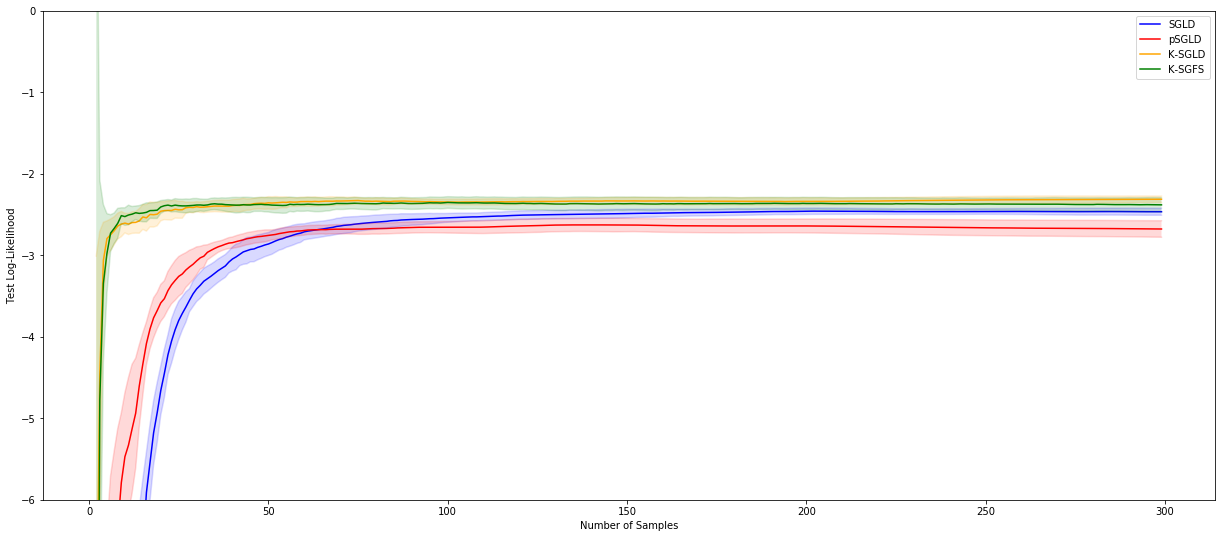

In [46]:
plt.figure(figsize=(21,9))

plt.plot(range(n_samples),ll_meanRunningSGLD,'blue', label = 'SGLD')
plt.plot(range(n_samples),ll_meanRunningPSGLD,'red', label = 'pSGLD')
plt.plot(range(n_samples),ll_meanRunningKSGLD,'orange', label = 'K-SGLD')
plt.plot(range(n_samples),ll_meanRunningKSGFS,'green', label = 'K-SGFS')

plt.plot(range(n_samples),ll_upperSGLD,'blue',alpha=0.15)
plt.plot(range(n_samples),ll_lowerSGLD,'blue', alpha=0.15)
plt.plot(range(n_samples),ll_upperPSGLD,'red',alpha=0.15)
plt.plot(range(n_samples),ll_lowerPSGLD,'red', alpha=0.15)
plt.plot(range(n_samples),ll_upperKSGLD,'orange',alpha=0.15)
plt.plot(range(n_samples),ll_lowerKSGLD,'orange', alpha=0.15)
plt.plot(range(n_samples),ll_upperKSGFS,'green',alpha=0.15)
plt.plot(range(n_samples),ll_lowerKSGFS,'green', alpha=0.15)

plt.fill_between(range(n_samples),ll_lowerSGLD, ll_upperSGLD, facecolor='blue', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),ll_lowerPSGLD, ll_upperPSGLD, facecolor='red', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),ll_lowerKSGLD, ll_upperKSGLD, facecolor='orange', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),ll_lowerKSGFS, ll_upperKSGFS, facecolor='green', alpha=0.15, interpolate=True)

plt.xlabel("Number of Samples")
plt.ylabel("Test Log-Likelihood")
plt.ylim(-6,0)
plt.legend()

### RMSE

In [30]:
rmse_meanRunningSGLD = np.mean(rmse_sgld, 0)
rmse_stdRunningSGLD = np.std(rmse_sgld, 0)
rmse_upperSGLD = rmse_meanRunningSGLD + rmse_stdRunningSGLD
rmse_lowerSGLD = rmse_meanRunningSGLD - rmse_stdRunningSGLD

rmse_meanRunningPSGLD = np.mean(rmse_psgld, 0)
rmse_stdRunningPSGLD = np.std(rmse_psgld, 0)
rmse_upperPSGLD = rmse_meanRunningPSGLD + rmse_stdRunningPSGLD
rmse_lowerPSGLD = rmse_meanRunningPSGLD - rmse_stdRunningPSGLD

rmse_meanRunningKSGLD = np.mean(rmse_ksgld, 0)
rmse_stdRunningKSGLD = np.std(rmse_ksgld, 0)
rmse_upperKSGLD = rmse_meanRunningKSGLD + rmse_stdRunningKSGLD
rmse_lowerKSGLD = rmse_meanRunningKSGLD - rmse_stdRunningKSGLD

rmse_meanRunningKSGFS = np.mean(rmse_ksgfs, 0)
rmse_stdRunningKSGFS = np.std(rmse_ksgfs, 0)
rmse_upperKSGFS = rmse_meanRunningKSGFS + rmse_stdRunningKSGFS
rmse_lowerKSGFS = rmse_meanRunningKSGFS - rmse_stdRunningKSGFS

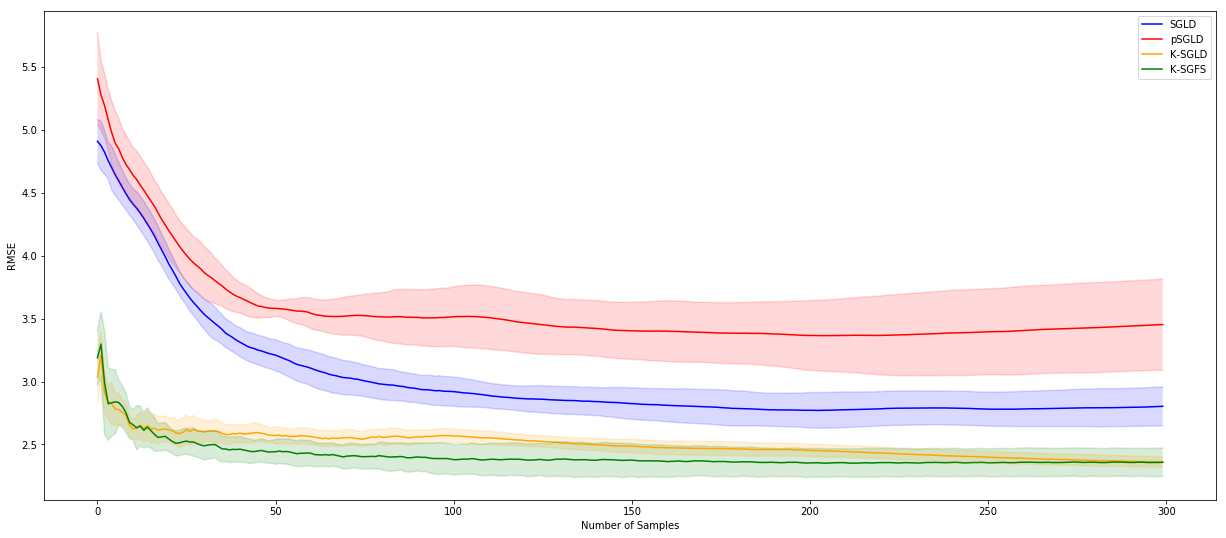

In [45]:
plt.figure(figsize=(21,9))

plt.plot(range(n_samples),rmse_meanRunningSGLD,'blue', label='SGLD')
plt.plot(range(n_samples),rmse_meanRunningPSGLD,'red', label ='pSGLD')
plt.plot(range(n_samples),rmse_meanRunningKSGLD,'orange', label = 'K-SGLD')
plt.plot(range(n_samples),rmse_meanRunningKSGFS,'green', label = 'K-SGFS')

plt.plot(range(n_samples),rmse_upperSGLD,'blue',alpha=0.15)
plt.plot(range(n_samples),rmse_lowerSGLD,'blue', alpha=0.15)
plt.plot(range(n_samples),rmse_upperPSGLD,'red',alpha=0.15)
plt.plot(range(n_samples),rmse_lowerPSGLD,'red', alpha=0.15)
plt.plot(range(n_samples),rmse_upperKSGLD,'orange',alpha=0.15)
plt.plot(range(n_samples),rmse_lowerKSGLD,'orange', alpha=0.15)
plt.plot(range(n_samples),rmse_upperKSGFS,'green',alpha=0.15)
plt.plot(range(n_samples),rmse_lowerKSGFS,'green', alpha=0.15)

plt.fill_between(range(n_samples),rmse_lowerSGLD, rmse_upperSGLD, facecolor='blue', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),rmse_lowerPSGLD, rmse_upperPSGLD, facecolor='red', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),rmse_lowerKSGLD, rmse_upperKSGLD, facecolor='orange', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),rmse_lowerKSGFS, rmse_upperKSGFS, facecolor='green', alpha=0.15, interpolate=True)

plt.xlabel("Number of Samples")
plt.ylabel("RMSE")

plt.legend()
